## Bosquejo de *approach* fuera de la API de keras
#### Autor: Francisco Mena

In [1]:
#imports
import keras, time,os,sys,gc
from keras.layers import *
from keras.models import Sequential,Model
from keras.models import clone_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from sklearn.cluster import AffinityPropagation, SpectralClustering,AgglomerativeClustering,DBSCAN,KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from code.utils import *
from code.representation import *

In [3]:
DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

### Load Data

In [ ]:
""" WINE
#df_white = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",sep=';')
df_red = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",sep=';')

df_red["normal"] = df_red["quality"]==5
df_red["good"] = df_red["quality"]>5
df_red["bad"] = df_red["quality"]<5
df_red["qualities"] = 0*df_red["bad"]+df_red["normal"]+2*df_red["good"]
df_red.drop(['quality','normal','good','bad'],axis=1,inplace=True)

y_train = df_red.pop("qualities").values*1
X_train = df_red.values

y_obs = np.loadtxt("annotations_wine.csv",delimiter=',',dtype='int')
"""

#from keras.datasets import cifar10
#(X_train, Z_train), (X_test, Z_test) = cifar10.load_data()
#y_obs = np.loadtxt("../syntetic/annotations_cifar.csv",delimiter=',',dtype='int')

#""" Syntetic data
X_train = np.loadtxt("./synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt("./synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth
y_obs = np.loadtxt("../syntetic/simple/annotations_datasim_normal.csv",delimiter=',',dtype='int')
#y_obs = np.loadtxt("../syntetic/simple/annotations_datasim_normal_soft.csv",delimiter=',',dtype='int')


X_test = np.loadtxt("./synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt("./synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth
#"""

groups_annot = np.loadtxt("../syntetic/simple/annotgroups_datasim_normal.csv",delimiter=',',dtype='int')
load_matrix = np.loadtxt('./synthetic/simple/matrix_datasim_normal.csv',delimiter=',')
rows,Kl = load_matrix.shape
real_conf_matrix = np.asarray([load_matrix[j-Kl:j] for j in np.arange(Kl,rows+1,Kl)])
confe_matrix = real_conf_matrix[groups_annot]


N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas

print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

In [4]:
path = "."
scenario = 2

In [11]:
from code.generate_data import SinteticData

X_train = np.loadtxt(path+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(path+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(path+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(path+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth


from code.generate_data import SinteticData

GenerateData = SinteticData()

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario == 6:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario == 7: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario == 7:
    Tmax = 2000
    T_data = 20 
elif scenario == 5:
    Tmax = 5000
    T_data = 25
elif scenario == 6:
    Tmax = 10000
    T_data = 40

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])

print("Accuracy of MV on train: ",np.mean(majority_voting(y_obs,repeats=False,onehot=False) == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.6365486365486366
Shape (data,annotators):  (2457, 100)
Classes:  3


In [84]:
aux2 = [0.15,0.4,0.45]
aux1 = GenerateData.conf_matrix.copy()

In [6]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2 #tolerance for relative variation in params 3 is between --1 is for good fit (maybe overfitting)

#number of groups is needed

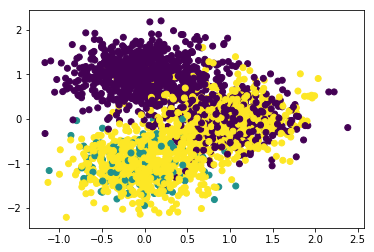

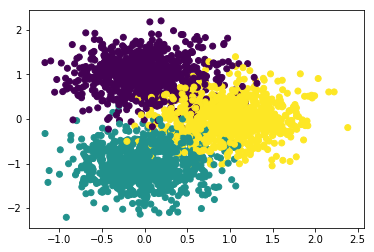

In [15]:
mv = majority_voting(y_obs,onehot=False,probas=False,repeats=False)
plt.scatter(X_train[:,0],X_train[:,1],c=mv)
plt.show()
plt.scatter(X_train[:,0],X_train[:,1],c=Z_train)

In [12]:
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

In [40]:
X_train = X_train.astype(DTYPE_OP)
X_test = X_test.astype(DTYPE_OP)
Xstd_train = X_train/255
Xstd_test = X_test/255
Z_train = Z_train[:,0]
Z_test = Z_test[:,0]
Xstd_train.shape

IndexError: too many indices for array

In [13]:
from code.representation import *
##transformar a repeat
r_obs = set_representation(y_obs,"repeat")
print("vector of repeats:\n",r_obs)

vector of repeats:
 [[ 7  0  8]
 [ 2  1  6]
 [ 1  0  8]
 ...
 [ 5  1  6]
 [ 2  1  4]
 [10  0  2]]


In [15]:
import numpy as np
from scipy.stats import entropy
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import DBSCAN,AffinityPropagation, MiniBatchKMeans, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score
import gc, keras, time, sys

from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple #deep learning
from code.representation import *
from code.utils import softmax


def aux_clusterize_annotators(data_to_cluster,M,DTYPE_OP='float32',option="hard",l=0.005):
    # Get p(g=m|t)  based on a proyection of the annotator "t" 
    std = StandardScaler()
    data_to_cluster = std.fit_transform(data_to_cluster) 
        
    kmeans = MiniBatchKMeans(n_clusters=M, random_state=0,init='k-means++',batch_size=128)
    #KMeans(M,init='k-means++', n_jobs=-1,random_state=0)
    kmeans.fit(data_to_cluster)
    distances = kmeans.transform(data_to_cluster)

    if option=="fuzzy":
        probas_t = np.zeros_like(distances,dtype=DTYPE_OP)
        for t in range(probas_t.shape[0]):
            for m in range(probas_t.shape[1]):
                m_fuzzy = 1.2
                probas_t[t,m] = 1/(np.sum( np.power((distances[t,m]/(distances[t,:]+keras.backend.epsilon())), 2/(m_fuzzy-1)) ) + keras.backend.epsilon())
    elif option == "softmax":
        probas_t = softmax(-(distances+keras.backend.epsilon())/l).astype(DTYPE_OP)
    elif option == "softmax inv":
        probas_t = softmax(1/(l*distances+keras.backend.epsilon())).astype(DTYPE_OP)
    elif option == 'hard':
        probas_t = keras.utils.to_categorical(kmeans.labels_,num_classes=M)
    #another option??
        #model = GaussianMixture(n_components=M)
        #model.fit(data_to_cluster)
        #probas_t = model.predict_proba(data_to_cluster).astype(DTYPE_OP)
    return probas_t
            


def project_and_cluster(y_o,M_to_try=20,anothers_visions=True,DTYPE_OP='float32',printed=True,mode_project="pca"):
    ###another way to cluster..
    if len(y_o.shape) == 2:
        M_itj = categorical_representation(y_o,no_label =-1)
    else:
        M_itj = y_o.copy()
    data_to_cluster = M_itj.transpose(1,0,2).reshape(M_itj.shape[1],M_itj.shape[0]*M_itj.shape[2])
    data_to_cluster = data_to_cluster.astype(DTYPE_OP)
    
    if mode_project.lower() == "pca":
        model = PCA(n_components=4)
    elif mode_project.lower() == "tpca":
        model = TruncatedSVD(n_components=4)
    elif mode_project.lower() == "kpca":
        model = KernelPCA(n_components=4, kernel='rbf', n_jobs=-1)

    plot_data = model.fit_transform(data_to_cluster)
    to_return = [plot_data]
    
    if printed:
        model = BayesianGaussianMixture(n_components=M_to_try)
        model.fit(plot_data)
        M_founded = len(set(np.argmax(model.predict_proba(plot_data),axis=1))) 
        print("Bayesian gaussian mixture say is %d clusters "%M_founded)

        if anothers_visions:
            X_sim = metrics.pairwise_distances(plot_data,metric='euclidean',n_jobs=-1)
            #dos indicadores de numero de cluster
            model = DBSCAN(eps=np.mean(X_sim), min_samples=5, metric='precomputed', n_jobs=-1)
            model.fit(X_sim)
            print("DBSCAN say is %d clusters"%len(set(model.labels_)))
            model = AffinityPropagation(affinity='precomputed')
            model.fit(X_sim)
            print("Affinity Propagation say is %d clusters"%len(set(model.labels_)))

        to_return.append( M_founded )
    return to_return


class GroupMixtureOpt(object): #optimized version
    def __init__(self,input_dim,Kl,M=2,epochs=1,optimizer='adam',pre_init=10,dtype_op='float32'): 
        if type(input_dim) != tuple:
            input_dim = (input_dim,)
        self.input_dim = input_dim
        self.Kl = Kl #number of classes of the problem
        #params
        self.M = M #groups of annotators
        self.epochs = epochs
        self.optimizer = optimizer
        self.pre_init = pre_init
        self.DTYPE_OP = dtype_op
        
        self.Keps = keras.backend.epsilon() 
        self.priors=False #boolean of priors
        self.compile=False
        self.seted_alphainit = False
        self.lambda_random = False
        
    def get_basemodel(self):
        return self.base_model
    def get_confusionM(self):
        """Get confusion matrices of every group p(yo|g,z)"""  
        return self.betas.copy()
    def get_alpha(self):
        """Get alpha param, p(g) globally"""
        return self.alphas.copy()
    def set_alpha(self,alpha_init):
        """set alpha param with a previosuly method"""
        self.alpha_init = alpha_init.copy()
        self.seted_alphainit = True
    def get_qestimation(self):
        """Get Q estimation param, this is Q_ij(g,z) = p(g,z|xi,y=j)"""
        return self.Qij_mgamma.copy()
        
    def define_model(self,tipo,start_units=1,deep=1,double=False,drop=0.0,embed=True,BatchN=True):
        """Define the base model and other structures"""
        self.type = tipo.lower()     
        if self.type == "keras_shallow" or 'perceptron' in self.type: 
            self.base_model = LogisticRegression_Keras(self.input_dim,self.Kl)
            #It's not a priority, since HF has been shown to underperform RMSprop and Adagrad, while being more computationally intensive.
            #https://github.com/keras-team/keras/issues/460
        elif self.type =="sklearn_shallow" or self.type =="sklearn_logistic":
            self.base_model = LogisticRegression_Sklearn(self.epochs)
            self.compile = True
            return
        elif self.type=='defaultcnn' or self.type=='default cnn':
            self.base_model = default_CNN(self.input_dim,self.Kl)
        elif self.type=='defaultrnn' or self.type=='default rnn':
            self.base_model = default_RNN(self.input_dim,self.Kl)
        elif self.type=='defaultrnnE' or self.type=='default rnn E': #with embedding
            self.base_mode = default_RNNw_emb(self.input_dim,self.Kl,len) #len is the length of the vocabulary
            #podria ser el maximo

        elif self.type == "ff" or self.type == "mlp" or self.type=='dense': #classic feed forward
            print("Needed params (units,deep,drop,BatchN?)") #default activation is relu
            self.base_model = MLP_Keras(self.input_dim,self.Kl,start_units,deep,BN=BatchN,drop=drop)

        elif self.type=='simplecnn' or self.type=='simple cnn' or 'cnn' in self.type:
            print("Needed params (units,deep,drop,double?,BatchN?)") #default activation is relu
            self.base_model = CNN_simple(self.input_dim,self.Kl,start_units,deep,double=double,BN=BatchN,drop=drop)
        
        elif self.type=='simplernn' or self.type=='simple rnn' or 'rnn' in self.type:
            print("Needed params (units,deep,drop,embed?)")
            self.base_model = RNN_simple(self.input_dim,self.Kl,start_units,deep,drop=drop,embed=embed,len=0,out=start_units*2)
            #and what is with embedd

        #if not (self.type == "keras_shallow" or self.type=="keras_perceptron"): 
        #    self.base_model = create_network(self.Kl,self.input_dim,tipo,info,infoextractor_network=aux_info,embedding_info=emb_info)
        #     future..
        self.base_model.compile(optimizer=self.optimizer,loss='categorical_crossentropy') 
        self.compile = True
        
    def get_predictions(self,X):
        """Return the predictions of the model if is from sklearn or keras"""
        if "sklearn" in self.type:
            return self.base_model.predict_proba(X) 
        else:
            return self.base_model.predict(X,batch_size=self.batch_size)
    
    def init_E(self,X,r):
        """Realize the initialziation of the E step on the EM algorithm"""
        #-------> init alpha
        if not self.seted_alphainit: #random is the worst option
            self.alpha_init = np.random.dirichlet(np.ones(self.M)/50,size=(self.N,self.Kl))
        
        #-------> init Majority voting        
        self.mv_probs_j = majority_voting(r,repeats=True,probas=True) # soft -- p(y=j|xi)
        
        print("Pre-train network on %d epochs..."%(self.pre_init),end='',flush=True)
        self.base_model.fit(X,self.mv_probs_j,batch_size=self.batch_size,epochs=self.pre_init,verbose=0)
        print(" Done!")
        #reset optimizer but hold weights--necessary for stability 
        self.base_model.compile(loss='categorical_crossentropy',optimizer=self.optimizer)

        #-------> Initialize p(z=gamma|xi,y=j,g): Combination of mv and belive observable
        lambda_group = np.ones((self.M),dtype=self.DTYPE_OP) 
        if self.lambda_random:
            for m in range(self.M):
                lambda_group[m] = np.random.beta(1,1)
        print("Lambda by group: ",lambda_group)
        Zijm = np.zeros((self.N,self.Kl,self.M,self.Kl),dtype=self.DTYPE_OP)
        for j_ob in range(self.Kl):
            onehot = np.tile(self.Keps, self.Kl)
            onehot[j_ob] = 1. #all belive in the observable
            for m in range(self.M):                
                Zijm[:,j_ob,m,:] = lambda_group[m]*self.mv_probs_j + (1-lambda_group[m])*onehot 
          
        #-------> init q_ij      
        self.Qij_mgamma = self.alpha_init[:,:,:,None]*Zijm
        
        #-------> init betas
        self.betas = np.zeros((self.M,self.Kl,self.Kl),dtype=self.DTYPE_OP) 

        #-------> init alphas
        self.alphas = np.zeros((self.M),dtype=self.DTYPE_OP)
     
        print("Alphas: ",self.alphas.shape)
        print("MV init: ",self.mv_probs_j.shape)
        print("Betas: ",self.betas.shape)
        print("Q estimate: ",self.Qij_mgamma.shape)
            
    def define_priors(self,priors):
        """
            Priors with shape: (M,K,K), need counts for every group and every pair (k,k) ir global (M,K)
            The group m, given a class "k" is probably that say some class
            it is recomended that has full of ones
        """
        if type(priors) == str:
            if priors == "laplace":
                priors = 1
            else:
                print("Prior string do not understand")
                return
        else:
            if len(priors.shape)==2:
                priors=np.expand_dims(priors,axis=2)
        self.Mpriors = priors
        self.priors = True
        
    def E_step(self,X,predictions):
        """ Realize the E step in matrix version"""       
        p_new = np.clip(predictions[:,None,None,:] , self.Keps,1.) #safe logarithmn
        a_new = np.clip(self.alphas[None,None,:,None] , self.Keps,1.) #safe logarithmn
        b_new = np.clip((self.betas[None,:,:,:]).transpose(0,3,1,2) , self.Keps,1.) #safe logarithmn
        
        self.Qij_mgamma = np.exp(np.log(p_new) + np.log(a_new) + np.log(b_new)) 
        self.aux_for_like = (self.Qij_mgamma.sum(axis=-1)).sum(axis=-1) #p(y=j|x) --marginalized
        self.Qij_mgamma = self.Qij_mgamma/self.aux_for_like[:,:,None,None] #normalize
        
    def M_step(self,X,r): 
        """ Realize the M step"""
        #-------> base model
        Qij_gamma = self.Qij_mgamma.sum(axis=-2) #qij(gamma)
        r_estimate = np.zeros((self.N,self.Kl),dtype=self.DTYPE_OP) #create the repeat "estimate"/"ground truth"
        for i in range(self.N):
            r_estimate[i] = np.tensordot(Qij_gamma[i],r[i],axes=[[0],[0]])
        if "sklearn" in self.type:#train to learn p(z|x)
            self.base_model.fit(X, np.argmax(r_estimate,axis=1) ) 
        else:
            self.base_model.fit(X,r_estimate,batch_size=self.batch_size,epochs=self.epochs,verbose=0) 
    
        #-------> alpha 
        Qij_m = self.Qij_mgamma.sum(axis=-1) #qij(m)
        self.alphas = np.tensordot(Qij_m, r , axes=[[0,1],[0,1]]) # sum_ij r_ij(g) = Qij_m[i]*r[i] 
        self.alphas = self.alphas.astype(self.DTYPE_OP) #necessary
        self.alphas = self.alphas/self.alphas.sum(axis=-1,keepdims=True) #p(g) -- normalize
        
        #-------> beta
        for j_ob in range(self.Kl):
            self.betas[:,:,j_ob] = np.tensordot(self.Qij_mgamma[:,j_ob,:,:],r[:,j_ob], axes=[[0],[0]]) # ~p(yo=j|g,z)              
        if self.priors:
            self.betas += self.Mpriors #priors has to be shape: (M,Kl,Kl)--read define-prior functio
        self.betas = self.betas/self.betas.sum(axis=-1,keepdims=True) #normalize (=p(yo|g,z))

    def compute_logL(self,r,predictions):
        """ Compute the log-likelihood of the optimization schedule"""
        return np.tensordot(r , np.log(self.aux_for_like+self.Keps))+0. #safe logarithm
                                                  
    def train(self,X_train,r_train,batch_size=64,max_iter=500,relative=True,val=False,tolerance=1e-2):
        if not self.compile:
            print("You need to create the model first, set .define_model")
            return
        print("Initializing new EM...")
        self.batch_size = batch_size
        self.N = X_train.shape[0]
        self.init_E(X_train,r_train)
        
        logL = []
        stop_c = False
        tol,old_model,old_betas,old_alphas = np.inf,np.inf,np.inf,np.inf
        self.current_iter = 1
        while(not stop_c):
            print("Iter %d/%d\nM step:"%(self.current_iter,max_iter),end='',flush=True)
            start_time = time.time()
            self.M_step(X_train,r_train)
            print(" done,  E step:",end='',flush=True)
            predictions = self.get_predictions(X_train) #p(z|x) 
            self.E_step(X_train,predictions)
            print(" done //  (in %.2f sec)\t"%(time.time()-start_time),end='',flush=True)
            logL.append(self.compute_logL(r_train,predictions))
            print("logL: %.3f\t"%(logL[-1]),end='',flush=True)
            if self.current_iter>=2:
                tol = np.abs(logL[-1] - logL[-2])                    
                if relative:
                    tol = tol/np.abs(logL[-2])
                tol2 = np.mean(np.abs(self.betas.flatten()-old_betas)/(old_betas+self.Keps)) #confusion
                tol3 = np.mean(np.abs(self.alphas-old_alphas)/(old_alphas+self.Keps)) #alphas
                print("Tol1: %.5f\tTol2: %.5f\tTol3: %.5f\t"%(tol,tol2,tol3),end='',flush=True)
            old_betas = self.betas.flatten().copy()         
            old_alphas = self.alphas.copy()
            #if val:
            #    print("F1: %.4f"%(f1_score(Z_train, predictions.argmax(axis=1),average='micro')),end='',flush=True)
            self.current_iter+=1
            print("")
            if self.current_iter>max_iter or (tol<=tolerance and tol2<=tolerance): #alphas fuera: and tol3<=tolerance
                stop_c = True 
        print("Finished training!")
        gc.collect()
        return np.asarray(logL)
    
    def annotations_2_group(self,annotations,data=[],pred=[],no_label_sym = -1):
        """
            Map some annotations to some group model by the confusion matrices, p(g| {x_l,y_l})
        """
        if len(pred) != 0:
            predictions_m = pred #if prediction_m is passed
        elif len(data) !=0: 
            predictions_m = self.get_predictions_groups(data) #if data is passed
        else:
            print("Error, in order to match annotations to a group you need pass the data X or the group predictions")
            return
            
        result = np.log(self.get_alpha()+self.Keps)
        aux_annotations = [(i,annotation) for i, annotation in enumerate(annotations) if annotation != no_label_sym]
        for i, annotation in aux_annotations:
            if annotation != no_label_sym: #if label it
                for m in range(self.M):
                    result[m] += np.log(predictions_m[i,m,annotation]+self.Keps)
        result = np.exp(result - result.max(axis=-1, keepdims=True) ) #invert logarithm in safe way
        return result/np.sum(result)
    
    def stable_train(self,X,r,batch_size=64,max_iter=50,tolerance=1e-2,cluster=True,bulk_annotators=[]):
        """
            A stable schedule to train a model on this formulation
        """
        self.lambda_random = False #lambda=1
        self.define_priors('laplace')
        
        if cluster: # do annotator clustering
            if len(bulk_annotators) == 0:
                alphas_clusterized = clusterize_annotators(r,M=self.M,bulk=False,cluster_type='mv_close',data=X,model=self.base_model,DTYPE_OP=self.DTYPE_OP,BATCH_SIZE=batch_size) #clusteriza en base aloss
            elif len(bulk_annotators) == 1:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1)
            else:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1,data=bulk_annotators[1])
            self.set_alpha(alphas_clusterized)

        logL_hist = self.train(X,r,batch_size=batch_size,max_iter=max_iter,tolerance=tolerance,relative=True,val=False)
        return logL_hist
    
    #and multiples runs with lambda random false?
    def multiples_run(self,Runs,X,r,batch_size=64,max_iter=50,tolerance=1e-2,cluster=True,bulk_annotators=[]): 
        """
            Run multiples max_iter of EM algorithm, with random stars
        """
        self.define_priors('laplace')
        
        if cluster: # do annotator clustering
            if len(bulk_annotators) == 0:
                alphas_clusterized = clusterize_annotators(r,M=self.M,bulk=False,cluster_type='mv_close',data=X,model=self.base_model,DTYPE_OP=self.DTYPE_OP,BATCH_SIZE=batch_size) #clusteriza en base aloss
            elif len(bulk_annotators) == 1:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1)
            else:
                alphas_clusterized = clusterize_annotators(bulk_annotators[0],M=self.M,no_label=-1,data=bulk_annotators[1],DTYPE_OP=self.DTYPE_OP)
            self.set_alpha(alphas_clusterized)
            
        found_betas = []
        found_alphas = []
        found_model = []
        found_logL = []
        for run in range(Runs):
            self.base_model = keras.models.clone_model(self.base_model) #reset-weigths
            self.base_model.compile(loss='categorical_crossentropy',optimizer=self.optimizer)

            logL_hist = self.train(X,r,batch_size=batch_size,max_iter=max_iter,tolerance=tolerance,relative=True) #here the models get resets
            
            found_betas.append(self.betas.copy())
            found_alphas.append(self.alphas.copy())
            found_model.append(self.base_model) #revisar si se resetean los pesos o algo asi..
            found_logL.append(logL_hist)
            gc.collect()
        #setup the configuration with maximum log-likelihood
        logL_iter = np.asarray([np.max(a) for a in found_logL])
        indexs_sort = np.argsort(logL_iter)[::-1] 
        
        self.betas = found_betas[indexs_sort[0]].copy()
        self.alphas = found_alphas[indexs_sort[0]].copy()
        self.base_model = found_model[indexs_sort[0]]
        self.E_step(X,self.get_predictions(X)) #to set up Q
        return found_logL,indexs_sort[0]
    
    def get_predictions_group(self,m,X):
        """ Predictions of group "m", p(y^o | xi, g=m) """
        p_z = self.get_predictions(X)
        p_y_m = np.zeros(p_z.shape)
        for i in range(self.N):
            p_y_m[i] = np.tensordot(p_z[i,:] ,self.betas[m,:,:],axes=[[0],[0]] ) # sum_z p(z|xi) * p(yo|z,g=m)
        return p_y_m 
    
    def get_predictions_groups(self,X):
        """ Predictions of all groups , p(y^o | xi, g) """
        p_z = self.get_predictions(X)
        predictions_m = np.tensordot(p_z ,self.betas,axes=[[1],[1]] ) #sum_z p(z|xi) * p(yo|z,g)
        return predictions_m#.transpose(1,0,2)

    def calculate_extra_components(self,X,y_o,T,calculate_pred_annotator=True):
        """
            Measure indirect probabilities through bayes and total probability of annotators
        """
        predictions_m = self.get_predictions_groups(X) #p(y^o|x,g=m)
        
        prob_Gt = np.zeros((T,self.M)) #p(g|t)
        for t in range(T):
            prob_Gt[t] = self.annotations_2_group(y_o[:,t],pred=predictions_m) 

        prob_Yzt = np.tensordot(prob_Gt, self.get_confusionM(),axes=[[1],[0]])  #p(y^o|z,t) = sum_g p(g|t) * p(yo|z,g)
  
        if calculate_pred_annotator:
            prob_Yxt = np.tensordot(predictions_m, prob_Gt, axes=[[1],[1]]).transpose(0,2,1) #p(y^o|x,t) = sum_g p(g|t) *p(yo|x,g)
        else:
            prob_Yxt = None
        gc.collect()
        return predictions_m, prob_Gt, prob_Yzt, prob_Yxt
    
    def get_annotator_reliability(self,y_o,X,t):
        """Get annotator reliability, based on his annotations:"""        
        prob_Gt = annotations_2_group(self,y_o[:,t],data=X)
        
        prob_Yzt = np.tensordot(prob_Gt, self.get_confusionM(),axes=[[0],[0]])  #p(y^o|z,t) = sum_g p(g|t) * p(yo|z,g)
        return prob_Yzt #do something with it


In [16]:
def clusterize_annotators(y_o,M,no_label=-1,bulk=True,cluster_type='loss',data=[],model=None,DTYPE_OP='float32',BATCH_SIZE=64,option="hard",l=0.005):
    start_time = time.time()
    if bulk: 
        if len(y_o.shape) == 2:
            M_itj = categorical_representation(y_o,no_label =no_label)
        else:
            M_itj = y_o.copy()
        mask_nan = M_itj.sum(axis=1,keepdims=True) == 0
        mask_nan = np.tile(mask_nan,(1,M_itj.shape[1],1))
        M_itj[mask_nan] = 1
        #M_itj = M_itj.astype(DTYPE_OP)
        #M_itj_norm = M_itj/M_itj.sum(axis=1,keepdims=True)#[:,None,:]
                
        if len(data) != 0:
            data_to_cluster = data.copy() #annotators_pca
        else:
            data_to_cluster = M_itj.transpose(1,0,2).reshape(M_itj.shape[1],M_itj.shape[0]*M_itj.shape[2])
            
        probas_t = aux_clusterize_annotators(data_to_cluster,M,DTYPE_OP,option,l) #0.05 is close to one-hot
        print("Clustering Done!")
        #alphas_init = np.tensordot(M_itj_norm,probas_t, axes=[[1],[0]]) 
        alphas_init = np.tensordot(M_itj, probas_t, axes=[[1],[0]]) 
        alphas_init = alphas_init/alphas_init.sum(axis=-1,keepdims=True) #normalize here for efficiency
    else: #sirve como auxiliar: y_o: is repeats
        if len(y_o.shape) == 2: 
            mv_hard = majority_voting(y_o,repeats=True,probas=True) 
        else:
            mv_hard = majority_voting(y_o,repeats=False,probas=True)  #change soft
        if cluster_type=='loss': #cluster respecto to loss function
            print("loss is done")
            aux_model = keras.models.clone_model(model)
            aux_model.compile(loss='categorical_crossentropy',optimizer=model.optimizer)
            aux_model.fit(data, mv_hard, batch_size=BATCH_SIZE,epochs=30,verbose=0)
            predicted = aux_model.predict(data,verbose=0)
        elif cluster_type == 'mv_close':
            print("mv_close is done")
            predicted = np.clip(mv_hard.copy(), keras.backend.epsilon(), 1.)
            
        data_to_cluster = []
        for i in range(mv_hard.shape[0]):
            for j in range(mv_hard.shape[1]):
                ob = np.tile(keras.backend.epsilon(), mv_hard.shape[1])
                ob[j] = 1
                true = np.clip(predicted[i],keras.backend.epsilon(),1.)     
                #funcion de distancia o similaridad
                f_l = distance_function(true, ob)
                #loss = -np.sum(true*np.log(ob))-- actual
                #loss = -np.sum(ob*np.log(true)) #nooooooooo!!!!!
                data_to_cluster.append(f_l)  
        data_to_cluster = np.asarray(data_to_cluster)
        probas_t = aux_clusterize_annotators(data_to_cluster,M,DTYPE_OP,option,l)
        print("Clustering Done!")
        alphas_init = probas_t.reshape(mv_hard.shape[0],mv_hard.shape[1],M)
    print("Get init alphas in %f mins"%((time.time()-start_time)/60.) )
    return alphas_init

In [12]:
%%time
#from code.MixtureofGroups import project_and_cluster,clusterize_annotators
#has to executed always, to know a priori the number of clusters and choose
annotators_pca = project_and_cluster(y_obs,mode_project='pca')[0]
#M_f, annotators_pca, alphas_clusterized0 = project_and_cluster(y_obs,cluster=True,return_projected=True)
print(annotators_pca.shape)

Bayesian gaussian mixture say is 9 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


DBSCAN say is 1 clusters
Affinity Propagation say is 4 clusters
(100, 4)
CPU times: user 8.52 s, sys: 807 ms, total: 9.33 s
Wall time: 1.73 s


In [ ]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
np.mean(aux)#*100

In [11]:
alphas_clusterized1 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca) #clusteriza anotaciones de anotadoras
#alphas_clusterized2 = clusterize_annotators(r_obs,M=4,no_label=-1,bulk=False,cluster_type='loss',data=Xstd_train,model=gMixture.base_model) #clusteriza en base aloss
#alphas_clusterized3 = clusterize_annotators(r_obs,M=4,no_label=-1,bulk=False,cluster_type='net',data=Xstd_train) #clusteriza en base a pesos de red
alphas_clusterized1

Clustering Done!
Get init alphas in 0.008897 mins


array([[[0.        , 0.6666667 , 0.33333334],
        [0.5       , 0.21      , 0.29      ],
        [0.75      , 0.125     , 0.125     ]],

       [[0.5       , 0.21      , 0.29      ],
        [1.        , 0.        , 0.        ],
        [0.5714286 , 0.2857143 , 0.14285715]],

       [[0.2       , 0.        , 0.8       ],
        [0.        , 0.        , 1.        ],
        [0.6363636 , 0.        , 0.36363637]],

       ...,

       [[0.125     , 0.25      , 0.625     ],
        [0.        , 0.        , 1.        ],
        [0.8333333 , 0.        , 0.16666667]],

       [[0.        , 0.42857143, 0.5714286 ],
        [0.        , 0.        , 1.        ],
        [0.6       , 0.2       , 0.2       ]],

       [[0.2857143 , 0.14285715, 0.5714286 ],
        [0.5       , 0.21      , 0.29      ],
        [1.        , 0.        , 0.        ]]], dtype=float32)

In [69]:
#alphas_c1 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="softmax",l=50) 
alphas_c2 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="softmax inv",l=0.005) 
alphas_c3 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="fuzzy") 
alphas_c4 = clusterize_annotators(y_obs,M=3,no_label=-1,data=annotators_pca,option="hard") 
alphas_c5 = clusterize_annotators(r_obs,M=3,no_label=-1,data=Xstd_train,option="hard",bulk=False,model=gMixture.base_model) 

Clustering Done!
Get init alphas in 0.008863 mins
Clustering Done!
Get init alphas in 0.007592 mins
Clustering Done!
Get init alphas in 0.007051 mins
Clustering Done!
Get init alphas in 0.107466 mins


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [52]:
alphas_c4

array([[[0.5       , 0.        , 0.5       ],
        [0.51      , 0.28      , 0.21      ],
        [0.6666667 , 0.33333334, 0.        ]],

       [[0.6666667 , 0.        , 0.33333334],
        [0.4       , 0.6       , 0.        ],
        [0.33333334, 0.33333334, 0.33333334]],

       [[0.        , 0.5       , 0.5       ],
        [0.51      , 0.28      , 0.21      ],
        [0.5       , 0.25      , 0.25      ]],

       ...,

       [[1.        , 0.        , 0.        ],
        [0.51      , 0.28      , 0.21      ],
        [0.8333333 , 0.        , 0.16666667]],

       [[0.625     , 0.25      , 0.125     ],
        [0.51      , 0.28      , 0.21      ],
        [1.        , 0.        , 0.        ]],

       [[0.3       , 0.3       , 0.4       ],
        [0.51      , 0.28      , 0.21      ],
        [0.75      , 0.25      , 0.        ]]], dtype=float32)

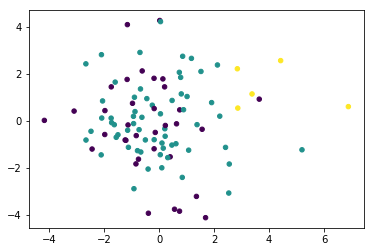

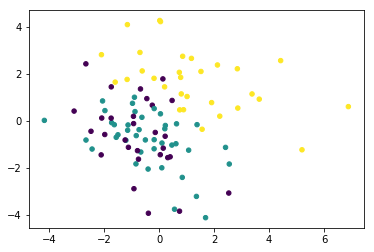

In [16]:
data_to_cluster = annotators_pca.copy() #annotators_pca
std = StandardScaler()
data_to_cluster = std.fit_transform(data_to_cluster)

kmeans = KMeans(n_clusters=3, random_state=0,init='k-means++',n_jobs=-1)
kmeans.fit(data_to_cluster)

#proyect
if scenario != 3:
    plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= groups_annot,s=20)
else:
    plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= groups_annot.argmax(axis=1),s=20)

plt.show()
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c= kmeans.labels_, s=20)
plt.show()

### Red Base (real)

In [12]:
#PENDIENTES POR AGREGAR---revisar en base a experimentacion con datos simulados
# 1-BatchNormalization en todas las capas
# 2-Dropout

def bloque_convolucional(layer1,units,kernel_size,stride,activation,BN=False):
    """As a ssuper-layer = followed layers"""
    f1 = Conv2D(units,kernel_size,activation=activation,padding='same')(layer1)
    if BN:
        f1 = BatchNormalization()(f1)
    f1 = Conv2D(units,kernel_size,activation=activation,padding='same')(f1)
    if BN:
        f1 = BatchNormalization()(f1)
    f1 = MaxPool2D(pool_size=stride)(f1)
    return f1
        
def create_network(Kl,input_dim,tipo,info_net,infoextractor_network=None,embedding_info=None):
    #add batch norma y dropa..
    try:
        len(input_dim)
    except:
        input_dim = (input_dim,)
    input_tensor = Input(shape=input_dim,name="data")
    #arquitectura
    if tipo == "CNN": #classic convolutional: deep-CCP
        start_unit,kernel_size,stride,deep,activation = infoextractor_network
        units = start_unit 
        f1 = bloque_convolucional(input_tensor,units,kernel_size,stride,activation) #BN=True for BatchNormalization
        for i in range(deep-1): #profundidad
            units = units*2
            f1 = bloque_convolucional(f1,units,kernel_size,stride,activation) #BN=True for BatchNormalization
        f1 = Flatten()(f1)
            
    elif tipo == "RNN": #recurrent 
        units,deep =infoextractor_network
        #embedding for text datasets
        if embedding_info!=None:
            input_dim,output_dim =embedding_info
            emb = Embedding(input_dim,output_dim)(input_tensor)
            f1 = CuDNNGRU(units,return_sequences=True)(emb)
        else:
            f1 = CuDNNGRU(units,return_sequences=True)(input_tensor)
        for i in range(deep-1): #profundidad
            f1 = CuDNNGRU(units,return_sequences=True)(f1)
        f1 = CuDNNGRU(units,return_sequences=False)(f1) #alias to flatten in convolutional
        #f1 = GlobalMaxPool1D()(f1)
    
    ### classify with extracted features
    units,ff_deep,ff_activation =info_net
    if tipo == "FF": #classic Feed Forward
        d1 = Dense(units,activation=ff_activation)(input_tensor) #comes from input
    else:
        d1 = Dense(units,activation=ff_activation)(f1)
    for i in range(ff_deep-1): #all the deep layers
        units = units/2
        d1 = Dense(units,activation=ff_activation)(d1)
        
    output_soft = Dense(Kl,activation='softmax',name="output_soft")(d1) #softmax to probability p(z|xi)
    
    model = Model(inputs=input_tensor,outputs=output_soft)
    model.summary()
    return model

In [13]:
### Ejemplo CNN
start_units,kernel,strides,deep,activation = 32, 3, 2, 3, 'relu'
info_cnn = [start_units,kernel,strides,deep,activation] 

start_units,deep, activation = 512 , 2, 'relu' 
info = [start_units,deep,activation]  #feed forwad info
clases = 3
dimensiones_input = [50,50,3]
a = create_network(clases,dimensiones_input,"CNN",info,info_cnn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
__________

In [15]:
### Ejemplo RNN
start_units,deep = 128, 2
info_rnn = [start_units,deep] 

start_units,deep, activation = 512 , 2, 'relu'
info = [start_units,deep,activation] 
clases = 3
dimensiones_input = [5,50]
a = create_network(clases,dimensiones_input,"RNN",info,info_rnn)

Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 5, 50)             0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 5, 128)            69120     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 5, 128)            99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
out

In [16]:
### Ejemplo RNN con embedding
input_dim,output_dim = 1000,64
info_embedding = [input_dim,output_dim]

start_units,deep = 128, 2
info_rnn = [start_units,deep] 

start_units,deep, activation = 512 , 2, 'relu'
info = [start_units,deep,activation] 
clases = 3
dimensiones_input = [10] #largo
a = create_network(clases,dimensiones_input,"RNN",info,infoextractor_network=info_rnn,embedding_info=info_embedding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 64)            64000     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 10, 128)           74496     
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 10, 128)           99072     
_________________________________________________________________
cu_dnngru_6 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
__________

<a id="sindato"></a>
### Training module  1
---
Here we implement the iteration between **E** and **M** steps of our formulation with group annotations $r_{ij}$.

In [11]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.MixtureofGroups import GroupMixtureOpt

In [39]:
M_itj = set_representation(y_obs,'onehot')
mask_nan = M_itj.sum(axis=1,keepdims=True) == 0
mask_nan2 = M_itj.sum(axis=1) == 0

mask_nan = np.tile(mask_nan,(1,M_itj.shape[1],1))
M_itj[mask_nan] = 1
M_itj_norm = M_itj/np.sum(M_itj,axis=1)[:,None,:]
M_itj_norm = M_itj_norm.astype(DTYPE_OP)
        
alphas_init = np.tensordot(M_itj_norm,groups_annot, axes=[[1],[0]]) 
#alphas_init[mask_nan2] = 1/alphas_init.shape[-1]
alphas_init

array([[[0.        , 0.5       , 0.5       ],
        [0.21999997, 0.57      , 0.20999998],
        [0.33333334, 0.6666667 , 0.        ]],

       [[0.        , 0.6666667 , 0.33333334],
        [0.6       , 0.4       , 0.        ],
        [0.        , 0.6666667 , 0.33333334]],

       [[0.5       , 0.        , 0.5       ],
        [0.21999997, 0.57      , 0.20999998],
        [0.25      , 0.5       , 0.25      ]],

       ...,

       [[0.        , 1.        , 0.        ],
        [0.21999997, 0.57      , 0.20999998],
        [0.        , 0.8333334 , 0.16666667]],

       [[0.25      , 0.625     , 0.125     ],
        [0.21999997, 0.57      , 0.20999998],
        [0.        , 1.        , 0.        ]],

       [[0.1       , 0.5       , 0.4       ],
        [0.21999997, 0.57      , 0.20999998],
        [0.25      , 0.75      , 0.        ]]], dtype=float32)

In [60]:
gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=0,dtype_op=DTYPE_OP) 
#gMixture.define_model("keras_shallow")
gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
#gMixture.define_model("default cnn")
gMixture.lambda_random=False

gMixture.set_alpha(alphas_c5)

gMixture.define_priors(np.ones((gMixture.M,r_obs.shape[1]))) #do option of laplace smoothing
logL_hist = gMixture.train(Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=1,tolerance=TOL*2
                           ,relative=True)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/1
M step: done,  E step: done //  (in 1.11 sec)	logL: -25871.749	
Finished training!


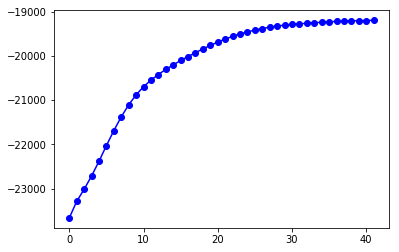

In [97]:
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.show()

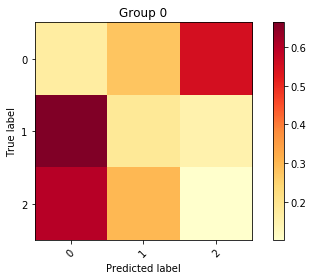

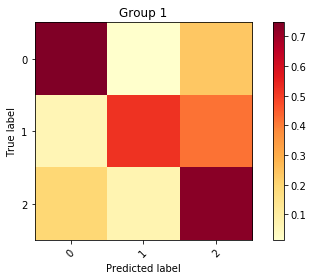

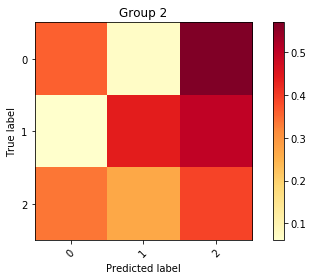

Inertia: 0.12659172527492046
A result
 ====  ========  =========  =========  ===========  =========  =============  =========
  ..    Groups       Prob    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  =========  =========  ===========  =========  =============  =========
   0         0  0.0668789   0.918062     0.152304   1.91645        0.321522  -0.18103
   1         1  0.583417    0.743075     0.666589   0.418815       0.80537    0.333255
   2         2  0.349704    0.946193     0.397353   0.9263         0.601097   0.06402
====  ========  =========  =========  ===========  =========  =============  =========
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.35409       0.35409
====  ======  ==========  ============


In [48]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 
c_M = gMixture.get_confusionM()
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

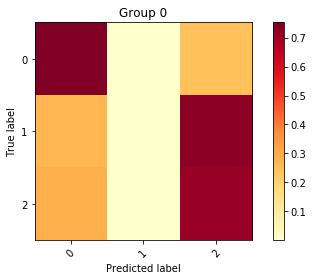

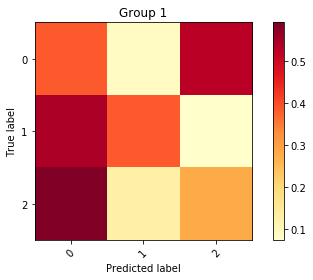

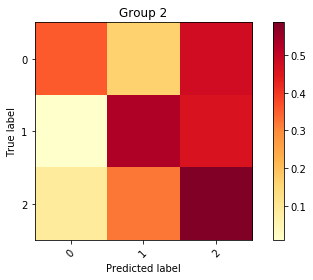

Inertia: 0.16098025565346083
A result
 ====  ========  ========  =========  ===========  =========  =============  =========
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  =========  ===========  =========  =============  =========
   0         0  0.415495   0.586713     0.489071   2.2235         0.57143   0.155738
   1         1  0.21514    0.913499     0.350059   1.06012        0.555461  0.0167254
   2         2  0.369365   0.880749     0.490813   0.734128       0.676285  0.157479
====  ========  ========  =========  ===========  =========  =============  =========
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global   0.0903541     0.0903541
====  ======  ==========  ============


In [61]:
evaluate = Evaluation_metrics(gMixture,'our1') 
c_M = gMixture.get_confusionM()
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

In [27]:
GenerateData.prob_groups

array([0.25, 0.55, 0.2 ])

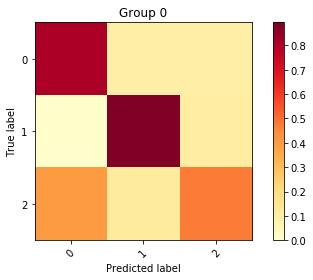

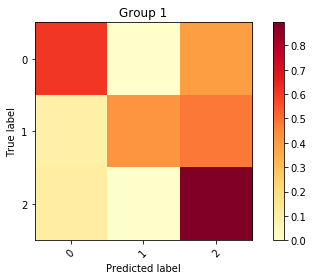

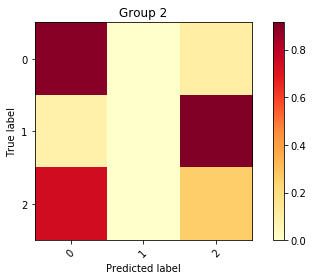

Inertia: 0.16202351067377893
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.189472   0.643653     0.72667    0.355134            0.83733
   1         1  0.588126   0.646593     0.641943   0.489447            0.779772
   2         2  0.222402   0.400478     0.384487   5.86044             0.468836
====  ========  ========  =========  ===========  =========  ==================


In [24]:
evaluate = Evaluation_metrics(gMixture,'our1') 
results = evaluate.calculate_metrics(conf_pred=real_conf_matrix)

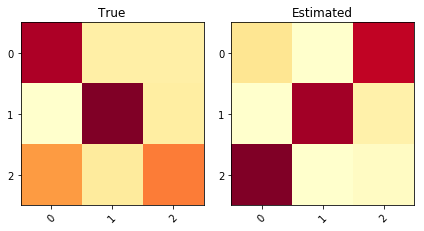

KL divergence: 1.0236	Pearson Correlation between diagonals: 0.7599


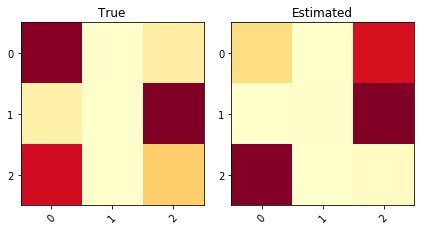

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


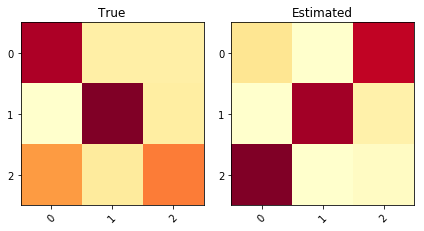

KL divergence: 1.0236	Pearson Correlation between diagonals: 0.7599


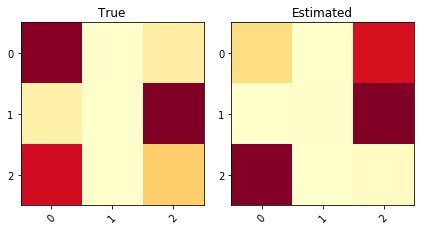

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


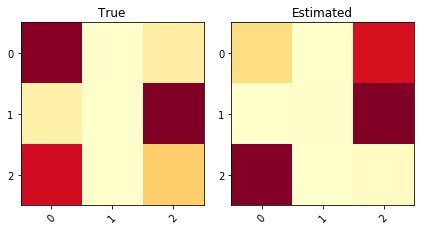

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


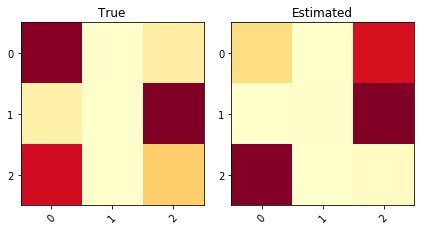

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


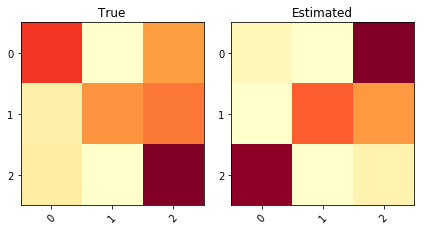

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


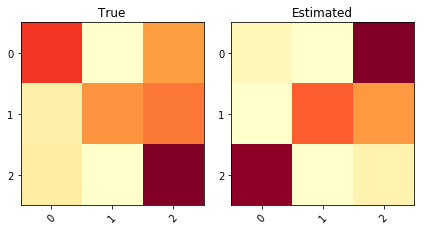

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


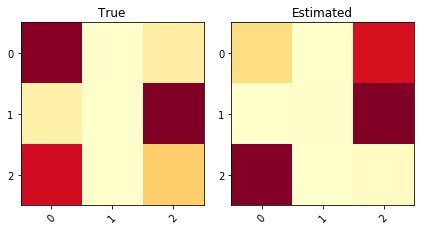

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


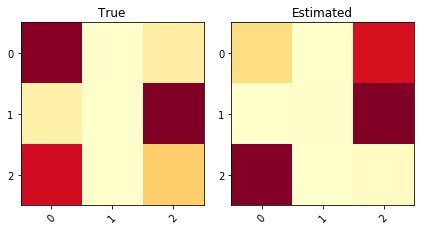

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


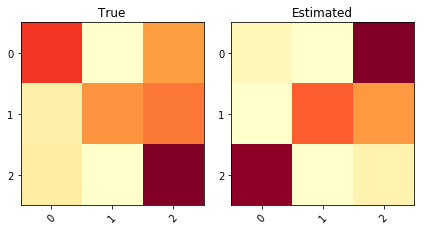

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


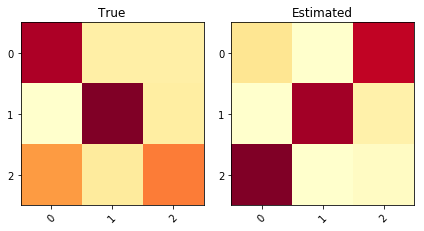

KL divergence: 1.0236	Pearson Correlation between diagonals: 0.7599


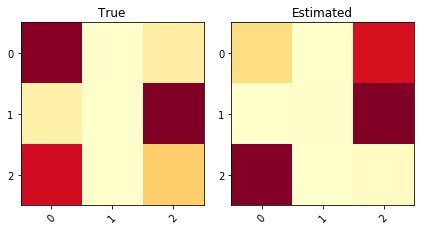

KL divergence: 0.5738	Pearson Correlation between diagonals: 0.9766


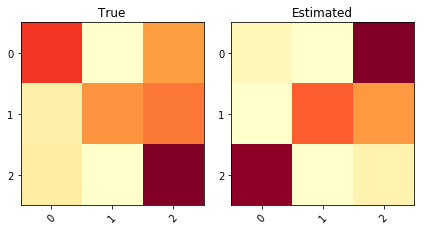

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602


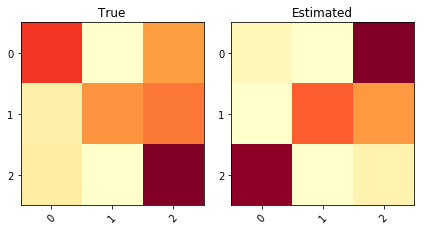

KL divergence: 1.1324	Pearson Correlation between diagonals: -0.7602
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.400488      0.400488      0.896207               0.234166
====  ======  ==========  ============  ============  =====================


In [17]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

In [14]:
from code.evaluation import Evaluation_metrics
from tabulate import tabulate
def get_mean_dataframes(df_values):
    if df_values[0].iloc[:,0].dtype == object:
        RT = pd.DataFrame(data=None,columns = df_values[0].columns[1:], index= df_values[0].index)
    else:
        RT = pd.DataFrame(data=None,columns = df_values[0].columns, index= df_values[0].index)
        
    data = []
    for df_value in df_values:
        if df_value.iloc[:,0].dtype == object:
            data.append( df_value.iloc[:,1:].values )
        else:
            data.append(df_value.values)
    RT[:] = np.mean(data,axis=0)
    
    if df_values[0].iloc[:,0].dtype == object:
        RT.insert(0, "", df_values[0].iloc[:,0].values )
    return RT

def run_experiment(pre_init_value):
    aux_test = []
    aux_testA = []
    aux_train = []
    for _ in range(10):
        gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=pre_init_value,dtype_op=DTYPE_OP) 
        gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
        gMixture.lambda_random=False
        gMixture.set_alpha(alphas_clusterized1)
        gMixture.define_priors(np.ones((gMixture.M,r_obs.shape[1]))) #do option of laplace smoothing
        logL_hist = gMixture.train(Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                   ,relative=True)
        evaluate = Evaluation_metrics(gMixture,'our1',plot=False) 
        c_M = gMixture.get_confusionM()
        Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
        results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)
        aux_test.append(results[1])
        aux_testA.append(results[0])

        aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

        #Usuall train
        Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
        results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)
        aux_train += results
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=pre_init_value,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    logL_hists,i = gMixture.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL*2
                                       ,cluster=True,bulk_annotators=[y_obs,annotators_pca])
    print("**********************************MULTIPLES RUNS**********************************")
    evaluate = Evaluation_metrics(gMixture,'our1',plot=True) 
    c_M = gMixture.get_confusionM()
    Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
    results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M)

    aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
    predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

    #Usuall train
    Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
    results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)
    
    print("**********************************Average Normal**********************************")
    print("A result\n",tabulate(get_mean_dataframes(aux_testA), headers='keys', tablefmt='rst'))
    print("A result\n",tabulate(get_mean_dataframes(aux_test), headers='keys', tablefmt='rst'))
    print("A result\n",tabulate(get_mean_dataframes(aux_train), headers='keys', tablefmt='rst'))

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.21 sec)	logL: -24947.248	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24347.524	Tol1: 0.02404	Tol2: 0.22948	Tol3: 0.01297	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23871.028	Tol1: 0.01957	Tol2: 0.16716	Tol3: 0.00513	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23401.530	Tol1: 0.01967	Tol2: 0.14905	Tol3: 0.00239	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22928.640	Tol1: 0.02021	Tol2: 0.14212	Tol3: 0.00308	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22449.100	Tol1: 0.02091	Tol2: 0.13703	Tol3: 0.00433	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21997.239	Tol1: 0.02013	Tol2: 0.13144	Tol3: 0.00571	
Iter 8/50
M step: 

M step: done,  E step: done //  (in 0.13 sec)	logL: -19994.520	Tol1: 0.00085	Tol2: 0.02701	Tol3: 0.00275	
Iter 29/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19978.249	Tol1: 0.00081	Tol2: 0.02902	Tol3: 0.00348	
Iter 30/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19965.565	Tol1: 0.00063	Tol2: 0.02643	Tol3: 0.00328	
Iter 31/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -19953.132	Tol1: 0.00062	Tol2: 0.02426	Tol3: 0.00283	
Iter 32/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19935.037	Tol1: 0.00091	Tol2: 0.02663	Tol3: 0.00313	
Iter 33/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19922.504	Tol1: 0.00063	Tol2: 0.02860	Tol3: 0.00326	
Iter 34/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19910.417	Tol1: 0.00061	Tol2: 0.02543	Tol3: 0.00347	
Iter 35/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19898.313	Tol1: 0.00061	Tol2: 0.02626	Tol3: 0.00342	
Iter 36/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19891.633	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -25288.589	Tol1: 0.00602	Tol2: 0.07014	Tol3: 0.00258	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -25142.411	Tol1: 0.00578	Tol2: 0.05746	Tol3: 0.00231	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24997.523	Tol1: 0.00576	Tol2: 0.04909	Tol3: 0.00218	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24856.563	Tol1: 0.00564	Tol2: 0.04429	Tol3: 0.00248	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24719.119	Tol1: 0.00553	Tol2: 0.04247	Tol3: 0.00283	
Iter 10/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24581.176	Tol1: 0.00558	Tol2: 0.04139	Tol3: 0.00289	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24443.444	Tol1: 0.00560	Tol2: 0.04445	Tol3: 0.00298	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24304.316	Tol1: 0.00569	Tol2: 0.04744	Tol3: 0.00320	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24164.034	Tol1:

M step: done,  E step: done //  (in 0.16 sec)	logL: -20732.683	Tol1: 0.00609	Tol2: 0.05682	Tol3: 0.00080	
Iter 17/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20621.982	Tol1: 0.00534	Tol2: 0.04526	Tol3: 0.00097	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20525.969	Tol1: 0.00466	Tol2: 0.03654	Tol3: 0.00069	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20443.068	Tol1: 0.00404	Tol2: 0.02923	Tol3: 0.00099	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20375.719	Tol1: 0.00329	Tol2: 0.02471	Tol3: 0.00096	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20317.004	Tol1: 0.00288	Tol2: 0.02448	Tol3: 0.00041	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20271.557	Tol1: 0.00224	Tol2: 0.02412	Tol3: 0.00078	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20231.006	Tol1: 0.00200	Tol2: 0.02583	Tol3: 0.00068	
Iter 24/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20200.022	T

M step: done,  E step: done //  (in 10.01 sec)	logL: -23692.505	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23203.799	Tol1: 0.02063	Tol2: 0.21931	Tol3: 0.01062	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22757.079	Tol1: 0.01925	Tol2: 0.17583	Tol3: 0.00559	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22325.034	Tol1: 0.01899	Tol2: 0.15999	Tol3: 0.00680	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21927.355	Tol1: 0.01781	Tol2: 0.15075	Tol3: 0.00692	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21573.786	Tol1: 0.01612	Tol2: 0.14135	Tol3: 0.00633	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21270.906	Tol1: 0.01404	Tol2: 0.13137	Tol3: 0.00651	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21006.048	Tol1: 0.01245	Tol2: 0.11771	Tol3: 0.00600	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20793.993	Tol1: 0.01009	Tol2: 0.10151	Tol3: 0.00516	
Iter 10

M step: done,  E step: done //  (in 0.13 sec)	logL: -22718.751	Tol1: 0.01667	Tol2: 0.10862	Tol3: 0.00098	
Iter 10/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22377.834	Tol1: 0.01501	Tol2: 0.11010	Tol3: 0.00141	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22082.325	Tol1: 0.01321	Tol2: 0.10744	Tol3: 0.00200	
Iter 12/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21828.443	Tol1: 0.01150	Tol2: 0.10054	Tol3: 0.00247	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21617.221	Tol1: 0.00968	Tol2: 0.09139	Tol3: 0.00312	
Iter 14/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21437.823	Tol1: 0.00830	Tol2: 0.08075	Tol3: 0.00348	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21273.994	Tol1: 0.00764	Tol2: 0.07118	Tol3: 0.00383	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21126.484	Tol1: 0.00693	Tol2: 0.06350	Tol3: 0.00402	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20990.089	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -20310.780	Tol1: 0.00221	Tol2: 0.03326	Tol3: 0.00169	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20267.393	Tol1: 0.00214	Tol2: 0.03013	Tol3: 0.00181	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20228.837	Tol1: 0.00190	Tol2: 0.02807	Tol3: 0.00179	
Iter 32/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20192.316	Tol1: 0.00181	Tol2: 0.02567	Tol3: 0.00192	
Iter 33/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20163.798	Tol1: 0.00141	Tol2: 0.02367	Tol3: 0.00175	
Iter 34/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20136.198	Tol1: 0.00137	Tol2: 0.02176	Tol3: 0.00186	
Iter 35/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20111.547	Tol1: 0.00122	Tol2: 0.02056	Tol3: 0.00192	
Iter 36/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20091.256	Tol1: 0.00101	Tol2: 0.01934	Tol3: 0.00189	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.14 sec)	logL: -20241.246	Tol1: 0.00160	Tol2: 0.02807	Tol3: 0.00161	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20215.436	Tol1: 0.00128	Tol2: 0.02961	Tol3: 0.00136	
Iter 31/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20191.085	Tol1: 0.00120	Tol2: 0.03000	Tol3: 0.00149	
Iter 32/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20175.734	Tol1: 0.00076	Tol2: 0.02961	Tol3: 0.00145	
Iter 33/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20154.066	Tol1: 0.00107	Tol2: 0.02948	Tol3: 0.00131	
Iter 34/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20132.701	Tol1: 0.00106	Tol2: 0.03008	Tol3: 0.00069	
Iter 35/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20112.143	Tol1: 0.00102	Tol2: 0.03146	Tol3: 0.00079	
Iter 36/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20094.272	Tol1: 0.00089	Tol2: 0.03216	Tol3: 0.00119	
Iter 37/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20077.860	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -24416.516	Tol1: 0.01010	Tol2: 0.07352	Tol3: 0.00045	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24129.567	Tol1: 0.01175	Tol2: 0.07360	Tol3: 0.00045	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23807.450	Tol1: 0.01335	Tol2: 0.07643	Tol3: 0.00055	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23471.451	Tol1: 0.01411	Tol2: 0.08302	Tol3: 0.00070	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23128.147	Tol1: 0.01463	Tol2: 0.08853	Tol3: 0.00071	
Iter 10/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22791.511	Tol1: 0.01456	Tol2: 0.09389	Tol3: 0.00104	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22480.603	Tol1: 0.01364	Tol2: 0.09640	Tol3: 0.00182	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22201.112	Tol1: 0.01243	Tol2: 0.09666	Tol3: 0.00310	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21950.066	Tol1:

M step: done,  E step: done //  (in 0.17 sec)	logL: -24907.032	Tol1: 0.02998	Tol2: 0.19140	Tol3: 0.01109	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24256.592	Tol1: 0.02611	Tol2: 0.14811	Tol3: 0.00969	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23670.997	Tol1: 0.02414	Tol2: 0.12640	Tol3: 0.00944	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23121.968	Tol1: 0.02319	Tol2: 0.11511	Tol3: 0.00826	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22637.364	Tol1: 0.02096	Tol2: 0.10872	Tol3: 0.00684	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22227.517	Tol1: 0.01810	Tol2: 0.10664	Tol3: 0.00551	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21917.950	Tol1: 0.01393	Tol2: 0.10322	Tol3: 0.00420	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21697.134	Tol1: 0.01007	Tol2: 0.09652	Tol3: 0.00337	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21542.963	Tol1: 0

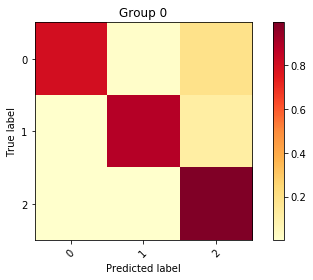

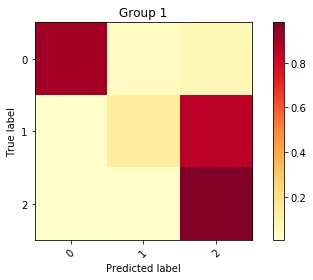

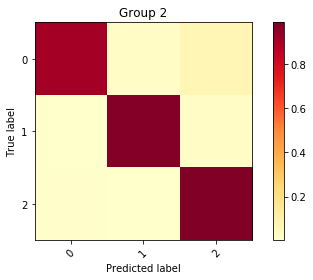

Inertia: 0.09038775088265538
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.531394   0.319756     0.891463  0.11895              0.942105
   1         1  0.155205   0.302014     0.672257  0.71769              0.744472
   2         2  0.313401   0.182315     0.958286  0.0431727            0.978625
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.904762      0.904762
====  ======  ==========  ============


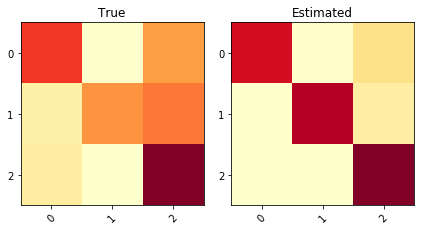

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


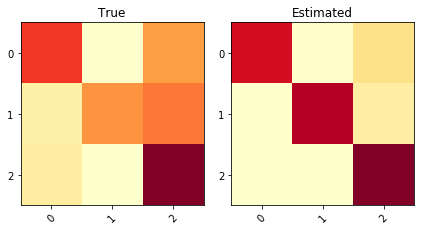

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


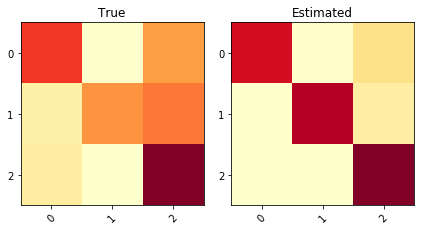

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


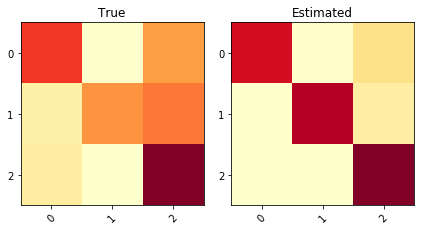

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


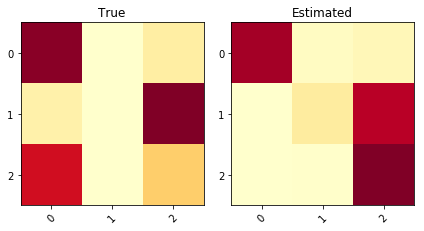

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653


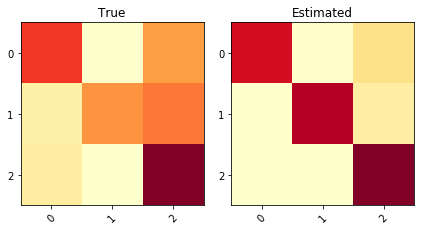

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


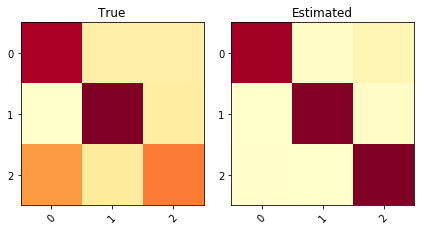

KL divergence: 0.6169	Pearson Correlation between diagonals: -0.4954


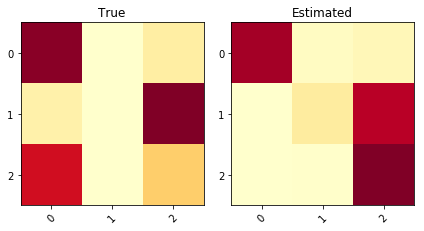

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653


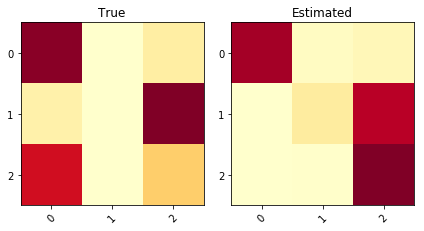

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653


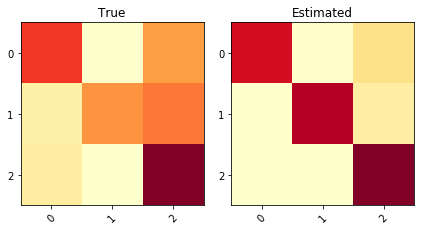

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


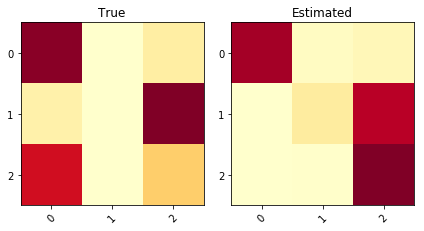

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653


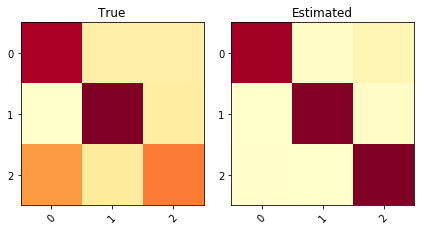

KL divergence: 0.6169	Pearson Correlation between diagonals: -0.4954


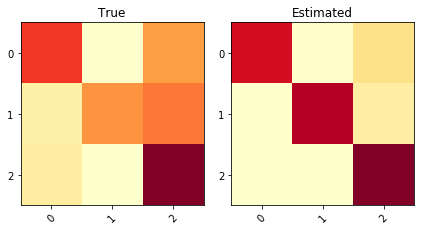

KL divergence: 0.3892	Pearson Correlation between diagonals: 0.6641


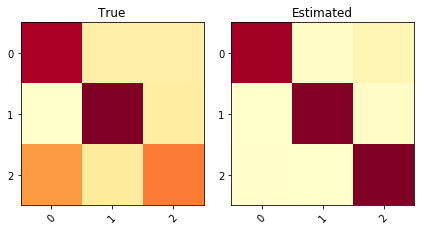

KL divergence: 0.6169	Pearson Correlation between diagonals: -0.4954


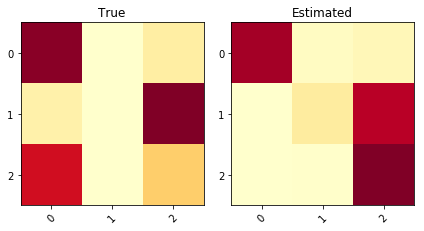

KL divergence: 1.0834	Pearson Correlation between diagonals: 0.6653
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.895808      0.895808         0.601               0.328088
====  ======  ==========  ============  ============  =====================
**********************************Average Normal**********************************
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.520156   0.402706     0.734198   0.768079            0.807866
   1         1  0.183374   0.302159     0.610063   1.22721             0.669592
   2         2  0.29647    0.275537     0.801024 

In [19]:
#con pre-entrenar 0
run_experiment(0) #funca bien con multiples runs (deja explorar mejor) -- escoje el peor con un bad MV

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 10.19 sec)	logL: -25369.074	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -25024.044	Tol1: 0.01360	Tol2: 0.15578	Tol3: 0.02598	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24784.224	Tol1: 0.00958	Tol2: 0.08865	Tol3: 0.00301	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24489.580	Tol1: 0.01189	Tol2: 0.08265	Tol3: 0.00517	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24129.274	Tol1: 0.01471	Tol2: 0.08693	Tol3: 0.00672	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23701.072	Tol1: 0.01775	Tol2: 0.09491	Tol3: 0.00742	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23220.884	Tol1: 0.02026	Tol2: 0.10750	Tol3: 0.00772	
Iter 8/50
M step:

M step: done,  E step: done //  (in 0.15 sec)	logL: -19969.948	Tol1: 0.00039	Tol2: 0.02577	Tol3: 0.00192	
Iter 35/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19960.031	Tol1: 0.00050	Tol2: 0.02511	Tol3: 0.00252	
Iter 36/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19956.487	Tol1: 0.00018	Tol2: 0.02366	Tol3: 0.00190	
Iter 37/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19951.946	Tol1: 0.00023	Tol2: 0.02167	Tol3: 0.00151	
Iter 38/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19945.052	Tol1: 0.00035	Tol2: 0.02179	Tol3: 0.00217	
Iter 39/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19938.950	Tol1: 0.00031	Tol2: 0.02107	Tol3: 0.00234	
Iter 40/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19939.147	Tol1: 0.00001	Tol2: 0.01966	Tol3: 0.00197	
Finished training!
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  

M step: done,  E step: done //  (in 0.16 sec)	logL: -20654.965	Tol1: 0.00524	Tol2: 0.05992	Tol3: 0.00630	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20560.035	Tol1: 0.00460	Tol2: 0.06274	Tol3: 0.00605	
Iter 24/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20474.967	Tol1: 0.00414	Tol2: 0.06383	Tol3: 0.00615	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20393.822	Tol1: 0.00396	Tol2: 0.06336	Tol3: 0.00582	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20322.361	Tol1: 0.00350	Tol2: 0.06214	Tol3: 0.00555	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20264.353	Tol1: 0.00285	Tol2: 0.06009	Tol3: 0.00538	
Iter 28/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20212.165	Tol1: 0.00258	Tol2: 0.05608	Tol3: 0.00500	
Iter 29/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20169.606	Tol1: 0.00211	Tol2: 0.05270	Tol3: 0.00472	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20132.568	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -24570.338	Tol1: 0.00826	Tol2: 0.05908	Tol3: 0.00247	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24359.010	Tol1: 0.00860	Tol2: 0.05791	Tol3: 0.00216	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24131.600	Tol1: 0.00934	Tol2: 0.06118	Tol3: 0.00232	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23887.695	Tol1: 0.01011	Tol2: 0.06844	Tol3: 0.00239	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23630.080	Tol1: 0.01078	Tol2: 0.07540	Tol3: 0.00226	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23348.594	Tol1: 0.01191	Tol2: 0.08202	Tol3: 0.00273	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23065.425	Tol1: 0.01213	Tol2: 0.08805	Tol3: 0.00291	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22769.361	Tol1: 0.01284	Tol2: 0.09235	Tol3: 0.00294	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22478.503	Tol

M step: done,  E step: done //  (in 0.19 sec)	logL: -26203.669	Tol1: 0.03637	Tol2: 0.29928	Tol3: 0.06947	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25944.927	Tol1: 0.00987	Tol2: 0.13361	Tol3: 0.01370	
Iter 4/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25758.591	Tol1: 0.00718	Tol2: 0.11111	Tol3: 0.00468	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -25593.346	Tol1: 0.00642	Tol2: 0.09004	Tol3: 0.00334	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25427.468	Tol1: 0.00648	Tol2: 0.07620	Tol3: 0.00346	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25246.441	Tol1: 0.00712	Tol2: 0.06809	Tol3: 0.00383	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25037.422	Tol1: 0.00828	Tol2: 0.06336	Tol3: 0.00428	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24785.244	Tol1: 0.01007	Tol2: 0.06661	Tol3: 0.00495	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24470.902	Tol1: 0.

M step: done,  E step: done //  (in 0.17 sec)	logL: -23784.434	Tol1: 0.01513	Tol2: 0.12920	Tol3: 0.00301	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23411.633	Tol1: 0.01567	Tol2: 0.11626	Tol3: 0.00280	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23037.398	Tol1: 0.01598	Tol2: 0.11202	Tol3: 0.00255	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22686.408	Tol1: 0.01524	Tol2: 0.11127	Tol3: 0.00248	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22374.992	Tol1: 0.01373	Tol2: 0.10977	Tol3: 0.00225	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22120.155	Tol1: 0.01139	Tol2: 0.10558	Tol3: 0.00203	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21907.759	Tol1: 0.00960	Tol2: 0.09814	Tol3: 0.00149	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21745.161	Tol1: 0.00742	Tol2: 0.08786	Tol3: 0.00123	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21619.972	Tol1: 0

M step: done,  E step: done //  (in 0.20 sec)	logL: -20246.707	Tol1: 0.00447	Tol2: 0.04516	Tol3: 0.00525	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20169.482	Tol1: 0.00381	Tol2: 0.04468	Tol3: 0.00491	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20108.477	Tol1: 0.00302	Tol2: 0.04385	Tol3: 0.00449	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20064.670	Tol1: 0.00218	Tol2: 0.03920	Tol3: 0.00380	
Iter 28/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20028.923	Tol1: 0.00178	Tol2: 0.03714	Tol3: 0.00349	
Iter 29/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20001.455	Tol1: 0.00137	Tol2: 0.03592	Tol3: 0.00277	
Iter 30/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -19984.824	Tol1: 0.00083	Tol2: 0.03374	Tol3: 0.00185	
Iter 31/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19967.152	Tol1: 0.00088	Tol2: 0.03453	Tol3: 0.00278	
Iter 32/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19957.503	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -23187.070	Tol1: 0.01540	Tol2: 0.11393	Tol3: 0.00481	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22798.239	Tol1: 0.01677	Tol2: 0.11917	Tol3: 0.00546	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22388.331	Tol1: 0.01798	Tol2: 0.12298	Tol3: 0.00642	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21986.730	Tol1: 0.01794	Tol2: 0.12378	Tol3: 0.00692	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21613.108	Tol1: 0.01699	Tol2: 0.12065	Tol3: 0.00733	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21296.438	Tol1: 0.01465	Tol2: 0.11277	Tol3: 0.00720	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21023.177	Tol1: 0.01283	Tol2: 0.10251	Tol3: 0.00698	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20808.420	Tol1: 0.01022	Tol2: 0.08905	Tol3: 0.00596	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20641.409	Tol1

M step: done,  E step: done //  (in 0.16 sec)	logL: -20593.301	Tol1: 0.00310	Tol2: 0.02460	Tol3: 0.00026	
Iter 18/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20539.980	Tol1: 0.00259	Tol2: 0.02165	Tol3: 0.00072	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20484.120	Tol1: 0.00272	Tol2: 0.01960	Tol3: 0.00110	
Finished training!
Initializing new EM...
Pre-train network on 1 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 12.51 sec)	logL: -26638.971	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -25885.647	Tol1: 0.02828	Tol2: 0.26041	Tol3: 0.03626	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25450.252	Tol1: 0.01682	Tol2: 0.17119	Tol3: 0.01090	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25104.292	Tol1: 0.01359	Tol2: 0.13902	Tol3: 0.00889	
Iter 5/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.17 sec)	logL: -20205.936	Tol1: 0.00188	Tol2: 0.04254	Tol3: 0.00311	
Iter 37/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20178.747	Tol1: 0.00135	Tol2: 0.03933	Tol3: 0.00324	
Iter 38/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20153.447	Tol1: 0.00125	Tol2: 0.03577	Tol3: 0.00301	
Iter 39/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20126.227	Tol1: 0.00135	Tol2: 0.03309	Tol3: 0.00346	
Iter 40/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20095.706	Tol1: 0.00152	Tol2: 0.03005	Tol3: 0.00325	
Iter 41/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20070.265	Tol1: 0.00127	Tol2: 0.02754	Tol3: 0.00323	
Iter 42/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20048.334	Tol1: 0.00109	Tol2: 0.02500	Tol3: 0.00322	
Iter 43/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20032.313	Tol1: 0.00080	Tol2: 0.02239	Tol3: 0.00271	
Iter 44/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20015.631	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -19996.398	Tol1: 0.00086	Tol2: 0.02294	Tol3: 0.00143	
Iter 38/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19981.455	Tol1: 0.00075	Tol2: 0.02250	Tol3: 0.00118	
Iter 39/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19969.723	Tol1: 0.00059	Tol2: 0.02230	Tol3: 0.00136	
Iter 40/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19960.252	Tol1: 0.00047	Tol2: 0.02089	Tol3: 0.00068	
Iter 41/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19946.166	Tol1: 0.00071	Tol2: 0.02042	Tol3: 0.00123	
Iter 42/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19937.382	Tol1: 0.00044	Tol2: 0.02091	Tol3: 0.00115	
Iter 43/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19932.962	Tol1: 0.00022	Tol2: 0.01914	Tol3: 0.00049	
Finished training!
**********************************MULTIPLES RUNS**********************************


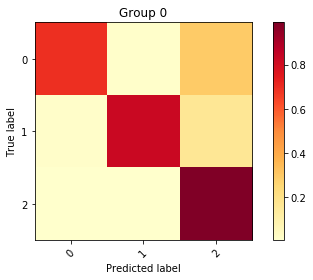

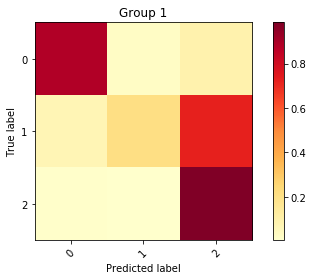

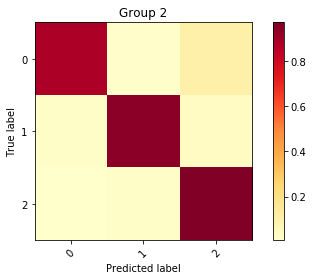

Inertia: 0.0704279625788331
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.533927   0.408676     0.837077  0.188519             0.909823
   1         1  0.177578   0.417015     0.69248   0.569308             0.777471
   2         2  0.288496   0.270643     0.932194  0.0710499            0.96495
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.813187      0.813187
====  ======  ==========  ============


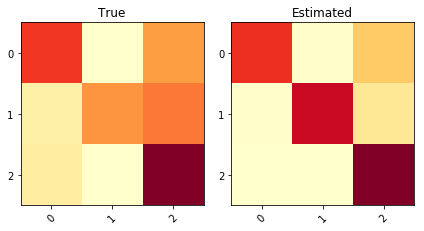

KL divergence: 0.2426	Pearson Correlation between diagonals: 0.6555


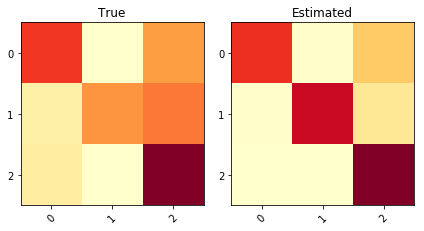

KL divergence: 0.2426	Pearson Correlation between diagonals: 0.6555


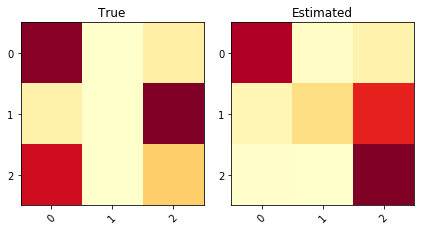

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


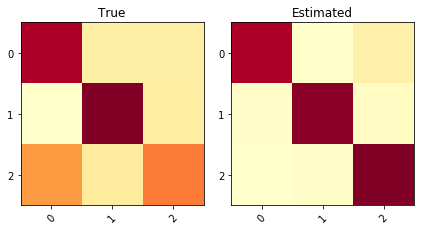

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


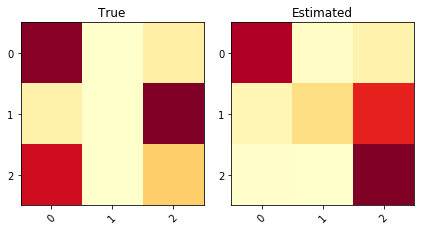

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


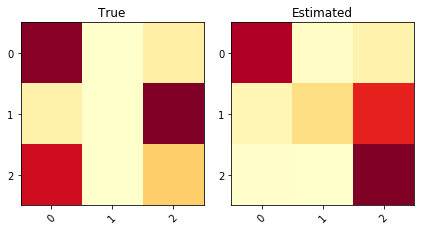

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


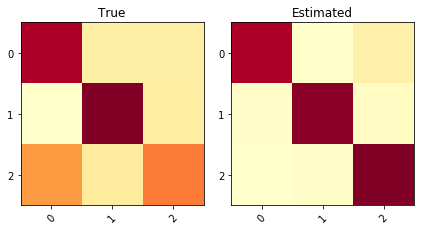

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


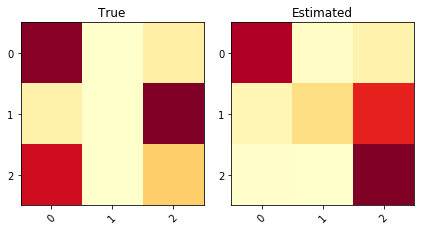

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


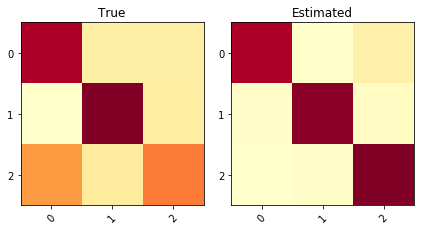

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


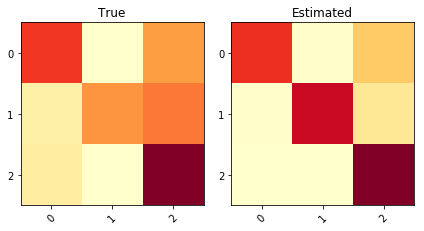

KL divergence: 0.2426	Pearson Correlation between diagonals: 0.6555


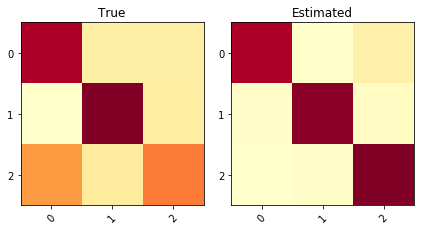

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


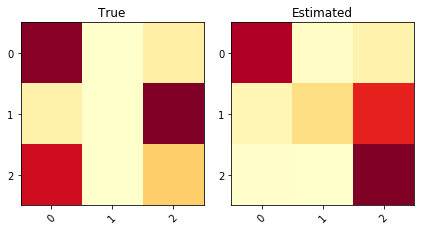

KL divergence: 1.0525	Pearson Correlation between diagonals: 0.6346


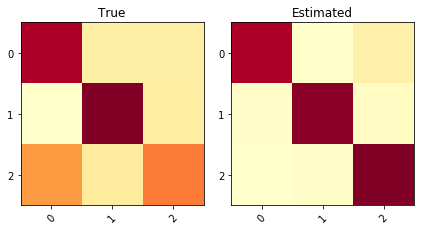

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


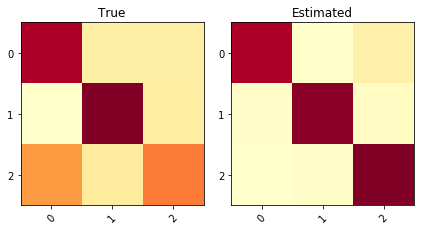

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605


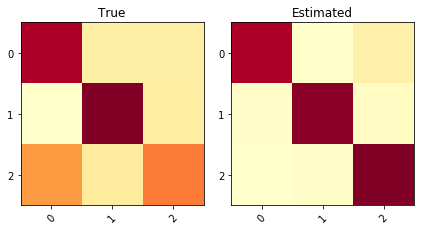

KL divergence: 0.5436	Pearson Correlation between diagonals: -0.5605
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.800163      0.800163      0.499979               0.298458
====  ======  ==========  ============  ============  =====================
**********************************Average Normal**********************************
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.520388   0.416704     0.76526    0.638699            0.838222
   1         1  0.181608   0.316919     0.643385   1.10452             0.701371
   2         2  0.298004   0.295113     0.817652

In [20]:
#con pre-entrenar 1
run_experiment(1) #escoje el peor con un bad MV-- escoge bien en multiples runs

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 13.52 sec)	logL: -23978.464	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23540.115	Tol1: 0.01828	Tol2: 0.19418	Tol3: 0.00884	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23151.531	Tol1: 0.01651	Tol2: 0.16373	Tol3: 0.00442	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22769.132	Tol1: 0.01652	Tol2: 0.14960	Tol3: 0.00600	
Iter 5/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22401.836	Tol1: 0.01613	Tol2: 0.14217	Tol3: 0.00654	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22055.937	Tol1: 0.01544	Tol2: 0.13588	Tol3: 0.00620	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21743.598	Tol1: 0.01416	Tol2: 0.13028	Tol3: 0.00609	
Iter 8/50
M step:

M step: done,  E step: done //  (in 0.17 sec)	logL: -20096.081	Tol1: 0.00051	Tol2: 0.04648	Tol3: 0.00201	
Iter 23/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20082.867	Tol1: 0.00066	Tol2: 0.04324	Tol3: 0.00167	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20069.154	Tol1: 0.00068	Tol2: 0.04235	Tol3: 0.00240	
Iter 25/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20060.502	Tol1: 0.00043	Tol2: 0.04026	Tol3: 0.00221	
Iter 26/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20053.407	Tol1: 0.00035	Tol2: 0.03710	Tol3: 0.00216	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20043.329	Tol1: 0.00050	Tol2: 0.03535	Tol3: 0.00206	
Iter 28/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20038.924	Tol1: 0.00022	Tol2: 0.03407	Tol3: 0.00247	
Iter 29/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20031.928	Tol1: 0.00035	Tol2: 0.03144	Tol3: 0.00253	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20028.801	T

M step: done,  E step: done //  (in 0.26 sec)	logL: -20404.433	Tol1: 0.00455	Tol2: 0.04794	Tol3: 0.00189	
Iter 17/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20331.600	Tol1: 0.00357	Tol2: 0.04608	Tol3: 0.00147	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20271.073	Tol1: 0.00298	Tol2: 0.04728	Tol3: 0.00158	
Iter 19/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20219.112	Tol1: 0.00256	Tol2: 0.04759	Tol3: 0.00107	
Iter 20/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20174.608	Tol1: 0.00220	Tol2: 0.04756	Tol3: 0.00153	
Iter 21/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20140.778	Tol1: 0.00168	Tol2: 0.04670	Tol3: 0.00139	
Iter 22/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20113.550	Tol1: 0.00135	Tol2: 0.04451	Tol3: 0.00129	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20090.146	Tol1: 0.00116	Tol2: 0.04227	Tol3: 0.00068	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20073.161	T

Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 14.04 sec)	logL: -25573.488	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -25088.909	Tol1: 0.01895	Tol2: 0.20012	Tol3: 0.04158	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24791.258	Tol1: 0.01186	Tol2: 0.11051	Tol3: 0.00841	
Iter 4/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24468.345	Tol1: 0.01303	Tol2: 0.08728	Tol3: 0.00316	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24108.677	Tol1: 0.01470	Tol2: 0.08333	Tol3: 0.00162	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23703.824	Tol1: 0.01679	Tol2: 0.08860	Tol3: 0.00074	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23284.987	Tol1: 0.01767	Tol2: 0.09794	Tol3: 0.00088	
Iter 8/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22872.505	Tol1: 0

M step: done,  E step: done //  (in 0.17 sec)	logL: -20357.343	Tol1: 0.00409	Tol2: 0.05485	Tol3: 0.00418	
Iter 20/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20286.111	Tol1: 0.00350	Tol2: 0.05642	Tol3: 0.00379	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20235.968	Tol1: 0.00247	Tol2: 0.05779	Tol3: 0.00336	
Iter 22/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20191.304	Tol1: 0.00221	Tol2: 0.05756	Tol3: 0.00305	
Iter 23/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20153.798	Tol1: 0.00186	Tol2: 0.05547	Tol3: 0.00289	
Iter 24/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20117.401	Tol1: 0.00181	Tol2: 0.05281	Tol3: 0.00273	
Iter 25/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20083.383	Tol1: 0.00169	Tol2: 0.05082	Tol3: 0.00307	
Iter 26/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20057.383	Tol1: 0.00129	Tol2: 0.04690	Tol3: 0.00256	
Iter 27/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20036.511	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -23562.403	Tol1: 0.01709	Tol2: 0.09747	Tol3: 0.00178	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23127.330	Tol1: 0.01846	Tol2: 0.10369	Tol3: 0.00156	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22695.728	Tol1: 0.01866	Tol2: 0.11080	Tol3: 0.00150	
Iter 8/50
M step: done,  E step: done //  (in 0.42 sec)	logL: -22289.551	Tol1: 0.01790	Tol2: 0.11476	Tol3: 0.00149	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21907.359	Tol1: 0.01715	Tol2: 0.11431	Tol3: 0.00157	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21579.789	Tol1: 0.01495	Tol2: 0.11019	Tol3: 0.00164	
Iter 11/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21308.227	Tol1: 0.01258	Tol2: 0.10091	Tol3: 0.00171	
Iter 12/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21090.212	Tol1: 0.01023	Tol2: 0.08790	Tol3: 0.00170	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20925.364	Tol1:

M step: done,  E step: done //  (in 0.17 sec)	logL: -20004.903	Tol1: 0.00058	Tol2: 0.03033	Tol3: 0.00314	
Iter 31/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19996.604	Tol1: 0.00041	Tol2: 0.02918	Tol3: 0.00396	
Iter 32/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19992.138	Tol1: 0.00022	Tol2: 0.02639	Tol3: 0.00321	
Iter 33/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19983.588	Tol1: 0.00043	Tol2: 0.02517	Tol3: 0.00324	
Iter 34/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19977.123	Tol1: 0.00032	Tol2: 0.02281	Tol3: 0.00245	
Iter 35/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19973.422	Tol1: 0.00019	Tol2: 0.02215	Tol3: 0.00195	
Iter 36/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19969.630	Tol1: 0.00019	Tol2: 0.02138	Tol3: 0.00198	
Iter 37/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19963.299	Tol1: 0.00032	Tol2: 0.02217	Tol3: 0.00304	
Iter 38/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19951.931	T

M step: done,  E step: done //  (in 0.19 sec)	logL: -19924.196	Tol1: 0.00034	Tol2: 0.02704	Tol3: 0.00031	
Iter 34/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19920.923	Tol1: 0.00016	Tol2: 0.02522	Tol3: 0.00043	
Iter 35/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19920.540	Tol1: 0.00002	Tol2: 0.02232	Tol3: 0.00034	
Iter 36/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19918.606	Tol1: 0.00010	Tol2: 0.02092	Tol3: 0.00028	
Iter 37/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19915.935	Tol1: 0.00013	Tol2: 0.01970	Tol3: 0.00065	
Finished training!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 17.05 sec)	logL: -23416.086	
Iter 2/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22879.423	Tol1: 0.02292	Tol2: 0.21589	Tol3: 0.01347	
Iter 3/50
M step: done,  E step: done //  (i

M step: done,  E step: done //  (in 0.17 sec)	logL: -20120.570	Tol1: 0.00135	Tol2: 0.03560	Tol3: 0.00191	
Iter 20/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20100.806	Tol1: 0.00098	Tol2: 0.03536	Tol3: 0.00275	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20079.289	Tol1: 0.00107	Tol2: 0.03448	Tol3: 0.00332	
Iter 22/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20066.843	Tol1: 0.00062	Tol2: 0.03360	Tol3: 0.00359	
Iter 23/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20056.029	Tol1: 0.00054	Tol2: 0.03242	Tol3: 0.00494	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20040.214	Tol1: 0.00079	Tol2: 0.03166	Tol3: 0.00409	
Iter 25/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20027.835	Tol1: 0.00062	Tol2: 0.02948	Tol3: 0.00365	
Iter 26/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20016.199	Tol1: 0.00058	Tol2: 0.02874	Tol3: 0.00389	
Iter 27/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20009.008	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -20297.929	Tol1: 0.00289	Tol2: 0.04108	Tol3: 0.00433	
Iter 17/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20254.487	Tol1: 0.00214	Tol2: 0.03869	Tol3: 0.00433	
Iter 18/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20220.091	Tol1: 0.00170	Tol2: 0.03622	Tol3: 0.00431	
Iter 19/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20186.398	Tol1: 0.00167	Tol2: 0.03467	Tol3: 0.00487	
Iter 20/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20152.778	Tol1: 0.00167	Tol2: 0.03315	Tol3: 0.00424	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20128.731	Tol1: 0.00119	Tol2: 0.03314	Tol3: 0.00381	
Iter 22/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20107.154	Tol1: 0.00107	Tol2: 0.03275	Tol3: 0.00419	
Iter 23/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20085.981	Tol1: 0.00105	Tol2: 0.03024	Tol3: 0.00425	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20071.831	T

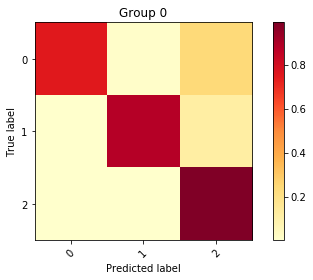

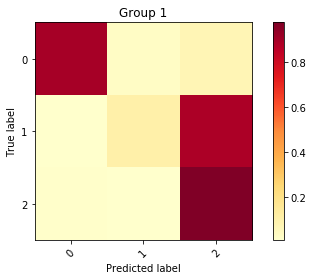

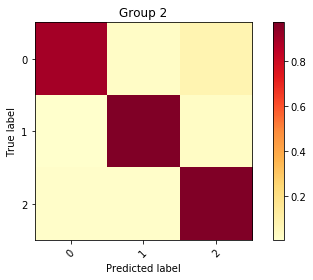

Inertia: 0.09854878578335047
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.538675   0.344538     0.874593  0.140489             0.932098
   1         1  0.163136   0.293304     0.660476  0.800262             0.728018
   2         2  0.298189   0.216458     0.94904   0.0529356            0.973819
====  ========  ========  =========  ===========  =========  ==================
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.888889      0.888889
====  ======  ==========  ============


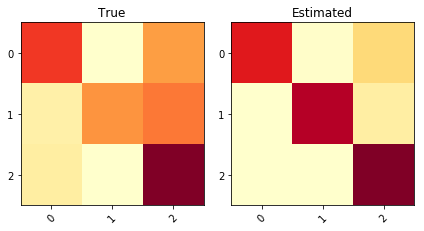

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


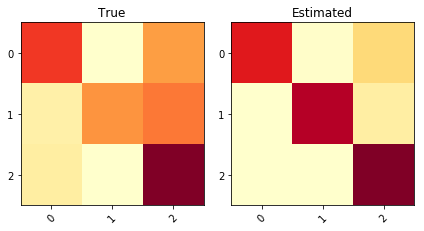

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


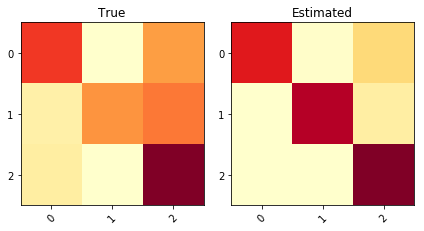

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


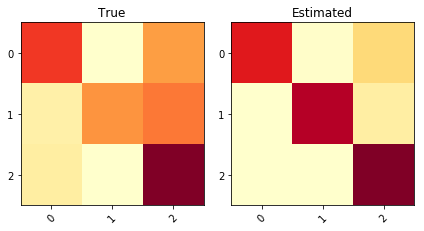

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


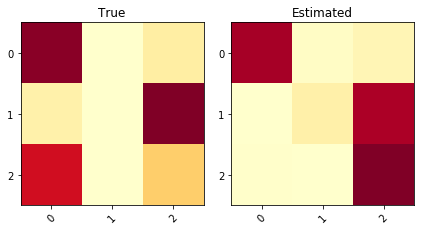

KL divergence: 0.9452	Pearson Correlation between diagonals: 0.6664


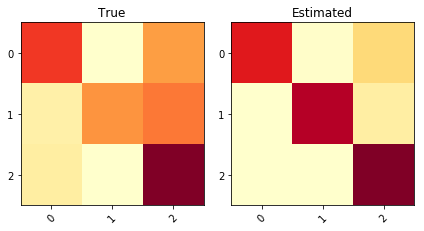

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634


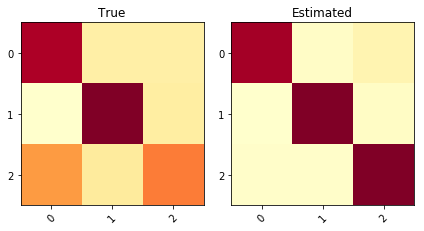

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


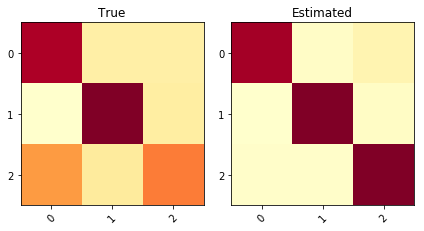

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


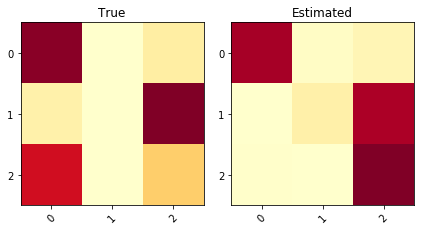

KL divergence: 0.9452	Pearson Correlation between diagonals: 0.6664


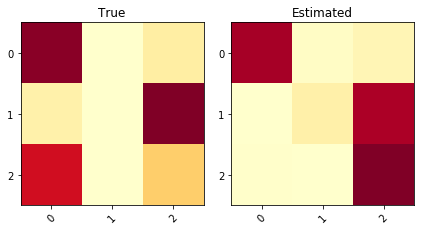

KL divergence: 0.9452	Pearson Correlation between diagonals: 0.6664


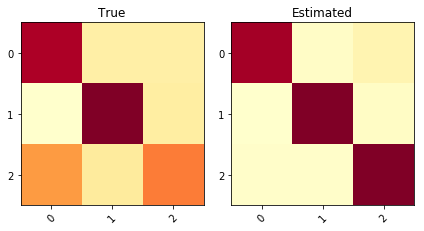

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


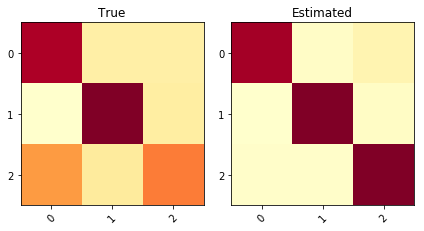

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


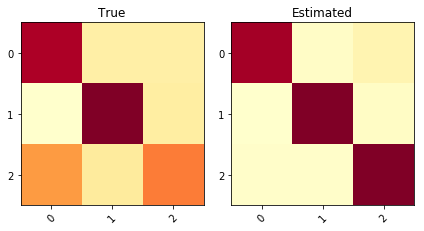

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


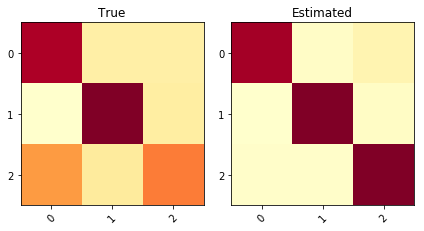

KL divergence: 0.4948	Pearson Correlation between diagonals: -0.3515


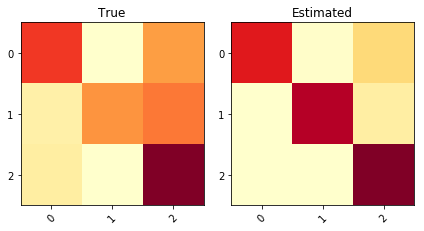

KL divergence: 0.3474	Pearson Correlation between diagonals: 0.5634
A result
 ====  ======  ==========  ============  ============  =====================
  ..            Accuracy    F1 (micro)    Average KL    Average PearsonCorr
====  ======  ==========  ============  ============  =====================
   0  Global    0.883598      0.883598      0.515672               0.319719
====  ======  ==========  ============  ============  =====================
**********************************Average Normal**********************************
A result
 ====  ========  ========  =========  ===========  =========  ==================
  ..    Groups      Prob    Entropy    Diag Mean    KL to I    I similar % (JS)
====  ========  ========  =========  ===========  =========  ==================
   0         0  0.529088   0.341108     0.866868  0.159141             0.92495
   1         1  0.175087   0.298373     0.658474  0.921669             0.718301
   2         2  0.295825   0.234557     0.940665  

In [21]:
#con pre-entrenar 5
run_experiment(5) #funca relativamente bien en average normal. en multiples runs anda parecido

Conclu de mini experimento:
* Si se ejecuta normal necesario un buen init (pre entrenar 5)
* Si se ejecuta con multiples runs no es tann necesario un buen init (pre entrenar con 1 para que explore más)

In [40]:
%%time
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Alphas:  (10,)
MV init:  (2700, 3)
Betas:  (10, 3, 3)
Q estimate:  (2700, 3, 10, 3)
Iter 1/25
M step: done	E step: done, (in 2.41 sec)	logL: -85843.819	F1: 0.7442
Iter 2/25
M step: done	E step: done, (in 2.47 sec)	logL: -83639.140	Tol: 0.02568	F1: 0.7286
Iter 3/25
M step: done	E step: done, (in 2.33 sec)	logL: -82040.527	Tol: 0.01911	F1: 0.7178
Iter 4/25
M step: done	E step: done, (in 2.31 sec)	logL: -81027.269	Tol: 0.01235	F1: 0.7117
Iter 5/25
M step: done	E step: done, (in 2.37 sec)	logL: -80444.867	Tol: 0.00719	F1: 0.7142
Iter 6/25
M step: done	E step: done, (in 2.39 sec)	logL: -80116.539	Tol: 0.00408	F1: 0.7248
Iter 7/25
M step: done	E step: done, (in 2.43 sec)	logL: -79915.121	Tol: 0.00251	F1: 0.7397
Iter 8/25
M step: done	E step: done, (in 2.43 sec)	logL: -79781.112	Tol: 0.00168	F1: 0.7502
Iter 9/25
M step: done	E step: done, (in 2.42 sec)	logL: -79677

In [143]:
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=7,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',256,2)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [0.40107749624626565, 0.6643001499237149, 0.5331640955460885, 0.1617082682059309, 0.46440295869359777, 0.3517687543555905, 0.7898108127238789]
Alphas:  (2700, 7)
MV init:  (2700, 3)
Betas:  (7, 3, 3)
Q estimate:  (2700, 3, 7, 3)
Iter 1/25
M step: done	E step: done, (in 1.96 sec)	logL: -80827.414	
Iter 2/25
M step: done	E step: done, (in 1.88 sec)	logL: -80249.518	Tol: 0.00715	
Iter 3/25
M step: done	E step: done, (in 1.90 sec)	logL: -79907.925	Tol: 0.00426	
Iter 4/25
M step: done	E step: done, (in 1.90 sec)	logL: -79695.919	Tol: 0.00265	
Iter 5/25
M step: done	E step: done, (in 1.90 sec)	logL: -79573.557	Tol: 0.00154	
Iter 6/25
M step: done	E step: done, (in 1.92 sec)	logL: -79498.354	Tol: 0.00095	
Iter 7/25
M step: done	E step: done, (in 1.89 sec)	logL: -79452.646	Tol: 0.00057	
Iter 8/25
M step: done	E step: done, (in 1.90 sec)	logL: -79421.224	Tol: 0.00040	
Iter 9/25
M step: done	E step:

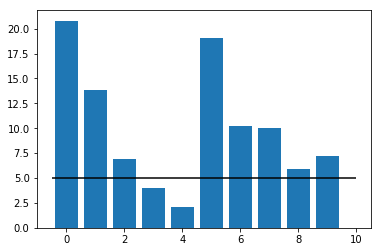

In [63]:
plt.bar(np.arange(M),gMixture.get_alpha()*100)
plt.hlines(5,-0.5,M) #treshold en Numero de anotadores x grupo--quizas no sirva...
#que pasa si hay un grupo que tiene 5 anotadores y otro que tiene 10 pero se comparte con otro que tiene 1?
#sirve para tener una idea general de cuantos anotadores x grupo hay

In [69]:
### comparar resultados con mas grupos o menos grupos
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=2,epochs=1,optimizer=OPT)
gMixture.define_model('keras_shallow')
#gMixture.define_model('mlp',16,1)
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Alphas:  (10,)
MV init:  (2700, 3)
Betas:  (10, 3, 3)
Q estimate:  (2700, 3, 10, 3)
Iter 1/25
M step: done	E step: done, (in 2.50 sec)	logL: -84431.118	F1: 0.8277
Iter 2/25
M step: done	E step: done, (in 2.49 sec)	logL: -82027.963	Tol: 0.02846	F1: 0.8218
Iter 3/25
M step: done	E step: done, (in 2.42 sec)	logL: -80732.001	Tol: 0.01580	F1: 0.8196
Iter 4/25
M step: done	E step: done, (in 2.41 sec)	logL: -80087.666	Tol: 0.00798	F1: 0.8191
Iter 5/25
M step: done	E step: done, (in 2.36 sec)	logL: -79755.607	Tol: 0.00415	F1: 0.8215
Iter 6/25
M step: done	E step: done, (in 2.40 sec)	logL: -79562.342	Tol: 0.00242	F1: 0.8249
Iter 7/25
M step: done	E step: done, (in 2.41 sec)	logL: -79413.819	Tol: 0.00187	F1: 0.8332
Iter 8/25
M step: done	E step: done, (in 2.39 sec)	logL: -79296.041	Tol: 0.00148	F1: 0.8391
Iter 9/25
M step: done	E step: done, (in 2.36 sec)	logL: -79187

In [68]:
#and multiples runs
gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=2,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',16,1)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

gMixture = GroupMixture(X_train.shape[1:],Kl=r_obs.shape[1],M=10,epochs=1,optimizer=OPT,)
#gMixture.define_model('mlp',16,1)
gMixture.define_model('keras_shallow')
logL_hist = gMixture.multiples_run(5,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])
print(report_results(gMixture.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[]))

Clustering Done!
Initializing new EM...
Pre-train network on 30 epochs... Done!
Lambda by group:  [0.00738633966784168, 0.033873725693389055]
Alphas:  (2,)
MV init:  (2700, 3)
Betas:  (2, 3, 3)
Q estimate:  (2700, 3, 2, 3)
Iter 1/25
M step: done	E step: done, (in 1.03 sec)	logL: -84088.130	
Iter 2/25
M step: done	E step: done, (in 1.23 sec)	logL: -82295.538	Tol: 0.02132	
Iter 3/25
M step: done	E step: done, (in 1.01 sec)	logL: -81493.772	Tol: 0.00974	
Iter 4/25
M step: done	E step: done, (in 1.05 sec)	logL: -81109.277	Tol: 0.00472	
Iter 5/25
M step: done	E step: done, (in 1.08 sec)	logL: -80929.009	Tol: 0.00222	
Iter 6/25
M step: done	E step: done, (in 1.05 sec)	logL: -80839.120	Tol: 0.00111	
Iter 7/25
M step: done	E step: done, (in 1.00 sec)	logL: -80784.744	Tol: 0.00067	
Iter 8/25
M step: done	E step: done, (in 0.98 sec)	logL: -80757.410	Tol: 0.00034	
Iter 9/25
M step: done	E step: done, (in 0.99 sec)	logL: -80739.910	Tol: 0.00022	
Finished training!
Initializing new EM...
Pre-train 

In [56]:
groups_annot_pred = np.argmax(prob_Gt,axis=1)
print(groups_annot_pred)
print(set(groups_annot_pred)) #revisar fast el numero de grupos utilizados...

[2 2 1 2 0 2 2 0 0 1 0 1 2 2 0 0 0 0 1 1 0 1 0 2 0 2 2 2 0 0 2 2 1 2 2 1 1
 1 0 2 1 2 0 0 1 0 1 0 1 0 0 2 1 2 2 0 0 1 1 2 1 0 1 2 2 0 2 0 2 0 0 2 2 0
 2 1 0 2 1 2 0 2 0 1 2 0 0 0 2 0 1 0 0 0 2 0 1 0 0 0]
{0, 1, 2}
CPU times: user 32.9 s, sys: 635 ms, total: 33.6 s
Wall time: 33 s


In [41]:
#obtain p(y^o|x,g=m)
gMixture.get_predictions_group(1,Xstd_train) #puedo medir acc con eso

array([[0.22092701, 0.66987641, 0.10919658],
       [0.18366501, 0.769683  , 0.04665199],
       [0.36506755, 0.28602405, 0.34890843],
       ...,
       [0.18930534, 0.75472514, 0.0559695 ],
       [0.33724762, 0.3600254 , 0.30272705],
       [0.44818453, 0.03039722, 0.5214183 ]])

In [36]:
gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,optimizer=OPT,pre_init=5)
#gMixture.define_model("mlp",16,2)
gMixture.define_model("default cnn")
logL_hist = gMixture.stable_train(Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca])

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Nan Solved!
Clustering Done!
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (50000, 10)
Betas:  (3, 10, 10)
Q estimate:  (50000, 10, 3, 10)
Iter 1/50
M step: done	E step: done, (in 72.82 sec)	logL: -2715965.263	F1: 0.6261
Iter 2/50
M step:

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 done	E step: done, (in 70.89 sec)	logL: -2679319.023	Tol: 0.01349	F1: 0.6246
Iter 3/50
M step: done	E step: done, (in 71.24 sec)	logL: -2637561.656	Tol: 0.01559	F1: 0.6541
Iter 4/50
M step: done	E step: done, (in 73.48 sec)	logL: -2620187.453	Tol: 0.00659	F1: 0.6679
Iter 5/50
M step: done	E step: done, (in 72.33 sec)	logL: -2608219.150	Tol: 0.00457	F1: 0.6693
Iter 6/50
M step: done	E step: done, (in 71.42 sec)	logL: -2592777.869	Tol: 0.00592	F1: 0.6812
Iter 7/50
M step: done	E step: done, (in 71.17 sec)	logL: -2581476.336	Tol: 0.00436	F1: 0.6877
Iter 8/50
M step: done	E step: done, (in 71.09 sec)	logL: -2576276.410	Tol: 0.00201	F1: 0.6841
Iter 9/50
M step: done	E step: done, (in 72.50 sec)	logL: -2566063.387	Tol: 0.00396	F1: 0.6931
Iter 10/50
M step: done	E step: done, (in 70.87 sec)	logL: -2562741.495	Tol: 0.00129	F1: 0.6959
Iter 11/50
M step: done	E step: done, (in 70.85 sec)	logL: -2559842.885	Tol: 0.00113	F1: 0.6933
Iter 12/50
M step: done	E step: done, (in 71.25 sec)	logL: -25533

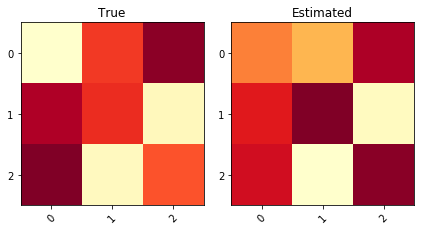

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


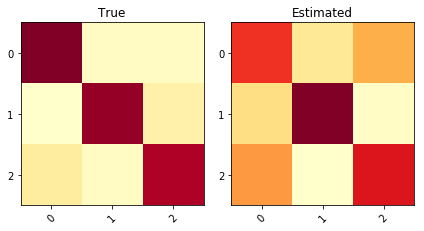

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


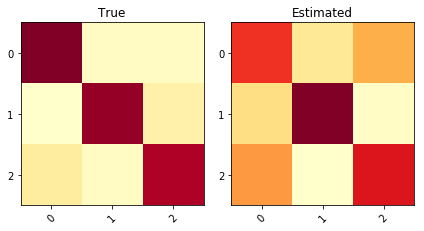

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


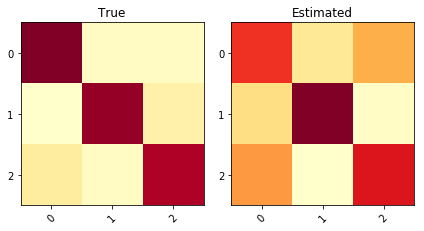

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


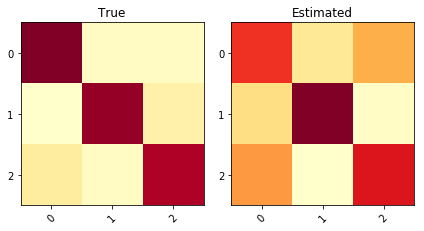

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


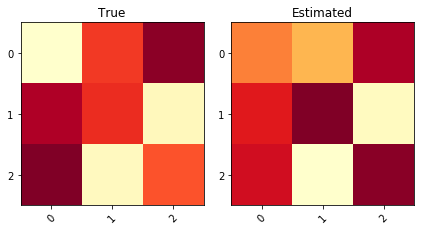

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


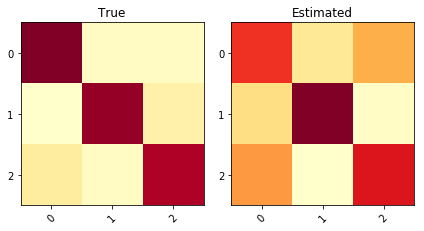

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


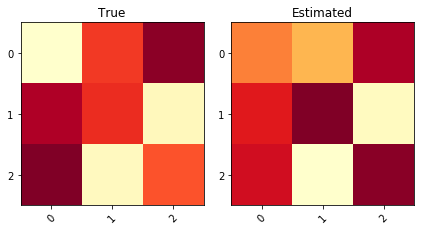

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


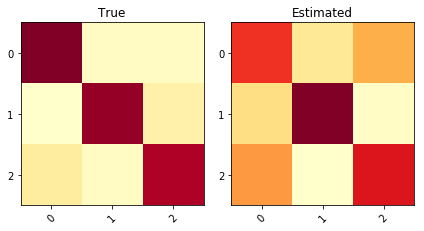

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


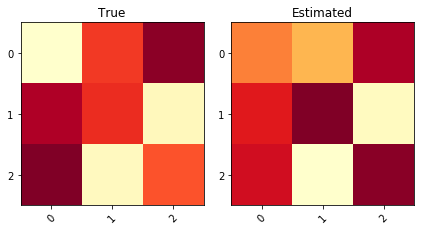

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


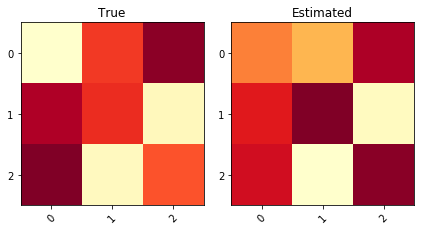

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


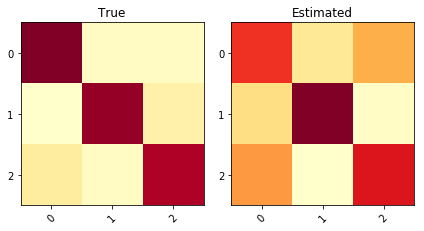

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


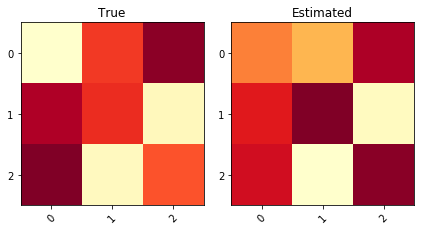

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


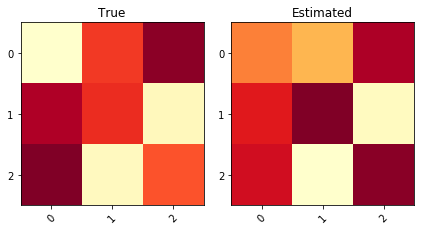

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


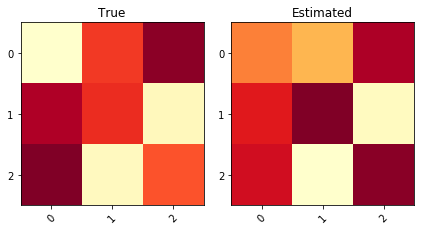

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


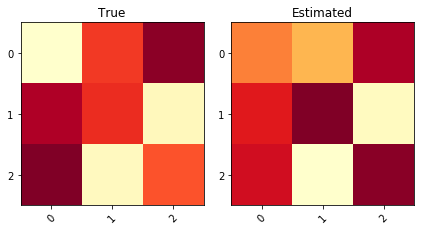

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


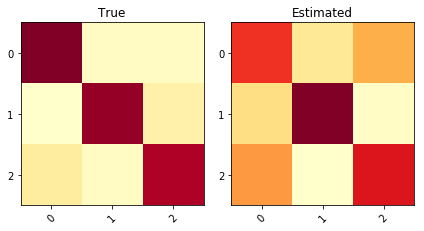

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


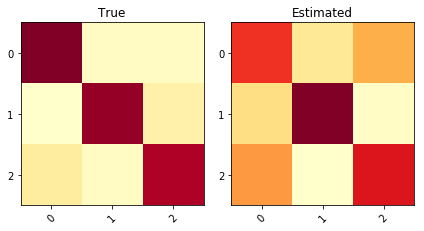

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


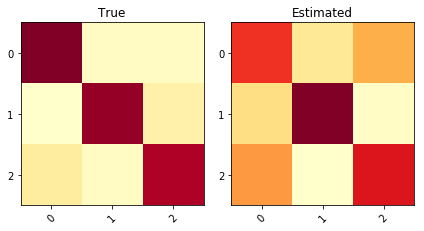

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


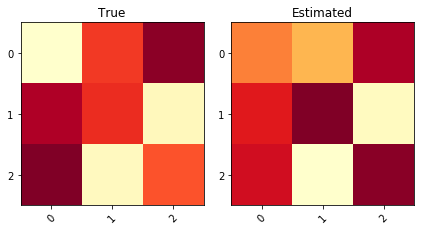

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


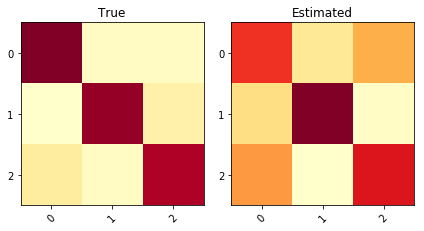

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


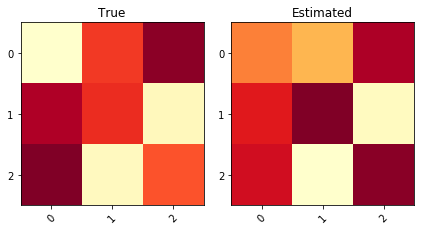

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


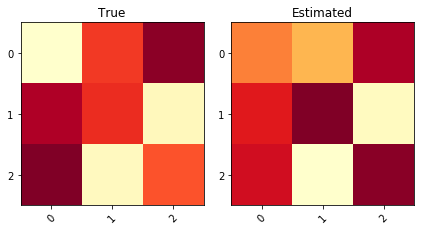

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


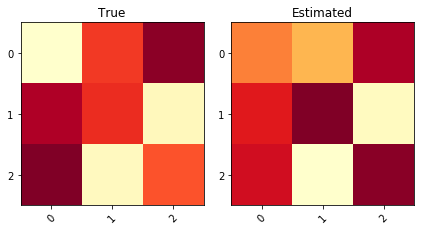

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


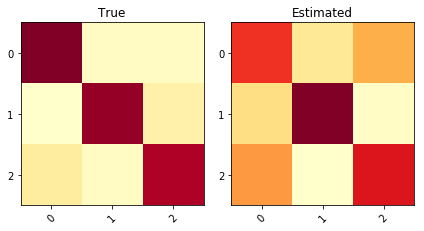

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


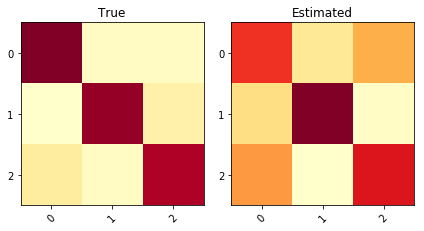

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


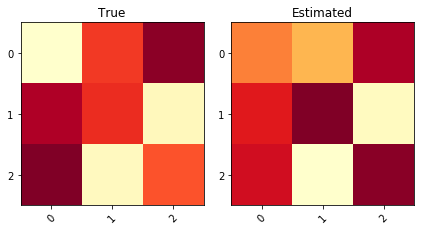

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


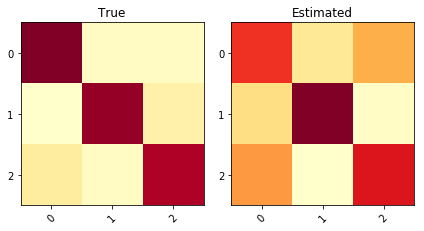

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


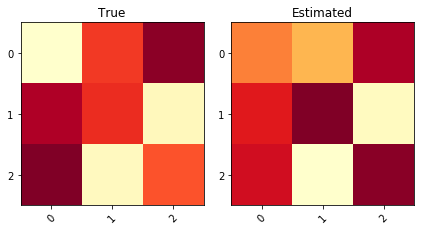

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


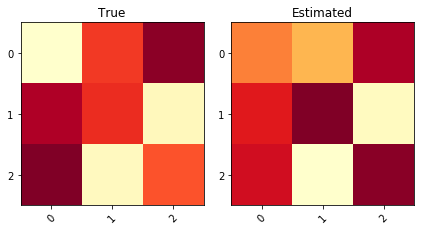

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


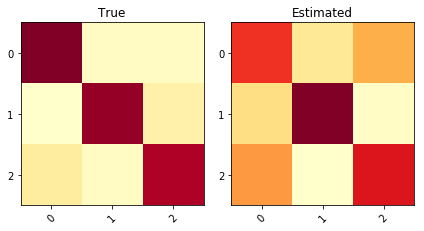

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


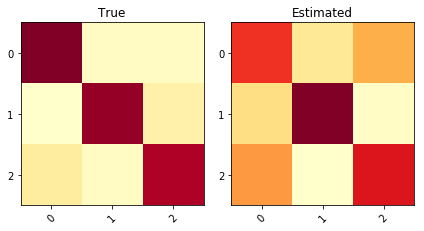

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


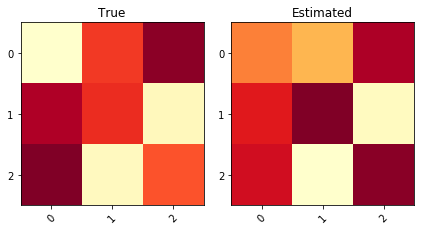

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


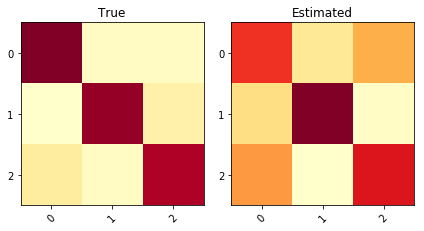

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


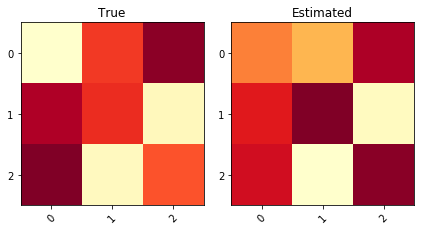

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


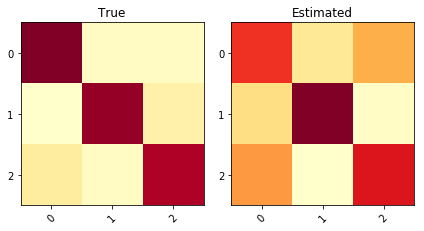

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


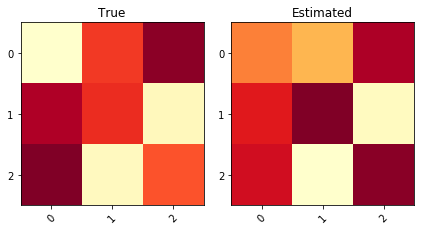

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


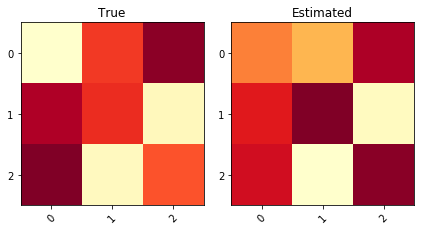

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


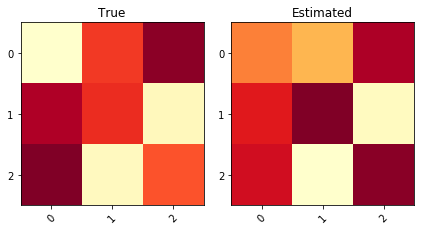

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


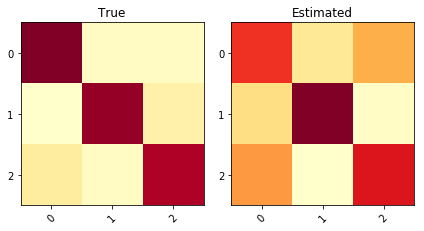

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


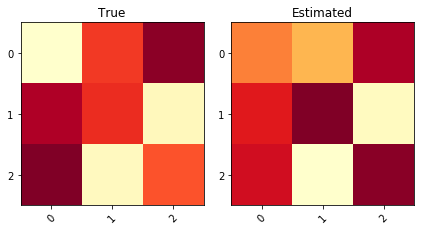

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


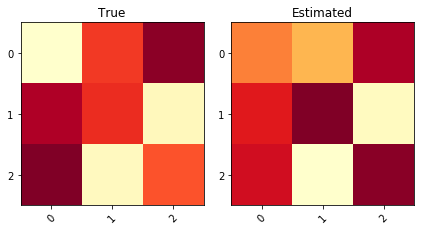

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


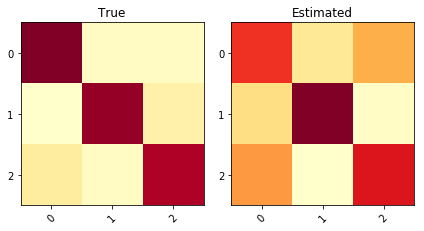

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


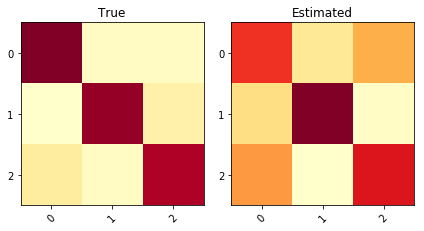

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


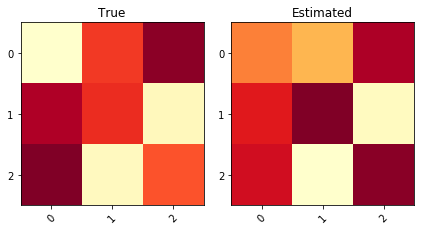

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


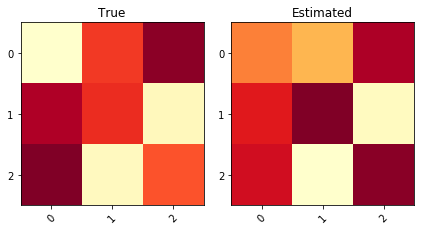

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


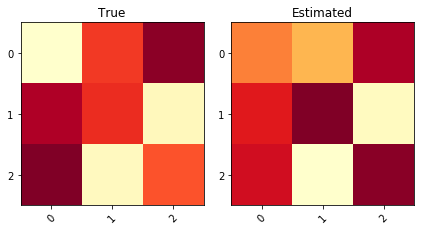

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


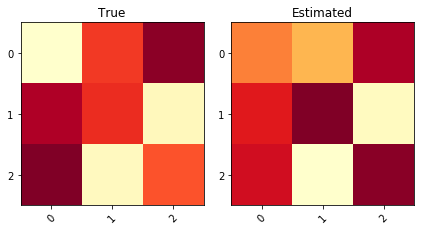

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


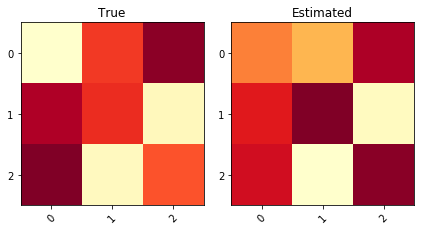

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


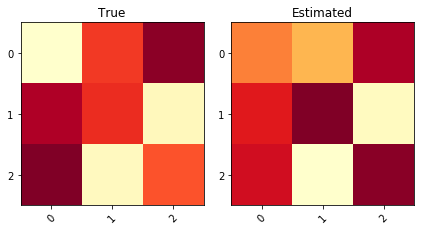

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


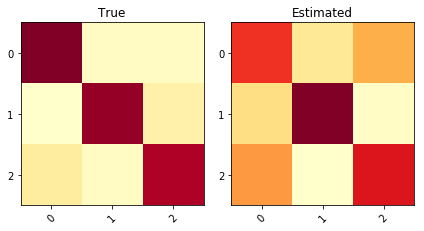

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


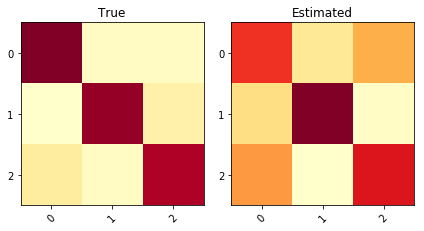

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


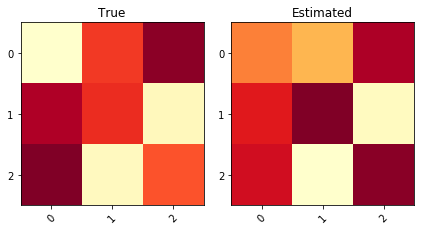

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


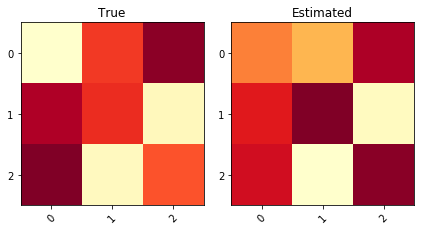

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


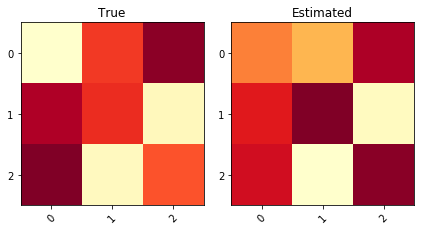

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


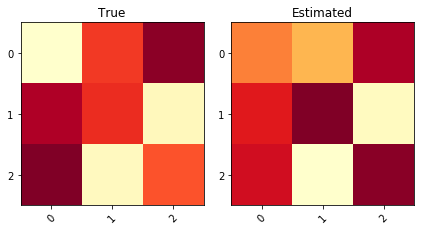

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


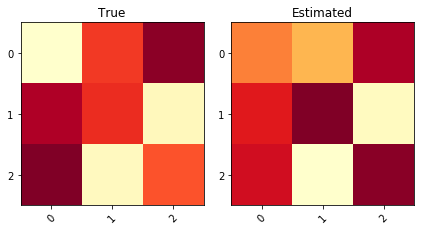

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


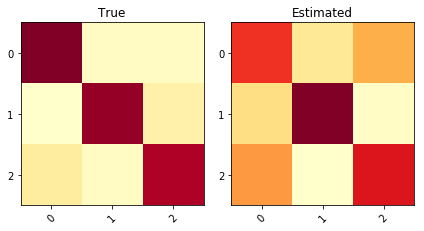

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


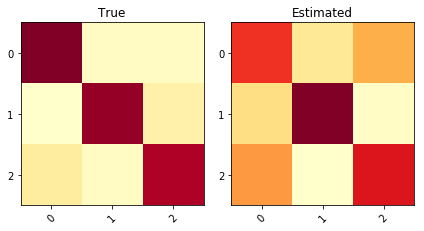

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


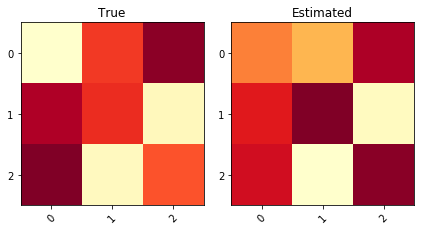

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


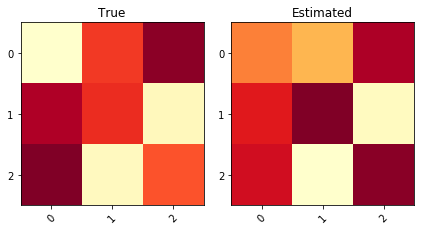

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


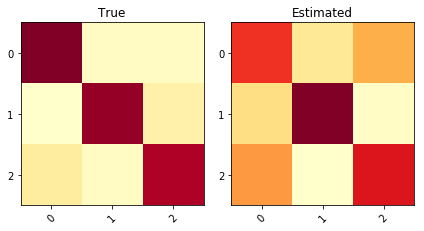

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


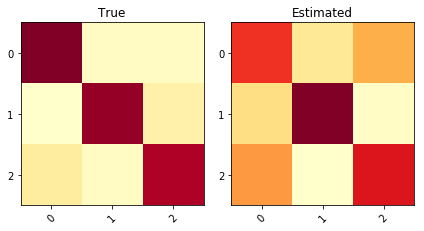

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


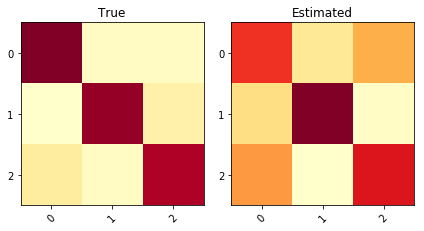

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


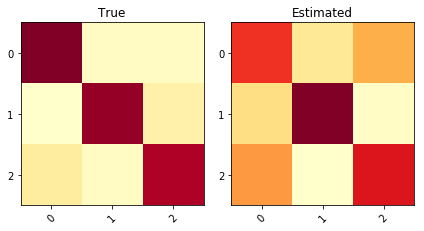

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


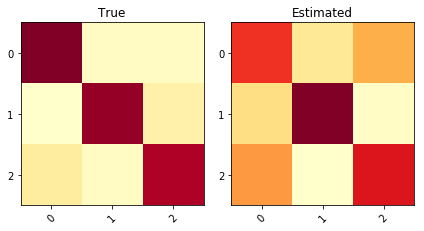

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


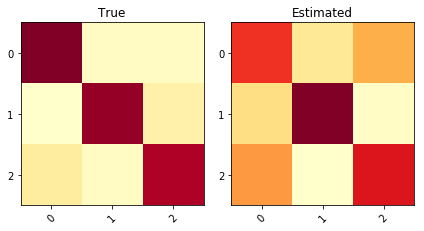

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


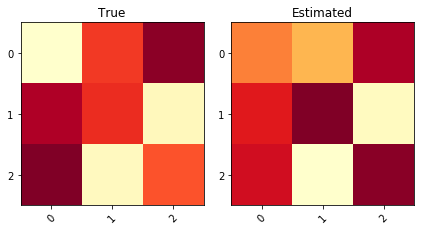

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


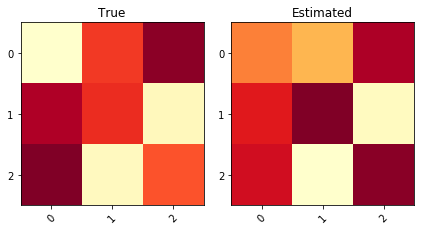

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


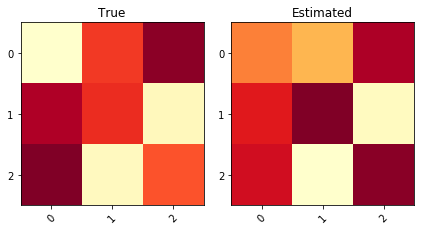

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


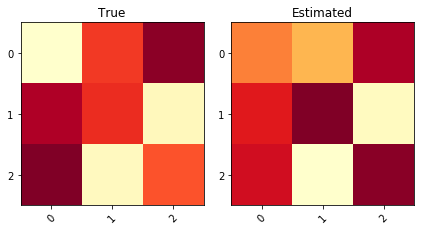

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


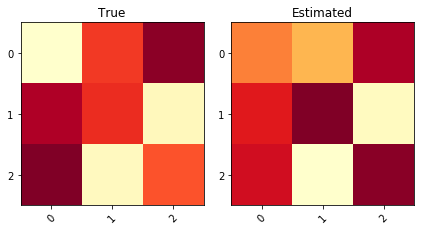

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


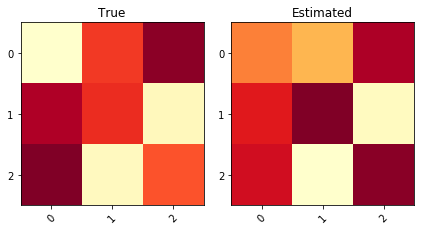

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


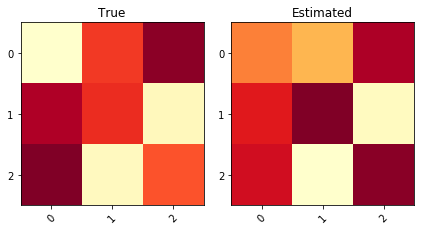

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


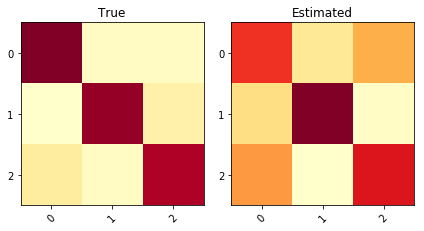

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


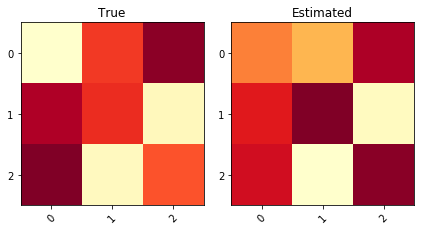

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


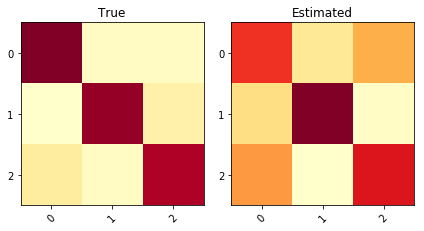

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


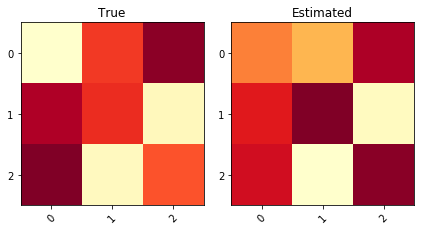

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


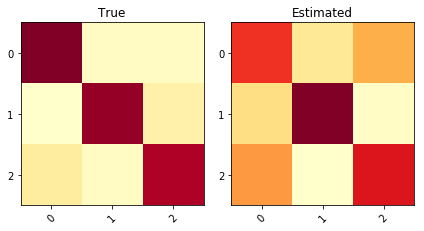

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


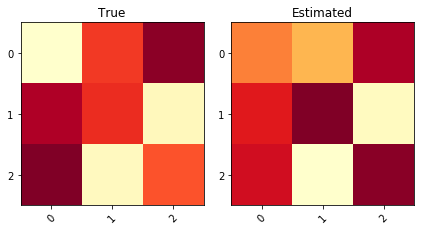

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


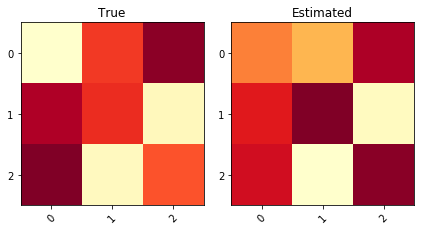

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


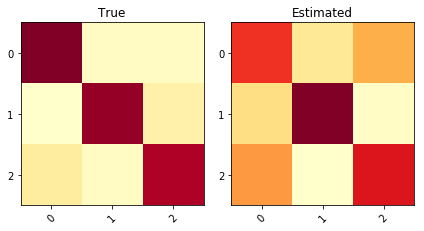

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


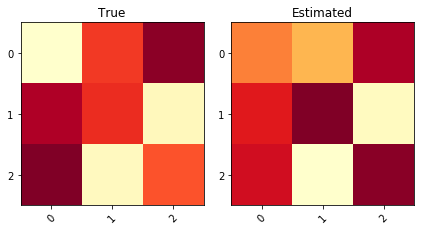

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


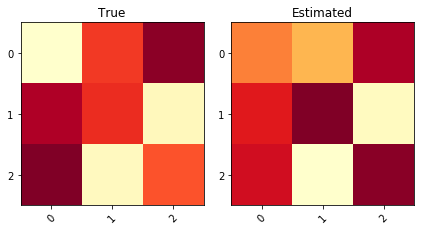

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


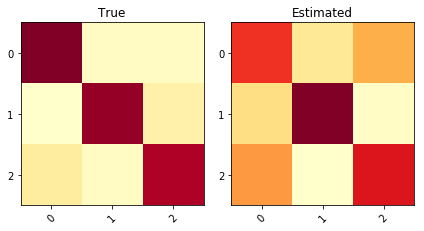

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


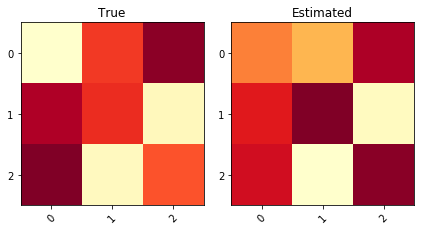

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


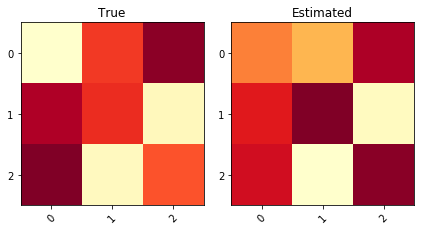

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


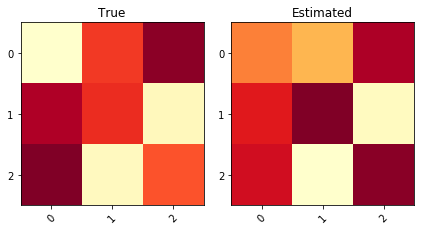

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


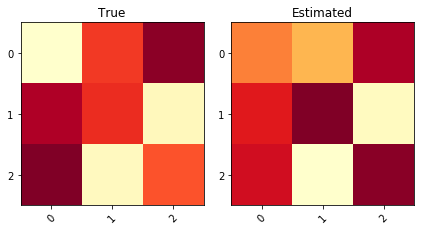

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


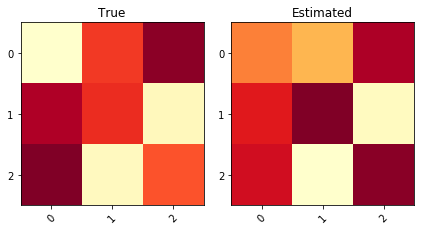

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


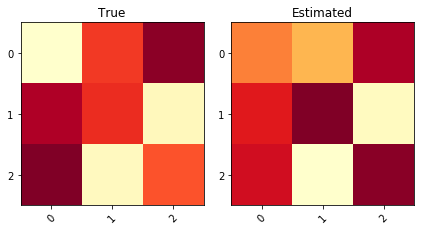

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


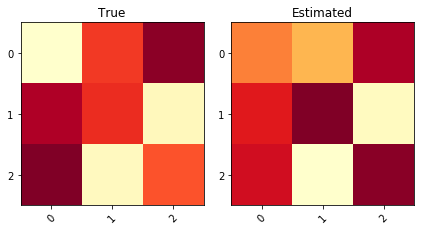

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


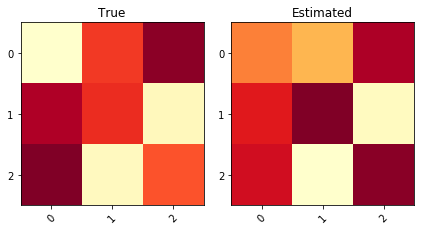

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


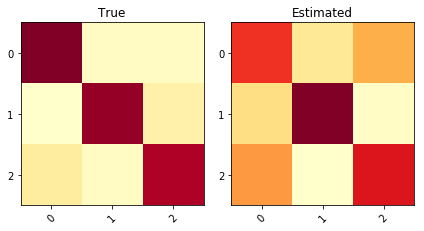

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


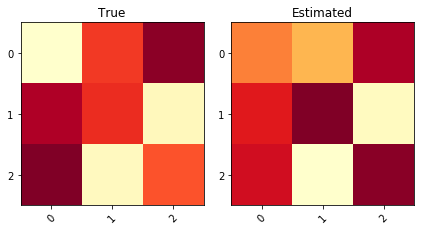

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


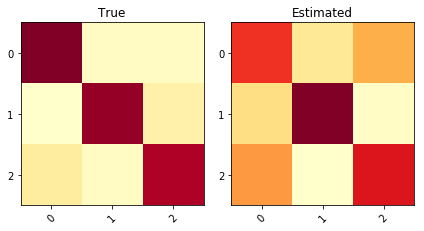

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


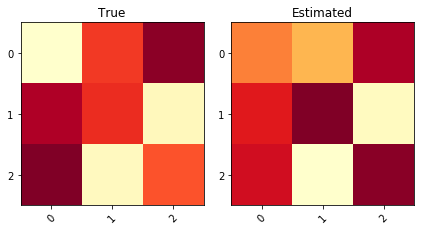

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


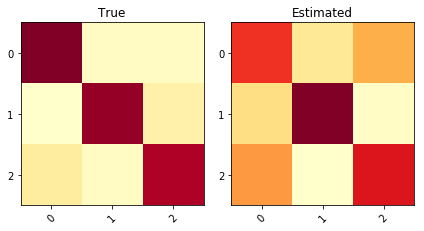

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919


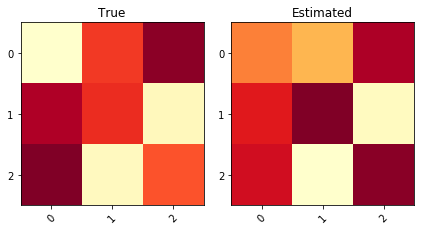

KL divergence: 0.1473	Pearson Correlation between diagonals: 0.9969


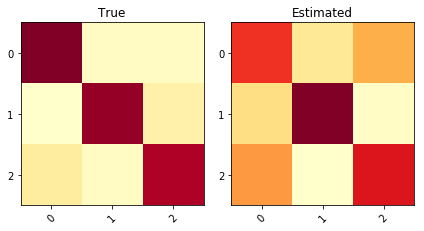

KL divergence: 0.2439	Pearson Correlation between diagonals: -0.1919
A result
  +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |   0.894444 |           0.894314 |
|  1 |       1 |   0.600741 |           0.538118 |
+----+---------+------------+--------------------+
A result
  +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |   0.891481 |           0.892084 |     0.185925 |              0.521372 |       0.143939 |
+----+--------+------------+--------------------+--------------+-----------------------+----------------+
CPU times: user 31.3 s, sys: 517 ms, total: 31.8 s
Wall time: 31.3 s


In [80]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


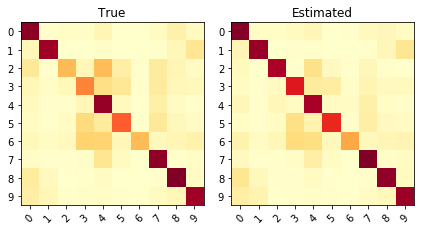

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


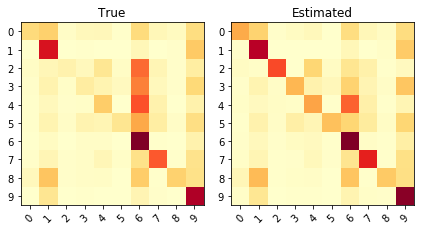

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


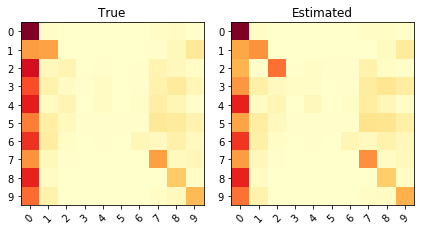

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


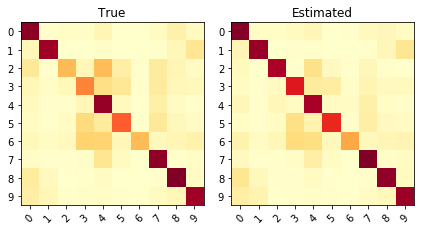

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1114	Pearson Correlation between diagonals: 0.4132


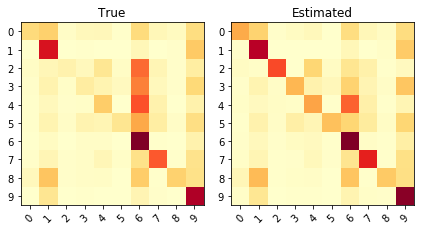

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


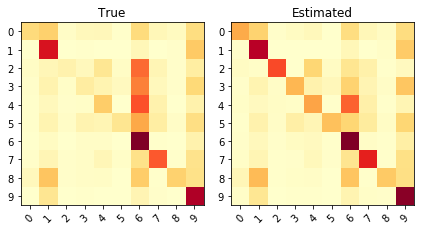

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


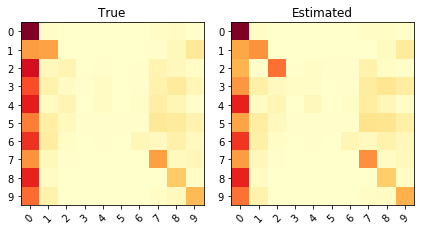

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


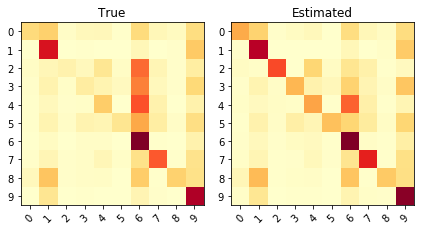

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876


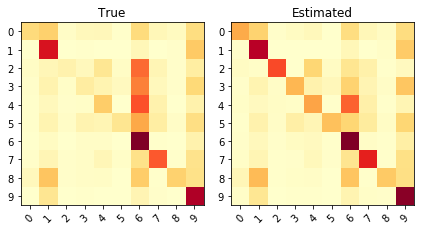

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991


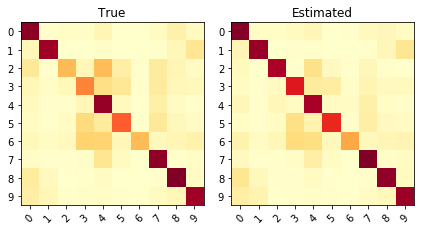

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


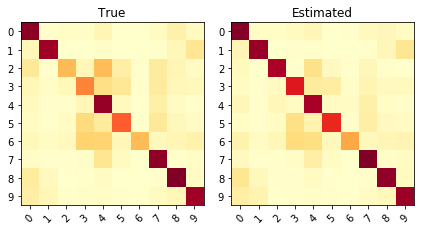

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


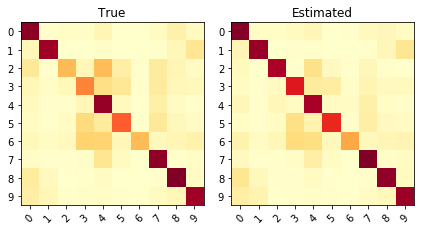

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


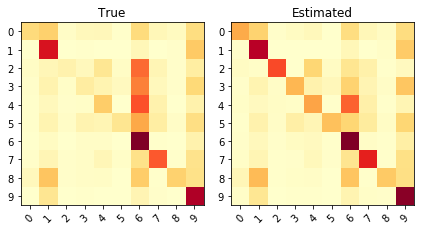

KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


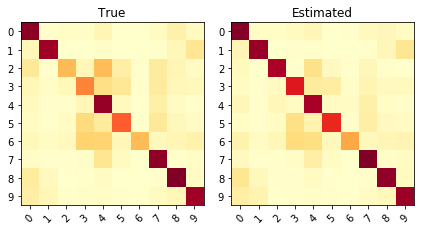

KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530


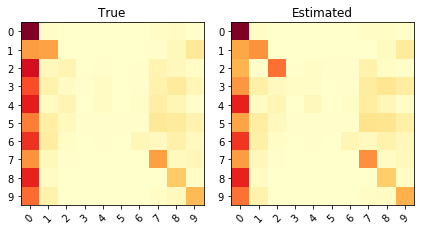

KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.0813	Pearson Correlation between diagonals: 0.7530
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation between diagonals: 0.8876
KL divergence: 0.1145	Pearson Correlation between diagonals: 0.8991
KL divergence: 0.0713	Pearson Correlation betwee

In [37]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

In [31]:
gMixture = GroupMixtureOpt(X_train.shape[1:],Kl=r_obs.shape[1],M=4,epochs=1,optimizer=OPT,pre_init=8)
#gMixture.define_model("mlp",16,2)
gMixture.define_model("default cnn")
#gMixture.define_model("simple cnn",start_units=32,deep=3,BatchN=True,drop=0.25)
logL_hist = gMixture.multiples_run(10,Xstd_train,r_obs,cluster=True,bulk_annotators=[y_obs,annotators_pca]) #more runs

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Nan Solved!
Clustering Done!
Initializing new EM...
Pre-train network on 8 epochs... Done!
Lambda by group:  [0.1378987600466675, 0.24523473249025382, 0.8920139342354865, 0.12216360576995895]
Alphas:  (4,)
MV init:  (50000, 10)
Betas:  (4, 10, 10)
Q estimate:  (50000, 10, 4, 10)
Iter 1/50
M step: done	E step: done, (in 19.07 sec)	logL: -2638904.850	
Iter 2/50
M step: done	E step: done, (in 19.08 sec)	logL: -2610500.685	Tol: 0.01076	
Iter 3/50
M step: done	E step: done, (in 19.63 sec)	logL: -2591147.926	Tol: 0.00741	
Iter 4/50
M step: done	E step: done, (in 19.23 sec)	logL: -2583362.544	Tol: 0.00300	
Iter 5/50
M step: done	E step: done, (in 18.98 sec)	logL: -2565883.684	Tol: 0.00677	
Iter 6/50
M step: done	E step: done, (in 19.05 sec)	logL: -2578962.508	Tol: 0.00510	
Iter 7/50
M step: done	E step: done, (in 18.66 sec)	logL: -2561385.656	Tol: 0.00682	
Iter 8/50
M step: done	E step: done, (in 18.67 sec)	logL: -2549138.193	Tol: 0.00478	
Iter 9/50
M step: done	E step: done, (in 18.30 sec)	l

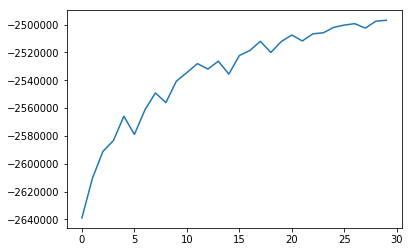

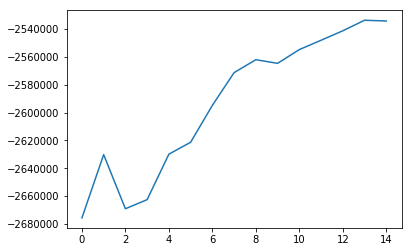

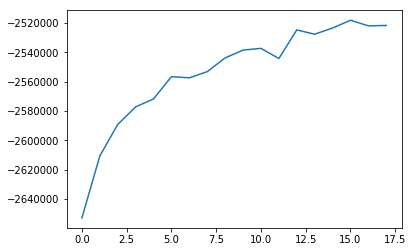

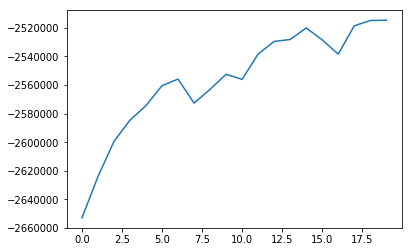

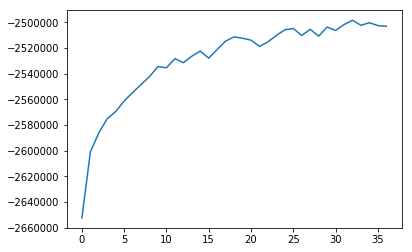

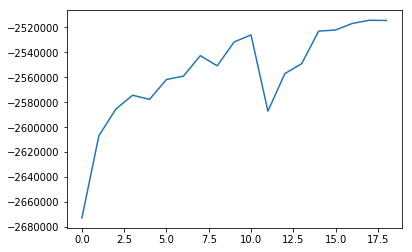

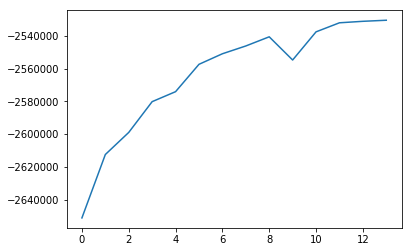

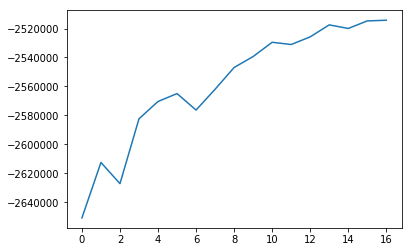

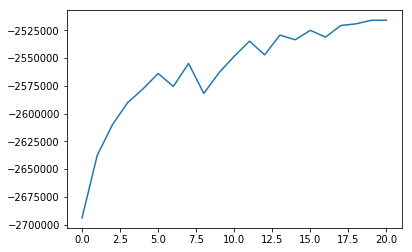

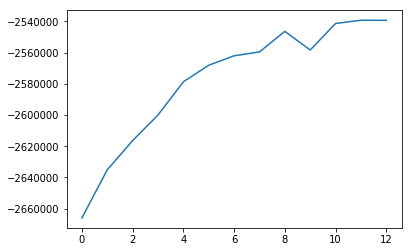

In [32]:
for value in logL_hist:
    plt.plot(range(len(value)),value,'bo-')
    plt.show()
#plt.plot(logL_hist)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


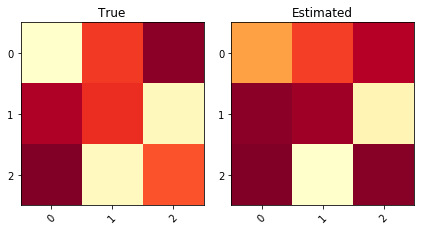

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


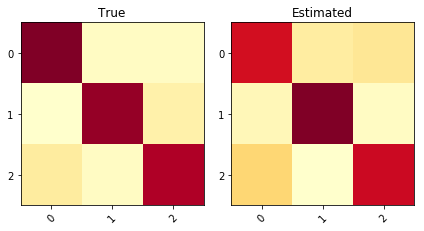

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


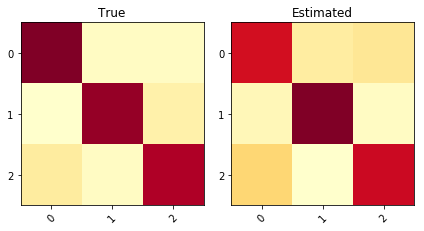

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


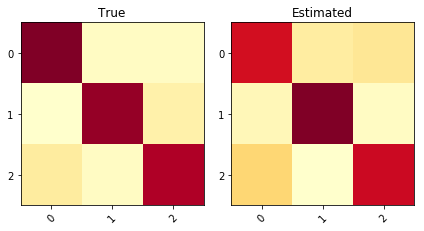

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


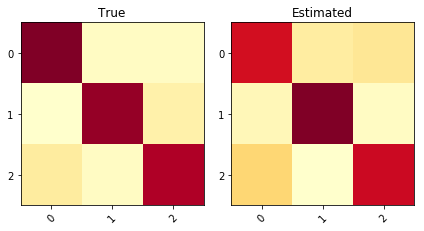

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


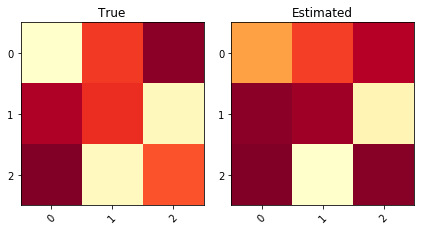

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


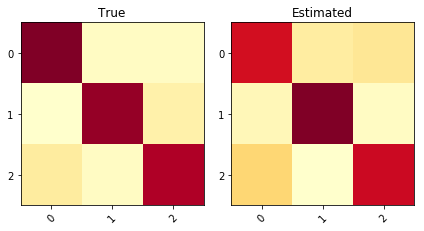

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


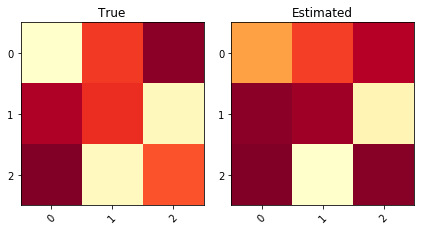

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


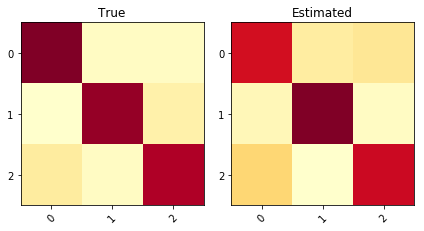

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


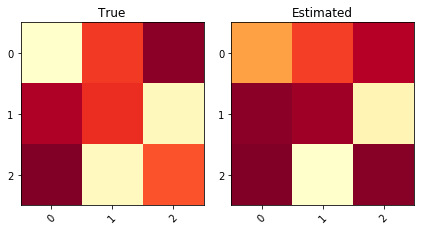

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


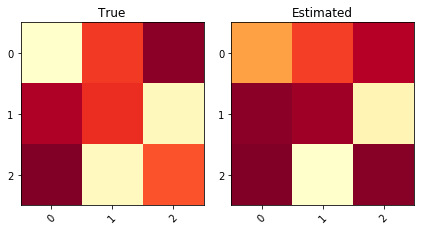

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


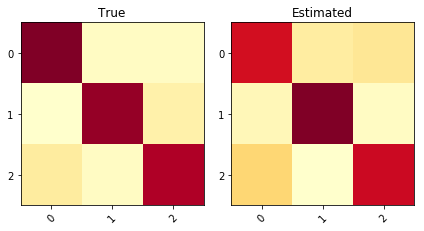

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


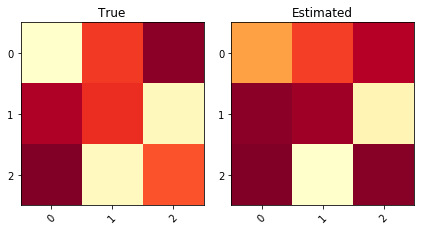

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


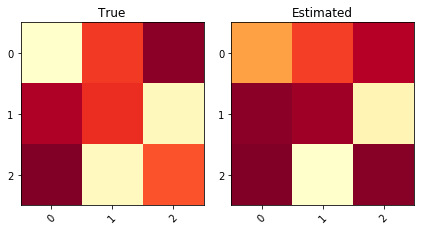

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


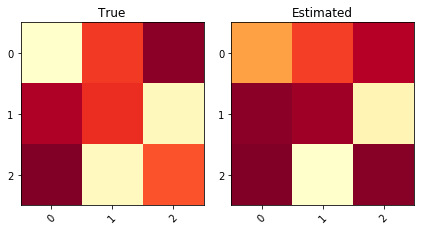

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


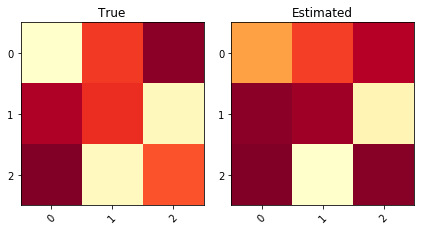

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


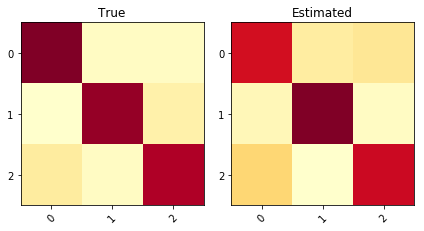

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


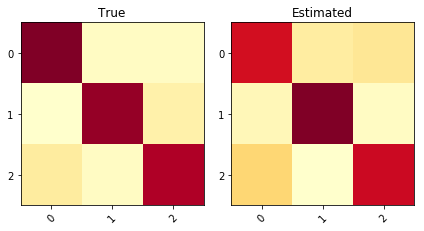

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


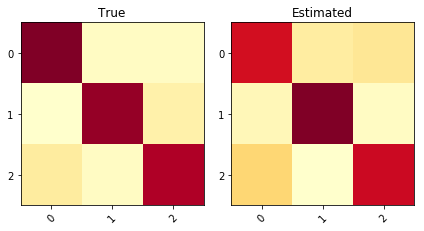

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


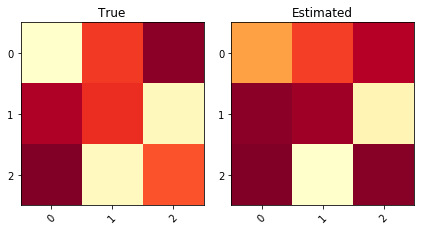

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


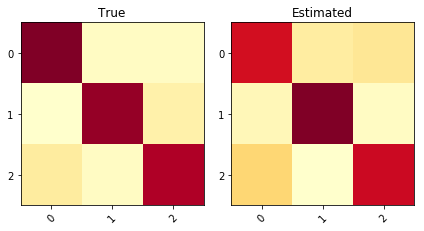

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


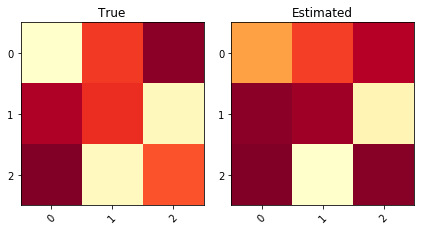

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


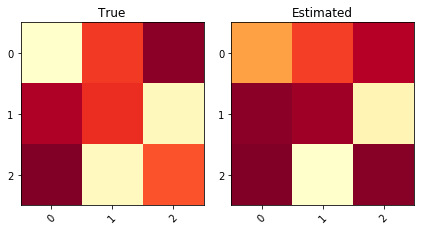

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


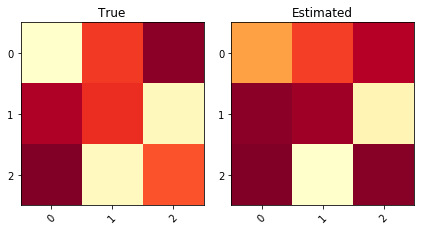

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


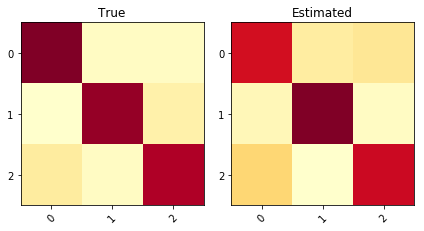

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


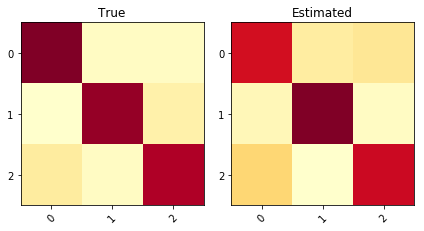

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


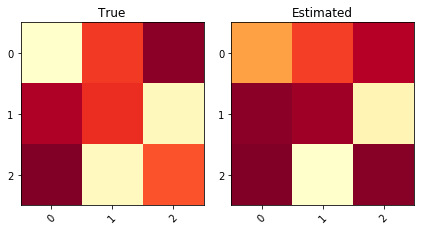

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


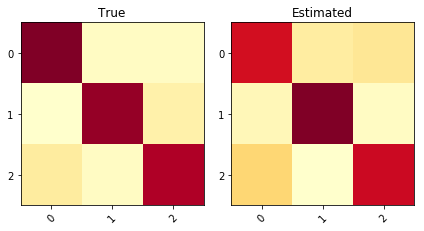

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


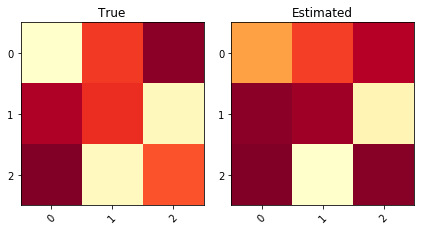

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


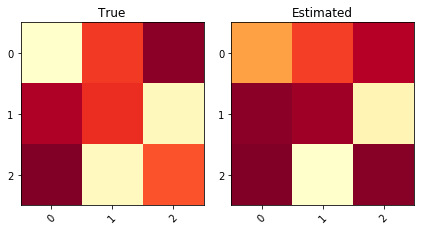

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


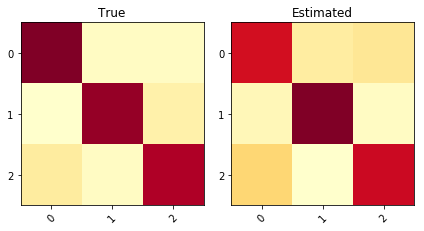

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


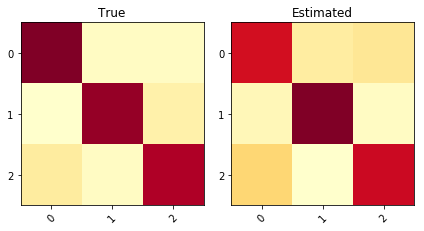

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


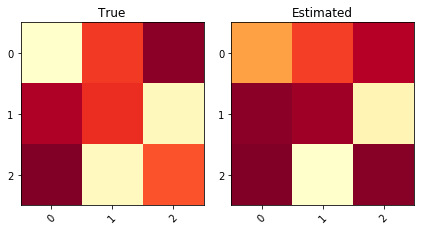

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


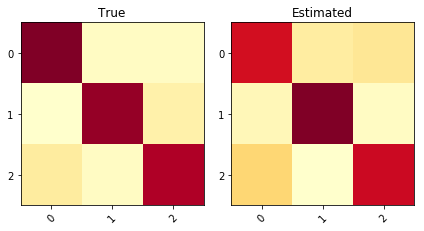

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


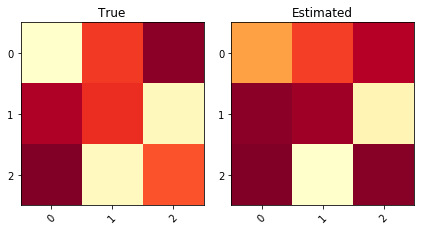

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


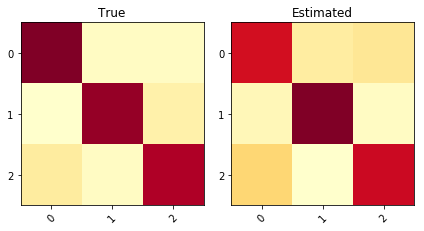

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


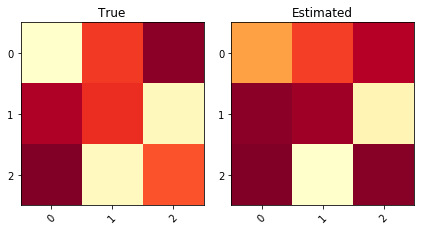

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


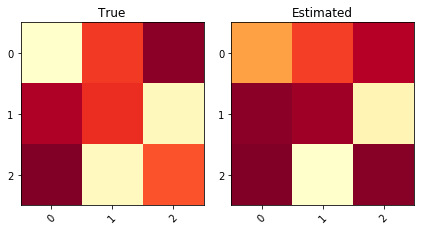

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


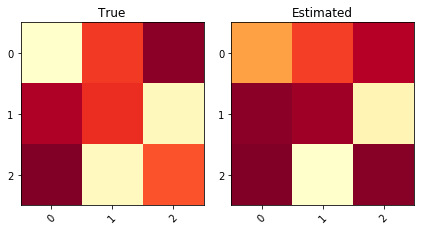

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


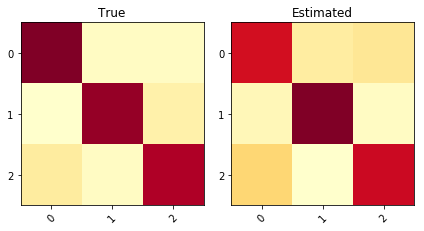

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


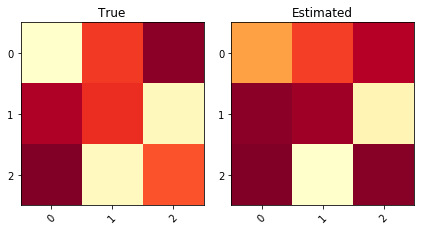

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


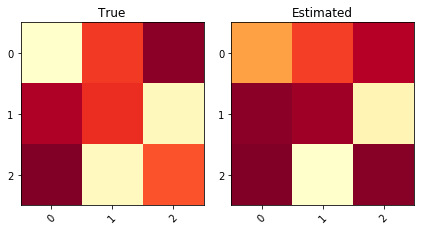

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


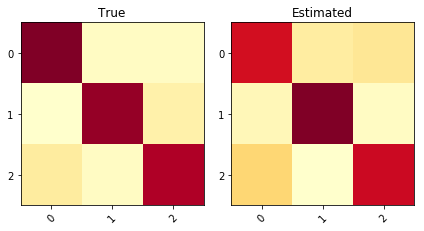

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


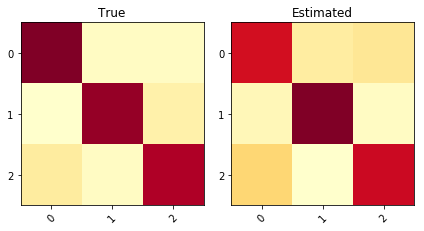

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


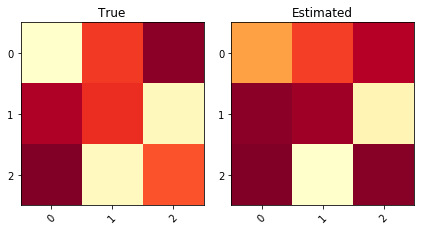

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


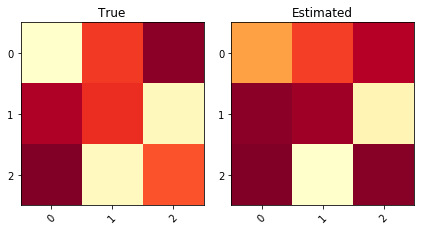

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


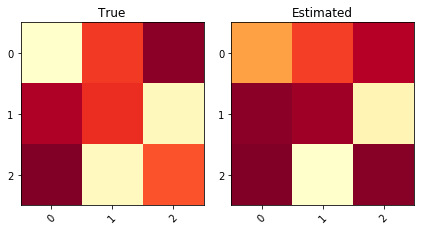

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


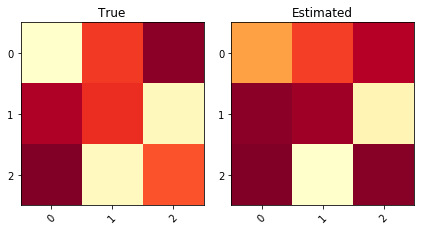

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


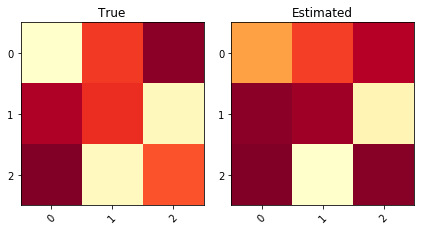

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


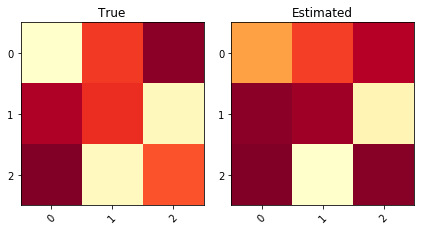

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


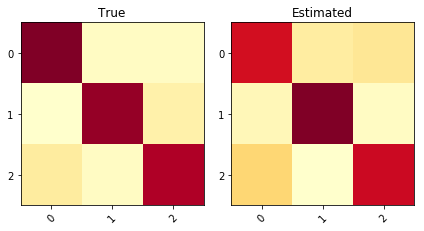

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


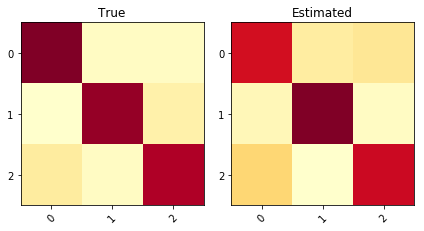

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


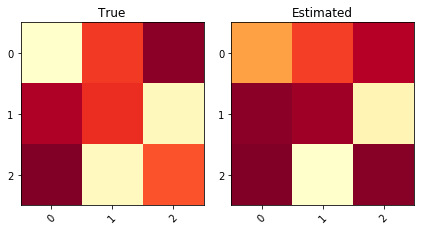

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


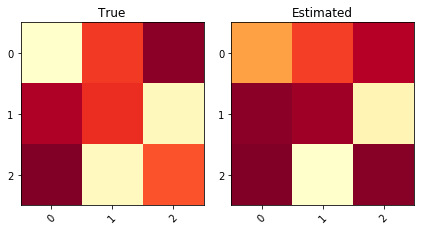

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


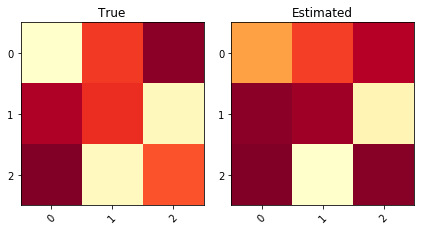

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


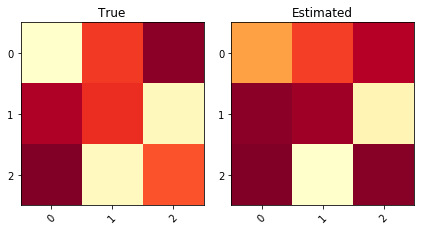

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


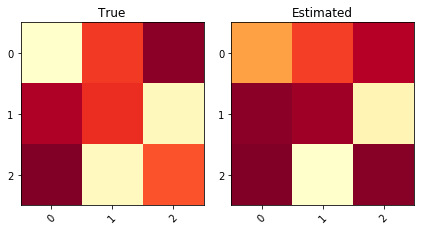

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


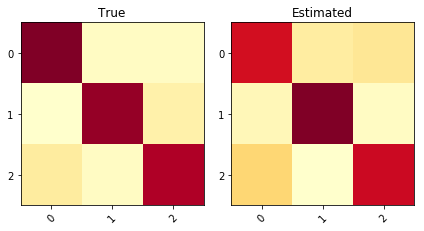

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


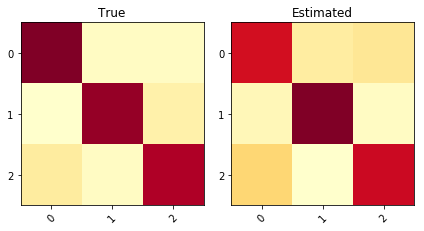

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


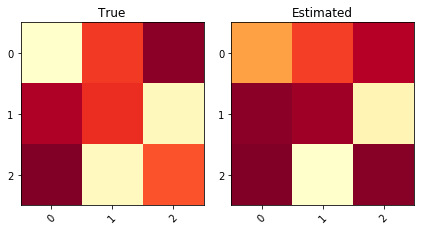

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


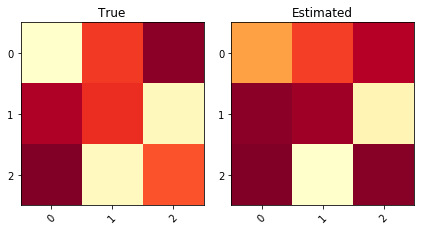

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


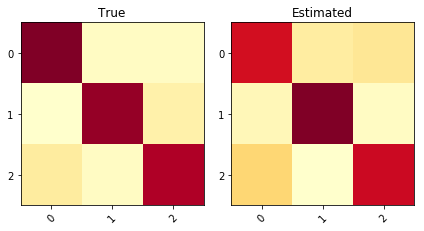

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


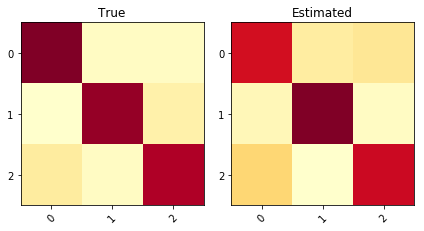

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


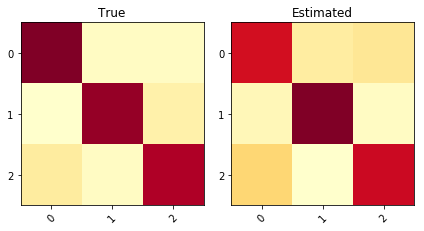

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


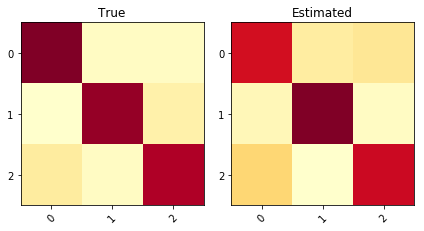

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


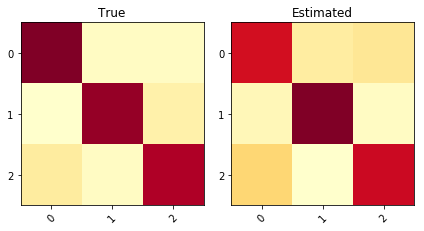

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


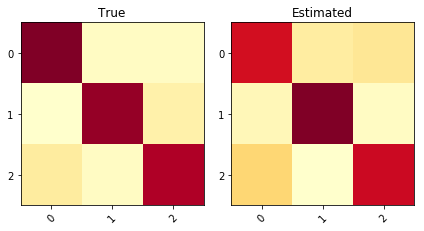

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


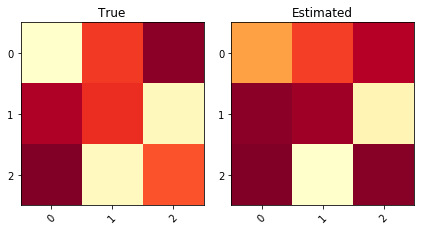

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


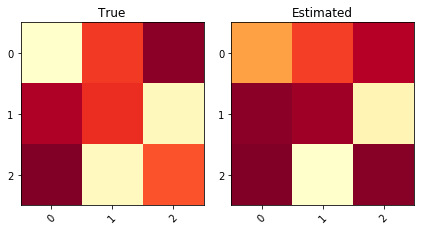

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


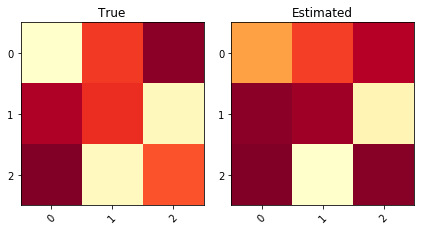

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


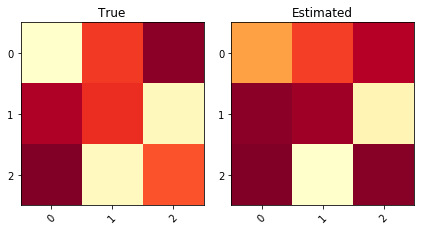

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


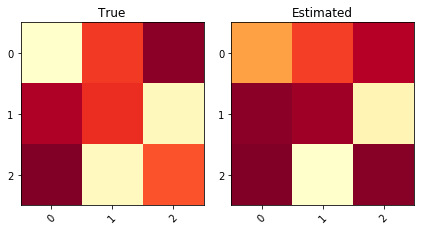

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


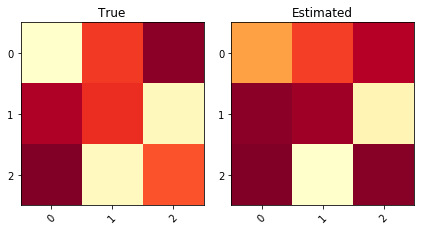

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


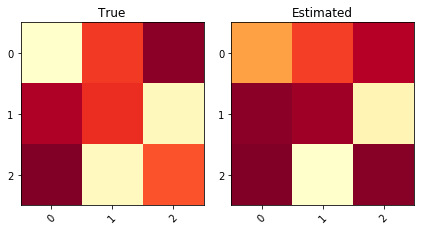

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


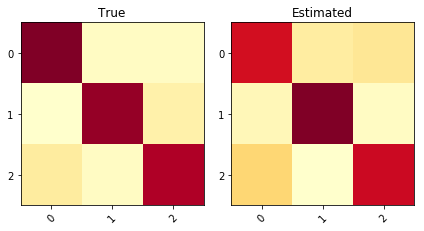

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


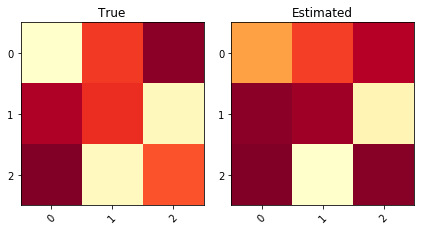

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


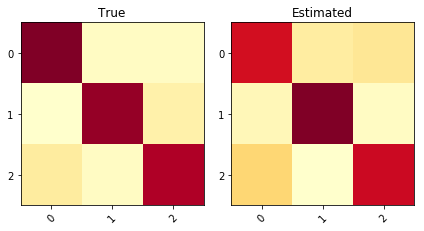

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


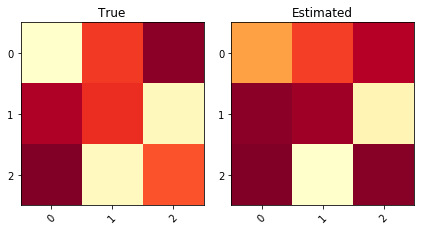

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


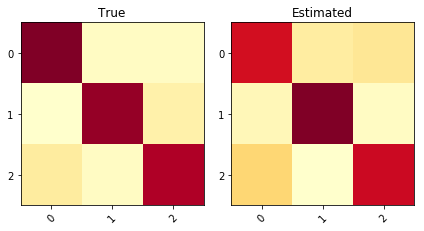

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


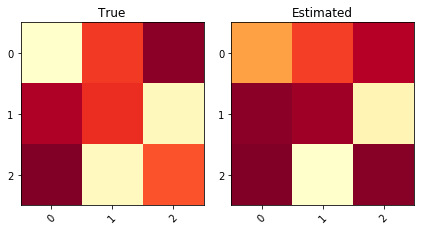

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


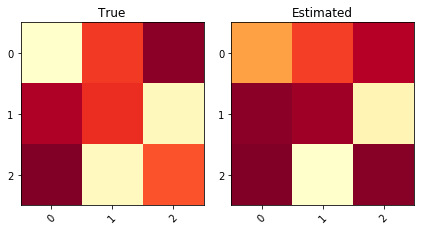

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


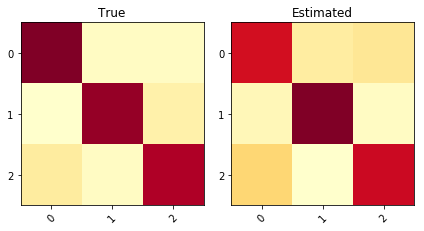

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


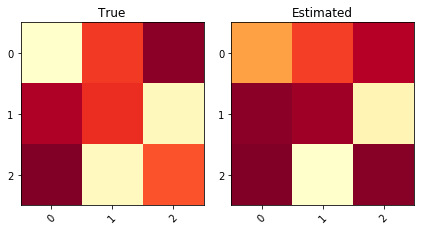

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


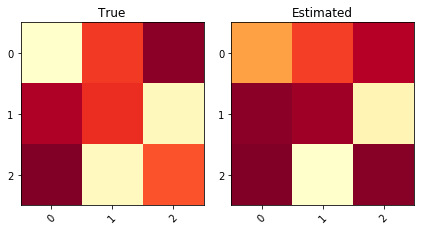

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


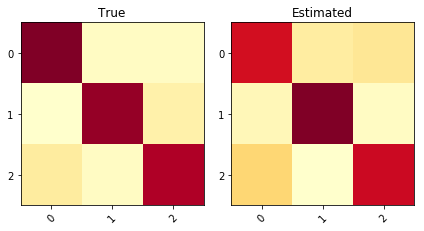

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


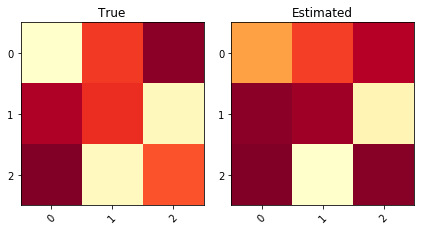

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


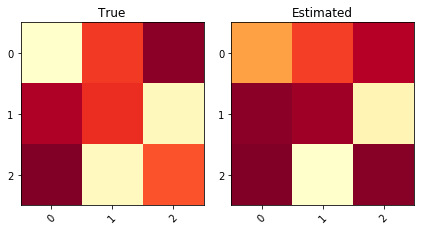

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


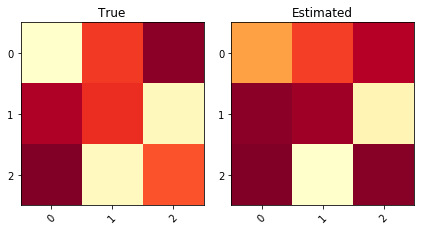

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


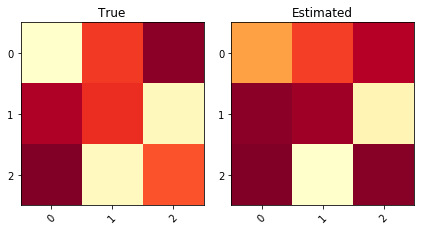

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


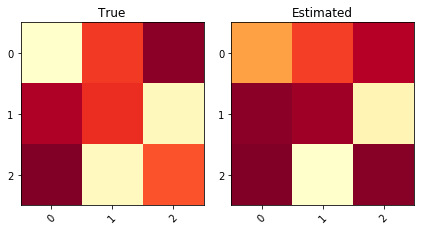

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


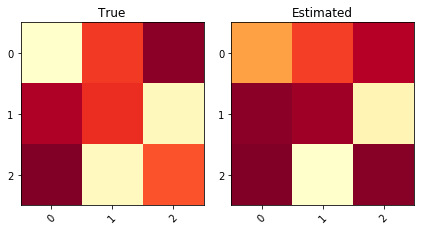

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


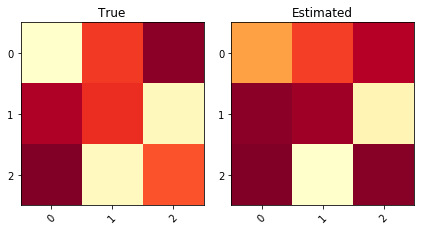

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


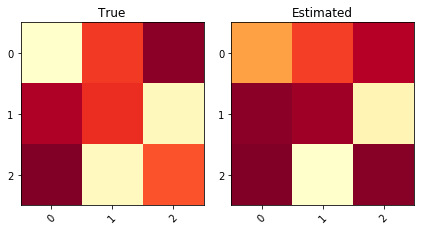

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


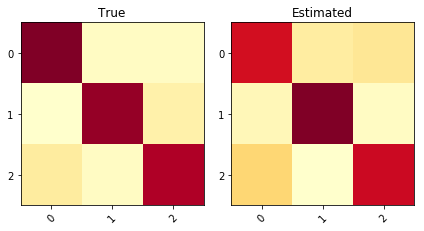

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


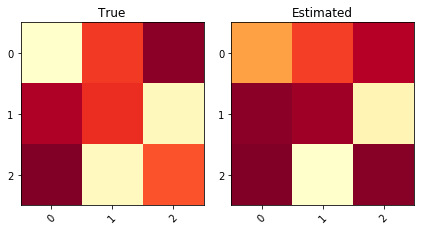

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


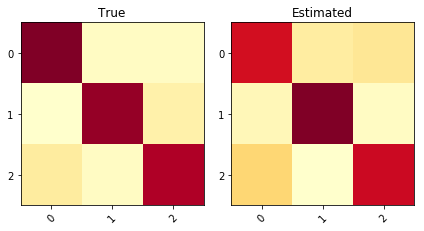

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


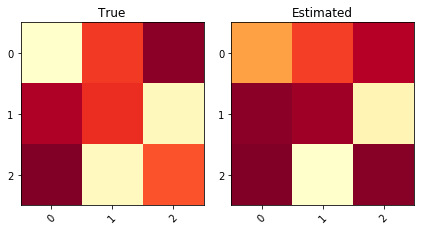

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


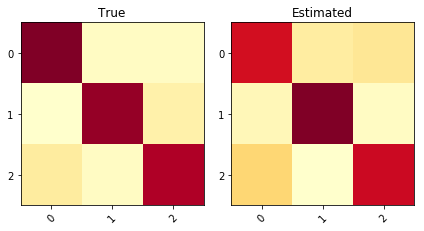

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589


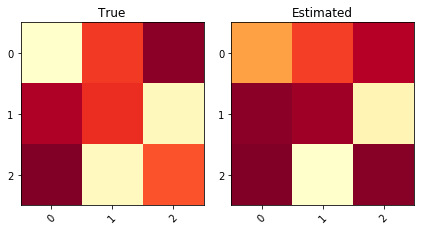

KL divergence: 0.0894	Pearson Correlation between diagonals: 0.9812


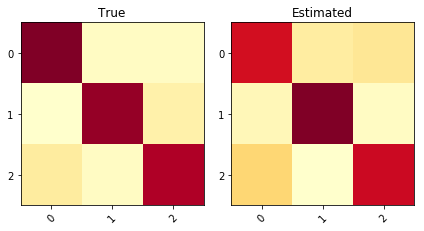

KL divergence: 0.1024	Pearson Correlation between diagonals: -0.0589
A result
  +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |   0.29963  |           0.220811 |
|  1 |       1 |   0.897037 |           0.89708  |
+----+---------+------------+--------------------+
A result
  +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |   0.894444 |           0.894994 |     0.094598 |              0.565182 |        0.16847 |
+----+--------+------------+--------------------+--------------+-----------------------+----------------+
CPU times: user 31.4 s, sys: 555 ms, total: 31.9 s
Wall time: 31.4 s


In [74]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

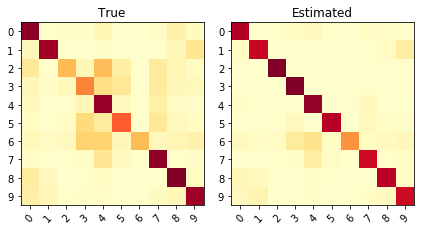

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


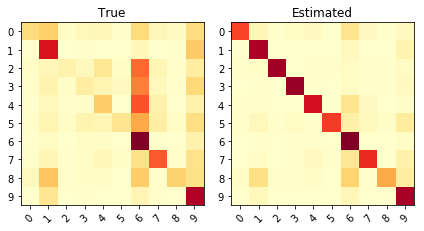

KL divergence: 0.6230	Pearson Correlation between diagonals: 0.3983


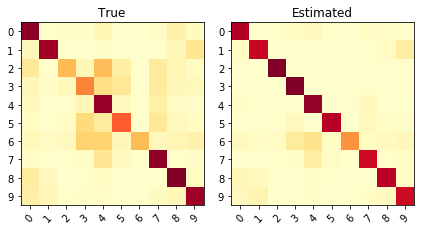

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


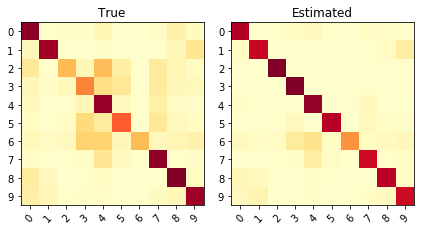

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


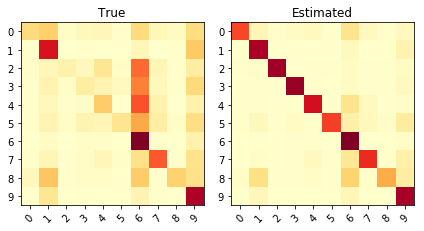

KL divergence: 0.6187	Pearson Correlation between diagonals: 0.4000


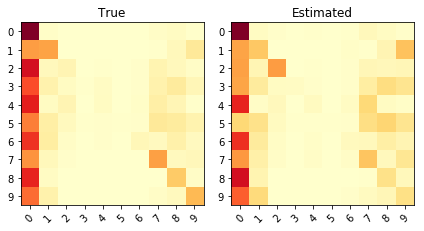

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


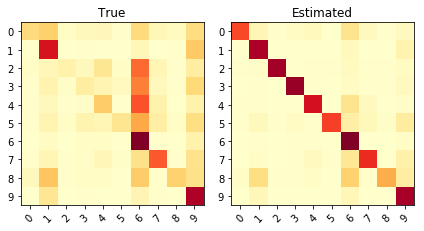

KL divergence: 0.6106	Pearson Correlation between diagonals: 0.4034


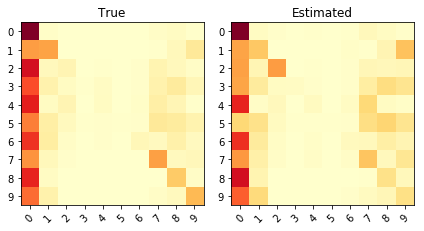

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


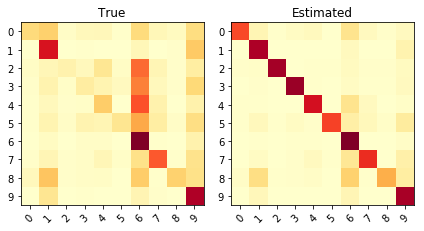

KL divergence: 0.6022	Pearson Correlation between diagonals: 0.4069


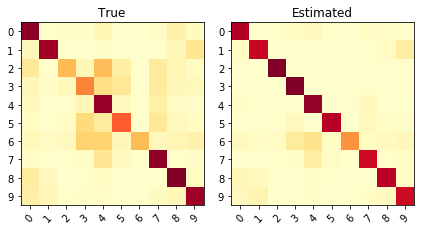

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


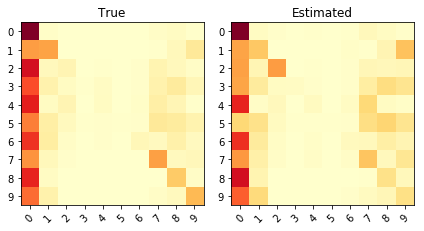

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


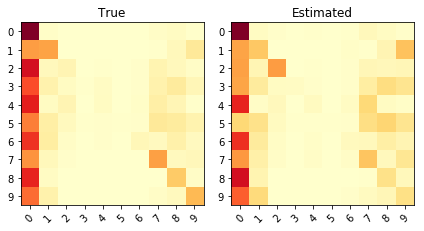

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


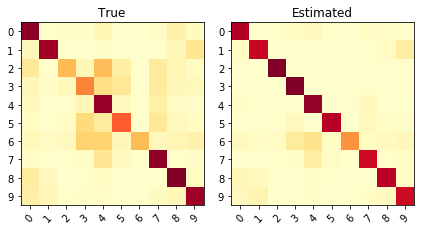

KL divergence: 0.4461	Pearson Correlation between diagonals: 0.2158


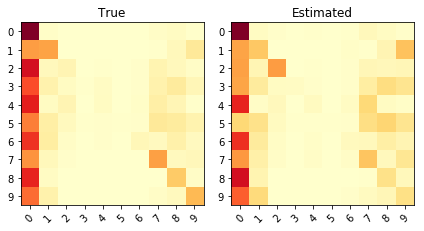

KL divergence: 0.1190	Pearson Correlation between diagonals: 0.8811


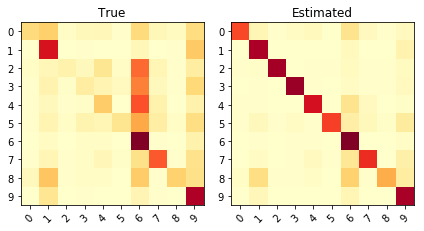

KL divergence: 0.6063	Pearson Correlation between diagonals: 0.4052
A result
 +----+---------+------------+--------------------+
|    |   Group |   Accuracy |   F1 score (micro) |
|----+---------+------------+--------------------|
|  0 |       0 |    0.63382 |            0.63382 |
|  1 |       1 |    0.8407  |            0.8407  |
|  2 |       2 |    0.1     |            0.1     |
|  3 |       3 |    0.65312 |            0.65312 |
+----+---------+------------+--------------------+
A result
 +----+--------+------------+--------------------+--------------+-----------------------+----------------+
|    |        |   Accuracy |   F1 score (micro) |   Average KL |   Average PearsonCorr |   Average RMSE |
|----+--------+------------+--------------------+--------------+-----------------------+----------------|
|  0 | Global |    0.75984 |            0.75984 |     0.429922 |              0.428081 |       0.143167 |
+----+--------+------------+--------------------+--------------+----------------

In [34]:
%%time
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1')

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

In [46]:
from  scipy.stats import entropy
from sklearn.metrics import accuracy_score
from code.evaluation import Evaluation_metrics
def distance_function(predicted,ob): # to cluster
    return [-np.sum(predicted*np.log(ob))] #funciona bien -- over 90 = 5 -- over 90 = 8 (lambda=1)

Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.003762 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.37826893 0.560401   0.23498705]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 6.06 sec)	logL: -26921.825	
Iter 2/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -25329.481	Tol1: 0.05915	Tol2: 0.38126	Tol3: 0.03581	
Iter 3/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24764.710	Tol1: 0.02230	Tol2: 0.16079	Tol3: 0.01453	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24451.204	Tol1: 0.01266	Tol2: 0.06424	Tol3: 0.00632	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24184.554	Tol1: 0.01091	Tol2: 0.03137	Tol3: 0.00497	
Iter 6/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23915.902	Tol1: 0.01111	Tol2: 0.03496	Tol3: 0.00779	
Iter 7/50
M step: done,  E step: done //  (

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.28812984 0.78831327 0.7411541 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.51 sec)	logL: -22130.510	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21536.419	Tol1: 0.02684	Tol2: 0.21760	Tol3: 0.06957	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21178.233	Tol1: 0.01663	Tol2: 0.13143	Tol3: 0.03767	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20895.639	Tol1: 0.01334	Tol2: 0.10568	Tol3: 0.02574	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20681.721	Tol1: 0.01024	Tol2: 0.09282	Tol3: 0.01897	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20520.253	Tol1: 0.00781	Tol2: 0.08125	Tol3: 0.01431	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20388.940	Tol1: 0.00640	Tol2: 0.07514	Tol3: 0.00971	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	l

M step: done,  E step: done //  (in 0.12 sec)	logL: -20730.189	Tol1: 0.00687	Tol2: 0.03191	Tol3: 0.01165	
Iter 15/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20611.591	Tol1: 0.00572	Tol2: 0.02597	Tol3: 0.00985	
Finished training!
Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.003329 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.43232766 0.9981078  0.51337427]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.51 sec)	logL: -25983.820	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24837.948	Tol1: 0.04410	Tol2: 0.25487	Tol3: 0.02844	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24414.224	Tol1: 0.01706	Tol2: 0.10332	Tol3: 0.01254	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24098.634	Tol1: 0.01293	Tol2: 0.06808	Tol3: 0.00465	
Iter 5/50
M step: done,  E step: 

M step: done,  E step: done //  (in 0.12 sec)	logL: -20278.627	Tol1: 0.00200	Tol2: 0.04481	Tol3: 0.00145	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20241.444	Tol1: 0.00183	Tol2: 0.04075	Tol3: 0.00161	
Iter 21/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20207.829	Tol1: 0.00166	Tol2: 0.04105	Tol3: 0.00156	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20175.116	Tol1: 0.00162	Tol2: 0.03708	Tol3: 0.00150	
Iter 23/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20150.235	Tol1: 0.00123	Tol2: 0.03687	Tol3: 0.00160	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20130.260	Tol1: 0.00099	Tol2: 0.03411	Tol3: 0.00126	
Iter 25/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20113.862	Tol1: 0.00081	Tol2: 0.03286	Tol3: 0.00131	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20097.951	Tol1: 0.00079	Tol2: 0.03088	Tol3: 0.00147	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20084.798	T

Clustering Done!
Get init alphas in 0.003305 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.39063138 0.42104718 0.15055834]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 6.34 sec)	logL: -28807.920	
Iter 2/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -25616.548	Tol1: 0.11078	Tol2: 0.67971	Tol3: 0.01823	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24658.167	Tol1: 0.03741	Tol2: 0.26491	Tol3: 0.02641	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24319.837	Tol1: 0.01372	Tol2: 0.10494	Tol3: 0.01040	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24058.391	Tol1: 0.01075	Tol2: 0.05695	Tol3: 0.00122	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23791.804	Tol1: 0.01108	Tol2: 0.05524	Tol3: 0.00515	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23516.913	Tol1: 0.01155	Tol2: 0.06092

M step: done,  E step: done //  (in 6.74 sec)	logL: -25001.335	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24072.310	Tol1: 0.03716	Tol2: 0.22001	Tol3: 0.05342	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23623.601	Tol1: 0.01864	Tol2: 0.08520	Tol3: 0.02380	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23219.663	Tol1: 0.01710	Tol2: 0.06996	Tol3: 0.01876	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22829.127	Tol1: 0.01682	Tol2: 0.07680	Tol3: 0.02174	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22456.593	Tol1: 0.01632	Tol2: 0.08545	Tol3: 0.02332	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22122.664	Tol1: 0.01487	Tol2: 0.09165	Tol3: 0.02302	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21821.407	Tol1: 0.01362	Tol2: 0.09362	Tol3: 0.02154	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21561.671	Tol1: 0.01190	Tol2: 0.09264	Tol3: 0.01921	
Iter 10/

M step: done,  E step: done //  (in 0.13 sec)	logL: -22544.276	Tol1: 0.01237	Tol2: 0.08960	Tol3: 0.01916	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22264.018	Tol1: 0.01243	Tol2: 0.09367	Tol3: 0.01895	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21982.971	Tol1: 0.01262	Tol2: 0.09510	Tol3: 0.01796	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21719.991	Tol1: 0.01196	Tol2: 0.09450	Tol3: 0.01686	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21486.849	Tol1: 0.01073	Tol2: 0.09034	Tol3: 0.01521	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21281.575	Tol1: 0.00955	Tol2: 0.08379	Tol3: 0.01355	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21092.550	Tol1: 0.00888	Tol2: 0.07549	Tol3: 0.01193	
Iter 24/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20931.113	Tol1: 0.00765	Tol2: 0.06811	Tol3: 0.01078	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20793.075	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -20810.645	Tol1: 0.01145	Tol2: 0.07297	Tol3: 0.00383	
Iter 14/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20614.913	Tol1: 0.00941	Tol2: 0.06442	Tol3: 0.00280	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20468.481	Tol1: 0.00710	Tol2: 0.05500	Tol3: 0.00225	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20358.861	Tol1: 0.00536	Tol2: 0.04939	Tol3: 0.00208	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20268.154	Tol1: 0.00446	Tol2: 0.04508	Tol3: 0.00198	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20197.494	Tol1: 0.00349	Tol2: 0.04098	Tol3: 0.00141	
Iter 19/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20141.561	Tol1: 0.00277	Tol2: 0.03610	Tol3: 0.00110	
Iter 20/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20095.975	Tol1: 0.00226	Tol2: 0.03366	Tol3: 0.00115	
Iter 21/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20058.539	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -20367.356	Tol1: 0.00183	Tol2: 0.02820	Tol3: 0.00273	
Finished training!
Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.003621 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.64982355 0.33685288 0.91381115]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 9.14 sec)	logL: -28476.718	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -26013.198	Tol1: 0.08651	Tol2: 0.40377	Tol3: 0.05784	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -25498.917	Tol1: 0.01977	Tol2: 0.20440	Tol3: 0.00752	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25103.787	Tol1: 0.01550	Tol2: 0.16502	Tol3: 0.01528	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24739.110	Tol1: 0.01453	Tol2: 0.13952	Tol3: 0.01802	
Iter 6/50
M step: done,  E step: d

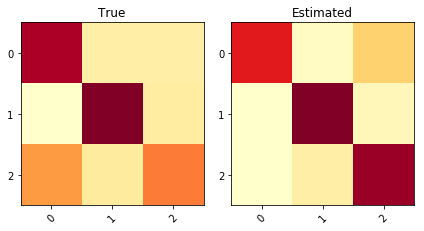

KL divergence: 0.4789	Pearson Correlation between diagonals: -0.1072


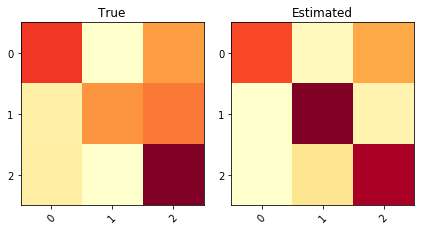

KL divergence: 0.3546	Pearson Correlation between diagonals: -0.1019


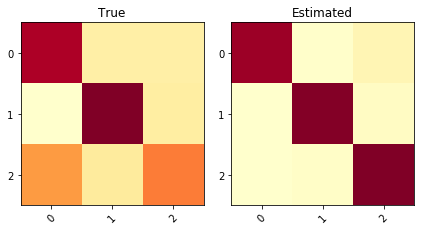

KL divergence: 0.7975	Pearson Correlation between diagonals: -0.4454


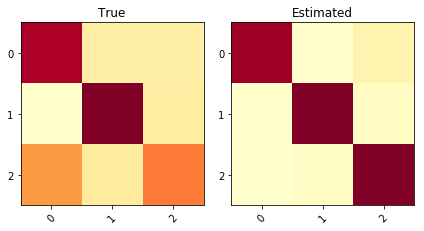

KL divergence: 0.7539	Pearson Correlation between diagonals: -0.3917


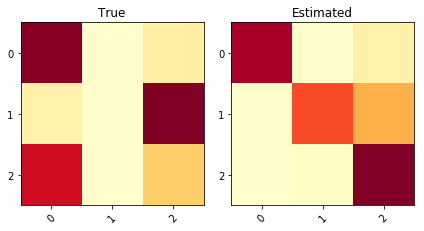

KL divergence: 1.6789	Pearson Correlation between diagonals: 0.5583


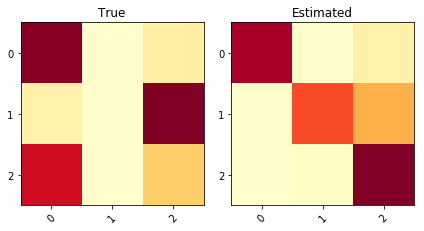

KL divergence: 1.6789	Pearson Correlation between diagonals: 0.5583


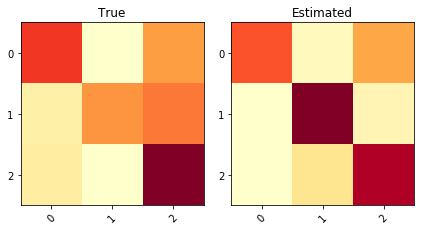

KL divergence: 0.3745	Pearson Correlation between diagonals: -0.1345


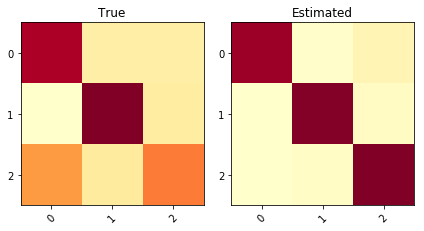

KL divergence: 0.7929	Pearson Correlation between diagonals: -0.4397


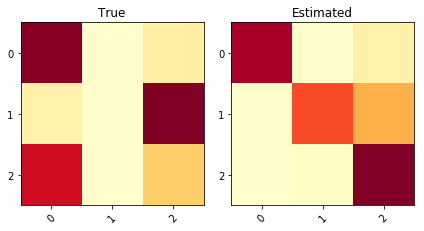

KL divergence: 1.6789	Pearson Correlation between diagonals: 0.5583


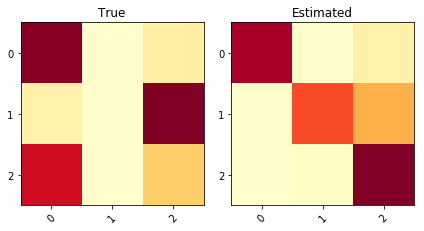

KL divergence: 1.6789	Pearson Correlation between diagonals: 0.5583


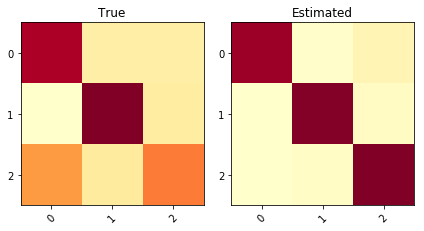

KL divergence: 0.7925	Pearson Correlation between diagonals: -0.4392


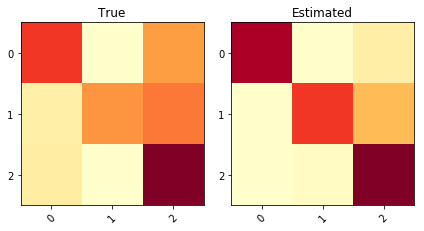

KL divergence: 0.3042	Pearson Correlation between diagonals: 0.9314


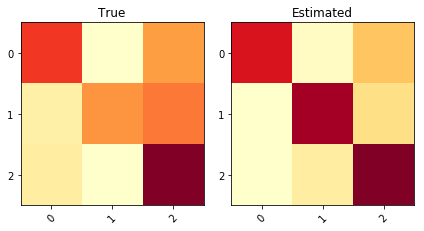

KL divergence: 0.2541	Pearson Correlation between diagonals: 0.4559


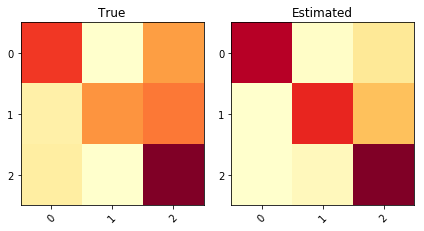

KL divergence: 0.2628	Pearson Correlation between diagonals: 0.9751


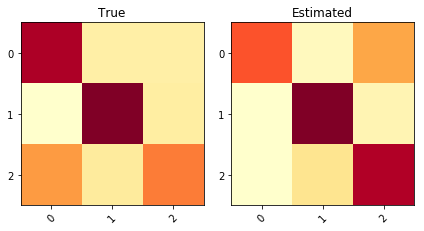

KL divergence: 0.4473	Pearson Correlation between diagonals: -0.0676
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.479853      0.479853   0.956317   0.132307            0.225788
====  ======  ==========  ============  =========  =========  ==================


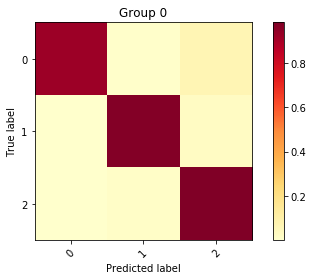

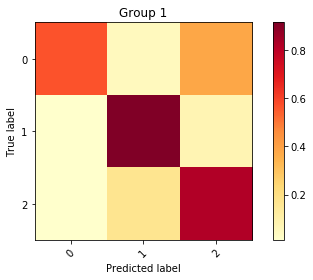

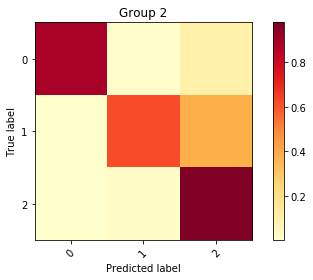

Inertia: 0.04887979757040739
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  =========  ======  =========  ===========  =========  =============  =========
   0         0  0.421657       42   0.172136     0.95964   0.0415626       0.979392   0.93946
   1         1  0.0584397       5   0.559249     0.767388  0.284693        0.866569   0.651082
   2         2  0.519903       51   0.381905     0.831689  0.20314         0.904274   0.747533
====  ========  =========  ======  =========  ===========  =========  =============  =========


In [26]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))
print("std accuracy of runs:", np.std(accTE_encontrados))
print("Median accuracy of runs:", np.median(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc model

[[0.51374507 0.06594136 0.42031357]
 [0.45109835 0.04639743 0.5025042 ]
 [0.42799586 0.08537521 0.48662895]
 [0.42479134 0.08649343 0.48871523]
 [0.48763162 0.05209798 0.46027043]
 [0.46837255 0.05323076 0.4783967 ]
 [0.43829724 0.07012378 0.49157897]
 [0.5294389  0.02447583 0.44608527]
 [0.4222622  0.08016116 0.49757668]
 [0.16815235 0.24934326 0.5825044 ]
 [0.43567    0.04626919 0.51806086]
 [0.4412669  0.06980518 0.48892793]
 [0.44022027 0.07011344 0.48966628]
 [0.44918424 0.03009342 0.5207223 ]
 [0.49499518 0.04332002 0.4616848 ]
 [0.43797725 0.04136731 0.5206554 ]
 [0.43358272 0.07997484 0.48644242]
 [0.41062558 0.04877017 0.5406043 ]
 [0.58039105 0.08277541 0.33683354]
 [0.40418226 0.04418545 0.5516323 ]
 [0.43287954 0.03406388 0.53305656]
 [0.48939514 0.05529227 0.45531258]
 [0.471189   0.06139931 0.4674117 ]
 [0.46051186 0.03899712 0.500491  ]
 [0.43423867 0.03787344 0.5278879 ]
 [0.28731018 0.06462515 0.6480647 ]
 [0.42409462 0.04248156 0.5334238 ]
 [0.4162217  0.04107241 0.54

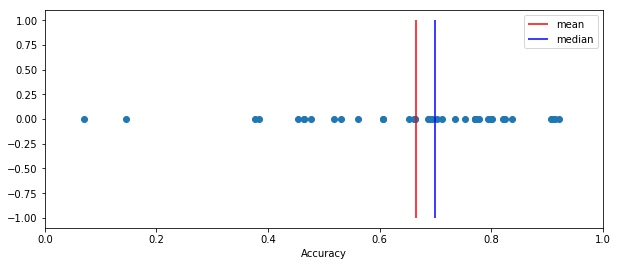

In [27]:
#what about others?
sorted_r = np.argsort([value[-1] for value in logL_encontrados])[::-1]
print(np.asarray(alphas_enc)[sorted_r])
plt.figure(figsize=(10,4))
plt.scatter(accTE_encontrados,np.zeros(len(accTE_encontrados)))
plt.vlines(np.mean(accTE_encontrados),-1,1,color='r',label="mean")
plt.vlines(np.median(accTE_encontrados),-1,1,color='b',label='median')
plt.xlabel("Accuracy")
plt.xlim(0,1)
plt.legend()
plt.show()

In [47]:
from  scipy.stats import entropy
def distance_function(predicted,ob): # to cluster
    return -predicted*np.log(ob) #without sum -- over 90 = 6 -- over 90 = 3 (lambda=1)

Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.002811 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.05755801 0.26302353 0.3117163 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.51 sec)	logL: -25405.872	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23928.019	Tol1: 0.05817	Tol2: 0.57894	Tol3: 0.12102	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23318.557	Tol1: 0.02547	Tol2: 0.23731	Tol3: 0.06522	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22931.666	Tol1: 0.01659	Tol2: 0.14044	Tol3: 0.04319	
Iter 5/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22610.802	Tol1: 0.01399	Tol2: 0.10575	Tol3: 0.03378	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22322.794	Tol1: 0.01274	Tol2: 0.09781	Tol3: 0.03011	
Iter 7/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.14 sec)	logL: -24298.989	Tol1: 0.01087	Tol2: 0.06058	Tol3: 0.00725	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24035.074	Tol1: 0.01086	Tol2: 0.05407	Tol3: 0.00911	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23768.372	Tol1: 0.01110	Tol2: 0.05884	Tol3: 0.01234	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23500.840	Tol1: 0.01126	Tol2: 0.06432	Tol3: 0.01500	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23225.524	Tol1: 0.01172	Tol2: 0.07029	Tol3: 0.01714	
Iter 12/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22950.450	Tol1: 0.01184	Tol2: 0.07640	Tol3: 0.02005	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22688.108	Tol1: 0.01143	Tol2: 0.08041	Tol3: 0.02207	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22425.147	Tol1: 0.01159	Tol2: 0.08127	Tol3: 0.02328	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22163.979	Tol

Clustering Done!
Get init alphas in 0.002588 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.63007796 0.7647807  0.17265223]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 9.97 sec)	logL: -25667.645	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24244.120	Tol1: 0.05546	Tol2: 0.47848	Tol3: 0.11718	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23839.078	Tol1: 0.01671	Tol2: 0.24818	Tol3: 0.02124	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23524.706	Tol1: 0.01319	Tol2: 0.19689	Tol3: 0.02400	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23242.193	Tol1: 0.01201	Tol2: 0.17245	Tol3: 0.02194	
Iter 6/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22985.501	Tol1: 0.01104	Tol2: 0.15775	Tol3: 0.01874	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22751.616	Tol1: 0.01018	Tol2: 0.14692

M step: done,  E step: done //  (in 0.17 sec)	logL: -20312.490	Tol1: 0.00088	Tol2: 0.04021	Tol3: 0.00176	
Iter 37/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20296.427	Tol1: 0.00079	Tol2: 0.03831	Tol3: 0.00234	
Iter 38/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20278.796	Tol1: 0.00087	Tol2: 0.03611	Tol3: 0.00276	
Iter 39/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20260.279	Tol1: 0.00091	Tol2: 0.03504	Tol3: 0.00310	
Iter 40/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20243.118	Tol1: 0.00085	Tol2: 0.03316	Tol3: 0.00357	
Iter 41/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20222.678	Tol1: 0.00101	Tol2: 0.03295	Tol3: 0.00322	
Iter 42/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20205.102	Tol1: 0.00087	Tol2: 0.03168	Tol3: 0.00421	
Iter 43/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20182.477	Tol1: 0.00112	Tol2: 0.03084	Tol3: 0.00304	
Iter 44/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20163.551	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -22574.628	Tol1: 0.01245	Tol2: 0.11298	Tol3: 0.00872	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22302.867	Tol1: 0.01204	Tol2: 0.11523	Tol3: 0.00955	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22058.932	Tol1: 0.01094	Tol2: 0.11414	Tol3: 0.01016	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21833.587	Tol1: 0.01022	Tol2: 0.10814	Tol3: 0.01090	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21629.539	Tol1: 0.00935	Tol2: 0.09971	Tol3: 0.01188	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21446.250	Tol1: 0.00847	Tol2: 0.09056	Tol3: 0.01267	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21286.361	Tol1: 0.00746	Tol2: 0.08097	Tol3: 0.01321	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21154.104	Tol1: 0.00621	Tol2: 0.07219	Tol3: 0.01372	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21037.945	T

M step: done,  E step: done //  (in 10.79 sec)	logL: -27464.745	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25859.936	Tol1: 0.05843	Tol2: 0.59790	Tol3: 0.14343	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -25293.050	Tol1: 0.02192	Tol2: 0.27060	Tol3: 0.02693	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24980.693	Tol1: 0.01235	Tol2: 0.18472	Tol3: 0.00579	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24768.435	Tol1: 0.00850	Tol2: 0.14121	Tol3: 0.00674	
Iter 6/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24599.880	Tol1: 0.00681	Tol2: 0.11422	Tol3: 0.00725	
Iter 7/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24453.585	Tol1: 0.00595	Tol2: 0.09436	Tol3: 0.00684	
Iter 8/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24322.448	Tol1: 0.00536	Tol2: 0.07824	Tol3: 0.00601	
Iter 9/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24198.018	Tol1: 0.00512	Tol2: 0.06670	Tol3: 0.00481	
Iter 10

M step: done,  E step: done //  (in 0.16 sec)	logL: -22491.640	Tol1: 0.00709	Tol2: 0.08187	Tol3: 0.00240	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22338.853	Tol1: 0.00679	Tol2: 0.07742	Tol3: 0.00293	
Iter 13/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22199.921	Tol1: 0.00622	Tol2: 0.07268	Tol3: 0.00381	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22056.805	Tol1: 0.00645	Tol2: 0.06763	Tol3: 0.00455	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21923.495	Tol1: 0.00604	Tol2: 0.06399	Tol3: 0.00545	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21806.461	Tol1: 0.00534	Tol2: 0.05931	Tol3: 0.00611	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21692.253	Tol1: 0.00524	Tol2: 0.05390	Tol3: 0.00643	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21587.628	Tol1: 0.00482	Tol2: 0.05019	Tol3: 0.00696	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21491.424	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -20222.003	Tol1: 0.00131	Tol2: 0.05399	Tol3: 0.00407	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20196.896	Tol1: 0.00124	Tol2: 0.05072	Tol3: 0.00382	
Iter 28/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20169.237	Tol1: 0.00137	Tol2: 0.04941	Tol3: 0.00312	
Iter 29/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20144.844	Tol1: 0.00121	Tol2: 0.04775	Tol3: 0.00325	
Iter 30/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20124.755	Tol1: 0.00100	Tol2: 0.04680	Tol3: 0.00407	
Iter 31/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20105.436	Tol1: 0.00096	Tol2: 0.04427	Tol3: 0.00388	
Iter 32/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20086.205	Tol1: 0.00096	Tol2: 0.04322	Tol3: 0.00335	
Iter 33/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20070.830	Tol1: 0.00077	Tol2: 0.04136	Tol3: 0.00411	
Iter 34/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20053.247	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -22821.809	Tol1: 0.00962	Tol2: 0.12111	Tol3: 0.02088	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22599.541	Tol1: 0.00974	Tol2: 0.10900	Tol3: 0.02037	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22378.565	Tol1: 0.00978	Tol2: 0.10096	Tol3: 0.02097	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22157.004	Tol1: 0.00990	Tol2: 0.09501	Tol3: 0.02204	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21939.309	Tol1: 0.00983	Tol2: 0.08988	Tol3: 0.02323	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21730.014	Tol1: 0.00954	Tol2: 0.08487	Tol3: 0.02431	
Iter 11/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21535.237	Tol1: 0.00896	Tol2: 0.07939	Tol3: 0.02475	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21347.471	Tol1: 0.00872	Tol2: 0.07318	Tol3: 0.02465	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21170.014	Tol1:

M step: done,  E step: done //  (in 11.92 sec)	logL: -25023.971	
Iter 2/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -24214.325	Tol1: 0.03235	Tol2: 0.51148	Tol3: 0.09009	
Iter 3/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23810.634	Tol1: 0.01667	Tol2: 0.24765	Tol3: 0.04287	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23467.666	Tol1: 0.01440	Tol2: 0.16421	Tol3: 0.03531	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23143.404	Tol1: 0.01382	Tol2: 0.12503	Tol3: 0.03197	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22822.815	Tol1: 0.01385	Tol2: 0.10563	Tol3: 0.03066	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22518.067	Tol1: 0.01335	Tol2: 0.09609	Tol3: 0.03058	
Iter 8/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22228.579	Tol1: 0.01286	Tol2: 0.08978	Tol3: 0.03115	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21944.199	Tol1: 0.01279	Tol2: 0.08401	Tol3: 0.03188	
Iter 10

Clustering Done!
Get init alphas in 0.002377 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.67421633 0.69198745 0.7762219 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 13.45 sec)	logL: -27632.532	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -26335.962	Tol1: 0.04692	Tol2: 0.45270	Tol3: 0.09388	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25824.832	Tol1: 0.01941	Tol2: 0.26226	Tol3: 0.00426	
Iter 4/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -25459.958	Tol1: 0.01413	Tol2: 0.19089	Tol3: 0.00844	
Iter 5/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -25164.574	Tol1: 0.01160	Tol2: 0.14466	Tol3: 0.00817	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24910.520	Tol1: 0.01010	Tol2: 0.11293	Tol3: 0.00663	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24684.455	Tol1: 0.00908	Tol2: 0.0917

M step: done,  E step: done //  (in 0.18 sec)	logL: -20832.238	Tol1: 0.00594	Tol2: 0.05299	Tol3: 0.02057	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20721.039	Tol1: 0.00534	Tol2: 0.05165	Tol3: 0.01935	
Iter 24/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20627.277	Tol1: 0.00452	Tol2: 0.05017	Tol3: 0.01868	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20549.142	Tol1: 0.00379	Tol2: 0.04963	Tol3: 0.01732	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20487.093	Tol1: 0.00302	Tol2: 0.04778	Tol3: 0.01623	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20418.862	Tol1: 0.00333	Tol2: 0.04708	Tol3: 0.01444	
Iter 28/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20370.355	Tol1: 0.00238	Tol2: 0.04675	Tol3: 0.01386	
Iter 29/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20329.753	Tol1: 0.00199	Tol2: 0.04462	Tol3: 0.01278	
Iter 30/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20298.064	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -20392.765	Tol1: 0.00607	Tol2: 0.06275	Tol3: 0.02191	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20286.617	Tol1: 0.00521	Tol2: 0.05866	Tol3: 0.01869	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20200.492	Tol1: 0.00425	Tol2: 0.05328	Tol3: 0.01649	
Iter 20/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20145.807	Tol1: 0.00271	Tol2: 0.04896	Tol3: 0.01432	
Iter 21/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20095.430	Tol1: 0.00250	Tol2: 0.04632	Tol3: 0.01196	
Iter 22/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20055.038	Tol1: 0.00201	Tol2: 0.04576	Tol3: 0.00964	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20025.620	Tol1: 0.00147	Tol2: 0.04453	Tol3: 0.00823	
Iter 24/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20003.267	Tol1: 0.00112	Tol2: 0.04443	Tol3: 0.00679	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19980.510	T

M step: done,  E step: done //  (in 0.17 sec)	logL: -22901.213	Tol1: 0.01186	Tol2: 0.09891	Tol3: 0.00790	
Iter 11/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22619.382	Tol1: 0.01231	Tol2: 0.10097	Tol3: 0.00865	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22353.096	Tol1: 0.01177	Tol2: 0.10239	Tol3: 0.00988	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22095.806	Tol1: 0.01151	Tol2: 0.10004	Tol3: 0.01107	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21849.491	Tol1: 0.01115	Tol2: 0.09392	Tol3: 0.01198	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21624.028	Tol1: 0.01032	Tol2: 0.08664	Tol3: 0.01290	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21418.396	Tol1: 0.00951	Tol2: 0.07692	Tol3: 0.01362	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21242.268	Tol1: 0.00822	Tol2: 0.06812	Tol3: 0.01418	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21091.093	T

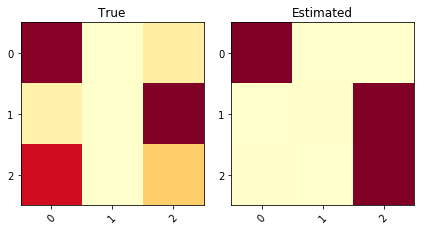

KL divergence: 1.0820	Pearson Correlation between diagonals: 0.7264


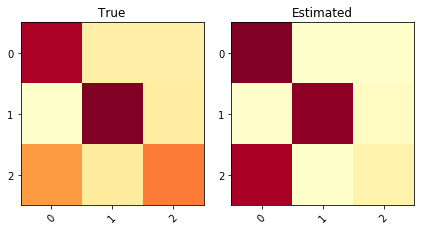

KL divergence: 0.4887	Pearson Correlation between diagonals: 0.9750


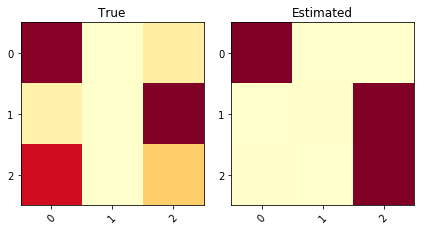

KL divergence: 1.0820	Pearson Correlation between diagonals: 0.7264


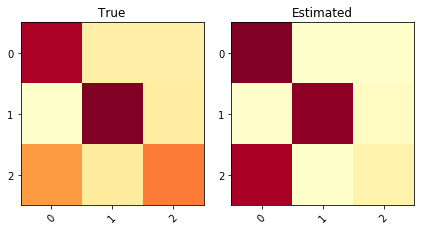

KL divergence: 0.4887	Pearson Correlation between diagonals: 0.9750


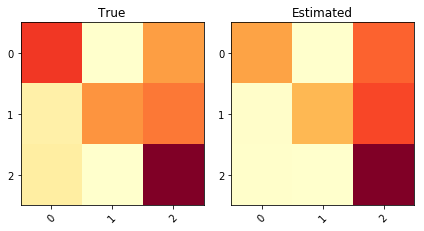

KL divergence: 0.1084	Pearson Correlation between diagonals: 0.9566


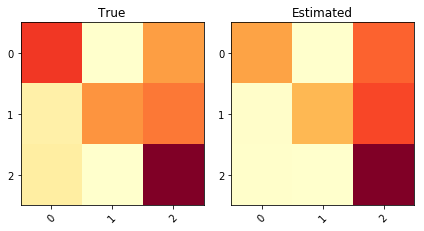

KL divergence: 0.1084	Pearson Correlation between diagonals: 0.9566


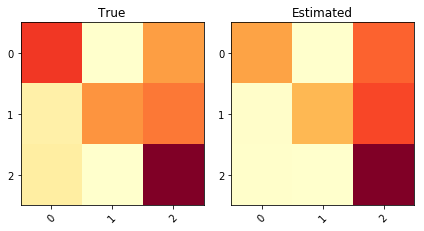

KL divergence: 0.1084	Pearson Correlation between diagonals: 0.9566


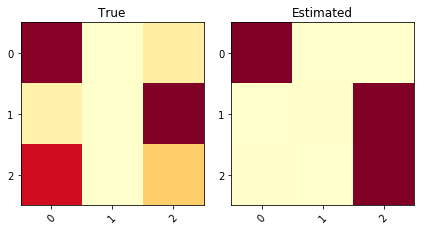

KL divergence: 1.0820	Pearson Correlation between diagonals: 0.7264


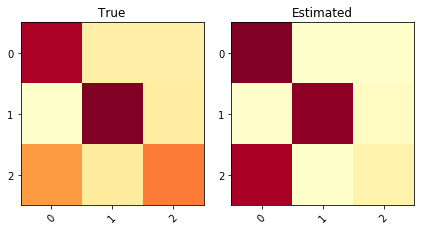

KL divergence: 0.4887	Pearson Correlation between diagonals: 0.9750


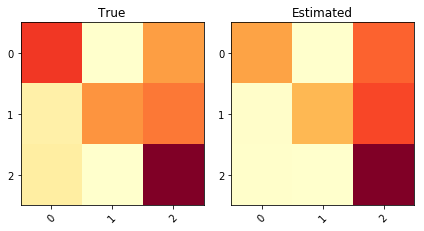

KL divergence: 0.1084	Pearson Correlation between diagonals: 0.9566


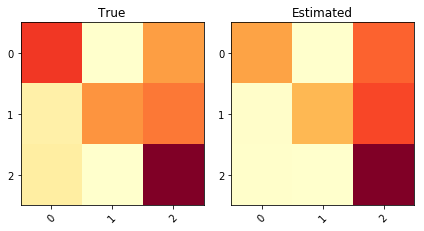

KL divergence: 0.1084	Pearson Correlation between diagonals: 0.9566


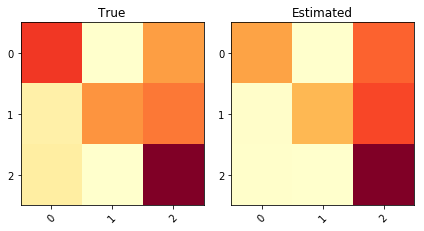

KL divergence: 0.1084	Pearson Correlation between diagonals: 0.9566


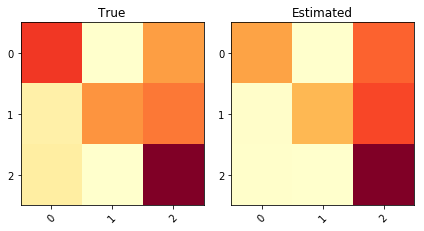

KL divergence: 0.1084	Pearson Correlation between diagonals: 0.9566


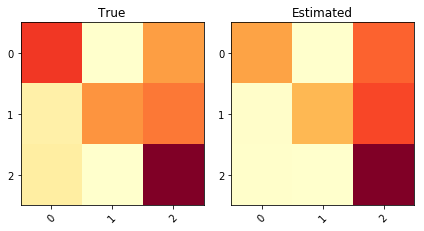

KL divergence: 0.1084	Pearson Correlation between diagonals: 0.9566


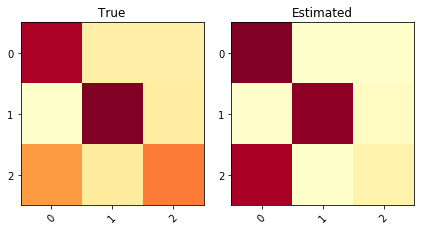

KL divergence: 0.4887	Pearson Correlation between diagonals: 0.9750
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.919821      0.919821   0.592923   0.080533            0.869099
====  ======  ==========  ============  =========  =========  ==================


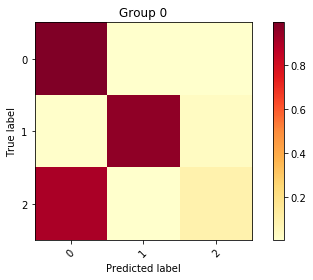

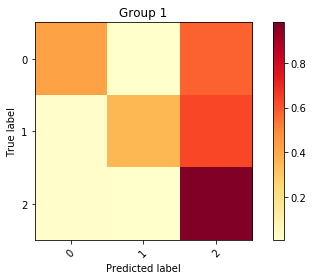

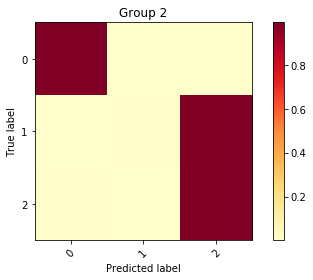

Inertia: 0.27519427488247555
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  ======  =========  ===========  =========  =============  =========
   0         0  0.439099      43  0.179029      0.682166   0.822304       0.7334     0.523249
   1         1  0.248171      24  0.516465      0.583704   0.645374       0.723287   0.375557
   2         2  0.31273       31  0.0648573     0.663516   1.58317        0.675771   0.495274
====  ========  ========  ======  =========  ===========  =========  =============  =========


In [29]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))
print("std accuracy of runs:", np.std(accTE_encontrados))
print("Median accuracy of runs:", np.median(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc model

[[0.37225753 0.12147626 0.50626624]
 [0.41605923 0.2219558  0.36198497]
 [0.36806488 0.12816554 0.5037696 ]
 [0.37826246 0.13464354 0.48709399]
 [0.38636798 0.19344343 0.42018858]
 [0.38157764 0.22846895 0.38995343]
 [0.38816586 0.15759936 0.45423478]
 [0.3985755  0.24692261 0.35450184]
 [0.42963898 0.19933426 0.37102678]
 [0.42059246 0.15330763 0.4260999 ]
 [0.41309923 0.16797186 0.4189289 ]
 [0.40247515 0.24343042 0.35409445]
 [0.38402534 0.1621504  0.45382428]
 [0.3827936  0.16041984 0.45678657]
 [0.4306334  0.34187654 0.22749008]
 [0.41670623 0.10276698 0.4805268 ]
 [0.3770263  0.12739438 0.49557933]
 [0.38420856 0.19390446 0.421887  ]
 [0.35980695 0.28340396 0.35678905]
 [0.38522327 0.11428634 0.5004904 ]
 [0.42662007 0.19807304 0.37530687]
 [0.38852662 0.1246688  0.4868046 ]
 [0.44276217 0.18662715 0.3706107 ]
 [0.4422228  0.22291315 0.33486408]
 [0.39060637 0.11467746 0.49471617]
 [0.43225554 0.14970002 0.41804445]
 [0.3597633  0.11567149 0.5245652 ]
 [0.3694706  0.26121634 0.36

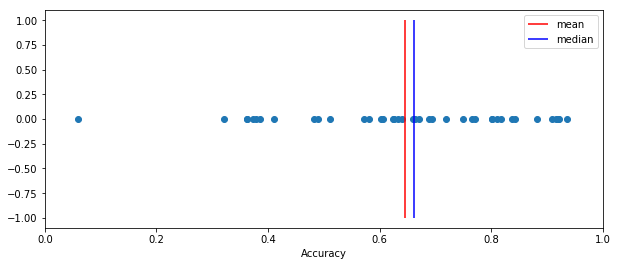

In [30]:
#what about others?
sorted_r = np.argsort([value[-1] for value in logL_encontrados])[::-1]
print(np.asarray(alphas_enc)[sorted_r])
plt.figure(figsize=(10,4))
plt.scatter(accTE_encontrados,np.zeros(len(accTE_encontrados)))
plt.vlines(np.mean(accTE_encontrados),-1,1,color='r',label="mean")
plt.vlines(np.median(accTE_encontrados),-1,1,color='b',label='median')
plt.xlabel("Accuracy")
plt.xlim(0,1)
plt.legend()
plt.show()

In [31]:
def distance_function(predicted,ob): # to cluster
    return [entropy(predicted, qk=ob)] #over 90 = 5-6 -- no son tan buenos pero encunetra 3
    

Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.005358 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.88582456 0.49948734 0.9064771 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 13.16 sec)	logL: -24708.676	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23998.874	Tol1: 0.02873	Tol2: 0.22169	Tol3: 0.04889	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23616.404	Tol1: 0.01594	Tol2: 0.08461	Tol3: 0.01829	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23229.811	Tol1: 0.01637	Tol2: 0.09453	Tol3: 0.01564	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22829.844	Tol1: 0.01722	Tol2: 0.10892	Tol3: 0.01511	
Iter 6/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22453.707	Tol1: 0.01648	Tol2: 0.12062	Tol3: 0.01459	
Iter 7/50
M step: done,  E step: done //  

M step: done,  E step: done //  (in 0.16 sec)	logL: -22240.913	Tol1: 0.01452	Tol2: 0.10457	Tol3: 0.02782	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21930.136	Tol1: 0.01397	Tol2: 0.10209	Tol3: 0.02694	
Iter 15/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21633.993	Tol1: 0.01350	Tol2: 0.09579	Tol3: 0.02499	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21377.585	Tol1: 0.01185	Tol2: 0.08690	Tol3: 0.02234	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21165.751	Tol1: 0.00991	Tol2: 0.07656	Tol3: 0.01936	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20987.439	Tol1: 0.00842	Tol2: 0.06606	Tol3: 0.01639	
Iter 19/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20841.940	Tol1: 0.00693	Tol2: 0.05615	Tol3: 0.01358	
Iter 20/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20720.908	Tol1: 0.00581	Tol2: 0.04737	Tol3: 0.01237	
Iter 21/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20620.876	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -20502.782	Tol1: 0.00058	Tol2: 0.03441	Tol3: 0.00118	
Iter 26/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20485.485	Tol1: 0.00084	Tol2: 0.03196	Tol3: 0.00083	
Iter 27/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20464.913	Tol1: 0.00100	Tol2: 0.03049	Tol3: 0.00120	
Iter 28/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20450.739	Tol1: 0.00069	Tol2: 0.03017	Tol3: 0.00132	
Iter 29/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20435.760	Tol1: 0.00073	Tol2: 0.02855	Tol3: 0.00141	
Finished training!
Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.005636 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.49938416 0.36770913 0.8464895 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 15.58 sec)	logL: -24136.672	
Iter 2/50
M step: done,  E st

Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.005646 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.906342  0.8244432 0.5441409]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 15.42 sec)	logL: -26070.725	
Iter 2/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -25547.340	Tol1: 0.02008	Tol2: 0.15695	Tol3: 0.03232	
Iter 3/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -25139.512	Tol1: 0.01596	Tol2: 0.11633	Tol3: 0.02287	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24780.614	Tol1: 0.01428	Tol2: 0.09917	Tol3: 0.01789	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24447.944	Tol1: 0.01342	Tol2: 0.09600	Tol3: 0.01362	
Iter 6/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -24123.977	Tol1: 0.01325	Tol2: 0.09644	Tol3: 0.00981	
Iter 7/50
M step: done,  E step: done //  (in

Clustering Done!
Get init alphas in 0.005471 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6455732  0.34229138 0.94981825]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 16.71 sec)	logL: -24437.291	
Iter 2/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -24009.332	Tol1: 0.01751	Tol2: 0.10419	Tol3: 0.02946	
Iter 3/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23675.084	Tol1: 0.01392	Tol2: 0.06248	Tol3: 0.01483	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23346.478	Tol1: 0.01388	Tol2: 0.06495	Tol3: 0.01120	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -23019.330	Tol1: 0.01401	Tol2: 0.07107	Tol3: 0.00989	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22697.560	Tol1: 0.01398	Tol2: 0.07532	Tol3: 0.00892	
Iter 7/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22396.362	Tol1: 0.01327	Tol2: 0.0777

M step: done,  E step: done //  (in 0.16 sec)	logL: -20552.102	Tol1: 0.00125	Tol2: 0.02868	Tol3: 0.00121	
Finished training!
Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.005281 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.48289403 0.57129973 0.07813671]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 15.34 sec)	logL: -24631.106	
Iter 2/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22270.640	Tol1: 0.09583	Tol2: 0.48266	Tol3: 0.12043	
Iter 3/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21592.259	Tol1: 0.03046	Tol2: 0.21869	Tol3: 0.06242	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -21257.895	Tol1: 0.01549	Tol2: 0.10754	Tol3: 0.03430	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21014.688	Tol1: 0.01144	Tol2: 0.07504	Tol3: 0.02215	
Iter 6/50
M step: done,  E step: 

M step: done,  E step: done //  (in 0.17 sec)	logL: -20947.399	Tol1: 0.00921	Tol2: 0.05418	Tol3: 0.01613	
Iter 10/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20781.478	Tol1: 0.00792	Tol2: 0.04904	Tol3: 0.01396	
Iter 11/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20637.802	Tol1: 0.00691	Tol2: 0.04439	Tol3: 0.01222	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20526.834	Tol1: 0.00538	Tol2: 0.04055	Tol3: 0.01035	
Iter 13/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20431.922	Tol1: 0.00462	Tol2: 0.03557	Tol3: 0.00861	
Iter 14/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20352.960	Tol1: 0.00386	Tol2: 0.02995	Tol3: 0.00691	
Finished training!
Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.005356 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.11516459 0.19311266 0.56546474]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (24

M step: done,  E step: done //  (in 0.17 sec)	logL: -21678.213	Tol1: 0.01072	Tol2: 0.07126	Tol3: 0.00798	
Iter 13/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21464.536	Tol1: 0.00986	Tol2: 0.06744	Tol3: 0.00828	
Iter 14/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21268.570	Tol1: 0.00913	Tol2: 0.06455	Tol3: 0.00833	
Iter 15/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21099.139	Tol1: 0.00797	Tol2: 0.06029	Tol3: 0.00807	
Iter 16/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20944.746	Tol1: 0.00732	Tol2: 0.05687	Tol3: 0.00768	
Iter 17/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20809.820	Tol1: 0.00644	Tol2: 0.05270	Tol3: 0.00707	
Iter 18/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20693.090	Tol1: 0.00561	Tol2: 0.05395	Tol3: 0.00638	
Iter 19/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20588.599	Tol1: 0.00505	Tol2: 0.05215	Tol3: 0.00562	
Iter 20/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20496.270	T

M step: done,  E step: done //  (in 0.19 sec)	logL: -22827.220	Tol1: 0.00821	Tol2: 0.06458	Tol3: 0.00766	
Iter 14/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22632.892	Tol1: 0.00851	Tol2: 0.06510	Tol3: 0.00781	
Iter 15/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22443.460	Tol1: 0.00837	Tol2: 0.06645	Tol3: 0.00821	
Iter 16/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22247.785	Tol1: 0.00872	Tol2: 0.06624	Tol3: 0.00852	
Iter 17/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22045.792	Tol1: 0.00908	Tol2: 0.06586	Tol3: 0.00920	
Iter 18/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21834.601	Tol1: 0.00958	Tol2: 0.06471	Tol3: 0.00980	
Iter 19/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21628.774	Tol1: 0.00943	Tol2: 0.06219	Tol3: 0.01007	
Iter 20/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21413.920	Tol1: 0.00993	Tol2: 0.05844	Tol3: 0.00990	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21212.843	T

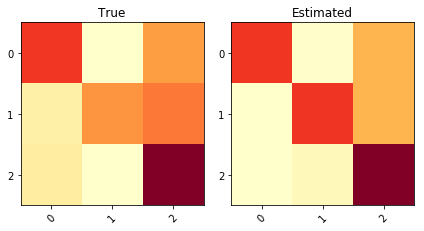

KL divergence: 0.1726	Pearson Correlation between diagonals: 0.9182


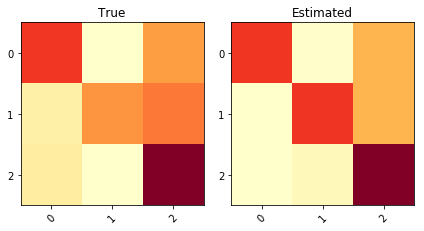

KL divergence: 0.1726	Pearson Correlation between diagonals: 0.9182


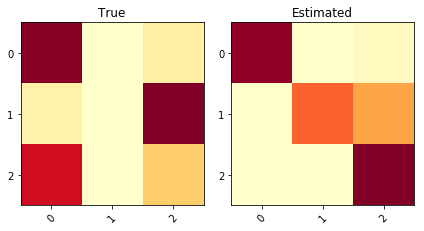

KL divergence: 1.5535	Pearson Correlation between diagonals: 0.6653


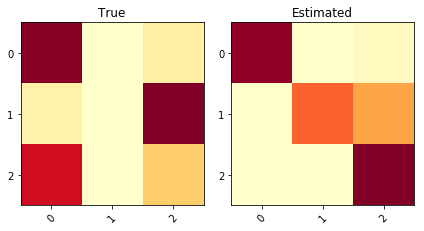

KL divergence: 1.5535	Pearson Correlation between diagonals: 0.6653


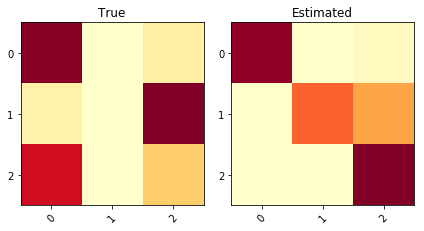

KL divergence: 1.5535	Pearson Correlation between diagonals: 0.6653


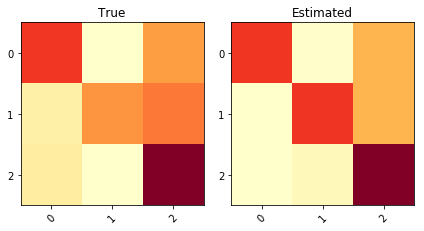

KL divergence: 0.1726	Pearson Correlation between diagonals: 0.9182


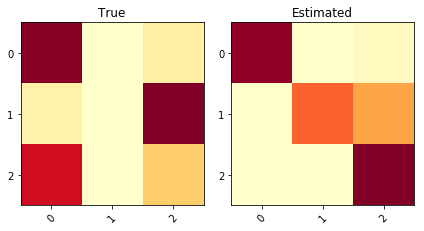

KL divergence: 1.5535	Pearson Correlation between diagonals: 0.6653


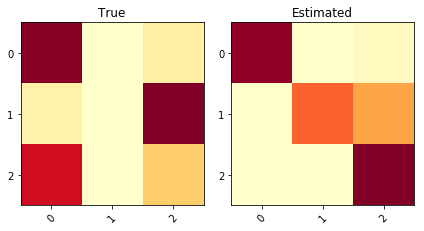

KL divergence: 1.5535	Pearson Correlation between diagonals: 0.6653


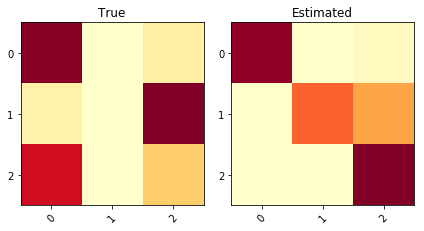

KL divergence: 1.5535	Pearson Correlation between diagonals: 0.6653


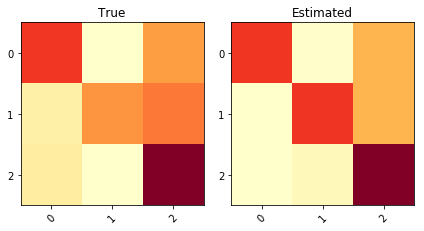

KL divergence: 0.1726	Pearson Correlation between diagonals: 0.9182


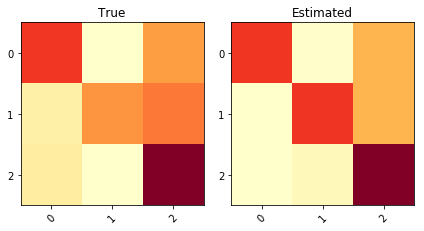

KL divergence: 0.1726	Pearson Correlation between diagonals: 0.9182


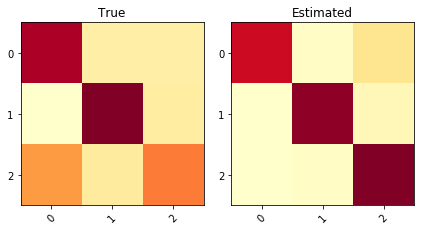

KL divergence: 0.3515	Pearson Correlation between diagonals: -0.4951


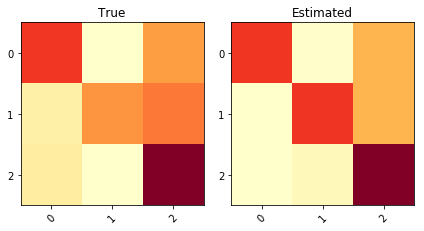

KL divergence: 0.1726	Pearson Correlation between diagonals: 0.9182


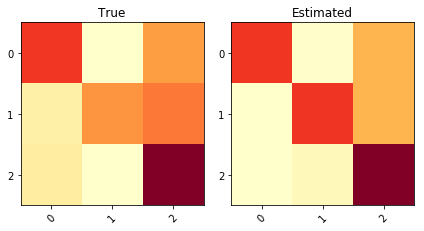

KL divergence: 0.1726	Pearson Correlation between diagonals: 0.9182


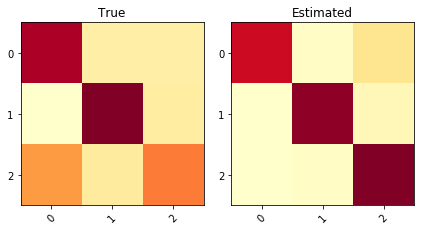

KL divergence: 0.3515	Pearson Correlation between diagonals: -0.4951
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.661783      0.661783   0.769669    0.11101            0.463705
====  ======  ==========  ============  =========  =========  ==================


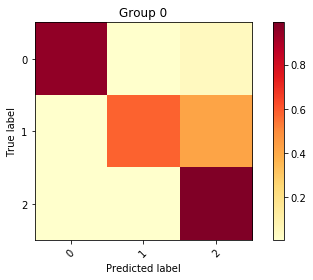

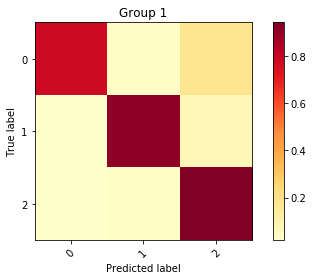

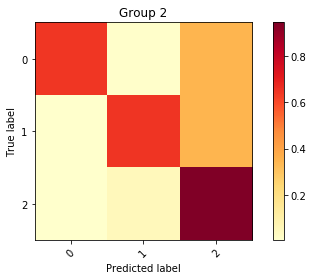

Inertia: 0.036252791061997414
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  ======  =========  ===========  =========  =============  =========
   0         0  0.495457      49   0.317705     0.841761   0.200503       0.907066   0.762641
   1         1  0.054001       5   0.415093     0.876962   0.134601       0.934467   0.815443
   2         2  0.450542      45   0.531139     0.745781   0.310003       0.854268   0.618671
====  ========  ========  ======  =========  ===========  =========  =============  =========


In [32]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))
print("std accuracy of runs:", np.std(accTE_encontrados))
print("Median accuracy of runs:", np.median(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc model

[[0.55877465 0.07199807 0.36922726]
 [0.49867183 0.05659352 0.44473466]
 [0.52449036 0.0654344  0.41007522]
 [0.24797225 0.08369192 0.6683358 ]
 [0.482451   0.08919045 0.42835853]
 [0.45157057 0.1656423  0.38278717]
 [0.51201755 0.05070283 0.4372796 ]
 [0.49889874 0.07981657 0.42128468]
 [0.5350372  0.03762371 0.42733908]
 [0.53486633 0.07392211 0.3912116 ]
 [0.57232416 0.04614525 0.3815306 ]
 [0.5322423  0.05413752 0.41362023]
 [0.52419084 0.0497655  0.4260436 ]
 [0.5338713  0.04833635 0.4177924 ]
 [0.5556641  0.06201085 0.382325  ]
 [0.5381149  0.06477018 0.3971149 ]
 [0.54687154 0.04745597 0.4056725 ]
 [0.5627164  0.02941288 0.4078707 ]
 [0.57994664 0.05506697 0.3649864 ]
 [0.5819394  0.03818183 0.3798788 ]
 [0.5757908  0.0417169  0.38249227]
 [0.5573308  0.0605899  0.3820793 ]
 [0.5953879  0.05283095 0.35178116]
 [0.20953818 0.08023363 0.71022815]
 [0.52353406 0.07222074 0.40424526]
 [0.594535   0.04396537 0.3614996 ]
 [0.3446785  0.10735425 0.5479673 ]
 [0.49407068 0.07771502 0.42

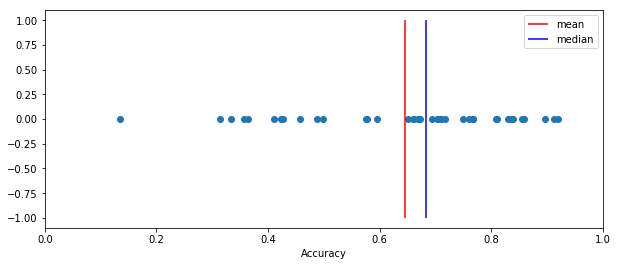

In [33]:
#what about others?
sorted_r = np.argsort([value[-1] for value in logL_encontrados])[::-1]
print(np.asarray(alphas_enc)[sorted_r])
plt.figure(figsize=(10,4))
plt.scatter(accTE_encontrados,np.zeros(len(accTE_encontrados)))
plt.vlines(np.mean(accTE_encontrados),-1,1,color='r',label="mean")
plt.vlines(np.median(accTE_encontrados),-1,1,color='b',label='median')
plt.xlabel("Accuracy")
plt.xlim(0,1)
plt.legend()
plt.show()

In [34]:
def distance_function(predicted,ob): # to cluster
    return -predicted*np.log(ob/predicted) #klwithoutsum --over 90 = 6 -- encuentra 3 grupos --over 90=7 (lambda=1)
    

Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.002725 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.65774316 0.970079   0.17171527]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 20.10 sec)	logL: -25591.966	
Iter 2/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -24878.807	Tol1: 0.02787	Tol2: 0.47980	Tol3: 0.08082	
Iter 3/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24377.179	Tol1: 0.02016	Tol2: 0.24913	Tol3: 0.03949	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23927.481	Tol1: 0.01845	Tol2: 0.18666	Tol3: 0.03261	
Iter 5/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23512.766	Tol1: 0.01733	Tol2: 0.15242	Tol3: 0.02930	
Iter 6/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23127.246	Tol1: 0.01640	Tol2: 0.13280	Tol3: 0.02803	
Iter 7/50
M step: done,  E step: done //  

M step: done,  E step: done //  (in 0.22 sec)	logL: -24465.683	Tol1: 0.01215	Tol2: 0.20471	Tol3: 0.02474	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24258.862	Tol1: 0.00845	Tol2: 0.12300	Tol3: 0.01389	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24060.339	Tol1: 0.00818	Tol2: 0.09202	Tol3: 0.01072	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23853.803	Tol1: 0.00858	Tol2: 0.08245	Tol3: 0.01024	
Iter 7/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23624.791	Tol1: 0.00960	Tol2: 0.08345	Tol3: 0.01092	
Iter 8/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23389.344	Tol1: 0.00997	Tol2: 0.08770	Tol3: 0.01236	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23155.628	Tol1: 0.00999	Tol2: 0.09357	Tol3: 0.01389	
Iter 10/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22923.598	Tol1: 0.01002	Tol2: 0.09672	Tol3: 0.01551	
Iter 11/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22702.548	Tol1: 0

M step: done,  E step: done //  (in 0.19 sec)	logL: -22946.807	Tol1: 0.00941	Tol2: 0.08731	Tol3: 0.01050	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22733.915	Tol1: 0.00928	Tol2: 0.08397	Tol3: 0.00885	
Iter 8/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22528.007	Tol1: 0.00906	Tol2: 0.08113	Tol3: 0.00847	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22338.451	Tol1: 0.00841	Tol2: 0.07842	Tol3: 0.00777	
Iter 10/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22150.579	Tol1: 0.00841	Tol2: 0.07287	Tol3: 0.00766	
Iter 11/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21976.563	Tol1: 0.00786	Tol2: 0.06975	Tol3: 0.00630	
Iter 12/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21820.427	Tol1: 0.00710	Tol2: 0.06625	Tol3: 0.00444	
Iter 13/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21684.253	Tol1: 0.00624	Tol2: 0.06072	Tol3: 0.00370	
Iter 14/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21567.123	Tol1

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.56974775 0.9593133  0.89949965]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 18.82 sec)	logL: -24963.452	
Iter 2/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -23543.783	Tol1: 0.05687	Tol2: 0.49015	Tol3: 0.06291	
Iter 3/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23085.988	Tol1: 0.01944	Tol2: 0.24905	Tol3: 0.01582	
Iter 4/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22748.041	Tol1: 0.01464	Tol2: 0.18506	Tol3: 0.01081	
Iter 5/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22457.608	Tol1: 0.01277	Tol2: 0.16095	Tol3: 0.01028	
Iter 6/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22183.006	Tol1: 0.01223	Tol2: 0.14519	Tol3: 0.01111	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21932.423	Tol1: 0.01130	Tol2: 0.13306	Tol3: 0.01250	
Iter 8/50
M step: done,  E step: done //  (in 0.18 sec)	

M step: done,  E step: done //  (in 0.19 sec)	logL: -24206.004	Tol1: 0.00855	Tol2: 0.11288	Tol3: 0.01231	
Iter 6/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23988.193	Tol1: 0.00900	Tol2: 0.10076	Tol3: 0.01344	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23762.824	Tol1: 0.00939	Tol2: 0.09637	Tol3: 0.01565	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23525.405	Tol1: 0.00999	Tol2: 0.09849	Tol3: 0.01790	
Iter 9/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23281.453	Tol1: 0.01037	Tol2: 0.10231	Tol3: 0.02013	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -23039.585	Tol1: 0.01039	Tol2: 0.10699	Tol3: 0.02202	
Iter 11/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22794.532	Tol1: 0.01064	Tol2: 0.10997	Tol3: 0.02362	
Iter 12/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22557.982	Tol1: 0.01038	Tol2: 0.10970	Tol3: 0.02498	
Iter 13/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22319.775	Tol1:

M step: done,  E step: done //  (in 0.37 sec)	logL: -20915.325	Tol1: 0.01030	Tol2: 0.07018	Tol3: 0.02404	
Iter 16/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20730.700	Tol1: 0.00883	Tol2: 0.06602	Tol3: 0.02164	
Iter 17/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20572.684	Tol1: 0.00762	Tol2: 0.06105	Tol3: 0.01864	
Iter 18/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20440.391	Tol1: 0.00643	Tol2: 0.05592	Tol3: 0.01591	
Iter 19/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20331.929	Tol1: 0.00531	Tol2: 0.05134	Tol3: 0.01309	
Iter 20/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20245.084	Tol1: 0.00427	Tol2: 0.04627	Tol3: 0.01048	
Iter 21/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20183.247	Tol1: 0.00305	Tol2: 0.04025	Tol3: 0.00873	
Iter 22/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20127.148	Tol1: 0.00278	Tol2: 0.03724	Tol3: 0.00670	
Iter 23/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20089.871	T

M step: done,  E step: done //  (in 0.19 sec)	logL: -21648.280	Tol1: 0.01142	Tol2: 0.07813	Tol3: 0.02889	
Iter 12/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21421.280	Tol1: 0.01049	Tol2: 0.07614	Tol3: 0.02803	
Iter 13/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21213.132	Tol1: 0.00972	Tol2: 0.07307	Tol3: 0.02670	
Iter 14/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21022.967	Tol1: 0.00896	Tol2: 0.06918	Tol3: 0.02472	
Iter 15/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20856.009	Tol1: 0.00794	Tol2: 0.06411	Tol3: 0.02261	
Iter 16/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20715.322	Tol1: 0.00675	Tol2: 0.05839	Tol3: 0.02011	
Iter 17/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20587.675	Tol1: 0.00616	Tol2: 0.05163	Tol3: 0.01826	
Iter 18/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20479.548	Tol1: 0.00525	Tol2: 0.04513	Tol3: 0.01637	
Iter 19/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20391.513	T

M step: done,  E step: done //  (in 0.25 sec)	logL: -23642.877	Tol1: 0.00980	Tol2: 0.08503	Tol3: 0.00426	
Iter 8/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23415.403	Tol1: 0.00962	Tol2: 0.08634	Tol3: 0.00464	
Iter 9/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23197.283	Tol1: 0.00932	Tol2: 0.08855	Tol3: 0.00481	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22987.630	Tol1: 0.00904	Tol2: 0.08880	Tol3: 0.00573	
Iter 11/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22792.606	Tol1: 0.00848	Tol2: 0.08667	Tol3: 0.00721	
Iter 12/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22609.946	Tol1: 0.00801	Tol2: 0.08193	Tol3: 0.00864	
Iter 13/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22432.025	Tol1: 0.00787	Tol2: 0.07406	Tol3: 0.01038	
Iter 14/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -22262.721	Tol1: 0.00755	Tol2: 0.06467	Tol3: 0.01223	
Iter 15/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -22103.676	Tol

M step: done,  E step: done //  (in 0.22 sec)	logL: -23068.384	Tol1: 0.01649	Tol2: 0.15661	Tol3: 0.02806	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22717.746	Tol1: 0.01520	Tol2: 0.13952	Tol3: 0.02441	
Iter 6/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -22392.785	Tol1: 0.01430	Tol2: 0.12877	Tol3: 0.02378	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -22092.749	Tol1: 0.01340	Tol2: 0.11910	Tol3: 0.02365	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21803.032	Tol1: 0.01311	Tol2: 0.10911	Tol3: 0.02355	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21545.506	Tol1: 0.01181	Tol2: 0.09903	Tol3: 0.02355	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21319.053	Tol1: 0.01051	Tol2: 0.08750	Tol3: 0.02285	
Iter 11/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21118.369	Tol1: 0.00941	Tol2: 0.07514	Tol3: 0.02172	
Iter 12/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20951.938	Tol1: 

M step: done,  E step: done //  (in 24.16 sec)	logL: -27666.549	
Iter 2/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -26018.073	Tol1: 0.05958	Tol2: 0.52007	Tol3: 0.14253	
Iter 3/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -25559.456	Tol1: 0.01763	Tol2: 0.19639	Tol3: 0.02809	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -25324.221	Tol1: 0.00920	Tol2: 0.14025	Tol3: 0.00614	
Iter 5/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25146.136	Tol1: 0.00703	Tol2: 0.10923	Tol3: 0.00206	
Iter 6/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24996.853	Tol1: 0.00594	Tol2: 0.08463	Tol3: 0.00099	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24862.484	Tol1: 0.00538	Tol2: 0.06766	Tol3: 0.00080	
Iter 8/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24732.328	Tol1: 0.00524	Tol2: 0.05933	Tol3: 0.00262	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24595.723	Tol1: 0.00552	Tol2: 0.05740	Tol3: 0.00455	
Iter 10

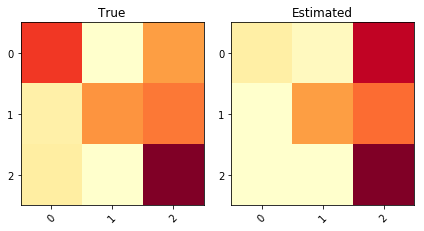

KL divergence: 0.3626	Pearson Correlation between diagonals: 0.7172


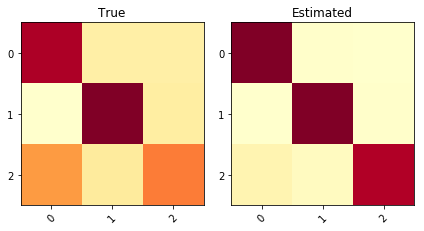

KL divergence: 0.3833	Pearson Correlation between diagonals: 0.9775


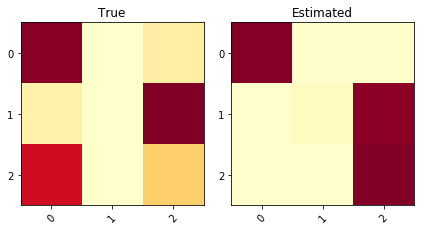

KL divergence: 1.3383	Pearson Correlation between diagonals: 0.7143


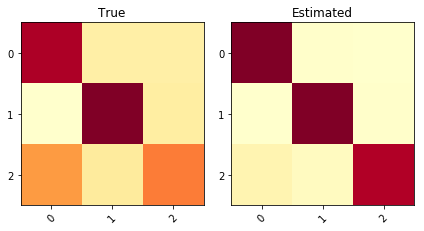

KL divergence: 0.3833	Pearson Correlation between diagonals: 0.9775


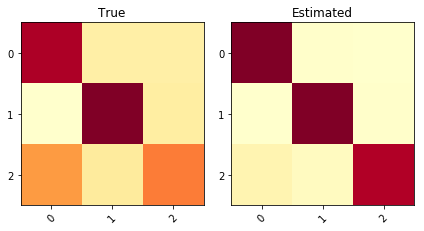

KL divergence: 0.3833	Pearson Correlation between diagonals: 0.9775


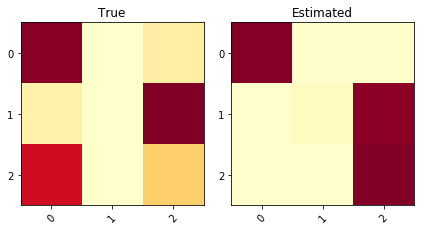

KL divergence: 1.3383	Pearson Correlation between diagonals: 0.7143


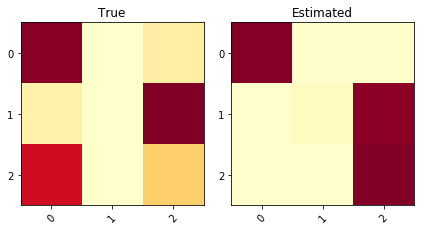

KL divergence: 1.3383	Pearson Correlation between diagonals: 0.7143


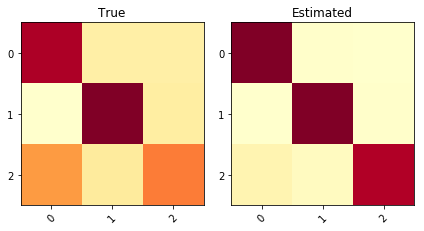

KL divergence: 0.3833	Pearson Correlation between diagonals: 0.9775


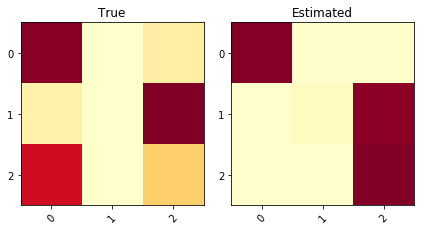

KL divergence: 1.3383	Pearson Correlation between diagonals: 0.7143


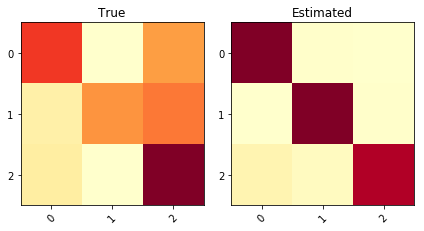

KL divergence: 1.2424	Pearson Correlation between diagonals: -0.9150


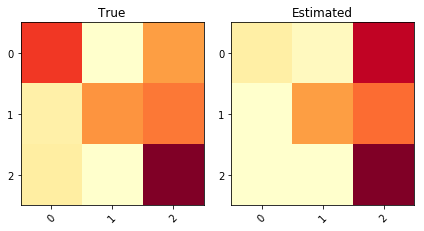

KL divergence: 0.3626	Pearson Correlation between diagonals: 0.7172


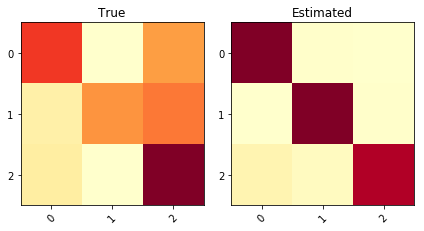

KL divergence: 1.2424	Pearson Correlation between diagonals: -0.9150


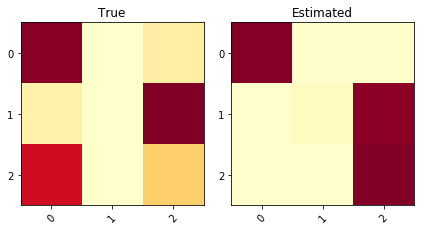

KL divergence: 1.3383	Pearson Correlation between diagonals: 0.7143


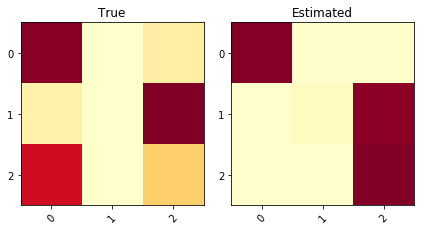

KL divergence: 1.3383	Pearson Correlation between diagonals: 0.7143


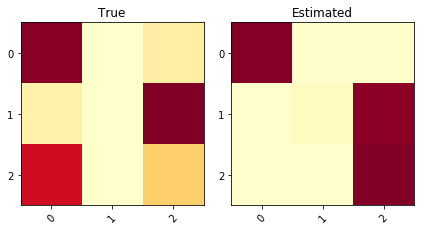

KL divergence: 1.3383	Pearson Correlation between diagonals: 0.7143
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.740334      0.740334   0.975074    0.11304             0.35615
====  ======  ==========  ============  =========  =========  ==================


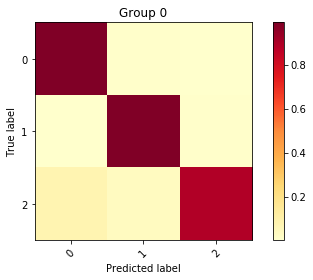

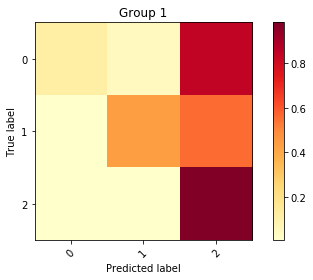

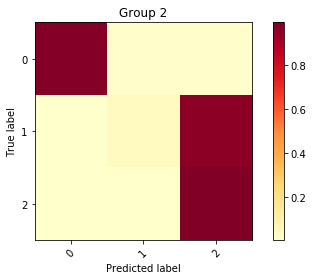

Inertia: 0.21836110452810922
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  ======  =========  ===========  =========  =============  =========
   0         0  0.393631      39   0.177194     0.956789  0.0454623       0.977599   0.935183
   1         1  0.128556      12   0.441969     0.511322  1.00586         0.631073   0.266983
   2         2  0.477813      47   0.11032      0.668056  1.14344         0.69719    0.502084
====  ========  ========  ======  =========  ===========  =========  =============  =========


In [35]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))
print("std accuracy of runs:", np.std(accTE_encontrados))
print("Median accuracy of runs:", np.median(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc model

[[0.526738   0.13037504 0.34288698]
 [0.43136504 0.13254534 0.43608963]
 [0.52344704 0.17310521 0.30344772]
 [0.3936313  0.1285555  0.47781318]
 [0.41245946 0.14074416 0.44679636]
 [0.42940158 0.16198927 0.40860915]
 [0.44144303 0.13767357 0.4208834 ]
 [0.4436087  0.18513286 0.37125847]
 [0.42677045 0.15744402 0.41578552]
 [0.42562932 0.10323695 0.4711337 ]
 [0.4395623  0.13296954 0.42746815]
 [0.50211823 0.09155662 0.40632516]
 [0.4187355  0.12277433 0.45849016]
 [0.4186212  0.12372269 0.4576561 ]
 [0.4463554  0.16500829 0.38863632]
 [0.47804365 0.22578733 0.29616904]
 [0.41847056 0.14057706 0.4409524 ]
 [0.43622434 0.1310366  0.43273908]
 [0.4315865  0.10029224 0.46812126]
 [0.48584455 0.10914601 0.40500945]
 [0.44902837 0.16880263 0.38216898]
 [0.40789846 0.1633988  0.42870274]
 [0.4458969  0.22808252 0.3260206 ]
 [0.3918595  0.13959892 0.46854156]
 [0.41153395 0.1453821  0.44308394]
 [0.4104832  0.12236044 0.46715638]
 [0.4816074  0.19949229 0.3189003 ]
 [0.41481036 0.23535566 0.34

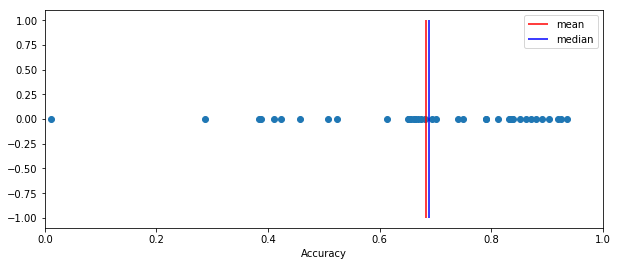

In [36]:
#what about others?
sorted_r = np.argsort([value[-1] for value in logL_encontrados])[::-1]
print(np.asarray(alphas_enc)[sorted_r])
plt.figure(figsize=(10,4))
plt.scatter(accTE_encontrados,np.zeros(len(accTE_encontrados)))
plt.vlines(np.mean(accTE_encontrados),-1,1,color='r',label="mean")
plt.vlines(np.median(accTE_encontrados),-1,1,color='b',label='median')
plt.xlabel("Accuracy")
plt.xlim(0,1)
plt.legend()
plt.show()

In [39]:
def distance_function(predicted,ob): # to cluster
    return -predicted*np.log(ob/predicted) 
 #model

Needed params (units,deep,drop,BatchN?)
loss is done
Clustering Done!
Get init alphas in 0.501621 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.50765496 0.38249573 0.26042685]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 22.71 sec)	logL: -26012.953	
Iter 2/50
M step: done,  E step: done //  (in 0.34 sec)	logL: -24475.703	Tol1: 0.05910	Tol2: 0.54359	Tol3: 0.15605	
Iter 3/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -24027.141	Tol1: 0.01833	Tol2: 0.20792	Tol3: 0.02159	
Iter 4/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23681.965	Tol1: 0.01437	Tol2: 0.13833	Tol3: 0.01105	
Iter 5/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -23368.368	Tol1: 0.01324	Tol2: 0.11759	Tol3: 0.01199	
Iter 6/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23063.736	Tol1: 0.01304	Tol2: 0.11229	Tol3: 0.01324	
Iter 7/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.21 sec)	logL: -20229.162	Tol1: 0.00344	Tol2: 0.06158	Tol3: 0.01633	
Iter 22/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20175.113	Tol1: 0.00267	Tol2: 0.05825	Tol3: 0.01349	
Iter 23/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -20129.188	Tol1: 0.00228	Tol2: 0.05576	Tol3: 0.01077	
Iter 24/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20095.167	Tol1: 0.00169	Tol2: 0.05080	Tol3: 0.00912	
Iter 25/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20062.252	Tol1: 0.00164	Tol2: 0.04732	Tol3: 0.00761	
Iter 26/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20038.322	Tol1: 0.00119	Tol2: 0.04589	Tol3: 0.00603	
Iter 27/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20022.599	Tol1: 0.00078	Tol2: 0.04248	Tol3: 0.00519	
Iter 28/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20009.970	Tol1: 0.00063	Tol2: 0.03979	Tol3: 0.00441	
Iter 29/50
M step: done,  E step: done //  (in 0.33 sec)	logL: -19995.608	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -23719.035	Tol1: 0.01323	Tol2: 0.14380	Tol3: 0.03994	
Iter 6/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23424.748	Tol1: 0.01241	Tol2: 0.11901	Tol3: 0.03826	
Iter 7/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -23137.284	Tol1: 0.01227	Tol2: 0.10259	Tol3: 0.03693	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22849.261	Tol1: 0.01245	Tol2: 0.09304	Tol3: 0.03642	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22552.805	Tol1: 0.01297	Tol2: 0.08755	Tol3: 0.03588	
Iter 10/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22253.059	Tol1: 0.01329	Tol2: 0.08400	Tol3: 0.03542	
Iter 11/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21961.238	Tol1: 0.01311	Tol2: 0.07989	Tol3: 0.03373	
Iter 12/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21689.302	Tol1: 0.01238	Tol2: 0.07789	Tol3: 0.03147	
Iter 13/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -21441.226	Tol1:

M step: done,  E step: done //  (in 0.20 sec)	logL: -20320.951	Tol1: 0.00135	Tol2: 0.03532	Tol3: 0.00697	
Iter 30/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20299.739	Tol1: 0.00104	Tol2: 0.03466	Tol3: 0.00672	
Iter 31/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20282.364	Tol1: 0.00086	Tol2: 0.03236	Tol3: 0.00650	
Iter 32/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20267.496	Tol1: 0.00073	Tol2: 0.03111	Tol3: 0.00628	
Iter 33/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20245.467	Tol1: 0.00109	Tol2: 0.03145	Tol3: 0.00576	
Iter 34/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20233.503	Tol1: 0.00059	Tol2: 0.03210	Tol3: 0.00566	
Iter 35/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20222.521	Tol1: 0.00054	Tol2: 0.03197	Tol3: 0.00518	
Iter 36/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20206.232	Tol1: 0.00081	Tol2: 0.03093	Tol3: 0.00470	
Iter 37/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20195.672	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -24195.787	Tol1: 0.03436	Tol2: 0.53648	Tol3: 0.14110	
Iter 3/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -23804.358	Tol1: 0.01618	Tol2: 0.24428	Tol3: 0.05117	
Iter 4/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -23508.650	Tol1: 0.01242	Tol2: 0.16232	Tol3: 0.03619	
Iter 5/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23236.180	Tol1: 0.01159	Tol2: 0.12757	Tol3: 0.02996	
Iter 6/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -22965.526	Tol1: 0.01165	Tol2: 0.11568	Tol3: 0.02733	
Iter 7/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -22691.622	Tol1: 0.01193	Tol2: 0.10666	Tol3: 0.02651	
Iter 8/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -22403.769	Tol1: 0.01269	Tol2: 0.10028	Tol3: 0.02571	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22118.219	Tol1: 0.01275	Tol2: 0.09489	Tol3: 0.02505	
Iter 10/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21839.966	Tol1: 0.

M step: done,  E step: done //  (in 0.23 sec)	logL: -20219.504	Tol1: 0.00079	Tol2: 0.03790	Tol3: 0.00542	
Iter 42/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20207.903	Tol1: 0.00057	Tol2: 0.03813	Tol3: 0.00503	
Iter 43/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20197.917	Tol1: 0.00049	Tol2: 0.03579	Tol3: 0.00488	
Iter 44/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20189.430	Tol1: 0.00042	Tol2: 0.03410	Tol3: 0.00459	
Iter 45/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20173.136	Tol1: 0.00081	Tol2: 0.03208	Tol3: 0.00437	
Iter 46/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20166.948	Tol1: 0.00031	Tol2: 0.03173	Tol3: 0.00422	
Iter 47/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20156.797	Tol1: 0.00050	Tol2: 0.03094	Tol3: 0.00387	
Iter 48/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20145.337	Tol1: 0.00057	Tol2: 0.03122	Tol3: 0.00357	
Iter 49/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20134.640	T

M step: done,  E step: done //  (in 0.21 sec)	logL: -20876.721	Tol1: 0.00446	Tol2: 0.05339	Tol3: 0.00752	
Iter 21/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20787.156	Tol1: 0.00429	Tol2: 0.04929	Tol3: 0.00643	
Iter 22/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20715.191	Tol1: 0.00346	Tol2: 0.04599	Tol3: 0.00508	
Iter 23/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20647.247	Tol1: 0.00328	Tol2: 0.04312	Tol3: 0.00362	
Iter 24/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20583.330	Tol1: 0.00310	Tol2: 0.04044	Tol3: 0.00305	
Iter 25/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20536.583	Tol1: 0.00227	Tol2: 0.03794	Tol3: 0.00257	
Iter 26/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20488.969	Tol1: 0.00232	Tol2: 0.03565	Tol3: 0.00300	
Iter 27/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -20445.604	Tol1: 0.00212	Tol2: 0.03386	Tol3: 0.00215	
Iter 28/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20414.510	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -24505.832	Tol1: 0.00782	Tol2: 0.18871	Tol3: 0.00778	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24362.963	Tol1: 0.00583	Tol2: 0.11785	Tol3: 0.00187	
Iter 5/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -24231.252	Tol1: 0.00541	Tol2: 0.09328	Tol3: 0.00165	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24102.868	Tol1: 0.00530	Tol2: 0.08161	Tol3: 0.00230	
Iter 7/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23971.067	Tol1: 0.00547	Tol2: 0.07560	Tol3: 0.00312	
Iter 8/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -23836.186	Tol1: 0.00563	Tol2: 0.07207	Tol3: 0.00343	
Iter 9/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -23698.901	Tol1: 0.00576	Tol2: 0.06967	Tol3: 0.00349	
Iter 10/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23558.427	Tol1: 0.00593	Tol2: 0.06790	Tol3: 0.00344	
Iter 11/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23419.143	Tol1: 0

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5943577  0.5484202  0.61466193]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 30.55 sec)	logL: -24903.621	
Iter 2/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -24008.608	Tol1: 0.03594	Tol2: 0.48501	Tol3: 0.10610	
Iter 3/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -23603.272	Tol1: 0.01688	Tol2: 0.24101	Tol3: 0.04135	
Iter 4/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -23263.574	Tol1: 0.01439	Tol2: 0.16610	Tol3: 0.03633	
Iter 5/50
M step: done,  E step: done //  (in 0.40 sec)	logL: -22926.728	Tol1: 0.01448	Tol2: 0.13630	Tol3: 0.03668	
Iter 6/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -22594.301	Tol1: 0.01450	Tol2: 0.12334	Tol3: 0.03849	
Iter 7/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -22265.697	Tol1: 0.01454	Tol2: 0.11226	Tol3: 0.04024	
Iter 8/50
M step: done,  E step: done //  (in 0.22 sec)	

M step: done,  E step: done //  (in 0.23 sec)	logL: -20717.605	Tol1: 0.00239	Tol2: 0.04470	Tol3: 0.00768	
Iter 28/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20678.640	Tol1: 0.00188	Tol2: 0.04360	Tol3: 0.00660	
Iter 29/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20639.190	Tol1: 0.00191	Tol2: 0.04213	Tol3: 0.00600	
Iter 30/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -20602.092	Tol1: 0.00180	Tol2: 0.04016	Tol3: 0.00546	
Iter 31/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20564.369	Tol1: 0.00183	Tol2: 0.03911	Tol3: 0.00484	
Iter 32/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20530.974	Tol1: 0.00162	Tol2: 0.03684	Tol3: 0.00469	
Iter 33/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20495.170	Tol1: 0.00174	Tol2: 0.03504	Tol3: 0.00456	
Iter 34/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -20462.047	Tol1: 0.00162	Tol2: 0.03338	Tol3: 0.00432	
Iter 35/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20427.348	T

M step: done,  E step: done //  (in 0.22 sec)	logL: -20697.884	Tol1: 0.00465	Tol2: 0.04503	Tol3: 0.02098	
Iter 18/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20618.891	Tol1: 0.00382	Tol2: 0.04084	Tol3: 0.01838	
Iter 19/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20553.571	Tol1: 0.00317	Tol2: 0.03647	Tol3: 0.01598	
Iter 20/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20499.211	Tol1: 0.00264	Tol2: 0.03272	Tol3: 0.01373	
Iter 21/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20457.453	Tol1: 0.00204	Tol2: 0.03067	Tol3: 0.01139	
Iter 22/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -20422.353	Tol1: 0.00172	Tol2: 0.02765	Tol3: 0.00978	
Finished training!
Needed params (units,deep,drop,BatchN?)
loss is done
Clustering Done!
Get init alphas in 0.591852 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.69342184 0.30796057 0.9999874 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 

M step: done,  E step: done //  (in 0.25 sec)	logL: -21003.871	Tol1: 0.00388	Tol2: 0.05337	Tol3: 0.00742	
Iter 22/50
M step: done,  E step: done //  (in 0.31 sec)	logL: -20922.451	Tol1: 0.00388	Tol2: 0.05111	Tol3: 0.00832	
Iter 23/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20849.667	Tol1: 0.00348	Tol2: 0.05078	Tol3: 0.00884	
Iter 24/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -20780.238	Tol1: 0.00333	Tol2: 0.05107	Tol3: 0.00875	
Iter 25/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20702.428	Tol1: 0.00374	Tol2: 0.04878	Tol3: 0.00830	
Iter 26/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -20642.798	Tol1: 0.00288	Tol2: 0.04722	Tol3: 0.00805	
Iter 27/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -20586.159	Tol1: 0.00274	Tol2: 0.04996	Tol3: 0.00702	
Iter 28/50
M step: done,  E step: done //  (in 0.27 sec)	logL: -20535.828	Tol1: 0.00244	Tol2: 0.05031	Tol3: 0.00618	
Iter 29/50
M step: done,  E step: done //  (in 0.24 sec)	logL: -20497.157	T

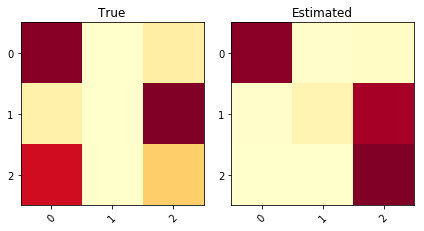

KL divergence: 1.2364	Pearson Correlation between diagonals: 0.7074


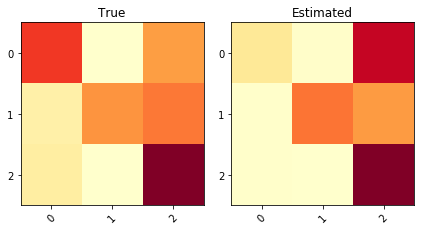

KL divergence: 0.2789	Pearson Correlation between diagonals: 0.6352


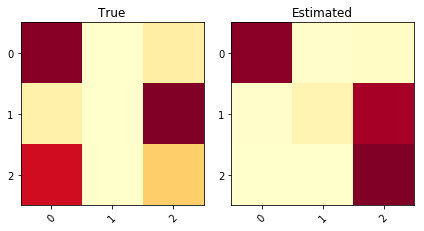

KL divergence: 1.2364	Pearson Correlation between diagonals: 0.7074


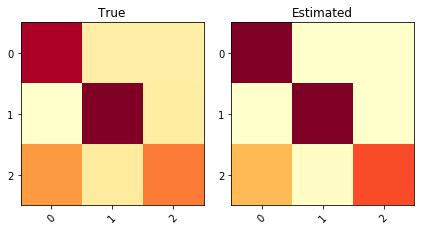

KL divergence: 0.2116	Pearson Correlation between diagonals: 0.9837


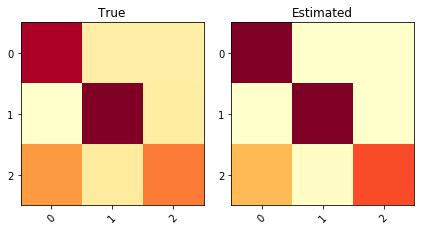

KL divergence: 0.2116	Pearson Correlation between diagonals: 0.9837


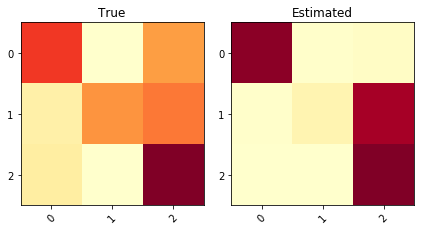

KL divergence: 0.5631	Pearson Correlation between diagonals: 0.8090


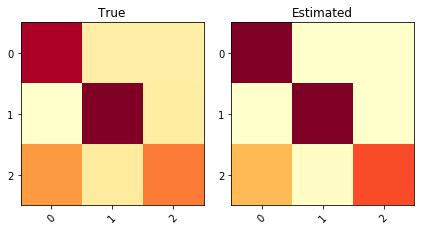

KL divergence: 0.2116	Pearson Correlation between diagonals: 0.9837


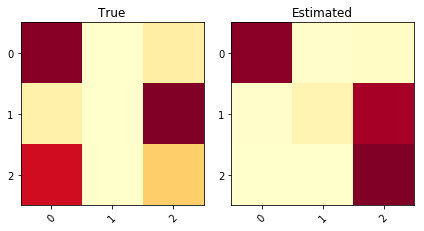

KL divergence: 1.2364	Pearson Correlation between diagonals: 0.7074


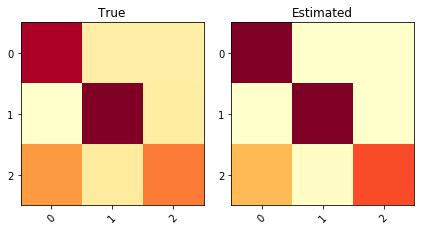

KL divergence: 0.2116	Pearson Correlation between diagonals: 0.9837


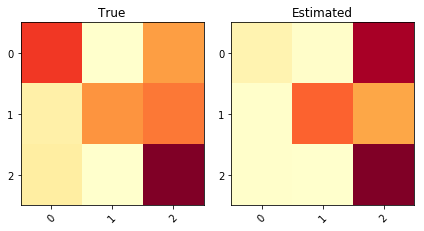

KL divergence: 0.3896	Pearson Correlation between diagonals: 0.5598


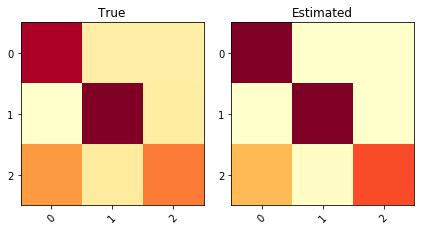

KL divergence: 0.2116	Pearson Correlation between diagonals: 0.9837


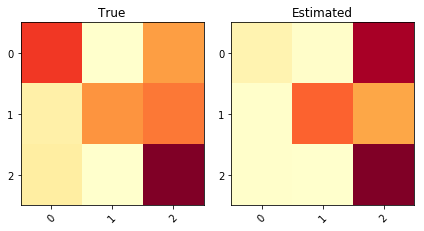

KL divergence: 0.3896	Pearson Correlation between diagonals: 0.5598


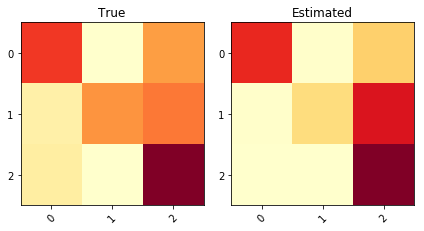

KL divergence: 0.1696	Pearson Correlation between diagonals: 0.9603


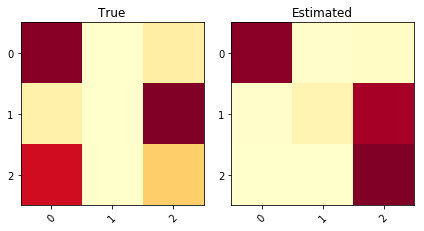

KL divergence: 1.2364	Pearson Correlation between diagonals: 0.7074


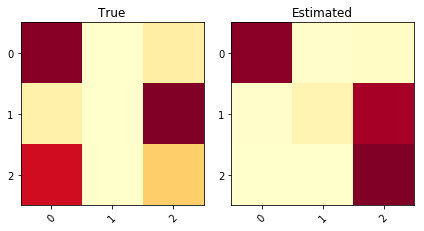

KL divergence: 1.2364	Pearson Correlation between diagonals: 0.7074
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.669923      0.669923   0.687531  0.0900746            0.756891
====  ======  ==========  ============  =========  =========  ==================


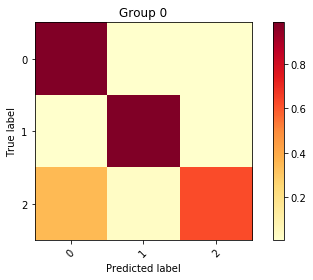

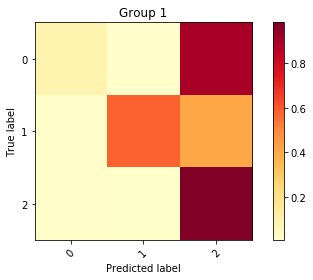

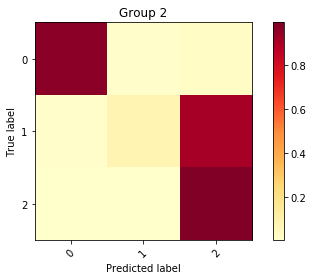

Inertia: 0.23386266082525253
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  ======  =========  ===========  =========  =============  =========
   0         0  0.45383       45   0.305615     0.866464   0.164913       0.922823   0.799696
   1         1  0.163573      16   0.395668     0.549258   1.01238        0.651399   0.323888
   2         2  0.382597      38   0.17027      0.680865   0.856875       0.728667   0.521297
====  ========  ========  ======  =========  ===========  =========  =============  =========


In [40]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))
print("std accuracy of runs:", np.std(accTE_encontrados))
print("Median accuracy of runs:", np.median(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc mode

[[0.3540082  0.20085602 0.4451358 ]
 [0.36901253 0.12317894 0.5078085 ]
 [0.39105624 0.15198007 0.4569637 ]
 [0.39657465 0.18439065 0.41903472]
 [0.50038284 0.10409537 0.39552182]
 [0.3745918  0.1721841  0.45322412]
 [0.38104236 0.19735798 0.42159966]
 [0.36211756 0.13681965 0.5010628 ]
 [0.4200265  0.23934026 0.34063327]
 [0.18251815 0.41286355 0.40461826]
 [0.3724017  0.14468284 0.48291543]
 [0.3294869  0.17633829 0.4941748 ]
 [0.35665378 0.18392113 0.45942506]
 [0.34024152 0.5011302  0.15862827]
 [0.40049413 0.42371532 0.17579056]
 [0.3858297  0.14303716 0.4711332 ]
 [0.39170355 0.13483274 0.47346368]
 [0.37911427 0.12817371 0.49271205]
 [0.36804602 0.15849827 0.4734557 ]
 [0.1772714  0.3794158  0.4433128 ]
 [0.1379162  0.36768565 0.49439812]
 [0.19488667 0.58285075 0.22226262]
 [0.31679377 0.5000548  0.18315142]
 [0.3840639  0.1669557  0.44898042]
 [0.21457432 0.47292832 0.31249735]
 [0.40446568 0.1041684  0.4913659 ]
 [0.16709535 0.3809142  0.45199043]
 [0.35430825 0.49101868 0.15

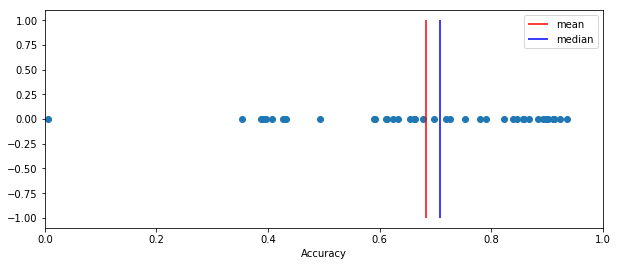

In [41]:
#what about others?
sorted_r = np.argsort([value[-1] for value in logL_encontrados])[::-1]
print(np.asarray(alphas_enc)[sorted_r])
plt.figure(figsize=(10,4))
plt.scatter(accTE_encontrados,np.zeros(len(accTE_encontrados)))
plt.vlines(np.mean(accTE_encontrados),-1,1,color='r',label="mean")
plt.vlines(np.median(accTE_encontrados),-1,1,color='b',label='median')
plt.xlabel("Accuracy")
plt.xlim(0,1)
plt.legend()
plt.show()

In [34]:
def distance_function(predicted,ob): # to cluster
    return [-np.sum(predicted*np.log(ob/predicted))] #KL sum
#model

Needed params (units,deep,drop,BatchN?)
loss is done
Clustering Done!
Get init alphas in 0.239765 mins
Initializing new EM...
Pre-train network on 0 epochs...

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


 Done!
Lambda by group:  [0.36966228 0.33989927 0.48591158]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.31 sec)	logL: -24027.924	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23510.902	Tol1: 0.02152	Tol2: 0.23281	Tol3: 0.03522	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23128.360	Tol1: 0.01627	Tol2: 0.10012	Tol3: 0.01785	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22778.494	Tol1: 0.01513	Tol2: 0.08215	Tol3: 0.01232	
Iter 5/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -22458.020	Tol1: 0.01407	Tol2: 0.08306	Tol3: 0.00948	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22155.282	Tol1: 0.01348	Tol2: 0.08359	Tol3: 0.00727	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21888.671	Tol1: 0.01203	Tol2: 0.08473	Tol3: 0.00572	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21641.293	Tol1: 0.01130	T

M step: done,  E step: done //  (in 0.30 sec)	logL: -22968.335	Tol1: 0.01427	Tol2: 0.08498	Tol3: 0.01425	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22643.539	Tol1: 0.01414	Tol2: 0.09936	Tol3: 0.01596	
Iter 13/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22330.546	Tol1: 0.01382	Tol2: 0.10781	Tol3: 0.01634	
Iter 14/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22040.800	Tol1: 0.01298	Tol2: 0.11165	Tol3: 0.01686	
Iter 15/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21775.368	Tol1: 0.01204	Tol2: 0.10929	Tol3: 0.01670	
Iter 16/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21543.481	Tol1: 0.01065	Tol2: 0.10084	Tol3: 0.01583	
Iter 17/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -21345.222	Tol1: 0.00920	Tol2: 0.08953	Tol3: 0.01499	
Iter 18/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -21184.678	Tol1: 0.00752	Tol2: 0.07697	Tol3: 0.01383	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21046.953	T

M step: done,  E step: done //  (in 0.21 sec)	logL: -23187.370	Tol1: 0.03287	Tol2: 0.32393	Tol3: 0.04295	
Iter 3/50
M step: done,  E step: done //  (in 0.25 sec)	logL: -22834.121	Tol1: 0.01523	Tol2: 0.14024	Tol3: 0.00824	
Iter 4/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22513.025	Tol1: 0.01406	Tol2: 0.11045	Tol3: 0.00226	
Iter 5/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -22191.564	Tol1: 0.01428	Tol2: 0.09762	Tol3: 0.00345	
Iter 6/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -21863.575	Tol1: 0.01478	Tol2: 0.08949	Tol3: 0.00435	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21540.653	Tol1: 0.01477	Tol2: 0.08443	Tol3: 0.00475	
Iter 8/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -21253.205	Tol1: 0.01334	Tol2: 0.07935	Tol3: 0.00481	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -20993.339	Tol1: 0.01223	Tol2: 0.07402	Tol3: 0.00480	
Iter 10/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20776.574	Tol1: 0.

M step: done,  E step: done //  (in 0.20 sec)	logL: -25975.044	Tol1: 0.02326	Tol2: 0.22444	Tol3: 0.09292	
Iter 5/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -25582.353	Tol1: 0.01512	Tol2: 0.17175	Tol3: 0.07134	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25312.719	Tol1: 0.01054	Tol2: 0.13724	Tol3: 0.05927	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25122.708	Tol1: 0.00751	Tol2: 0.11322	Tol3: 0.05120	
Iter 8/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24984.902	Tol1: 0.00549	Tol2: 0.09604	Tol3: 0.04538	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -24878.345	Tol1: 0.00426	Tol2: 0.08499	Tol3: 0.04091	
Iter 10/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -24788.991	Tol1: 0.00359	Tol2: 0.07775	Tol3: 0.03747	
Iter 11/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -24706.737	Tol1: 0.00332	Tol2: 0.07293	Tol3: 0.03471	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24623.765	Tol1: 

M step: done,  E step: done //  (in 13.81 sec)	logL: -24985.612	
Iter 2/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -24494.811	Tol1: 0.01964	Tol2: 0.18078	Tol3: 0.03349	
Iter 3/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24134.772	Tol1: 0.01470	Tol2: 0.12329	Tol3: 0.00471	
Iter 4/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23784.426	Tol1: 0.01452	Tol2: 0.10971	Tol3: 0.00175	
Iter 5/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23426.293	Tol1: 0.01506	Tol2: 0.10442	Tol3: 0.00241	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23070.567	Tol1: 0.01518	Tol2: 0.10386	Tol3: 0.00267	
Iter 7/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22724.749	Tol1: 0.01499	Tol2: 0.10321	Tol3: 0.00277	
Iter 8/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22383.034	Tol1: 0.01504	Tol2: 0.10158	Tol3: 0.00229	
Iter 9/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22081.457	Tol1: 0.01347	Tol2: 0.09975	Tol3: 0.00194	
Iter 10

M step: done,  E step: done //  (in 0.19 sec)	logL: -20406.007	Tol1: 0.00363	Tol2: 0.03861	Tol3: 0.00735	
Iter 20/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20340.985	Tol1: 0.00319	Tol2: 0.03869	Tol3: 0.00698	
Iter 21/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20283.450	Tol1: 0.00283	Tol2: 0.03790	Tol3: 0.00704	
Iter 22/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20227.398	Tol1: 0.00276	Tol2: 0.03714	Tol3: 0.00690	
Iter 23/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20187.334	Tol1: 0.00198	Tol2: 0.03710	Tol3: 0.00639	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20145.539	Tol1: 0.00207	Tol2: 0.03603	Tol3: 0.00649	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20107.303	Tol1: 0.00190	Tol2: 0.03562	Tol3: 0.00533	
Iter 26/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20070.310	Tol1: 0.00184	Tol2: 0.03355	Tol3: 0.00435	
Iter 27/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -20037.914	T

M step: done,  E step: done //  (in 0.18 sec)	logL: -19666.045	Tol1: 0.00107	Tol2: 0.04238	Tol3: 0.00305	
Iter 42/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19649.025	Tol1: 0.00087	Tol2: 0.04246	Tol3: 0.00220	
Iter 43/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19634.180	Tol1: 0.00076	Tol2: 0.04061	Tol3: 0.00183	
Iter 44/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19622.129	Tol1: 0.00061	Tol2: 0.03974	Tol3: 0.00172	
Iter 45/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19609.660	Tol1: 0.00064	Tol2: 0.03691	Tol3: 0.00212	
Iter 46/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19599.354	Tol1: 0.00053	Tol2: 0.03648	Tol3: 0.00158	
Iter 47/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -19588.989	Tol1: 0.00053	Tol2: 0.03364	Tol3: 0.00210	
Iter 48/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19584.888	Tol1: 0.00021	Tol2: 0.03072	Tol3: 0.00181	
Iter 49/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19579.390	T

M step: done,  E step: done //  (in 0.23 sec)	logL: -19823.381	Tol1: 0.00104	Tol2: 0.03163	Tol3: 0.00582	
Iter 31/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19803.933	Tol1: 0.00098	Tol2: 0.03034	Tol3: 0.00547	
Iter 32/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19783.513	Tol1: 0.00103	Tol2: 0.03183	Tol3: 0.00621	
Iter 33/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19762.713	Tol1: 0.00105	Tol2: 0.03239	Tol3: 0.00627	
Iter 34/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19745.076	Tol1: 0.00089	Tol2: 0.02758	Tol3: 0.00461	
Finished training!
Needed params (units,deep,drop,BatchN?)
loss is done
Clustering Done!
Get init alphas in 0.361138 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4877549  0.37725663 0.80929005]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 16.58 sec)	logL: -23239.667	
Iter 2/50
M step: done,  E step: 

M step: done,  E step: done //  (in 0.18 sec)	logL: -20520.797	Tol1: 0.00953	Tol2: 0.08015	Tol3: 0.01666	
Iter 16/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20359.989	Tol1: 0.00784	Tol2: 0.06955	Tol3: 0.01476	
Iter 17/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -20231.125	Tol1: 0.00633	Tol2: 0.05853	Tol3: 0.01307	
Iter 18/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -20126.360	Tol1: 0.00518	Tol2: 0.04865	Tol3: 0.01183	
Iter 19/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20045.780	Tol1: 0.00400	Tol2: 0.04127	Tol3: 0.01057	
Iter 20/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19983.279	Tol1: 0.00312	Tol2: 0.03813	Tol3: 0.00968	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19937.095	Tol1: 0.00231	Tol2: 0.03728	Tol3: 0.00899	
Iter 22/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19889.382	Tol1: 0.00239	Tol2: 0.03731	Tol3: 0.00846	
Iter 23/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -19855.341	T

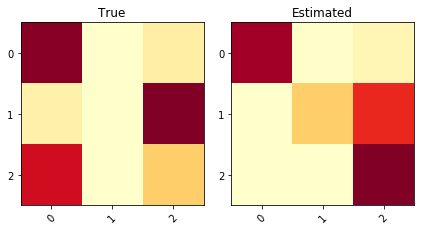

KL divergence: 1.5213	Pearson Correlation between diagonals: 0.6584


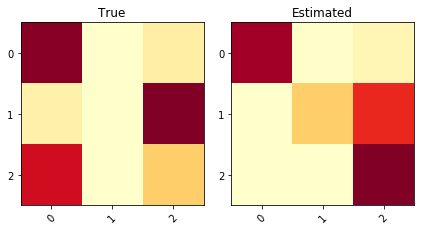

KL divergence: 1.5213	Pearson Correlation between diagonals: 0.6584


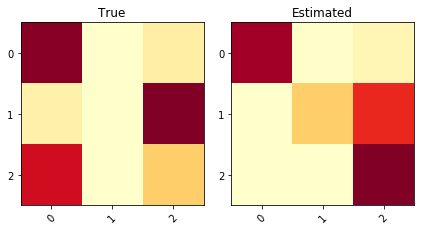

KL divergence: 1.5213	Pearson Correlation between diagonals: 0.6584


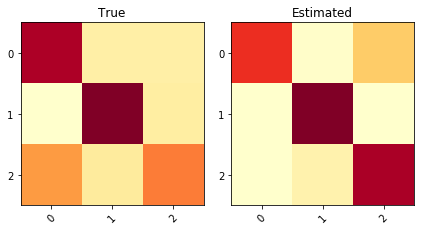

KL divergence: 0.6919	Pearson Correlation between diagonals: -0.0407


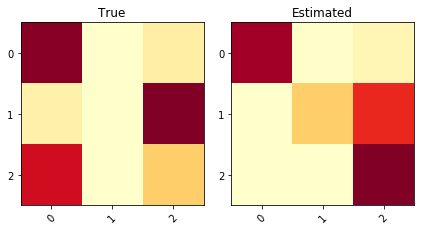

KL divergence: 1.5213	Pearson Correlation between diagonals: 0.6584


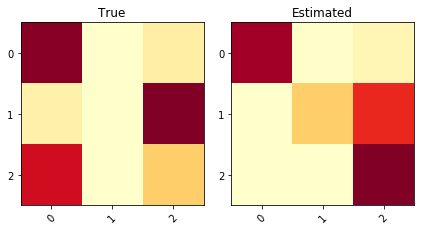

KL divergence: 1.5213	Pearson Correlation between diagonals: 0.6584


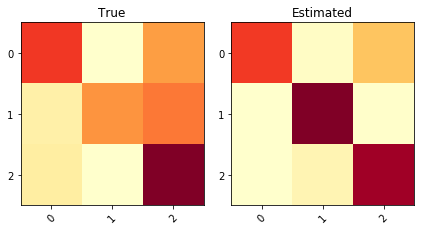

KL divergence: 0.6689	Pearson Correlation between diagonals: -0.0688


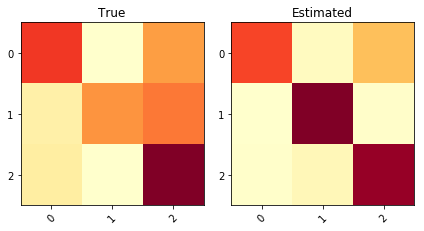

KL divergence: 0.5767	Pearson Correlation between diagonals: -0.0042


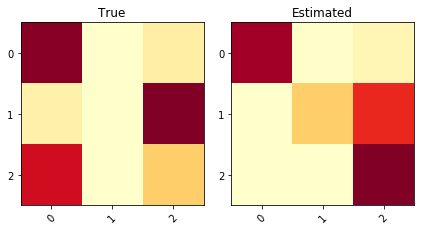

KL divergence: 1.5213	Pearson Correlation between diagonals: 0.6584


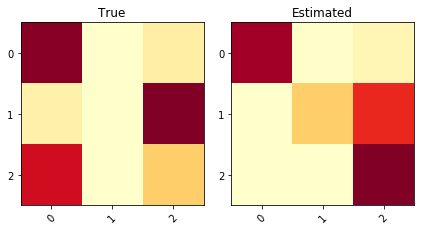

KL divergence: 1.5213	Pearson Correlation between diagonals: 0.6584


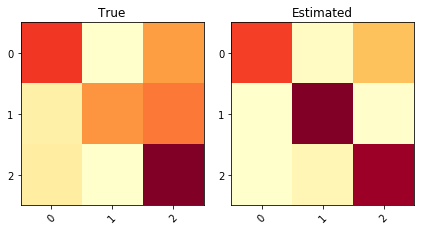

KL divergence: 0.6252	Pearson Correlation between diagonals: -0.0401


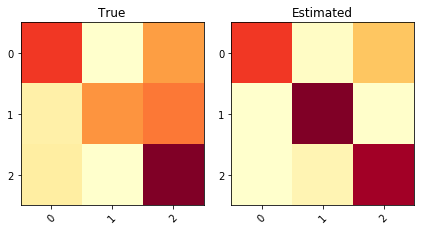

KL divergence: 0.6925	Pearson Correlation between diagonals: -0.0828


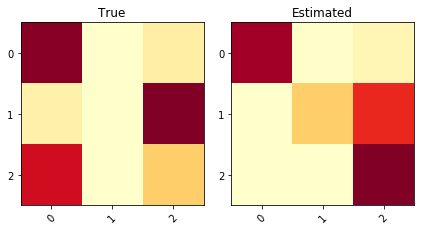

KL divergence: 1.5213	Pearson Correlation between diagonals: 0.6584


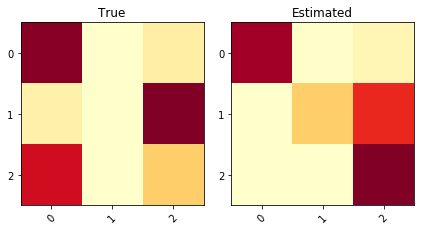

KL divergence: 1.5213	Pearson Correlation between diagonals: 0.6584


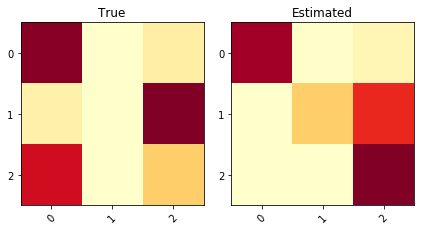

KL divergence: 1.5213	Pearson Correlation between diagonals: 0.6584
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.69068       0.69068   0.998392   0.119862            0.235567
====  ======  ==========  ============  =========  =========  ==================


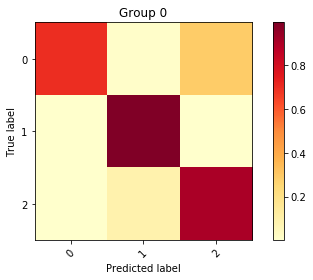

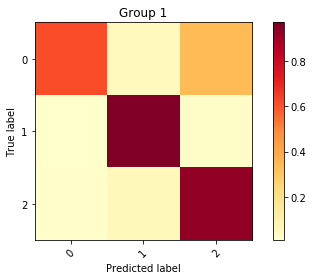

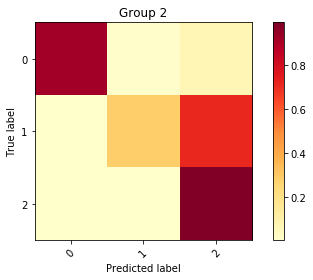

Inertia: 0.09234801943724354
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  =========  ======  =========  ===========  =========  =============  =========
   0         0  0.600492       60   0.340874     0.866647   0.15391        0.926339   0.79997
   1         1  0.0612869       6   0.418445     0.837416   0.198113       0.906956   0.756124
   2         2  0.338221       33   0.309196     0.734444   0.448828       0.815693   0.601667
====  ========  =========  ======  =========  ===========  =========  =============  =========


In [35]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))
print("std accuracy of runs:", np.std(accTE_encontrados))
print("Median accuracy of runs:", np.median(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc mode

[[0.4270894  0.08365916 0.48925143]
 [0.3440757  0.07456838 0.5813559 ]
 [0.5335902  0.04387497 0.4225348 ]
 [0.7286967  0.11532903 0.1559743 ]
 [0.43108156 0.5263122  0.04260625]
 [0.42512298 0.07127438 0.5036026 ]
 [0.3602793  0.05483568 0.58488506]
 [0.26210693 0.1079326  0.6299605 ]
 [0.47592807 0.0488102  0.4752617 ]
 [0.31277847 0.05394769 0.63327384]
 [0.3185029  0.06229755 0.6191996 ]
 [0.07526489 0.12981713 0.794918  ]
 [0.32225677 0.06237712 0.6153661 ]
 [0.33077028 0.06110139 0.6081283 ]
 [0.7406092  0.08275464 0.1766361 ]
 [0.33891353 0.05217891 0.6089076 ]
 [0.64206654 0.05759088 0.3003426 ]
 [0.3340593  0.05818598 0.6077547 ]
 [0.3078941  0.06096558 0.6311403 ]
 [0.3472     0.0528827  0.59991723]
 [0.30995506 0.03806418 0.65198076]
 [0.32999572 0.07592629 0.594078  ]
 [0.2874705  0.07158162 0.6409479 ]
 [0.18952152 0.23103474 0.57944375]
 [0.33596036 0.07255074 0.5914889 ]
 [0.35612255 0.07879294 0.5650845 ]
 [0.35384682 0.6357754  0.01037774]
 [0.3487558  0.02949387 0.62

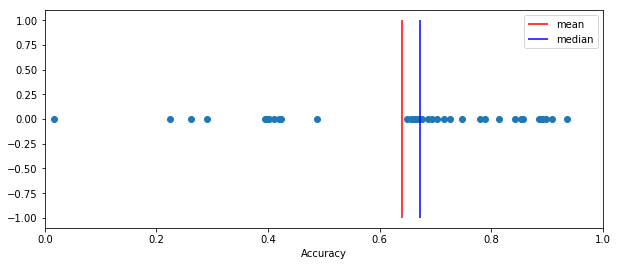

In [36]:
#what about others?
sorted_r = np.argsort([value[-1] for value in logL_encontrados])[::-1]
print(np.asarray(alphas_enc)[sorted_r])
plt.figure(figsize=(10,4))
plt.scatter(accTE_encontrados,np.zeros(len(accTE_encontrados)))
plt.vlines(np.mean(accTE_encontrados),-1,1,color='r',label="mean")
plt.vlines(np.median(accTE_encontrados),-1,1,color='b',label='median')
plt.xlabel("Accuracy")
plt.xlim(0,1)
plt.legend()
plt.show()

In [28]:
def distance_function(predicted,ob): # to cluster
    return -predicted*np.log(ob) #CE raw
#model

Needed params (units,deep,drop,BatchN?)
loss is done
Clustering Done!
Get init alphas in 0.027577 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.53746563 0.83916974 0.48039427]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -25318.588	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24515.554	Tol1: 0.03172	Tol2: 0.44984	Tol3: 0.12670	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24247.507	Tol1: 0.01093	Tol2: 0.19048	Tol3: 0.01241	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24034.496	Tol1: 0.00878	Tol2: 0.12033	Tol3: 0.00056	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23832.431	Tol1: 0.00841	Tol2: 0.09588	Tol3: 0.00135	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23621.236	Tol1: 0.00886	Tol2: 0.08514	Tol3: 0.00142	
Iter 7/50
M step: done,  E step: done //  (in 0

M step: done,  E step: done //  (in 0.11 sec)	logL: -19831.588	Tol1: 0.00070	Tol2: 0.04228	Tol3: 0.00281	
Iter 44/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19814.118	Tol1: 0.00088	Tol2: 0.03931	Tol3: 0.00259	
Iter 45/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19798.255	Tol1: 0.00080	Tol2: 0.03916	Tol3: 0.00180	
Iter 46/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19783.768	Tol1: 0.00073	Tol2: 0.03739	Tol3: 0.00201	
Iter 47/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19766.861	Tol1: 0.00085	Tol2: 0.03425	Tol3: 0.00259	
Iter 48/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19750.304	Tol1: 0.00084	Tol2: 0.03305	Tol3: 0.00250	
Iter 49/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19733.445	Tol1: 0.00085	Tol2: 0.03194	Tol3: 0.00239	
Iter 50/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19717.078	Tol1: 0.00083	Tol2: 0.03037	Tol3: 0.00183	
Finished training!
Needed params (units,deep,drop,BatchN?)
loss is done
Clu

M step: done,  E step: done //  (in 0.10 sec)	logL: -22065.620	Tol1: 0.01372	Tol2: 0.10167	Tol3: 0.02884	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21753.187	Tol1: 0.01416	Tol2: 0.09928	Tol3: 0.03024	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21455.063	Tol1: 0.01370	Tol2: 0.09447	Tol3: 0.03074	
Iter 12/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21175.433	Tol1: 0.01303	Tol2: 0.08855	Tol3: 0.03092	
Iter 13/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20916.358	Tol1: 0.01223	Tol2: 0.08153	Tol3: 0.03030	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20693.541	Tol1: 0.01065	Tol2: 0.07416	Tol3: 0.02883	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20507.643	Tol1: 0.00898	Tol2: 0.06790	Tol3: 0.02684	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20365.491	Tol1: 0.00693	Tol2: 0.06286	Tol3: 0.02429	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20239.397	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -20190.465	Tol1: 0.00191	Tol2: 0.03401	Tol3: 0.01295	
Iter 28/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20156.906	Tol1: 0.00166	Tol2: 0.03349	Tol3: 0.01222	
Iter 29/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20125.606	Tol1: 0.00155	Tol2: 0.03233	Tol3: 0.01143	
Iter 30/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20100.097	Tol1: 0.00127	Tol2: 0.03166	Tol3: 0.01069	
Iter 31/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20073.879	Tol1: 0.00130	Tol2: 0.03015	Tol3: 0.01019	
Iter 32/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20048.083	Tol1: 0.00129	Tol2: 0.02949	Tol3: 0.00957	
Finished training!
Needed params (units,deep,drop,BatchN?)
loss is done
Clustering Done!
Get init alphas in 0.053447 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.17915797 0.40882182 0.31010115]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 

M step: done,  E step: done //  (in 0.10 sec)	logL: -20311.511	Tol1: 0.00144	Tol2: 0.04515	Tol3: 0.00439	
Iter 27/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20282.651	Tol1: 0.00142	Tol2: 0.04331	Tol3: 0.00395	
Iter 28/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20261.494	Tol1: 0.00104	Tol2: 0.04321	Tol3: 0.00381	
Iter 29/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20237.645	Tol1: 0.00118	Tol2: 0.04184	Tol3: 0.00358	
Iter 30/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20216.379	Tol1: 0.00105	Tol2: 0.04163	Tol3: 0.00358	
Iter 31/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20195.301	Tol1: 0.00104	Tol2: 0.03965	Tol3: 0.00357	
Iter 32/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20173.640	Tol1: 0.00107	Tol2: 0.03834	Tol3: 0.00378	
Iter 33/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20154.781	Tol1: 0.00093	Tol2: 0.03814	Tol3: 0.00397	
Iter 34/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20133.517	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -22654.150	Tol1: 0.01261	Tol2: 0.09309	Tol3: 0.02013	
Iter 11/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22368.392	Tol1: 0.01261	Tol2: 0.08806	Tol3: 0.02145	
Iter 12/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22082.791	Tol1: 0.01277	Tol2: 0.08167	Tol3: 0.02231	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21817.446	Tol1: 0.01202	Tol2: 0.07546	Tol3: 0.02226	
Iter 14/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21579.938	Tol1: 0.01089	Tol2: 0.06916	Tol3: 0.02173	
Iter 15/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21364.805	Tol1: 0.00997	Tol2: 0.06268	Tol3: 0.01973	
Iter 16/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21186.373	Tol1: 0.00835	Tol2: 0.05815	Tol3: 0.01775	
Iter 17/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21033.872	Tol1: 0.00720	Tol2: 0.05565	Tol3: 0.01543	
Iter 18/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -20899.246	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -24536.834	Tol1: 0.01990	Tol2: 0.28468	Tol3: 0.04267	
Iter 4/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24167.427	Tol1: 0.01506	Tol2: 0.18336	Tol3: 0.03470	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23848.525	Tol1: 0.01320	Tol2: 0.13227	Tol3: 0.02980	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23552.808	Tol1: 0.01240	Tol2: 0.09937	Tol3: 0.02576	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23275.142	Tol1: 0.01179	Tol2: 0.08179	Tol3: 0.02243	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23001.824	Tol1: 0.01174	Tol2: 0.07283	Tol3: 0.02006	
Iter 9/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22735.094	Tol1: 0.01160	Tol2: 0.07080	Tol3: 0.01852	
Iter 10/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22472.944	Tol1: 0.01153	Tol2: 0.07238	Tol3: 0.01771	
Iter 11/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22208.683	Tol1: 0

M step: done,  E step: done //  (in 0.12 sec)	logL: -20128.078	Tol1: 0.00537	Tol2: 0.05482	Tol3: 0.01609	
Iter 20/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20040.183	Tol1: 0.00437	Tol2: 0.04948	Tol3: 0.01343	
Iter 21/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19971.341	Tol1: 0.00344	Tol2: 0.04557	Tol3: 0.01099	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19920.757	Tol1: 0.00253	Tol2: 0.04183	Tol3: 0.00850	
Iter 23/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19885.153	Tol1: 0.00179	Tol2: 0.03779	Tol3: 0.00654	
Iter 24/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19851.388	Tol1: 0.00170	Tol2: 0.03399	Tol3: 0.00513	
Iter 25/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19823.175	Tol1: 0.00142	Tol2: 0.03080	Tol3: 0.00417	
Iter 26/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19805.400	Tol1: 0.00090	Tol2: 0.02868	Tol3: 0.00355	
Finished training!
Needed params (units,deep,drop,BatchN?)
loss is done
Clu

M step: done,  E step: done //  (in 0.11 sec)	logL: -20722.198	Tol1: 0.00620	Tol2: 0.08196	Tol3: 0.00475	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20615.728	Tol1: 0.00514	Tol2: 0.08757	Tol3: 0.00442	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20525.265	Tol1: 0.00439	Tol2: 0.08973	Tol3: 0.00404	
Iter 26/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20450.630	Tol1: 0.00364	Tol2: 0.08450	Tol3: 0.00413	
Iter 27/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20391.032	Tol1: 0.00291	Tol2: 0.07928	Tol3: 0.00331	
Iter 28/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20341.053	Tol1: 0.00245	Tol2: 0.07127	Tol3: 0.00297	
Iter 29/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20305.704	Tol1: 0.00174	Tol2: 0.06314	Tol3: 0.00261	
Iter 30/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20280.096	Tol1: 0.00126	Tol2: 0.05351	Tol3: 0.00224	
Iter 31/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20255.003	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -20922.856	Tol1: 0.00892	Tol2: 0.06572	Tol3: 0.02241	
Iter 23/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20765.361	Tol1: 0.00753	Tol2: 0.06028	Tol3: 0.02181	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20635.103	Tol1: 0.00627	Tol2: 0.05355	Tol3: 0.02043	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20524.074	Tol1: 0.00538	Tol2: 0.04687	Tol3: 0.01881	
Iter 26/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20423.936	Tol1: 0.00488	Tol2: 0.04056	Tol3: 0.01715	
Iter 27/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20350.580	Tol1: 0.00359	Tol2: 0.03717	Tol3: 0.01550	
Iter 28/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20290.075	Tol1: 0.00297	Tol2: 0.03440	Tol3: 0.01392	
Iter 29/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20241.946	Tol1: 0.00237	Tol2: 0.03333	Tol3: 0.01207	
Iter 30/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20199.974	T

M step: done,  E step: done //  (in 0.20 sec)	logL: -20979.224	Tol1: 0.00759	Tol2: 0.06258	Tol3: 0.01458	
Iter 17/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20840.188	Tol1: 0.00663	Tol2: 0.05911	Tol3: 0.01370	
Iter 18/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20721.835	Tol1: 0.00568	Tol2: 0.05567	Tol3: 0.01389	
Iter 19/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20623.310	Tol1: 0.00475	Tol2: 0.05213	Tol3: 0.01321	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20539.466	Tol1: 0.00407	Tol2: 0.04851	Tol3: 0.01318	
Iter 21/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -20469.355	Tol1: 0.00341	Tol2: 0.04824	Tol3: 0.01316	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20413.660	Tol1: 0.00272	Tol2: 0.04471	Tol3: 0.01206	
Iter 23/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -20363.620	Tol1: 0.00245	Tol2: 0.04264	Tol3: 0.01147	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20320.175	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -24726.770	Tol1: 0.00039	Tol2: 0.12472	Tol3: 0.00102	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24714.725	Tol1: 0.00049	Tol2: 0.11149	Tol3: 0.00158	
Iter 9/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24699.834	Tol1: 0.00060	Tol2: 0.10166	Tol3: 0.00236	
Iter 10/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24680.115	Tol1: 0.00080	Tol2: 0.09374	Tol3: 0.00326	
Iter 11/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24654.270	Tol1: 0.00105	Tol2: 0.08763	Tol3: 0.00442	
Iter 12/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24617.477	Tol1: 0.00149	Tol2: 0.08288	Tol3: 0.00593	
Iter 13/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24565.142	Tol1: 0.00213	Tol2: 0.07973	Tol3: 0.00795	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24487.603	Tol1: 0.00316	Tol2: 0.07871	Tol3: 0.01078	
Iter 15/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24369.713	Tol

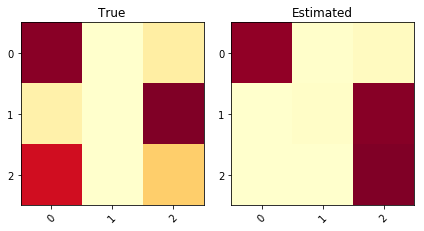

KL divergence: 1.3169	Pearson Correlation between diagonals: 0.7005


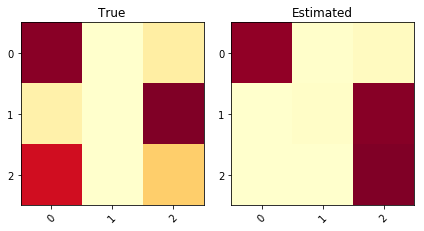

KL divergence: 1.3169	Pearson Correlation between diagonals: 0.7005


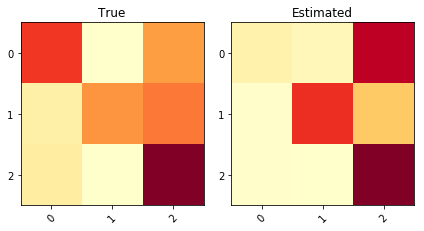

KL divergence: 0.4255	Pearson Correlation between diagonals: 0.4391


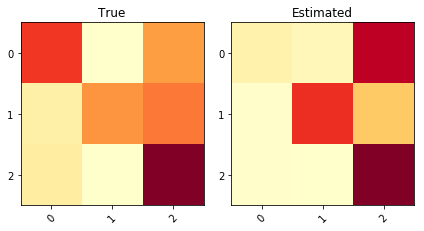

KL divergence: 0.4255	Pearson Correlation between diagonals: 0.4391


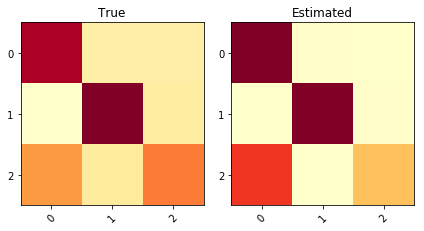

KL divergence: 0.2770	Pearson Correlation between diagonals: 0.9814


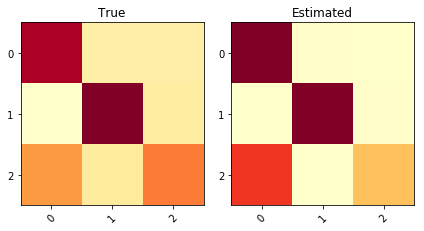

KL divergence: 0.2770	Pearson Correlation between diagonals: 0.9814


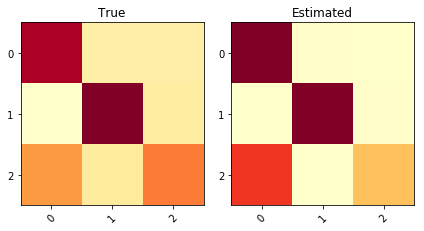

KL divergence: 0.2770	Pearson Correlation between diagonals: 0.9814


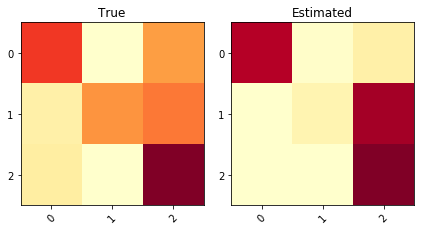

KL divergence: 0.4158	Pearson Correlation between diagonals: 0.8582


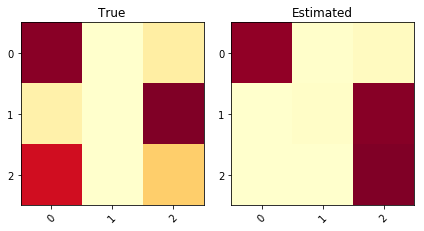

KL divergence: 1.3169	Pearson Correlation between diagonals: 0.7005


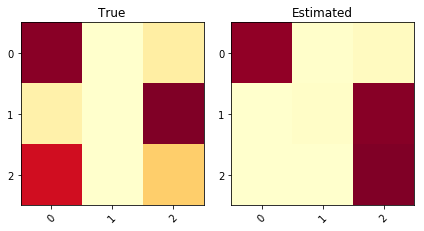

KL divergence: 1.3169	Pearson Correlation between diagonals: 0.7005


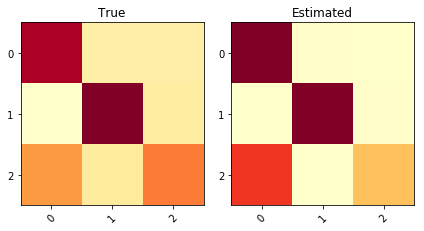

KL divergence: 0.2770	Pearson Correlation between diagonals: 0.9814


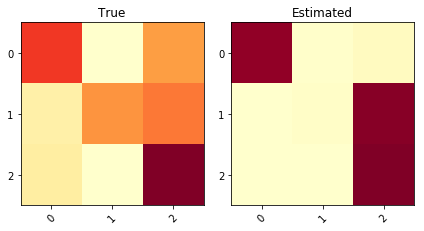

KL divergence: 0.7642	Pearson Correlation between diagonals: 0.8147


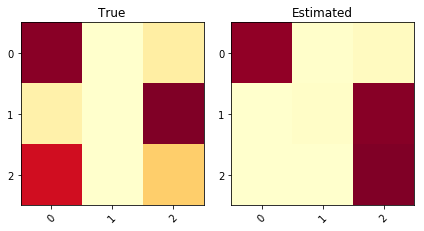

KL divergence: 1.3169	Pearson Correlation between diagonals: 0.7005


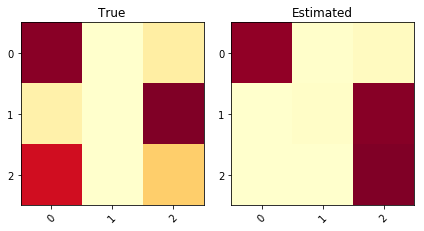

KL divergence: 1.3169	Pearson Correlation between diagonals: 0.7005


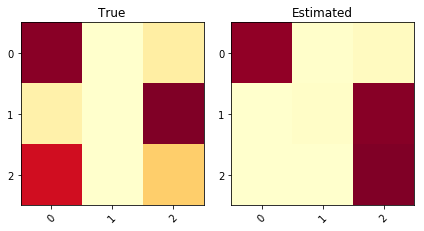

KL divergence: 1.3169	Pearson Correlation between diagonals: 0.7005
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global     0.82092       0.82092   0.756128  0.0943079            0.703184
====  ======  ==========  ============  =========  =========  ==================


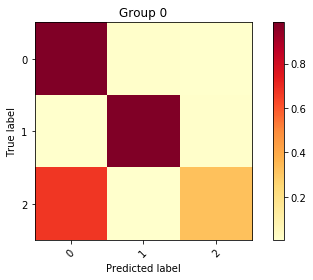

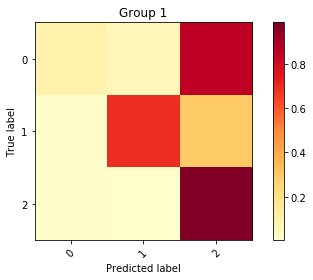

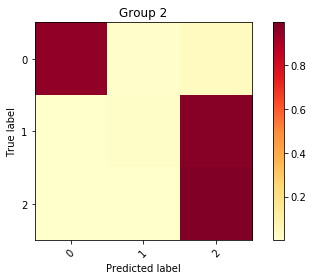

Inertia: 0.28998686621586484
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  ======  =========  ===========  =========  =============  =========
   0         0  0.068578       6   0.279679     0.76423    0.387044       0.838359   0.646345
   1         1  0.450373      45   0.412732     0.589425   0.934323       0.680415   0.384137
   2         2  0.481049      48   0.110047     0.657258   1.37706        0.679658   0.485887
====  ========  ========  ======  =========  ===========  =========  =============  =========


In [29]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))
print("std accuracy of runs:", np.std(accTE_encontrados))
print("Median accuracy of runs:", np.median(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc mode

[[0.2980171  0.17218654 0.5297963 ]
 [0.26413542 0.21591705 0.5199476 ]
 [0.39561087 0.26537624 0.3390129 ]
 [0.3964733  0.15493555 0.44859114]
 [0.33040363 0.18949865 0.4800977 ]
 [0.40992996 0.20084801 0.389222  ]
 [0.3555415  0.14084941 0.50360906]
 [0.49295118 0.45479107 0.05225773]
 [0.38269117 0.10974264 0.50756615]
 [0.35902467 0.11978336 0.52119195]
 [0.3676057  0.13059942 0.50179493]
 [0.35786638 0.08955523 0.5525784 ]
 [0.37200737 0.16929796 0.45869467]
 [0.3593251  0.16481641 0.4758585 ]
 [0.06857795 0.45037287 0.4810492 ]
 [0.29672486 0.1876998  0.51557535]
 [0.29931182 0.13464819 0.56604   ]
 [0.358512   0.14972797 0.49176   ]
 [0.36294606 0.12207998 0.51497394]
 [0.34993505 0.13819481 0.51187015]
 [0.31212685 0.15367801 0.5341951 ]
 [0.38815197 0.192227   0.41962102]
 [0.39451936 0.14505568 0.460425  ]
 [0.37304282 0.19818397 0.4287732 ]
 [0.39796746 0.22575927 0.37627324]
 [0.38999283 0.13731457 0.4726926 ]
 [0.27057433 0.24515761 0.48426804]
 [0.3636727  0.48937085 0.14

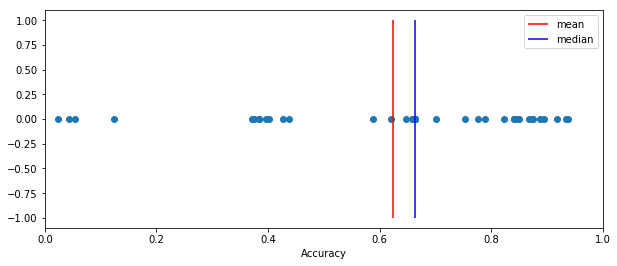

In [30]:
#what about others?
sorted_r = np.argsort([value[-1] for value in logL_encontrados])[::-1]
print(np.asarray(alphas_enc)[sorted_r])
plt.figure(figsize=(10,4))
plt.scatter(accTE_encontrados,np.zeros(len(accTE_encontrados)))
plt.vlines(np.mean(accTE_encontrados),-1,1,color='r',label="mean")
plt.vlines(np.median(accTE_encontrados),-1,1,color='b',label='median')
plt.xlabel("Accuracy")
plt.xlim(0,1)
plt.legend()
plt.show()

In [31]:
def distance_function(predicted,ob): # to cluster
    return [-np.sum(predicted*np.log(ob))] #CE sum

Needed params (units,deep,drop,BatchN?)
loss is done
Clustering Done!
Get init alphas in 0.133801 mins
Initializing new EM...
Pre-train network on 0 epochs...

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


 Done!
Lambda by group:  [0.25295806 0.93659824 0.3068569 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.54 sec)	logL: -26029.088	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25183.957	Tol1: 0.03247	Tol2: 0.23696	Tol3: 0.03958	
Iter 3/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -24509.320	Tol1: 0.02679	Tol2: 0.12492	Tol3: 0.02498	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23963.544	Tol1: 0.02227	Tol2: 0.09409	Tol3: 0.01363	
Iter 5/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -23494.928	Tol1: 0.01956	Tol2: 0.09656	Tol3: 0.01426	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23064.507	Tol1: 0.01832	Tol2: 0.10079	Tol3: 0.02197	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22657.597	Tol1: 0.01764	Tol2: 0.10761	Tol3: 0.02683	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22291.802	Tol1: 0.01614	To

M step: done,  E step: done //  (in 0.14 sec)	logL: -23754.335	Tol1: 0.01365	Tol2: 0.05495	Tol3: 0.01016	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23417.041	Tol1: 0.01420	Tol2: 0.06289	Tol3: 0.01150	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23068.113	Tol1: 0.01490	Tol2: 0.07428	Tol3: 0.01276	
Iter 8/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -22727.888	Tol1: 0.01475	Tol2: 0.08640	Tol3: 0.01403	
Iter 9/50
M step: done,  E step: done //  (in 0.23 sec)	logL: -22387.651	Tol1: 0.01497	Tol2: 0.09396	Tol3: 0.01577	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22056.896	Tol1: 0.01477	Tol2: 0.09906	Tol3: 0.01738	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21734.990	Tol1: 0.01459	Tol2: 0.10175	Tol3: 0.01942	
Iter 12/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21449.350	Tol1: 0.01314	Tol2: 0.10076	Tol3: 0.02113	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21181.691	Tol1:

M step: done,  E step: done //  (in 0.15 sec)	logL: -21716.110	Tol1: 0.01558	Tol2: 0.09108	Tol3: 0.00999	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21403.198	Tol1: 0.01441	Tol2: 0.09419	Tol3: 0.00881	
Iter 12/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21126.298	Tol1: 0.01294	Tol2: 0.09413	Tol3: 0.00751	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20892.490	Tol1: 0.01107	Tol2: 0.09056	Tol3: 0.00607	
Iter 14/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20703.797	Tol1: 0.00903	Tol2: 0.08334	Tol3: 0.00487	
Iter 15/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20538.230	Tol1: 0.00800	Tol2: 0.07329	Tol3: 0.00567	
Iter 16/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20405.898	Tol1: 0.00644	Tol2: 0.06847	Tol3: 0.00660	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20298.466	Tol1: 0.00526	Tol2: 0.06195	Tol3: 0.00784	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20198.233	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -20398.779	Tol1: 0.00263	Tol2: 0.04202	Tol3: 0.00501	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20350.530	Tol1: 0.00237	Tol2: 0.04199	Tol3: 0.00611	
Iter 26/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20301.211	Tol1: 0.00242	Tol2: 0.04155	Tol3: 0.00684	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20255.203	Tol1: 0.00227	Tol2: 0.04068	Tol3: 0.00700	
Iter 28/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20209.399	Tol1: 0.00226	Tol2: 0.04027	Tol3: 0.00709	
Iter 29/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20170.439	Tol1: 0.00193	Tol2: 0.03902	Tol3: 0.00628	
Iter 30/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20139.599	Tol1: 0.00153	Tol2: 0.03840	Tol3: 0.00616	
Iter 31/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20110.549	Tol1: 0.00144	Tol2: 0.03763	Tol3: 0.00600	
Iter 32/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20080.353	T

Clustering Done!
Get init alphas in 0.192593 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.35378593 0.27828765 0.6047359 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.43 sec)	logL: -21558.474	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -21204.023	Tol1: 0.01644	Tol2: 0.20418	Tol3: 0.01481	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20953.473	Tol1: 0.01182	Tol2: 0.13620	Tol3: 0.00949	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20767.537	Tol1: 0.00887	Tol2: 0.10605	Tol3: 0.00462	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20616.282	Tol1: 0.00728	Tol2: 0.08869	Tol3: 0.00323	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20492.337	Tol1: 0.00601	Tol2: 0.07338	Tol3: 0.00375	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20385.779	Tol1: 0.00520	Tol2: 0.05871

M step: done,  E step: done //  (in 0.15 sec)	logL: -20712.405	Tol1: 0.00702	Tol2: 0.05746	Tol3: 0.00936	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20575.037	Tol1: 0.00663	Tol2: 0.05789	Tol3: 0.01059	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20451.387	Tol1: 0.00601	Tol2: 0.05346	Tol3: 0.01118	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20328.639	Tol1: 0.00600	Tol2: 0.04692	Tol3: 0.01134	
Iter 19/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20203.494	Tol1: 0.00616	Tol2: 0.04640	Tol3: 0.01053	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20097.616	Tol1: 0.00524	Tol2: 0.04753	Tol3: 0.01035	
Iter 21/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20002.015	Tol1: 0.00476	Tol2: 0.04159	Tol3: 0.00965	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19919.846	Tol1: 0.00411	Tol2: 0.03691	Tol3: 0.00847	
Iter 23/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -19845.071	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -21764.838	Tol1: 0.01115	Tol2: 0.09611	Tol3: 0.00477	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21561.312	Tol1: 0.00935	Tol2: 0.09289	Tol3: 0.00509	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21395.025	Tol1: 0.00771	Tol2: 0.08868	Tol3: 0.00573	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21256.262	Tol1: 0.00649	Tol2: 0.08204	Tol3: 0.00520	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21135.042	Tol1: 0.00570	Tol2: 0.07845	Tol3: 0.00540	
Iter 19/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21030.956	Tol1: 0.00492	Tol2: 0.07108	Tol3: 0.00516	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20930.707	Tol1: 0.00477	Tol2: 0.06417	Tol3: 0.00515	
Iter 21/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20842.618	Tol1: 0.00421	Tol2: 0.05802	Tol3: 0.00529	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20764.299	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -20816.126	Tol1: 0.00639	Tol2: 0.05658	Tol3: 0.01072	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20709.658	Tol1: 0.00511	Tol2: 0.04588	Tol3: 0.00901	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20616.636	Tol1: 0.00449	Tol2: 0.03865	Tol3: 0.00697	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20546.046	Tol1: 0.00342	Tol2: 0.03299	Tol3: 0.00588	
Iter 21/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20483.518	Tol1: 0.00304	Tol2: 0.03232	Tol3: 0.00512	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20430.089	Tol1: 0.00261	Tol2: 0.03272	Tol3: 0.00421	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -20385.945	Tol1: 0.00216	Tol2: 0.03258	Tol3: 0.00387	
Iter 24/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20349.994	Tol1: 0.00176	Tol2: 0.03234	Tol3: 0.00405	
Iter 25/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20315.245	T

M step: done,  E step: done //  (in 12.29 sec)	logL: -26969.059	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -25881.677	Tol1: 0.04032	Tol2: 0.47951	Tol3: 0.06999	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -25367.452	Tol1: 0.01987	Tol2: 0.22098	Tol3: 0.03924	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -25036.272	Tol1: 0.01306	Tol2: 0.13867	Tol3: 0.02177	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24762.473	Tol1: 0.01094	Tol2: 0.09432	Tol3: 0.01164	
Iter 6/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24500.694	Tol1: 0.01057	Tol2: 0.06988	Tol3: 0.00634	
Iter 7/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24237.086	Tol1: 0.01076	Tol2: 0.05564	Tol3: 0.00361	
Iter 8/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -23957.163	Tol1: 0.01155	Tol2: 0.04860	Tol3: 0.00261	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23663.443	Tol1: 0.01226	Tol2: 0.04765	Tol3: 0.00417	
Iter 10

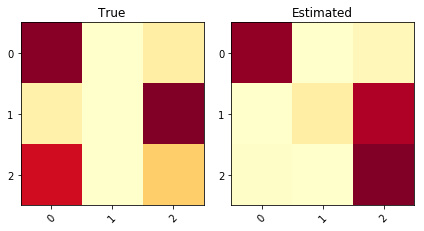

KL divergence: 0.9151	Pearson Correlation between diagonals: 0.6953


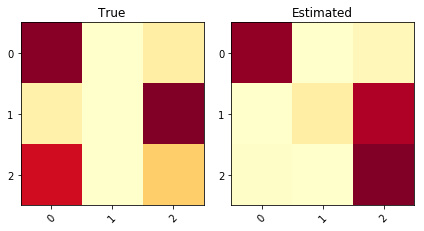

KL divergence: 0.9151	Pearson Correlation between diagonals: 0.6953


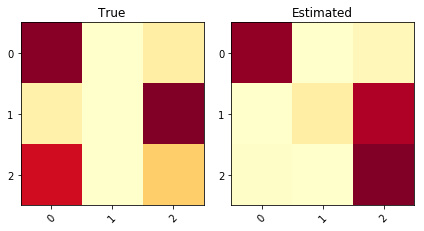

KL divergence: 0.9151	Pearson Correlation between diagonals: 0.6953


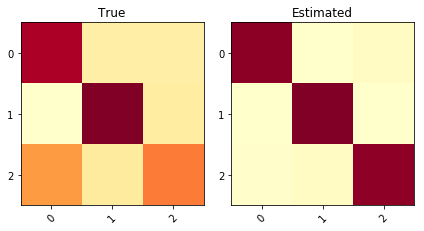

KL divergence: 0.5978	Pearson Correlation between diagonals: 0.7617


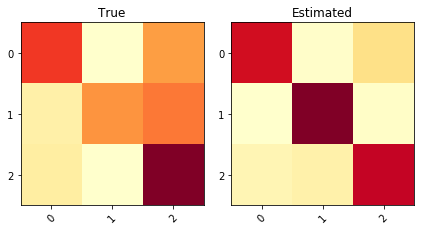

KL divergence: 0.5201	Pearson Correlation between diagonals: -0.6430


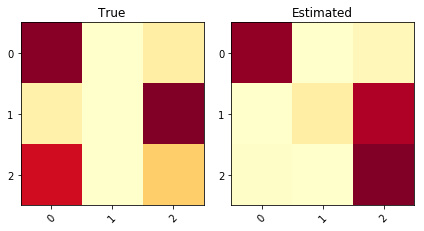

KL divergence: 0.9151	Pearson Correlation between diagonals: 0.6953


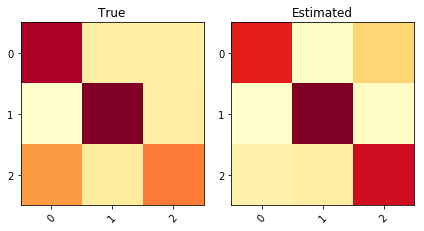

KL divergence: 0.1812	Pearson Correlation between diagonals: 0.4594


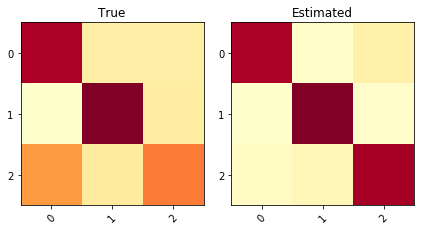

KL divergence: 0.3463	Pearson Correlation between diagonals: 0.5476


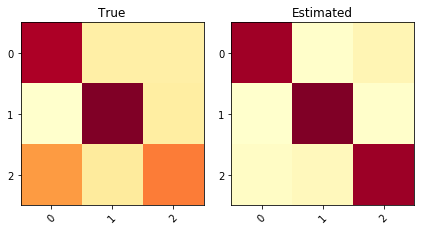

KL divergence: 0.4130	Pearson Correlation between diagonals: 0.5943


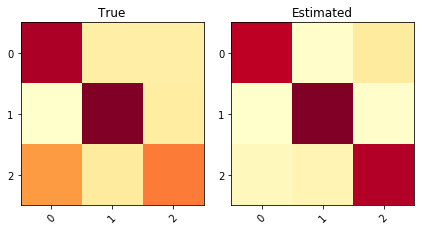

KL divergence: 0.2790	Pearson Correlation between diagonals: 0.5082


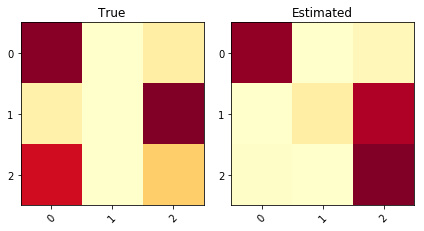

KL divergence: 0.9151	Pearson Correlation between diagonals: 0.6953


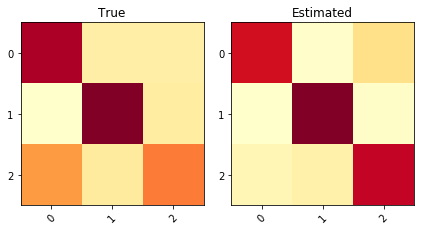

KL divergence: 0.2145	Pearson Correlation between diagonals: 0.4758


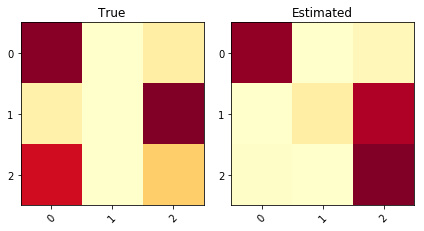

KL divergence: 0.9151	Pearson Correlation between diagonals: 0.6953


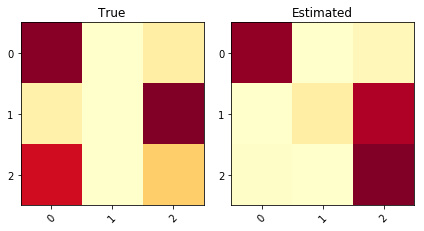

KL divergence: 0.9151	Pearson Correlation between diagonals: 0.6953


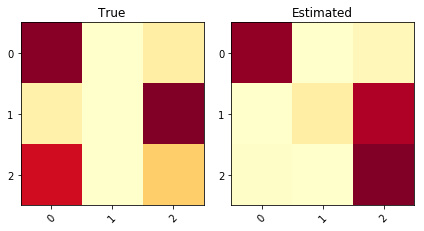

KL divergence: 0.9151	Pearson Correlation between diagonals: 0.6953
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.823769      0.823769   0.633697  0.0995035            0.211277
====  ======  ==========  ============  =========  =========  ==================


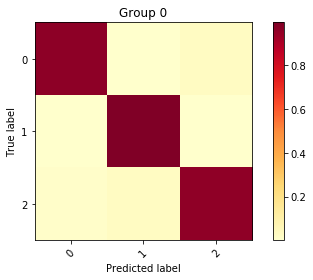

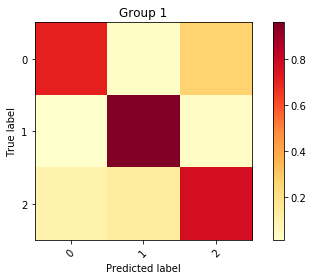

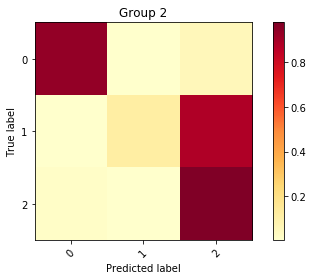

Inertia: 0.12874665390700102
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  =========  ======  =========  ===========  =========  =============  =========
   0         0  0.339007       33   0.136741     0.971828  0.0286947       0.985727   0.957741
   1         1  0.595986       59   0.528459     0.812881  0.215287        0.896818   0.719322
   2         2  0.0650065       6   0.247072     0.678351  0.7426          0.742927   0.517526
====  ========  =========  ======  =========  ===========  =========  =============  =========


In [32]:
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(40):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 39:
        del gMixture
    gc.collect()
i_r = np.argmax([value[-1] for value in logL_encontrados])
print("Best run accuracy:", accTE_encontrados[i_r])
print("Mean accuracy of runs:", np.mean(accTE_encontrados))
print("std accuracy of runs:", np.std(accTE_encontrados))
print("Median accuracy of runs:", np.median(accTE_encontrados))

gMixture.betas = matrices_encontradas[i_r].copy()
gMixture.base_model = modelos_encontrados[i_r]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

evaluate = Evaluation_metrics(gMixture,'our1') 
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[i_r]) #best acc mode

[[0.47588617 0.07480964 0.4493042 ]
 [0.41839233 0.12177197 0.45983574]
 [0.40979594 0.04455228 0.5456518 ]
 [0.8362551  0.10761694 0.05612805]
 [0.39247876 0.0815383  0.525983  ]
 [0.31336898 0.05861062 0.6280204 ]
 [0.4042968  0.04130329 0.5543999 ]
 [0.46040174 0.11684909 0.42274922]
 [0.28913012 0.09875846 0.6121114 ]
 [0.40372822 0.05195808 0.5443137 ]
 [0.0982627  0.12299067 0.77874666]
 [0.42540145 0.0746446  0.49995396]
 [0.32699463 0.08175059 0.5912548 ]
 [0.64574516 0.11832114 0.23593372]
 [0.46875152 0.0249801  0.50626844]
 [0.331152   0.05042687 0.61842114]
 [0.61352336 0.08217172 0.30430493]
 [0.3048687  0.06034232 0.634789  ]
 [0.36351475 0.14487144 0.4916138 ]
 [0.32538852 0.35470983 0.31990167]
 [0.23820946 0.05267875 0.70911175]
 [0.34628817 0.04165038 0.61206144]
 [0.32135603 0.04910701 0.6295369 ]
 [0.38097602 0.0610708  0.55795324]
 [0.48871434 0.04479172 0.46649393]
 [0.33777654 0.62530446 0.03691907]
 [0.34014902 0.073269   0.58658195]
 [0.3628806  0.5869729  0.05

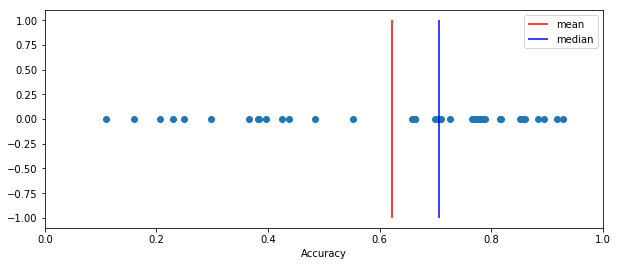

In [33]:
#what about others?
sorted_r = np.argsort([value[-1] for value in logL_encontrados])[::-1]
print(np.asarray(alphas_enc)[sorted_r])
plt.figure(figsize=(10,4))
plt.scatter(accTE_encontrados,np.zeros(len(accTE_encontrados)))
plt.vlines(np.mean(accTE_encontrados),-1,1,color='r',label="mean")
plt.vlines(np.median(accTE_encontrados),-1,1,color='b',label='median')
plt.xlabel("Accuracy")
plt.xlim(0,1)
plt.legend()
plt.show()

### Multiples runs experiment
---

In [18]:
from  scipy.stats import entropy
def distance_function(predicted,ob): # to cluster
    #return [-np.sum(predicted*np.log(ob))] #funciona bien -- over 90 = 5 -- over 90 = 8 (lambda=1)
    return -predicted*np.log(ob) #without sum -- over 90 = 6 -- over 90 = 3 (lambda=1)
    #return [entropy(predicted, qk=ob)] #over 90 = 5-6 -- no son tan buenos pero encunetra 3
    #return -predicted*np.log(ob/predicted) #klwithoutsum --over 90 = 6 -- encuentra 3 grupos --over 90=7 (lambda=1)
    
    #con la opcion1 y modelo entrenado ??

    #aux = 0.5*predicted + 0.5*ob
    #return [0.5*entropy(predicted,aux) + 0.5*entropy(ob,aux)] # jensen shanon -- over 90 =3
    #return -np.sum(ob*np.log(predicted)) #alreves -- termina ocupando solo 1 grupo así
    #return -np.sum(predicted*ob) # dot product -- igual que arriba

In [24]:
from sklearn.metrics import accuracy_score
logL_encontrados =[]
accTR_encontrados = []
accTE_encontrados = []
matrices_encontradas = []
alphas_enc =[]
modelos_encontrados = []
for l in range(20):
    gMixture = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=3,epochs=1,pre_init=5,optimizer=OPT,dtype_op=DTYPE_OP) 
    gMixture.define_model("mlp",8,1,BatchN=False,drop=0.2)
    gMixture.lambda_random = True
    logL_hists,i = gMixture.multiples_run(1,Xstd_train[:-5],r_obs[:-5],batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)#,bulk_annotators=[y_obs[:-5],annotators_pca])
    logL_encontrados.append(logL_hists[i])
    accTR_encontrados.append(accuracy_score(Z_train,gMixture.base_model.predict_classes(Xstd_train)))
    accTE_encontrados.append(accuracy_score(Z_test,gMixture.base_model.predict_classes(Xstd_test)))
    modelos_encontrados.append(gMixture.get_basemodel())
    matrices_encontradas.append(gMixture.get_confusionM())
    alphas_enc.append(gMixture.get_alpha())
    if l != 19:
        del gMixture
    gc.collect()
print("Done!")

Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.003072 mins
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.26496634 0.92372674 0.9306763 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 4.07 sec)	logL: -24346.089	
Iter 2/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -23945.307	Tol1: 0.01646	Tol2: 0.37958	Tol3: 0.03216	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23713.191	Tol1: 0.00969	Tol2: 0.19553	Tol3: 0.02313	
Iter 4/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23502.901	Tol1: 0.00887	Tol2: 0.13008	Tol3: 0.01899	
Iter 5/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23288.766	Tol1: 0.00911	Tol2: 0.10093	Tol3: 0.01764	
Iter 6/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23062.422	Tol1: 0.00972	Tol2: 0.08551	Tol3: 0.01729	
Iter 7/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.12 sec)	logL: -19773.562	Tol1: 0.00281	Tol2: 0.03140	Tol3: 0.01631	
Iter 31/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19728.431	Tol1: 0.00228	Tol2: 0.03067	Tol3: 0.01549	
Iter 32/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19688.369	Tol1: 0.00203	Tol2: 0.02925	Tol3: 0.01484	
Finished training!
Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.003460 mins
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.28460962 0.34419423 0.13935593]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 4.48 sec)	logL: -23059.284	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22359.390	Tol1: 0.03035	Tol2: 0.33318	Tol3: 0.10624	
Iter 3/50
M step: done,  E step: done //  (in 0.32 sec)	logL: -21998.783	Tol1: 0.01613	Tol2: 0.17309	Tol3: 0.03977	
Iter 4/50
M step: done,  E step:

M step: done,  E step: done //  (in 0.12 sec)	logL: -19335.390	Tol1: 0.00016	Tol2: 0.03570	Tol3: 0.00467	
Iter 30/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19329.821	Tol1: 0.00029	Tol2: 0.03411	Tol3: 0.00554	
Iter 31/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19327.994	Tol1: 0.00009	Tol2: 0.03188	Tol3: 0.00676	
Iter 32/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19323.368	Tol1: 0.00024	Tol2: 0.02838	Tol3: 0.00588	
Finished training!
Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.002803 mins
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.45542455 0.89196295 0.6455947 ]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 4.80 sec)	logL: -24836.044	
Iter 2/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24064.407	Tol1: 0.03107	Tol2: 0.39754	Tol3: 0.08233	
Iter 3/50
M step: done,  E step

M step: done,  E step: done //  (in 0.11 sec)	logL: -19538.153	Tol1: 0.00299	Tol2: 0.05377	Tol3: 0.01226	
Iter 16/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19493.793	Tol1: 0.00227	Tol2: 0.04971	Tol3: 0.00979	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19459.913	Tol1: 0.00174	Tol2: 0.04706	Tol3: 0.00880	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19433.273	Tol1: 0.00137	Tol2: 0.04608	Tol3: 0.00621	
Iter 19/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -19411.007	Tol1: 0.00115	Tol2: 0.04507	Tol3: 0.00497	
Iter 20/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19392.728	Tol1: 0.00094	Tol2: 0.04575	Tol3: 0.00352	
Iter 21/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19380.867	Tol1: 0.00061	Tol2: 0.04551	Tol3: 0.00253	
Iter 22/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19375.178	Tol1: 0.00029	Tol2: 0.04397	Tol3: 0.00431	
Iter 23/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19365.757	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -20302.958	Tol1: 0.00513	Tol2: 0.05640	Tol3: 0.01730	
Iter 16/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20209.961	Tol1: 0.00458	Tol2: 0.05326	Tol3: 0.01753	
Iter 17/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20121.688	Tol1: 0.00437	Tol2: 0.04927	Tol3: 0.01770	
Iter 18/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20038.387	Tol1: 0.00414	Tol2: 0.04719	Tol3: 0.01745	
Iter 19/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19973.232	Tol1: 0.00325	Tol2: 0.04486	Tol3: 0.01738	
Iter 20/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19909.678	Tol1: 0.00318	Tol2: 0.04098	Tol3: 0.01702	
Iter 21/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19845.451	Tol1: 0.00323	Tol2: 0.03894	Tol3: 0.01649	
Iter 22/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19791.760	Tol1: 0.00271	Tol2: 0.03733	Tol3: 0.01608	
Iter 23/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19739.915	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -20552.976	Tol1: 0.00881	Tol2: 0.06685	Tol3: 0.02712	
Iter 16/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20391.321	Tol1: 0.00787	Tol2: 0.06015	Tol3: 0.02535	
Iter 17/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20257.062	Tol1: 0.00658	Tol2: 0.05408	Tol3: 0.02332	
Iter 18/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20141.732	Tol1: 0.00569	Tol2: 0.04917	Tol3: 0.02122	
Iter 19/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -20050.366	Tol1: 0.00454	Tol2: 0.04329	Tol3: 0.01886	
Iter 20/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19973.045	Tol1: 0.00386	Tol2: 0.03764	Tol3: 0.01654	
Iter 21/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19910.583	Tol1: 0.00313	Tol2: 0.03303	Tol3: 0.01446	
Iter 22/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19852.927	Tol1: 0.00290	Tol2: 0.02921	Tol3: 0.01264	
Finished training!
Needed params (units,deep,drop,BatchN?)
mv_close is done

M step: done,  E step: done //  (in 0.12 sec)	logL: -19442.835	Tol1: 0.00028	Tol2: 0.03755	Tol3: 0.00453	
Iter 31/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19433.634	Tol1: 0.00047	Tol2: 0.03518	Tol3: 0.00605	
Iter 32/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19429.580	Tol1: 0.00021	Tol2: 0.03336	Tol3: 0.00483	
Iter 33/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19421.283	Tol1: 0.00043	Tol2: 0.02870	Tol3: 0.00495	
Finished training!
Needed params (units,deep,drop,BatchN?)
mv_close is done
Clustering Done!
Get init alphas in 0.002670 mins
Initializing new EM...
Pre-train network on 5 epochs... Done!
Lambda by group:  [0.3683449  0.8762382  0.16509849]
Alphas:  (3,)
MV init:  (2452, 3)
Betas:  (3, 3, 3)
Q estimate:  (2452, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 5.00 sec)	logL: -23128.092	
Iter 2/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -22517.217	Tol1: 0.02641	Tol2: 0.33488	Tol3: 0.09213	
Iter 3/50
M step: done,  E step

M step: done,  E step: done //  (in 0.13 sec)	logL: -21563.476	Tol1: 0.01481	Tol2: 0.12671	Tol3: 0.03514	
Iter 6/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -21267.959	Tol1: 0.01370	Tol2: 0.11381	Tol3: 0.03295	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -21003.721	Tol1: 0.01242	Tol2: 0.10214	Tol3: 0.03096	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -20775.164	Tol1: 0.01088	Tol2: 0.09010	Tol3: 0.02809	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -20571.289	Tol1: 0.00981	Tol2: 0.07845	Tol3: 0.02483	
Iter 10/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20406.965	Tol1: 0.00799	Tol2: 0.06875	Tol3: 0.02171	
Iter 11/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20268.304	Tol1: 0.00679	Tol2: 0.06372	Tol3: 0.01786	
Iter 12/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20150.690	Tol1: 0.00580	Tol2: 0.05913	Tol3: 0.01640	
Iter 13/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20055.793	Tol1:

M step: done,  E step: done //  (in 0.12 sec)	logL: -20586.561	Tol1: 0.01196	Tol2: 0.08399	Tol3: 0.02390	
Iter 10/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20352.842	Tol1: 0.01135	Tol2: 0.07366	Tol3: 0.02405	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20150.167	Tol1: 0.00996	Tol2: 0.06396	Tol3: 0.02347	
Iter 12/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19980.729	Tol1: 0.00841	Tol2: 0.05934	Tol3: 0.02147	
Iter 13/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19842.865	Tol1: 0.00690	Tol2: 0.05634	Tol3: 0.02000	
Iter 14/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19738.185	Tol1: 0.00528	Tol2: 0.05369	Tol3: 0.01741	
Iter 15/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19651.677	Tol1: 0.00438	Tol2: 0.05241	Tol3: 0.01306	
Iter 16/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19585.288	Tol1: 0.00338	Tol2: 0.05017	Tol3: 0.01144	
Iter 17/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19537.487	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -20813.958	Tol1: 0.01302	Tol2: 0.07953	Tol3: 0.02068	
Iter 9/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20560.142	Tol1: 0.01219	Tol2: 0.07392	Tol3: 0.02001	
Iter 10/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20342.604	Tol1: 0.01058	Tol2: 0.06975	Tol3: 0.01771	
Iter 11/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -20166.863	Tol1: 0.00864	Tol2: 0.06626	Tol3: 0.01453	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -20018.580	Tol1: 0.00735	Tol2: 0.06536	Tol3: 0.01288	
Iter 13/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19899.922	Tol1: 0.00593	Tol2: 0.06395	Tol3: 0.01075	
Iter 14/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19813.178	Tol1: 0.00436	Tol2: 0.06027	Tol3: 0.00951	
Iter 15/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -19740.433	Tol1: 0.00367	Tol2: 0.05633	Tol3: 0.00929	
Iter 16/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -19679.980	To

In [20]:
colors = [cm.tab20(i) for i in range(20)] # b o c o tambn "_r"

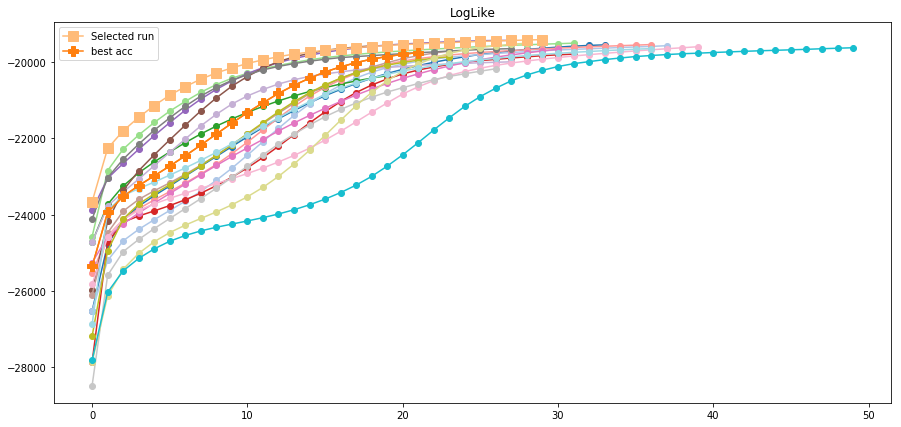

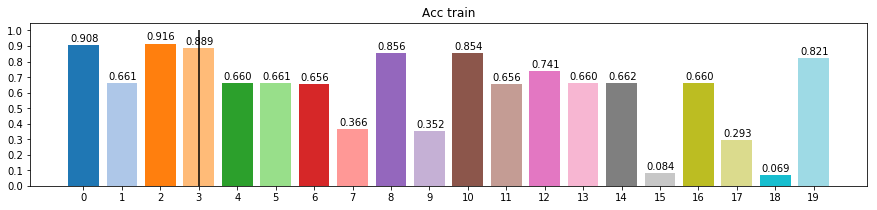

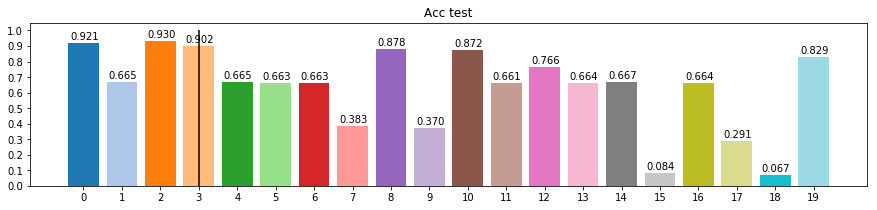

Mean acc test:  0.6302808302808303
std acc test:  0.25439805839990115
best loss acc test:  0.9023199023199023


In [21]:
i_r = np.argmax([value[-1] for value in logL_encontrados])
b_acc = np.argmax(accTE_encontrados)

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],markersize=10,label="Selected run")
plt.plot(range(len(logL_encontrados[b_acc])),logL_encontrados[b_acc],'P-',c=colors[b_acc],markersize=10,label="best acc")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

print("Mean acc test: ",np.mean(accTE_encontrados))
print("std acc test: ",np.std(accTE_encontrados))
print("best loss acc test: ",accTE_encontrados[i_r])

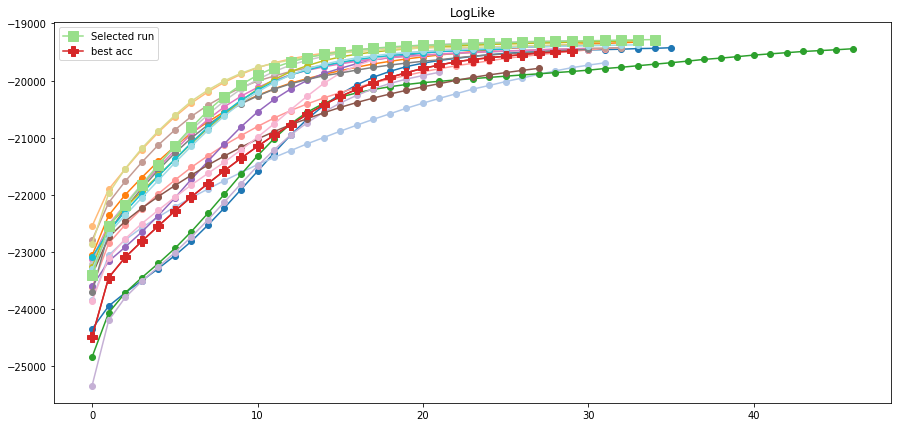

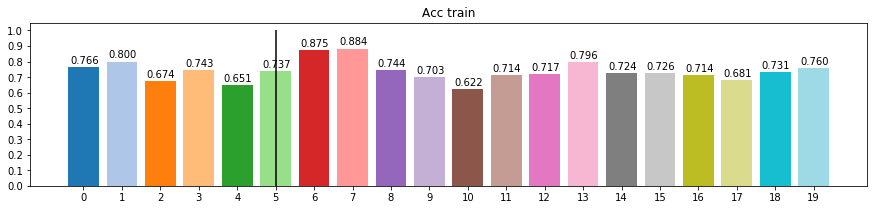

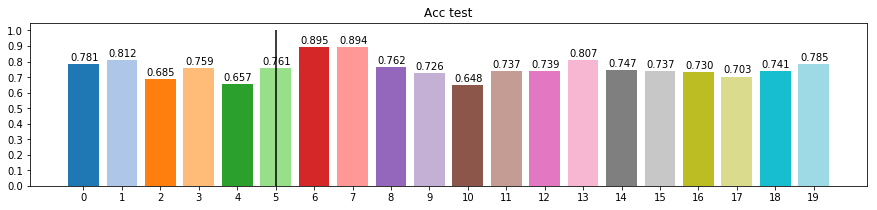

Mean acc test:  0.7554334554334554
std acc test:  0.06230947604937574
best loss acc test:  0.7606837606837606


In [25]:
i_r = np.argmax([value[-1] for value in logL_encontrados])
b_acc = np.argmax(accTE_encontrados)

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],markersize=10,label="Selected run")
plt.plot(range(len(logL_encontrados[b_acc])),logL_encontrados[b_acc],'P-',c=colors[b_acc],markersize=10,label="best acc")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

print("Mean acc test: ",np.mean(accTE_encontrados))
print("std acc test: ",np.std(accTE_encontrados))
print("best loss acc test: ",accTE_encontrados[i_r]) #pre init 5

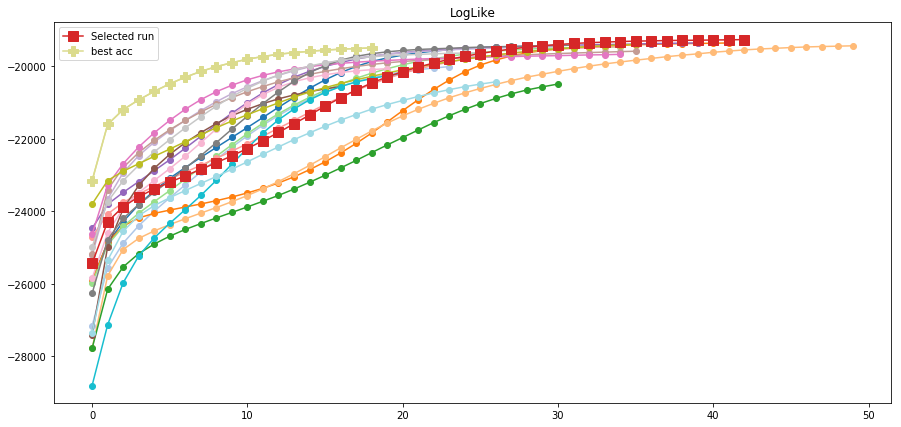

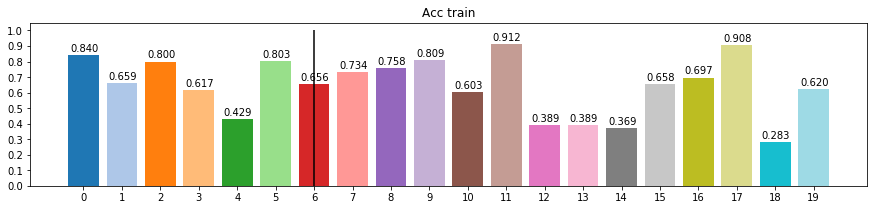

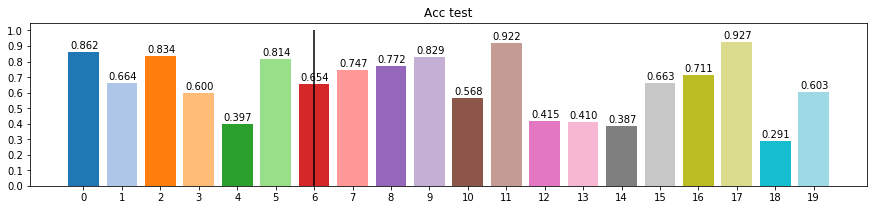

Mean acc test:  0.6534798534798535
std acc test:  0.1874841709170498
best loss acc test:  0.6544566544566545


In [23]:
i_r = np.argmax([value[-1] for value in logL_encontrados])
b_acc = np.argmax(accTE_encontrados)

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],markersize=10,label="Selected run")
plt.plot(range(len(logL_encontrados[b_acc])),logL_encontrados[b_acc],'P-',c=colors[b_acc],markersize=10,label="best acc")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

print("Mean acc test: ",np.mean(accTE_encontrados))
print("std acc test: ",np.std(accTE_encontrados))
print("best loss acc test: ",accTE_encontrados[i_r]) #pre init 1

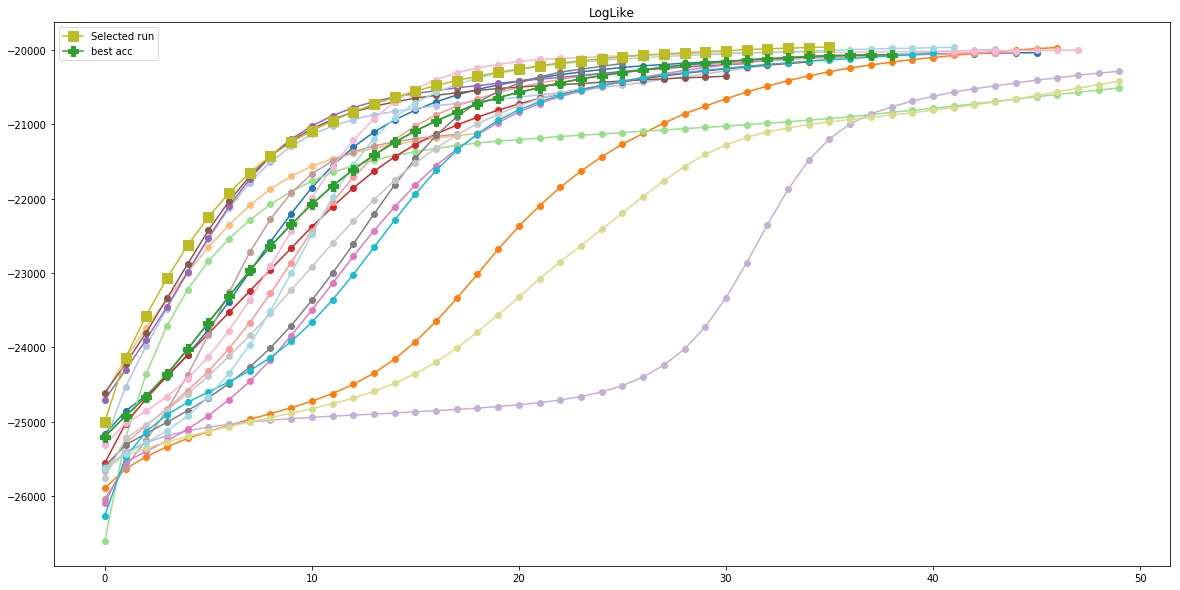

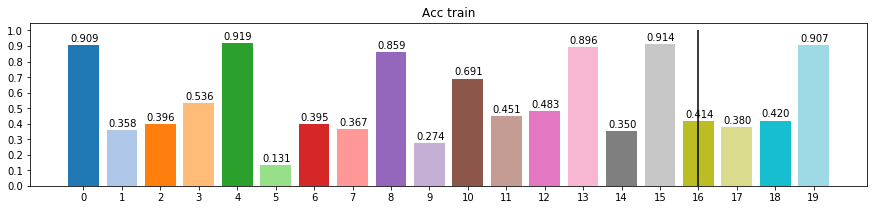

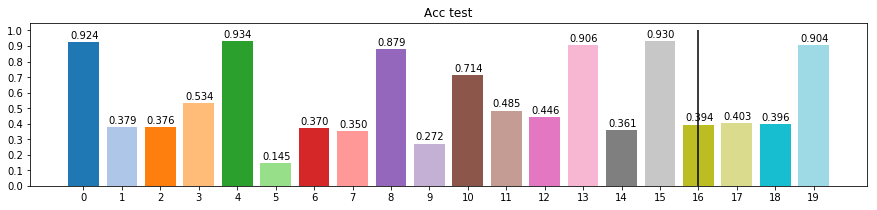

In [39]:
i_r = np.argmax([value[-1] for value in logL_encontrados])
b_acc = np.argmax(accTE_encontrados)

plt.figure(figsize=(20,10))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],markersize=10,label="Selected run")
plt.plot(range(len(logL_encontrados[b_acc])),logL_encontrados[b_acc],'P-',c=colors[b_acc],markersize=10,label="best acc")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

Values over 90 acc on test:  6


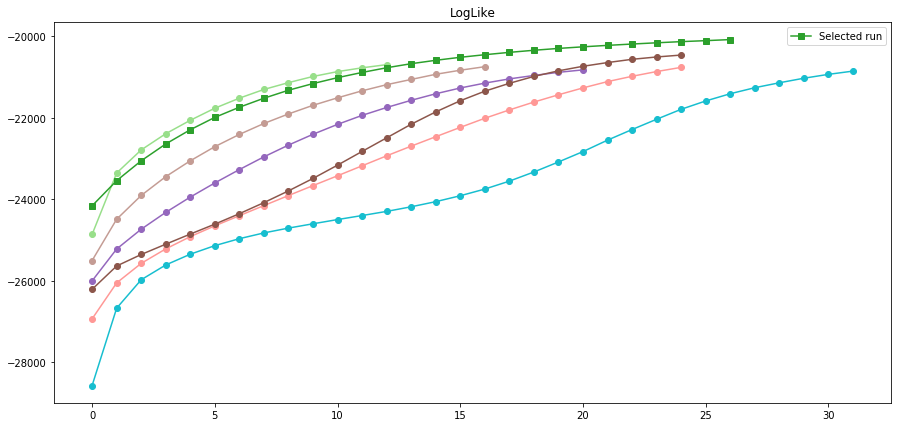

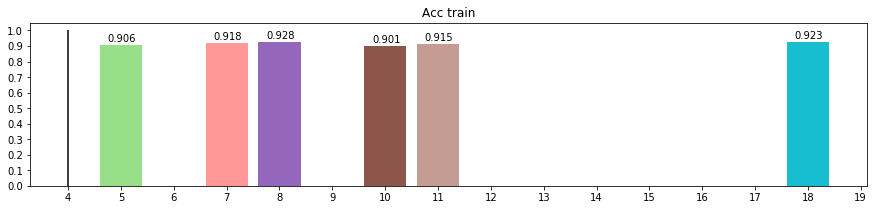

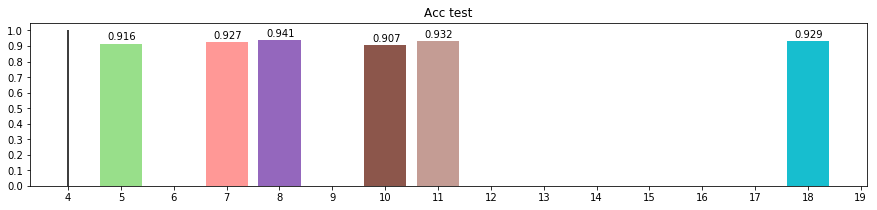

In [64]:
#just graph the high 90 acc
mask_high_values = (np.asarray(accTE_encontrados)>0.9) #and (np.asarray(accTR_encontrados>0.9))
print("Values over 90 acc on test: ",np.sum(mask_high_values))

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r and mask_high_values[a]:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],label="Selected run")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    if mask_high_values[a]:
        plt.bar(a,value,facecolor=colors[a])
#plt.plot(range(len(logL_encontrados[i_r])),logL_hists[i_r],'o-',label="Selected run")
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    if mask_high_values[x]:
        plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    if mask_high_values[a]:
        plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    if mask_high_values[x]:
        plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

Values over 80 acc on test:  4


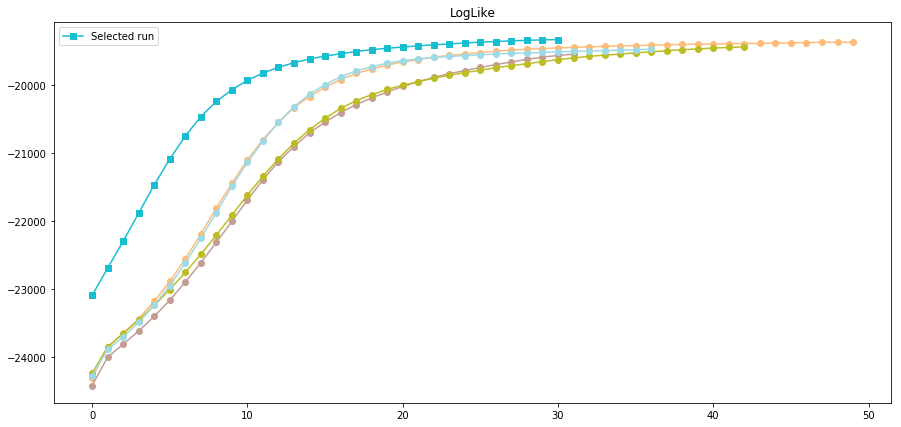

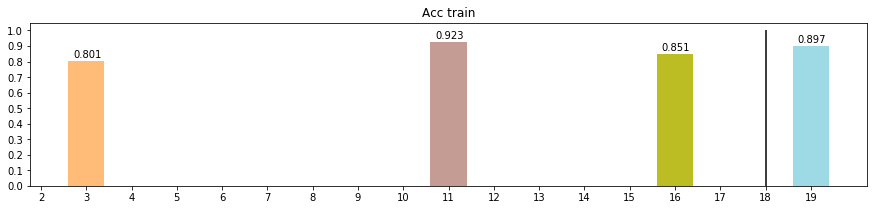

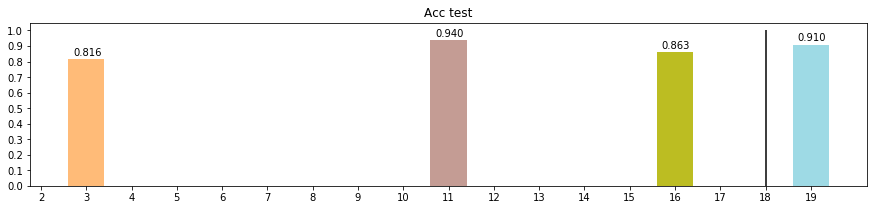

In [126]:
#just graph the high 80 acc
mask_high_values = (np.asarray(accTE_encontrados)>0.8) #and (np.asarray(accTR_encontrados>0.9))
print("Values over 80 acc on test: ",np.sum(mask_high_values))

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r and mask_high_values[a]:
        plt.plot(range(len(value)),value,'o-',c=colors[a])
plt.plot(range(len(logL_encontrados[i_r])),logL_encontrados[i_r],'s-',c=colors[i_r],label="Selected run")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    if mask_high_values[a]:
        plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    if mask_high_values[x]:
        plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    if mask_high_values[a]:
        plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    if mask_high_values[x]:
        plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

In [ ]:
what about first 3-5 iterations? #--funciona a veces :/

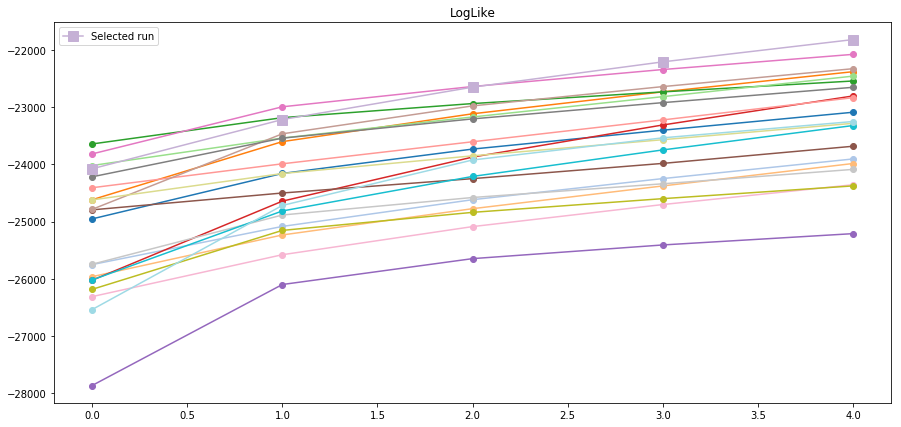

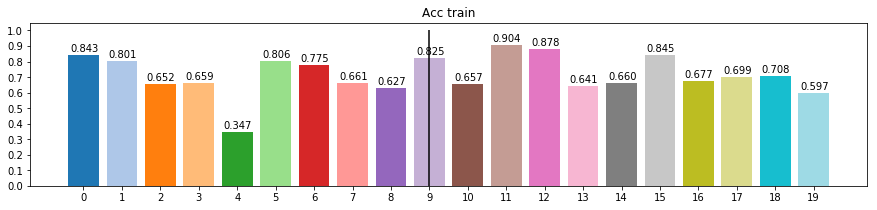

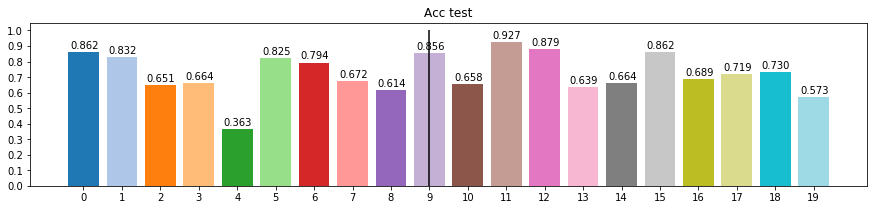

In [17]:
k_max = 5

i_r = np.argmax([value[k_max] for value in logL_encontrados])


#mask_high_values = (np.asarray(accTE_encontrados)>0.9) #and (np.asarray(accTR_encontrados>0.9))
#print("Values over 90 acc on test: ",np.sum(mask_high_values))
colors = [cm.tab20(i) for i in range(20)] # b o c o tambn "_r"

plt.figure(figsize=(15,7))
for a, value in enumerate(logL_encontrados): #logL_hists
    if a != i_r:
        plt.plot(range(k_max),value[:k_max],'o-',c=colors[a])
plt.plot(range(k_max),logL_encontrados[i_r][:k_max],'s-',c=colors[i_r],markersize=10,label="Selected run")
plt.legend()
plt.title("LogLike")
plt.show()

plt.figure(figsize=(15,3))
for a, value in enumerate(accTR_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTR_encontrados)), accTR_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc train")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()


plt.figure(figsize=(15,3))
for a, value in enumerate(accTE_encontrados): #logL_hists
    plt.bar(a,value,facecolor=colors[a])
for x, y in zip(range(len(accTE_encontrados)), accTE_encontrados):
    plt.text(x + 0.02, y + 0.01, '%.3f' % y, ha='center', va='bottom')
plt.title("Acc test")
plt.xticks(range(len(accTR_encontrados)))
plt.yticks(np.arange(0,11)/10)
plt.vlines(i_r,0,1)
plt.show()

In [128]:
#what about tolerance conv -- el 2do es bueno (mismo que arriba) --- el 1ero es mejor en very bad MV
aux = np.asarray([(value[-1] - value[-2])/np.abs(value[-2]) for value in logL_encontrados])
print("Relative order: ",np.argsort(aux))
aux = np.asarray([(value[-1] - value[-2]) for value in logL_encontrados])
print("Difference order :",np.argsort(aux))
aux = np.asarray([(value[-1] - value[-2])/np.abs(value[-1]) for value in logL_encontrados])
print("Relative future order :",np.argsort(aux))

Relative order:  [ 3 12 18  9 14  8 16  1  2 19  7  5  6  4 17 11 13  0 10 15]
Difference order : [ 3 12 18  9 14  8 16  1  2 19  7  5  6  4 17 11  0 13 10 15]
Relative future order : [ 3 12 18  9 14  8 16  1  2 19  7  5  6  4 17 11 13  0 10 15]


In [129]:
#what about delta conv mean -- los primeros 3 andan bien (solo el 1ero) -- en very bad MV el 2do es mejor..
aux = np.asarray([ np.mean([(value[i+1] - value[i])/np.abs(value[i]) for i in range(len(value)-1)]) for value in logL_encontrados])
print("Relative order: ",np.argsort(aux)[::-1])
aux = np.asarray([ np.mean([value[i+1] - value[i] for i in range(len(value)-1)]) for value in logL_encontrados])
print("Difference order :",np.argsort(aux)[::-1])

Relative order:  [ 4 15 10 13  0  5 11  9 19  8 18  6  2 16 17  1  7  3 12 14]
Difference order : [ 4 15 10 13  0  5 11  9 19  8  6 18  2 17  1 16  7  3 12 14]


In [18]:
#diversity -- 3ero es bueno
diversity_conf = [distance_2_centroid(matrix) for matrix in matrices_encontradas]
np.argsort(diversity_conf)[::-1]

array([ 8,  6,  2, 12, 11,  1,  7,  5,  9,  3, 14, 19,  0, 15, 17, 18, 13,
       10, 16,  4])

* seleccion de 1eras iteraciones: valor medio (ni muy bueno ni muy malo)
* el 1ero y 3ero de diversity anda bien, el 2do hace match con la seleccion de barras arriba
* el 1ero y 3ero de diversity anda en valor medio, el 1ero hace match con la seleccion de barras arriba
* difference convergence: solo 1ero anda  bien
* difference convergence: los primeros no andan nada bien (bastante mal)
* tolerance convergence: 2 priemros valors andan bien
* tolerance convergence: el primero anda bien

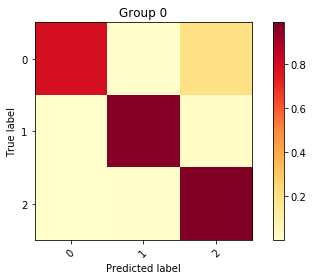

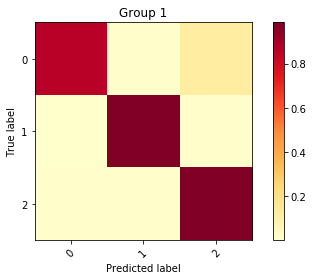

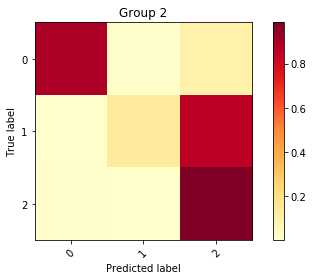

Inertia: 0.1005351134420683
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  ========  ======  =========  ===========  =========  =============  =========
   0         0  0.298012      29   0.241592     0.91821   0.0905791       0.956062   0.584876
   1         1  0.183288      18   0.206137     0.944829  0.0583558       0.971293   0.611496
   2         2  0.5187        51   0.288013     0.672738  0.702782        0.746967   0.339405
====  ========  ========  ======  =========  ===========  =========  =============  =========


In [93]:
results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[2]) #PCA

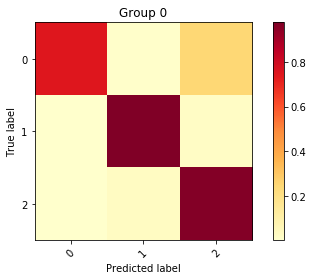

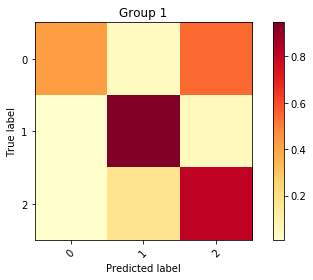

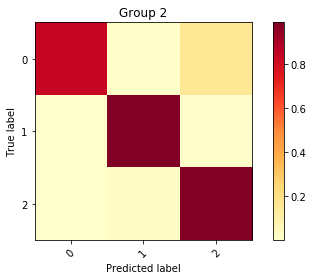

Inertia: 0.02718729921616614
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer
====  ========  =========  ======  =========  ===========  =========  =============  =========
   0         0  0.575043       57   0.287592     0.896578  0.116829        0.943692   0.844867
   1         1  0.0463163       4   0.521101     0.727678  0.375092        0.83209    0.591517
   2         2  0.378641       37   0.219132     0.93353   0.0717618       0.964915   0.900295
====  ========  =========  ======  =========  ===========  =========  =============  =========


In [65]:
results = evaluate.calculate_metrics(conf_pred=matrices_encontradas[4]) #best acc model

In [47]:
#measure on best
selected = 12
gMixture.betas = matrices_encontradas[selected].copy()
gMixture.base_model = modelos_encontrados[selected]
gMixture.E_step(Xstd_train,gMixture.get_predictions(Xstd_train)) #to set up Q

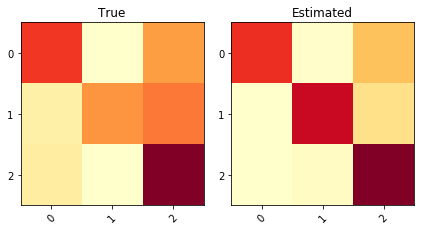

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6535


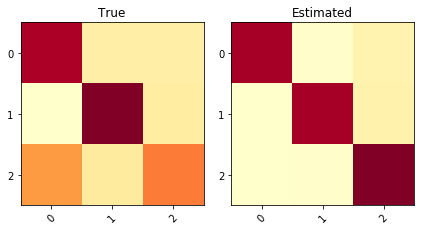

KL divergence: 0.7302	Pearson Correlation between diagonals: -0.9766


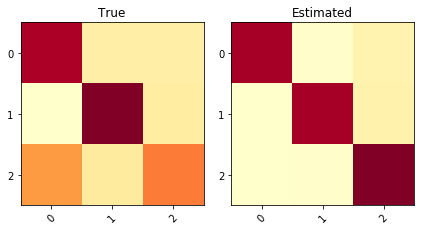

KL divergence: 0.7302	Pearson Correlation between diagonals: -0.9766


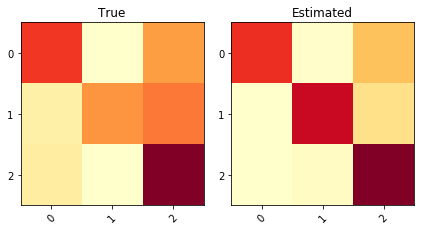

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536


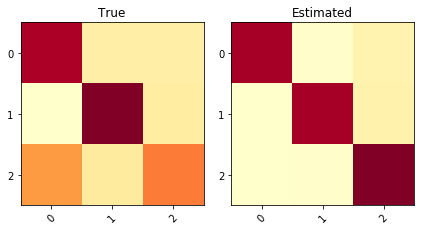

KL divergence: 0.7302	Pearson Correlation between diagonals: -0.9766


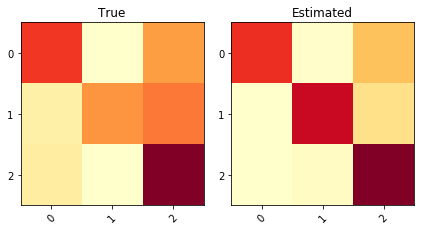

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536


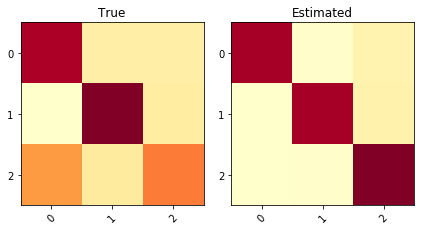

KL divergence: 0.7302	Pearson Correlation between diagonals: -0.9766


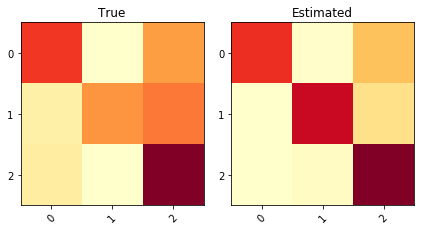

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536


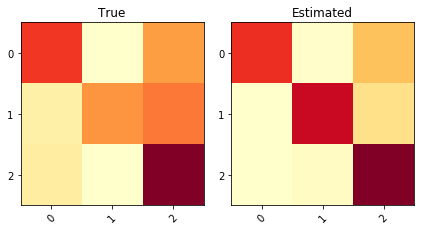

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536


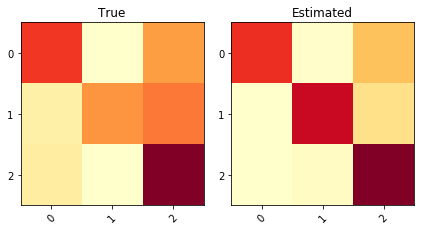

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536


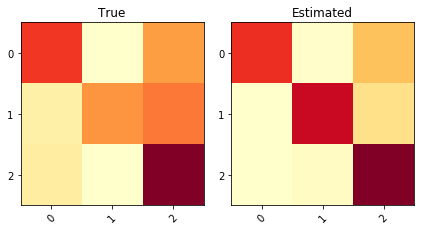

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6535


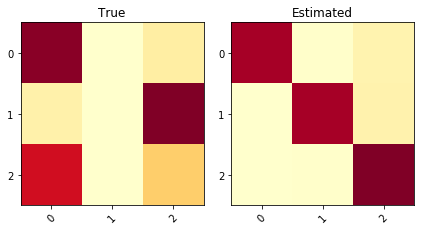

KL divergence: 2.1056	Pearson Correlation between diagonals: -0.2592


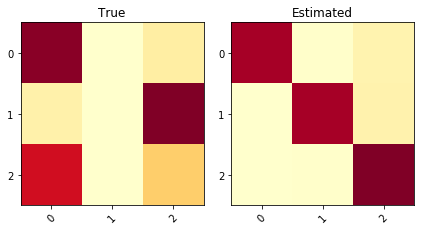

KL divergence: 2.1056	Pearson Correlation between diagonals: -0.2592


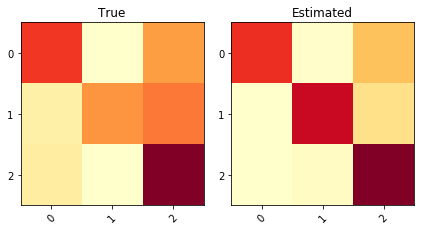

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536


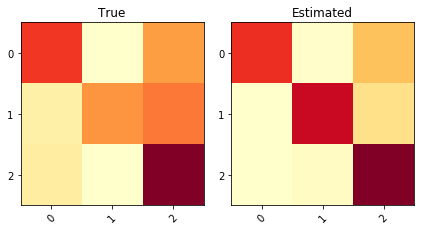

KL divergence: 0.2664	Pearson Correlation between diagonals: 0.6536
A result
 ====  ======  ==========  ============  =========  =========  ==================
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr
====  ======  ==========  ============  =========  =========  ==================
   0  Global    0.881156      0.881156   0.731918   0.101208           0.0165031
====  ======  ==========  ============  =========  =========  ==================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.885226      0.885226
====  ======  ==========  ============


In [48]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture,'our1') 

#needed to evaluate other stuffs
aux = gMixture.calculate_extra_components(Xstd_train,y_obs,T=100,calculate_pred_annotator=False)
predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...

#Usuall train
Z_train_pred = gMixture.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs, y_o_groups=y_o_groups)

print("Test")
Z_test_pred = gMixture.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred) #PCA

### $\lambda$ random on clean data 2

In [227]:
#1,2,9,14,15,18 ----5,8,16(aprox), 19 very aprox
#revisar log loss..
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #best is lambda close to 1

Indices:  [19  8  1 15 14 18 16  4  0  9 10  2  7 13 12  6  3 17  5 11]
F1 scores:  0.9567233308497585
F1 scores:  0.9722991947952253
F1 scores:  0.9730373373417617
F1 scores:  0.9708188472037063
F1 scores:  0.956016774823882


array([[[0.52382575, 0.21659293, 0.25958132],
        [0.11623011, 0.83725768, 0.04651221],
        [0.44169099, 0.00159129, 0.55671772]],

       [[0.21783677, 0.41721678, 0.36494644],
        [0.4749662 , 0.49408818, 0.03094562],
        [0.4142501 , 0.00183745, 0.58391245]]])

In [231]:
for ind in indexs_sort[:5]:
    print("LogLoss %f "%logL_iter[ind] )

LogLoss -74753.037878 
LogLoss -74846.558465 
LogLoss -74848.771741 
LogLoss -74881.145240 
LogLoss -75019.563584 


### $\lambda$ =1 on clean data 2

In [232]:
# 0 y 1 interesantes--3 aprox
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [3 0 1 2 4]
F1 scores: 0.955606 y LogLoss -74719.447607 
F1 scores: 0.968179 y LogLoss -74883.187174 
F1 scores: 0.960457 y LogLoss -74920.960253 
F1 scores: 0.956374 y LogLoss -75083.774056 
F1 scores: 0.351232 y LogLoss -76185.540685 


array([[[0.50777171, 0.22507155, 0.26715675],
        [0.11185078, 0.83924488, 0.04890434],
        [0.4582481 , 0.00159581, 0.54015609]],

       [[0.22760429, 0.41990971, 0.352486  ],
        [0.47839272, 0.49042606, 0.03118121],
        [0.40264624, 0.00196233, 0.59539143]]])

In [239]:
#con alfa data dependent --> 3,2 y 0 muy buenos
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [4 1 3 2 0]
F1 scores: 0.458558 y LogLoss -73051.591996 
F1 scores: 0.962240 y LogLoss -73313.658698 
F1 scores: 0.965886 y LogLoss -73497.073680 
F1 scores: 0.974446 y LogLoss -73702.008816 
F1 scores: 0.971485 y LogLoss -73704.003644 


array([[[7.05309888e-01, 6.78381229e-03, 2.87906299e-01],
        [7.35180890e-02, 9.24724807e-01, 1.75710357e-03],
        [5.01078305e-01, 2.81658016e-01, 2.17263679e-01]],

       [[4.66742009e-01, 1.93783100e-04, 5.33064208e-01],
        [6.14267012e-01, 3.16643747e-01, 6.90892417e-02],
        [1.89225399e-01, 1.86074745e-03, 8.08913853e-01]]])

### $\lambda$ random on noise data 2

In [254]:
#9,1,16,4,17 -.- aprox : 15,7,3,8 , 13 very aprox
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda aprox to 1

Indices:  [13  1 15  9 16  2 12  7 18  3  4 17 11 19  6 14  0  5 10  8]
F1 scores: 0.888830 y LogLoss -78001.588032 
F1 scores: 0.892016 y LogLoss -78116.591164 
F1 scores: 0.884132 y LogLoss -78137.777845 
F1 scores: 0.883747 y LogLoss -78254.586413 
F1 scores: 0.883738 y LogLoss -78314.510964 


array([[[0.27134669, 0.35397641, 0.3746769 ],
        [0.44678169, 0.51668657, 0.03653173],
        [0.4222056 , 0.00645561, 0.5713388 ]],

       [[0.50628012, 0.21383676, 0.27988311],
        [0.14782917, 0.80655601, 0.04561483],
        [0.42775275, 0.00488844, 0.56735881]]])

In [255]:
matrices_encontradas[indexs_sort[1]] #-- l_0 == 1 l_1 ==0

array([[[0.08295195, 0.40093714, 0.51611091],
        [0.48669173, 0.45809595, 0.05521232],
        [0.62825357, 0.00538692, 0.36635951]],

       [[0.94113627, 0.02508032, 0.03378341],
        [0.00918393, 0.98703061, 0.00378546],
        [0.0255219 , 0.00113546, 0.97334265]]])

In [258]:
#with data dependent: 14,8,17,18,6,7
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #

Indices:  [10 16  9  1  2 19 15  0 13  5 12  6  3 11  8  7 17 14 18  4]
F1 scores: 0.569450 y LogLoss -72703.277615 
F1 scores: 0.491469 y LogLoss -72720.581623 
F1 scores: 0.508396 y LogLoss -72767.949725 
F1 scores: 0.491615 y LogLoss -72825.122112 
F1 scores: 0.507041 y LogLoss -72896.068329 


array([[[3.79349307e-01, 6.94819793e-04, 6.19955873e-01],
        [7.77944156e-01, 8.23359122e-02, 1.39719932e-01],
        [3.06555768e-01, 2.04645067e-04, 6.93239587e-01]],

       [[4.25210560e-01, 5.09417750e-01, 6.53716909e-02],
        [6.15437909e-02, 9.38092005e-01, 3.64204100e-04],
        [5.08005925e-01, 3.63402917e-01, 1.28591157e-01]]])

### $\lambda$ =1 on noise data 2

In [262]:
#1,3 y 4
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [1 3 4 0 2]
F1 scores: 0.891017 y LogLoss -77959.391833 
F1 scores: 0.886087 y LogLoss -78123.030905 
F1 scores: 0.884353 y LogLoss -78170.862790 
F1 scores: 0.882184 y LogLoss -78190.927143 
F1 scores: 0.859548 y LogLoss -78572.408112 


array([[[0.25098253, 0.35037085, 0.39864661],
        [0.44670657, 0.51498243, 0.038311  ],
        [0.4298412 , 0.00810423, 0.56205457]],

       [[0.52964153, 0.20908235, 0.26127612],
        [0.15634487, 0.79921221, 0.04444291],
        [0.41637648, 0.00626742, 0.57735611]]])

### $\lambda$ random on clean data 1

In [280]:
#15,11,10,19,9,8 -- very aprox 1,5,6
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda 1,0.3,0.9

Indices:  [ 5 15 11  8 14 10 16  1 19  4  9  6 12  0  2 18 13  3 17  7]
F1 scores: 0.954411 y LogLoss -77836.820531 
F1 scores: 0.958790 y LogLoss -77941.398320 
F1 scores: 0.940030 y LogLoss -77965.365354 
F1 scores: 0.947836 y LogLoss -78038.735143 
F1 scores: 0.910642 y LogLoss -78040.768166 


array([[[0.55499299, 0.40424585, 0.04076116],
        [0.74376586, 0.24764065, 0.00859349],
        [0.46344935, 0.36092144, 0.1756292 ]],

       [[0.82776326, 0.12548399, 0.04675276],
        [0.08155971, 0.90830062, 0.01013967],
        [0.03171331, 0.04560996, 0.92267673]],

       [[0.53795303, 0.34491255, 0.11713442],
        [0.22329621, 0.75771587, 0.01898792],
        [0.09282163, 0.195167  , 0.71201137]]])

In [284]:
matrices_encontradas[indexs_sort[1]] #lambda 1,0.75,0

array([[[0.67928817, 0.28913513, 0.0315767 ],
        [0.54120412, 0.45556271, 0.00323317],
        [0.42460938, 0.25247046, 0.32292017]],

       [[0.62701399, 0.27485157, 0.09813444],
        [0.22333284, 0.76642445, 0.01024272],
        [0.09648147, 0.14086318, 0.76265535]],

       [[0.52124351, 0.36240502, 0.11635147],
        [0.24622555, 0.74312222, 0.01065222],
        [0.09708732, 0.23612256, 0.66679012]]])

### $\lambda$ =1 on clean data 1

In [273]:
# 0 y 2 , quizas el 3
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [0 4 1 2 3]
F1 scores: 0.957691 y LogLoss -77777.045732 
F1 scores: 0.949563 y LogLoss -77822.228357 
F1 scores: 0.953599 y LogLoss -77856.778807 
F1 scores: 0.948690 y LogLoss -77872.086503 
F1 scores: 0.931905 y LogLoss -77906.054126 


array([[[0.59412547, 0.36171718, 0.04415735],
        [0.66799795, 0.32474261, 0.00725944],
        [0.52856849, 0.30642452, 0.16500699]],

       [[0.52760818, 0.33752145, 0.13487037],
        [0.31600033, 0.66175519, 0.02224447],
        [0.14146238, 0.22927853, 0.62925909]],

       [[0.56413881, 0.31949401, 0.11636717],
        [0.21524957, 0.76938829, 0.01536214],
        [0.07210637, 0.21926451, 0.70862912]]])

### $\lambda$ random on noisy data 1

In [305]:
# 4,15,18
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]] #lambda 0.9,0.95,0.77

Indices:  [16 15 17  2 19 12 14  5 18  1  6  4  7 13 10 11  8  3  9  0]
F1 scores: 0.869044 y LogLoss -78922.915633 
F1 scores: 0.866170 y LogLoss -78982.619162 
F1 scores: 0.861920 y LogLoss -79051.791381 
F1 scores: 0.857006 y LogLoss -79139.196237 
F1 scores: 0.847250 y LogLoss -79204.031599 


array([[[0.58607908, 0.36341081, 0.05051011],
        [0.66739828, 0.32284521, 0.00975651],
        [0.493704  , 0.30487077, 0.20142523]],

       [[0.50693243, 0.34776968, 0.14529789],
        [0.31437943, 0.65691552, 0.02870504],
        [0.12305859, 0.27650573, 0.60043568]],

       [[0.60705624, 0.26678528, 0.12615848],
        [0.18890858, 0.78930815, 0.02178327],
        [0.06595133, 0.17302841, 0.76102026]]])

In [306]:
matrices_encontradas[indexs_sort[1]] #lambda 0.9,0.15,1

array([[[0.54434378, 0.39895361, 0.05670261],
        [0.69226245, 0.29917253, 0.00856502],
        [0.48889289, 0.32543488, 0.18567223]],

       [[0.88857981, 0.07739007, 0.03403012],
        [0.04260737, 0.95177684, 0.00561578],
        [0.01874574, 0.03511641, 0.94613784]],

       [[0.46865228, 0.36090133, 0.1704464 ],
        [0.28625581, 0.6858124 , 0.02793179],
        [0.11223195, 0.26951884, 0.61824921]]])

### $\lambda$ =1 on noisy data 1

In [315]:
# 1 y 4
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))
matrices_encontradas[indexs_sort[0]]

Indices:  [4 1 3 2 0]
F1 scores: 0.871127 y LogLoss -78805.593847 
F1 scores: 0.867015 y LogLoss -78817.192683 
F1 scores: 0.849491 y LogLoss -78854.670714 
F1 scores: 0.865092 y LogLoss -78979.309951 
F1 scores: 0.866156 y LogLoss -78985.742220 


array([[[0.58714018, 0.36795373, 0.0449061 ],
        [0.69558504, 0.29376966, 0.0106453 ],
        [0.48082751, 0.31934017, 0.19983232]],

       [[0.54569706, 0.3299119 , 0.12439103],
        [0.27193291, 0.7006825 , 0.02738459],
        [0.11665229, 0.23142926, 0.65191844]],

       [[0.57664747, 0.29595247, 0.12740006],
        [0.20585552, 0.76759455, 0.02654993],
        [0.09077485, 0.19447976, 0.71474539]]])

In [259]:
Qij_gamma = np.sum(gMixture.get_qestimation(),axis=-2) #qij(gamma)
r_estimate = np.zeros((Qij_gamma.shape[0],Qij_gamma.shape[2])) #repeat estimate
for i in range(Qij_gamma.shape[0]):
    r_estimate[i] = np.tensordot(Qij_gamma[i],r_obs[i],axes=[[0],[0]])
r_estimate

array([[ 0.20453249, 25.85263166,  2.94283584],
       [ 0.12035406, 24.94385666,  0.93578928],
       [24.07822754,  4.97867884,  1.94309361],
       ...,
       [ 0.25168615, 31.56533154,  0.18298231],
       [ 7.46407726, 17.98318088,  9.55274186],
       [ 0.91988414,  0.0756443 , 27.00447157]])

In [71]:
gMixture.get_predictions(Xstd_train)

array([[0.06842059, 0.73907024, 0.19250914],
       [0.02262934, 0.94639385, 0.03097681],
       [0.4558536 , 0.44500634, 0.09914005],
       ...,
       [0.03236194, 0.94923073, 0.01840742],
       [0.30035946, 0.30898702, 0.3906535 ],
       [0.15407403, 0.0127452 , 0.8331808 ]], dtype=float32)

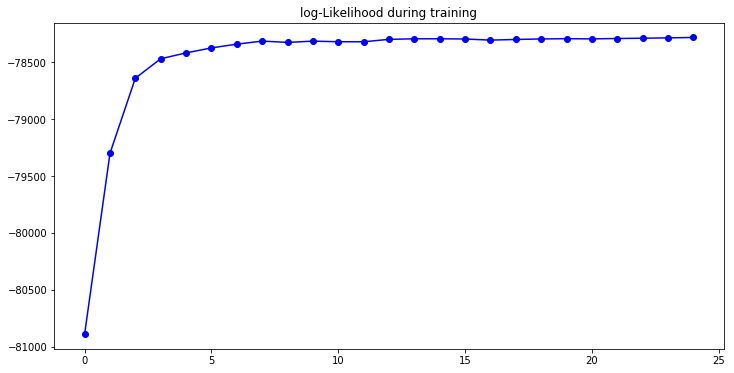

In [185]:
plt.figure(figsize=(12,6))
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.title("log-Likelihood during training")
plt.show()

In [146]:
### model over ground truth
model = clone_model(gMixture.get_basemodel())
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.fit(Xstd_train, keras.utils.to_categorical(Z_train), batch_size=128,epochs=50)
from utils import calculate_f1_keras
print(calculate_f1_keras(model, Xstd_train, Z_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2700/2700 [==============================] - 1s 442us/step - loss: 0.7655
Epoch 2/50
2700/2700 [==============================] - 0s 36us/step - loss: 0.7441
Epoch 3/50
2700/2700 [==============================] - 0s 34us/step - loss: 0.7239
Epoch 4/50
2700/2700 [==============================] - 0s 35us/step - loss: 0.7050
Epoch 5/50
2700/2700 [==============================] - 0s 31us/step - loss: 0.6872
Epoch 6/50
2700/2700 [==============================] - 0s 33us/step - loss: 0.6704
Epoch 7/50
2700/2700 [==============================] - 0s 38us/step - loss: 0.6546
Epoch 8/50
2700/2700 [==============================] - 0s 36us/step - loss: 0.6397
Epo

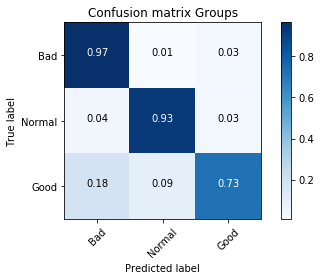

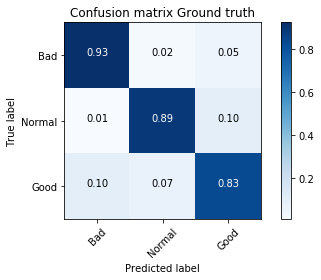

In [147]:
from utils import *
classes = ["Bad","Normal","Good"]
plot_confusion_keras(gMixture.base_model,Xstd_train,Z_train,classes,title='Confusion matrix Groups')
plot_confusion_keras(model,Xstd_train,Z_train,classes,title='Confusion matrix Ground truth')


<a id="condato"></a>
### Training module 2
---
Here we implement the iteration between **E** and **M** steps with bulks annotations $r_{itj}$.

In [ ]:
class GroupMixtureBulk(object):
    def __init__(self,input_dim,Kl=2,M=2,alpha_DD=True,epochs=1,optimizer='adam'): 
        
        
        self.input_dim = input_dim
        self.Kl = Kl #number of classes of the problem
        self.compile=False
        self.Keps = keras.backend.epsilon()
        self.priors=False #boolean of priors
        #params
        self.M = M #groups of annotators
        self.data_dependence = alpha_DD #for alpha = p(g|x) or p(g)
        self.epochs = epochs
        self.optimizer = optimizer
        
        self.seted_alphainit = False
        
    def get_basemodel(self):
        return self.base_model
    def get_confusionM(self):
        """Get confusion matrices of every group p(yo|g,z)"""  
        return self.betas
    def get_alpha(self):
        """Get alpha param, p(g|xi) for every data on trainig or globally p(g)"""
        return self.alphas
    def set_alpha(self,alphas_init):
        """set alpha param with a previosuly method"""
        self.alphas = alphas_init.copy()
        self.seted_alphainit = True
    def get_qestimation(self):
        return self.Qi_mgamma
        
    def define_model(self,tipo,*args):
        """Define the base model and other structures"""
        aux_info = None
        emb_info = None
        self.type = tipo.lower()
        if self.type =="cnn":
            info,aux_info =args
        elif self.type == "rnn":
            info,aux_info,emb_info = args            
        elif self.type == "ff" or self.type == "mlp": #classic feed forward
            start_units,deep,activation = args
            info = [start_units,deep,activation]
        elif self.type == "keras_shallow" or self.type=="keras_perceptron": 
            self.base_model = LogisticRegression_Keras(self.input_dim,self.Kl,self.optimizer)
            #It's not a priority, since HF has been shown to underperform RMSprop and Adagrad, while being more computationally intensive.
            #https://github.com/keras-team/keras/issues/460
        elif self.type =="sklearn_shallow" or self.type =="sklearn_logistic":
            self.base_model = LogisticRegression_Sklearn(self.epochs)
            self.compile = True
            return
        
        if not (self.type == "keras_shallow" or self.type=="keras_perceptron"): 
            self.base_model = create_network(self.Kl,self.input_dim,tipo,info,infoextractor_network=aux_info,embedding_info=emb_info)
        
        self.base_model.compile(optimizer=self.optimizer,loss='categorical_crossentropy') 
        self.compile = True
        
    def get_predictions(self,X,batch_size=None):
        if "sklearn" in self.type:
            return self.base_model.predict_proba(X) 
        else:
            return self.base_model.predict(X,batch_size=batch_size)
    
    def init_E(self,X,r):
        
        
        self.N = X.shape[0]
        #-------> init alpha
        if not self.seted_alphainit:
            self.alphas = np.random.dirichlet(np.ones(self.M),size=self.N) # random start that sum one
        
        #-------> init Majority voting
        mv_probs = majority_voting(r,repeats=True,probas=True)
        #majority voting by group...
        """
        mv_prob_groups = []
        r_sample = 0
        for l in range(self.M):
            aux_mv_probs = majority_voting(np.clip(r-r_sample,0,1e100),repeats=True,probas=True)
            r_sample = []
            for i in range(self.N):
                total_annotators = np.sum(r[i])
                ri_sample = np.random.multinomial(total_annotators/self.M, aux_mv_probs[i]) #asumming al groups have same number of annotators
                r_sample.append(ri_sample)
            r_sample = np.asarray(r_sample)
            mv_prob_groups.append(majority_voting(r_sample,repeats=True,probas=True) )
        """
        
        #-------> init q_i
        self.Qi_mgamma = np.random.rand(self.N,self.M,self.Kl) #random init
        #"""
        for i in range(self.N):            
            #for m in range(self.M):
            self.Qi_mgamma[i] = np.tensordot(self.alphas[i], mv_probs[i],axes=-1)  #a interestetnly E-step  
        
        #-------> init betas
        self.betas = np.random.rand(self.M,self.Kl,self.Kl)
        self.betas = self.betas/np.sum(self.betas,axis=-1)[:,:,None]
        
        """
        for i in range(self.N):
            self.Qi_mgamma[i] = np.log(self.alphas[i,:]+self.Keps)[:,None] + np.log(mv_probs[i,:]+self.Keps)[None,:] + np.tensordot(r[i,:],np.log(self.betas+self.Keps),axes=[[-1],[-1]])
            self.Qi_mgamma[i] = np.exp(self.Qi_mgamma[i])
            self.Qi_mgamma[i] = self.Qi_mgamma[i]/np.sum(self.Qi_mgamma[i]) #normalize q
        """
        
        print("Alphas: ",self.alphas.shape)
        print("MV init: ",mv_probs.shape)
        print("Betas: ",self.betas.shape)
        print("Q estimate: ",self.Qi_mgamma.shape)
            
    def define_priors(self,priors):
        """
            Priors with shape: (M,K,K), need counts for every group and every pair (k,k) ir global (M,K)
            The group m, given a class "k" is probably that say some class
            it is recomended that has full of ones
        """
        if len(priors.shape)==2:
            priors=np.expand_dims(priors,axis=2)
        self.Mpriors = priors
        self.priors = True
        
    def E_step(self,X,predictions,r): #r is data
        for i in range(self.N):
            self.Qi_mgamma[i] = np.log(self.alphas[i,:]+self.Keps)[:,None] + np.log(predictions[i,:]+self.Keps)[None,:] + np.tensordot(r[i,:],np.log(self.betas+self.Keps),axes=[[-1],[-1]])

            self.Qi_mgamma[i] = np.exp(self.Qi_mgamma[i])
            self.Qi_mgamma[i] = self.Qi_mgamma[i]/np.sum(self.Qi_mgamma[i]) #normalize q
                                                                                                                       
    def M_step(self,X,r): 
        #-------> base model
        #create the repeat "estimate"/"ground truth"
        Qi_gamma = np.sum(self.Qi_mgamma,axis=-2) #qi(gamma)
        #train to learn p(z|x)
        if "sklearn" in self.type:
            self.base_model.fit(X, np.argmax(Qi_gamma,axis=1) ) 
        else:
            history = self.base_model.fit(X,Qi_gamma,batch_size=self.batch_size,epochs=self.epochs,verbose=1) 
            
        #-------> alpha --maneja caso global y normal..
        Qi_m = np.sum(self.Qi_mgamma,axis=-1) #qi(m)
        if not self.data_dependence: #global alpha
            g_estimate = np.sum(Qi_m,axis=0)
            self.alphas[:] = g_estimate/np.sum(g_estimate,axis=-1) #p(g) 
        else:
            self.alphas = Qi_m #p(g|x)
        
        #-------> beta   # p(yo|g,z)
        for m in range(self.M):
            for j_z in range(self.Kl):
                for j_ob in range(self.Kl):
                    self.betas[m,j_z,j_ob] = np.tensordot(self.Qi_mgamma[:,m,j_z],r[:,j_ob], axes=[[0],[0]]) # ~p(yo|g,z)
        if self.priors:
            self.betas += self.Mpriors #priors has to be shape: (M,Kl,Kl)--read define-prior function
        self.betas = self.betas/np.sum(self.betas,axis=-1)[:,:,None] #normalize (=p(yo|g,z))

    def compute_logL(self,r,predictions):
        
                                                
    def train(self,X_train,r_train,batch_size=32,iterations=250,tolerance=0.001,relative=False): #0.0001  
        
                                                  

gMixtureRaykar = GroupMixtureBulk(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=10)
###epochs=1 as Rodriges says. and batch size as default
gMixtureRaykar.Kl

In [ ]:
gMixtureRaykar = GroupMixtureBulk(X_train.shape[1:],Kl=r_obs.shape[1],M=100)

#gMixture.define_model("sklearn_logistic") #logistic necesita datos de todas la clases
gMixtureRaykar.define_model("keras_shallow")
gMixtureRaykar.set_alpha(alphas_init_Raykar)
#gMixtureRaykar.set_alpha((y_obs!=-1)*1)

#need priors!!!--lo hace mas estable
M = 100
gMixtureRaykar.define_priors(np.ones((M,r_obs.shape[1])))

logL_hist = gMixtureRaykar.train(Xstd_train,r_obs,batch_size=64,iterations=10,relative=False)